In [ ]:
!wget https://github.com/gupo33/ProgettoNAPDE/raw/refs/heads/master/testairfoil.msh
#run this code only in colab, otherwise the mesh should be found in the same folder as the notebook

# Imports

In [80]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    #this only works in colab: on a local machine, firedrake should be installed before running this notebook
    from firedrake import *

In [81]:
try:
  from pygem import FFD,RBF
except ImportError:
  !git clone https://github.com/mathLab/PyGeM
  %cd PyGeM
  !python3.10 setup.py install
  from pygem import FFD,RBF
  %cd ..

In [82]:
try:
  from stable_baselines3 import PPO
except ImportError:
  !pip install stable_baselines3
  from stable_baselines3 import PPO

In [83]:
try:
    import gym
except ImportError:
    !pip install gym
    import gym

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from gym import spaces
import time

# Import the mesh

In [ ]:
M = Mesh('testairfoil.msh')

# Plot the mesh

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.legend()

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Solve problem with SUPG N-S with Stokes starting point

## Solve stokes to obtain a starting point

In [ ]:
# function space
V=VectorFunctionSpace(M, 'P', 2) # velocity
Q=FunctionSpace(M, 'P', 1) # pressure
W=MixedFunctionSpace([V, Q])

# trial and test functions
u, p=TrialFunctions(W)
v, q=TestFunctions(W)

# data
x=SpatialCoordinate(M)
Uinf=as_vector([1,0])

# problem
a=inner(grad(u), grad(v))*dx - p*div(v)*dx+ q*div(u)*dx
L=inner(Constant((0,0)),v)*dx

# Dirichlet BC
bc1=DirichletBC(W.sub(0), as_vector([0,0]), 0)
bc2=DirichletBC(W.sub(0), Uinf, 1)
bcs=(bc1, bc2)

#solution
w_stokes=Function(W)
solve(a==L, w_stokes, bcs=bcs)
# u_h, p_h=split(wh) no split command works only for trial and test funtion
u_stokes, p_stokes=w_stokes.subfunctions

fig, ax = plt.subplots()
q=tripcolor(p_stokes, axes=ax)
fig.colorbar(q)
fig, ax = plt.subplots()
q=quiver(u_stokes, axes=ax)
fig.colorbar(q)

## Set Reynolds Number


In [ ]:
Re = Constant(3500)

## Solve Navier Stokes with SUPG Stabilization

In [ ]:
def a(u,v, Re):
    return 1/Re*inner(grad(u), grad(v))*dx

def c(w,u,v):
    return inner(dot(grad(u), w),v)*dx

def b(v,q):
    return -q*div(v)*dx

def stabilization(u_old, u, p, v, q, M, Re):
    ubar = Function(FunctionSpace(M, 'DG', 0))
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(M)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta=Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

    L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
    Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)+ 0.5*div(u_old)*v

    lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
    rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

    return lhs, rhs


In [ ]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary
bc3 = DirichletBC(W.sub(1), 0, 0) # Dirichlet unitary B.C. on the inflow boundary
bcs = (bc1, bc2)

In [ ]:
# Trial and test functions
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions

param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }

# solution
wh = Function(W)
uh, ph = wh.subfunctions
wh.assign(w_stokes) #initialization with stokes solution

maxit=100
tol=1e-8
it=0
err=tol+1
delta=1

u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)



while it < maxit and err > tol:
  lhs, rhs = stabilization(u_old, u, p, v, q, M, Re)
  G = a(u,v,Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
  L = inner(f,v)*dx +rhs + c(u_old, u_old,v)
  pb = LinearVariationalProblem(G, L , wh, bcs=bcs)
  solver = LinearVariationalSolver(pb, solver_parameters=param)
  solver.solve()
  uh, ph = wh.subfunctions
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))
  u_old.assign(uh)
  p_old.assign(ph)
  it+=1

print(it)

## Plotting the solution

In [ ]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

In [ ]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

## Computing lift and drag coefficients

In [ ]:
T=p_h * Identity(2) - 1/Re * (grad(u_h) + grad(u_h).T)
n=FacetNormal(M)
Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
print(Cd)
print(Cl)

# Mesh deformation

## Node Extraction

In [ ]:
coord=M.coordinates.dat.data
coord.shape

In [ ]:
#extend coord to make it work with FFD
coord = np.c_[coord,np.ones(coord.shape[0])]

In [ ]:
plt.plot(coord[:,0], coord[:,1], '.')

In [ ]:
X = VectorFunctionSpace(M, 'P', 1)

b1 = DirichletBC(X, Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
b2 = DirichletBC(X, Constant((0.,0.)), [1, 2, 3, 4]) # Dirichlet unitary B.C. on the inflow boundary


In [ ]:
#extract obstacle points
obstacle=coord[b1.nodes, :]
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

In [ ]:
ext_boundary=coord[b2.nodes, :]
plt.plot(ext_boundary[:,0], ext_boundary[:,1], '.')
plt.axis('equal')


## Airfoil deformation

In [ ]:
ffd = FFD([6, 2, 1]) #initialize free-form deformation object with the dimensions of the matrix of control points

#define bounding box in which object to deform is contained (position of control points)

ffd.box_origin = np.array([0,-0.5,0.9])
ffd.box_length = np.array([1,1,1.1])


In [ ]:
ax = plt.figure(figsize=(8,8)).add_subplot(111)
ax.scatter(*ffd.control_points().T)
ax.scatter(obstacle[:,0],obstacle[:,1])
ax.axis('equal')

In [ ]:
#define movement in each direction for each control point

#ffd.array_mu_x[2, 2, 0] = 0.5
ffd.array_mu_y[1:-1,:,0] = -0.02
#ffd.array_mu_z[1, 1, 0] = 0.

In [ ]:
new_obstacle = ffd(obstacle)
plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

In [ ]:
undeformed_points_full = np.vstack([ext_boundary, obstacle])
deformed_points_full= np.vstack([ext_boundary, new_obstacle])

undeformed_points, uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)
deformed_points   = deformed_points_full[uindexes]

rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points,func='polyharmonic_spline',radius = 0.2)

In [ ]:
 
plt.plot(undeformed_points_full[:,0],undeformed_points_full[:,1],'.')
plt.plot(deformed_points_full[:,0],deformed_points_full[:,1],'.')
plt.axis('equal')

In [ ]:
#propagate deformation to the whole mesh
new_coord=rbf(coord)

In [ ]:
plt.plot(new_coord[:,0], new_coord[:,1], '.')
plt.axis('equal')

In [ ]:
new_coords_func = Function(M.coordinates.function_space())
new_coords_func.dat.data[:] = new_coord[:,:2]
M.coordinates.assign(new_coords_func)


In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Reinforcement learning

## CFD solver

In [137]:
M = Mesh('testairfoil.msh')

# Define files to store the output in

outfileU = VTKFile("velocity.pvd")
outfileP = VTKFile("pressure.pvd")


In [138]:
class CFDSolver:
    def __init__(self, mesh, reynolds_number):
        self.mesh = mesh
        self.Re = reynolds_number

        # Define finite element spaces and mixed formulation (Velocity and Pressure)
        self.V = VectorFunctionSpace(mesh, 'P', 2)
        self.Q = FunctionSpace(mesh, 'P', 1)
        self.W = MixedFunctionSpace([self.V, self.Q])

        # Define data
        self.f=Constant((0.,0.))

        # Define boundary conditions
        self.define_boundary_conditions()

        # Initialize the problem
        self.wh = Function(self.W)  # Solution function (velocity, pressure)
        self.uh, self.ph = self.wh.subfunctions

    def define_boundary_conditions(self):
        u_in = as_vector([1., 0.])
        bc1 = DirichletBC(self.W.sub(0), Constant((0.,0.)), 0) # No-slip on airfoil
        bc2 = DirichletBC(self.W.sub(0), u_in, 1) # Unitary inflow condition
        self.bcs = [bc1, bc2]

    def solve_stokes(self):
        # Define the trial and test functions
        u, p = TrialFunctions(self.W)
        v, q = TestFunctions(self.W)

        # Define the Stokes variational problem (no convective term)
        a_stokes = (1/self.Re) * inner(grad(u), grad(v)) * dx - div(v) * p * dx - q * div(u) * dx
        L_stokes = inner(Constant((0., 0.)), v) * dx  # No external force

        # Solve the Stokes problem
        wh_stokes = Function(self.W)
        init_problem = LinearVariationalProblem(a_stokes, L_stokes, wh_stokes, bcs=self.bcs)
        solver_init =  LinearVariationalSolver(init_problem)
        solver_init.solve()

        # Assign Stokes solution to initial values of Navier-Stokes solver
        self.wh.assign(wh_stokes)
        print("Stokes solution computed and set as initial condition.")

    def run_solver(self):

        def a(u,v, Re):
            return 1/Re*inner(grad(u), grad(v))*dx

        def c(w,u,v):
            return inner(dot(grad(u), w),v)*dx

        def b(v,q):
            return -q*div(v)*dx

        def stabilization(u_old, u, p, v, q, M, Re):
            ubar = Function(FunctionSpace(M, 'DG', 0))
            ubar.project(sqrt(inner(u_old, u_old)))
            h = CellDiameter(M)
            Re_K = h * ubar * Re
            one  = Constant(1.0)
            delta=Constant(1.0)
            delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

            L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
            Lss = dot(skew(grad(u_old)),v) + dot(grad(v),u_old) + grad(q) + 0.5*div(u_old)*v

            lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
            rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

            return lhs, rhs

        # First, solve the Stokes problem for initialization
        self.solve_stokes()

        # Define the trial and test functions
        u, p = TrialFunctions(self.W)
        v, q = TestFunctions(self.W)

        maxit = 1000
        tol = 1e-8
        it = 0
        err = tol + 1

        # Prepare previous solution functions for iterations
        u_old = Function(self.V)
        u_old.assign(self.uh)
        p_old = Function(self.Q)
        p_old.assign(self.ph)

        param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
       }

        while it < maxit and err > tol:
          it+=1
          lhs, rhs = stabilization(u_old, u, p, v, q, self.mesh, self.Re)
          G = a(u,v,self.Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
          L = inner(self.f,v)*dx + rhs + c(u_old, u_old,v)
          pb = LinearVariationalProblem(G, L , self.wh, bcs=self.bcs)
          solver = LinearVariationalSolver(pb, solver_parameters=param)
          solver.solve()
          self.uh, self.ph = self.wh.subfunctions

          err = (errornorm(self.uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(self.ph, p_old, 'L2') / norm(p_old, 'L2'))

          u_old.assign(self.uh)
          p_old.assign(self.ph)

        if it>maxit:
            print("Max iterations reached")
        else:
            print("Solver converged in", it, "iterations")

        #store the results

        self.uh.rename("Velocity")   # this name will be used in Paraview
        self.ph.rename("Pressure")   # this name will be used in Paraview
        outfileU.write(self.uh)
        outfileP.write(self.ph)

        # Calculate Cd and Cl
        Cd, Cl = self.calculate_drag_lift()
        return Cd, Cl

    def calculate_drag_lift(self):
        T=self.ph * Identity(2) - 1/(self.Re) * (grad(self.uh) + grad(self.uh).T)
        n=FacetNormal(self.mesh)
        Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
        Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
        return Cd, Cl

    def plot_solution(self):
        fig, ax = plt.subplots()
        q=tripcolor(self.ph, axes=ax)
        fig.colorbar(q)
        ax.set_xlim(-3, 4)
        ax.set_ylim(-3, 3)

        fig, ax = plt.subplots()
        q=quiver(self.uh, axes=ax)
        fig.colorbar(q)
        ax.set_xlim(-3, 4)
        ax.set_ylim(-3, 3)

    def get_pressure(self):
        X = VectorFunctionSpace(self.mesh, 'P', 1)
        b1 = DirichletBC(X, Constant((0., 0.)), 0)
        return self.ph.dat.data[b1.nodes]
        

## RL environment

In [139]:
class AirfoilDeformationEnv(gym.Env):
    def __init__(self, initial_mesh, deformation_limits=(-0.1, 0.1)):
        super(AirfoilDeformationEnv, self).__init__()

        # Initialize mesh and CFD solver
        self.initial_mesh = initial_mesh
        self.mesh = Mesh(initial_mesh)
        self.cfd_solver = CFDSolver(self.mesh, 3500)
        self.deformation_limits = deformation_limits

        #Initialize undeformed points

        self.coord = self.mesh.coordinates.dat.data
        self.coord = np.c_[self.coord, np.ones(self.coord.shape[0])]
        X = VectorFunctionSpace(self.mesh, 'P', 1)
        b1 = DirichletBC(X, Constant((0., 0.)), 0)
        b2 = DirichletBC(X, Constant((0., 0.)), [1, 2, 3, 4])

        self.obstacle = self.coord[b1.nodes, :]
        self.ext_boundary = self.coord[b2.nodes, :]

        undeformed_points_full = np.vstack([self.ext_boundary, self.obstacle])
        self.undeformed_points, self.uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)

        #Initialize FFD bounding box

        self.ffd = FFD([6, 2, 1])
        self.ffd.box_origin = np.array([0,-0.5,0.9])
        self.ffd.box_length = np.array([1,1,1.1])

        #Initialize reward vector

        self.rewards = np.array([],dtype=np.float32)

        # Define action space
        self.action_space = spaces.Box(
            low=self.deformation_limits[0],
            high=self.deformation_limits[1],
            shape=(4,2), 
            dtype=np.float32
        )
        print("Action space initialized:", self.action_space)

        self.cfd_solver.run_solver()

        # Define observation space
        self.observation_space = spaces.Box(
            low=-1, high=1,
            shape=self.cfd_solver.get_pressure().shape,
            dtype=np.float32
        )
        print("Observation space initialized:", self.observation_space)

        self.reset()

    def step(self, action):
        print("Action received in step:")
        print(action)

        # Check if action contains NaNs
        if np.isnan(action).any():
            raise ValueError("NaN detected in action!")

        # Perform mesh deformation

        self.mesh_deformation(action)
        self.cfd_solver = CFDSolver(self.mesh, 3500)

        # Compute Cd and Cl using CFD solver
        t = time.time()
        Cd, Cl = self.cfd_solver.run_solver()
        #self.cfd_solver.plot_solution()
        print("time spent for solution: ", time.time() - t)

        # Calculate reward
        reward = self.calculate_reward(Cd, Cl)
        done = False  # Continual optimization

        # Observation from mesh coordinates
        observation = self.cfd_solver.get_pressure()
        if np.isnan(observation).any():
            raise ValueError("NaN detected in observation after step!")
        #print("Observation after step:")
        #print(observation)

        return observation, reward, done, {}

    def reset(self):
        print("Resetting environment and mesh")
        self.mesh = Mesh(self.initial_mesh)

        # Confirm no NaNs in reset mesh coordinates
        observation = self.cfd_solver.get_pressure()
        if np.isnan(observation).any():
            raise ValueError("NaN detected in mesh coordinates after reset!")

        return observation

    def mesh_deformation(self, parameters):

        t = time.time()

        #Reset mesh
        
        self.mesh = Mesh(self.initial_mesh)

        print("Deforming mesh with parameters:")
        print(parameters)

        if np.isnan(parameters).any():
            raise ValueError("NaN detected in deformation parameters!")

        #Apply FFD
        
        self.ffd.array_mu_y[1:-1,:,0] = parameters


        # Apply RBF
        new_obstacle = self.ffd(self.obstacle)
        #plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
        #plt.plot(obstacle[:,0], obstacle[:,1], '.')
        #plt.axis('equal')
        deformed_points_full = np.vstack([self.ext_boundary, new_obstacle])
        deformed_points = deformed_points_full[self.uindexes]
        rbf = RBF(original_control_points=self.undeformed_points, deformed_control_points=deformed_points, func = 'polyharmonic_spline', radius = 0.2)
        new_coord = rbf(self.coord)

        # Update mesh
        new_coords_func = Function(self.mesh.coordinates.function_space())
        new_coords_func.dat.data[:, :2] = new_coord[:, :2]
        self.mesh.coordinates.assign(new_coords_func)

        print("time spent for deformation: ", time.time() - t)

    def calculate_reward(self, Cd, Cl):
        rw = Cl/Cd
        print("lift: ",Cl)
        print("drag: ",Cd)
        print("Reward: ",rw)

        self.rewards = np.append(self.rewards,rw)

        return rw
    
    


# Reinforcement Learning

## Setting up environment and agent

In [140]:
# Define initial mesh and control points of the airfoil
initial_mesh ="testairfoil.msh"

# Create the environment with the CFD solver, initial mesh, and control points
env3 = AirfoilDeformationEnv(initial_mesh)

# Create the PPO agent
model = PPO("MlpPolicy", env3, verbose=1, n_steps = 4096)

Action space initialized: Box(-0.1, 0.1, (4, 2), float32)
Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
Observation space initialized: Box(-1.0, 1.0, (26,), float32)
Resetting environment and mesh
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Model Training

In [ ]:
# Train the agent
model.learn(total_timesteps=2048)


# Save the trained model

model.save('PPOairfoil.zip')
#save the rewards in a file

np.savetxt('rewards.txt',env3.rewards)

Resetting environment and mesh
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.017773151397705078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5285680294036865
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010038137435913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4599032402038574
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04226937 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04226937 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00968027114868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.319727897644043
lift:  0.04759796094553105
drag:  0.04289443604065655
Reward:  1.1096534967942315
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6152980327606201
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.1         0.1       ]
 [ 0.00071069  0.1       ]
 [ 0.1        -0.0390804 ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.00071069  0.1       ]
 [ 0.1        -0.0390804 ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00952911376953125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8627400398254395
lift:  0.08300206451002283
drag:  0.04624570956963113
Reward:  1.7948057297087956
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009614944458007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6490318775177002
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.02602458 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08606479 -0.1       ]]
Deforming mesh with parameters:
[[-0.02602458 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08606479 -0.1       ]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8959391117095947
lift:  0.03740380946591201
drag:  0.046542379242845634
Reward:  0.803650566954237
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009865045547485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.119744062423706
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.05937446]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.05937446]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6241211891174316
lift:  0.054556086442670945
drag:  0.03864455870284667
Reward:  1.411740443516882
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01102304458618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.277261734008789
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.00801922]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.00801922]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010051965713500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8210878372192383
lift:  -0.012288423070745756
drag:  0.04131993061348746
Reward:  -0.2973969919188254
Action received in step:
[[ 0.1        -0.00740976]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00740976]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01015329360961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4491429328918457
lift:  -0.0003264841496627242
drag:  0.06154628546607656
Reward:  -0.005304692999590977
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.01584668]
 [ 0.1        -0.05160434]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.01584668]
 [ 0.1        -0.05160434]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6862609386444092
lift:  0.08638874016477052
drag:  0.04545235666633636
Reward:  1.9006438059735
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2175936698913574
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.06700252 -0.1       ]
 [-0.01011567  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06700252 -0.1       ]
 [-0.01011567  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010006904602050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.7852239608764648
lift:  0.10152488388853674
drag:  0.053899476039022266
Reward:  1.88359686122059
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010323047637939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9606988430023193
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06618784  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06618784  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010038137435913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3102262020111084
lift:  0.06627781346606476
drag:  0.056230009062716864
Reward:  1.178691139674919
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009939193725585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2916860580444336
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.014808177947998047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2751967906951904
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.398726224899292
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03457457  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03457457  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.03499126434326172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7987451553344727
lift:  0.10916974019403525
drag:  0.05040735624869158
Reward:  2.1657501666112267
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.011347055435180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7927889823913574
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010182857513427734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9317378997802734
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0100250244140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6610832214355469
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010837078094482422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5512011051177979
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7258870601654053
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[-0.1         0.1       ]
 [ 0.00338348  0.0403084 ]
 [ 0.1         0.1       ]
 [ 0.1         0.05304633]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.00338348  0.0403084 ]
 [ 0.1         0.1       ]
 [ 0.1         0.05304633]]
time spent for deformation:  0.010337114334106445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.433197021484375
lift:  0.08636769953488271
drag:  0.0532867262036131
Reward:  1.620810766359795
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2722840309143066
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5912981033325195
lift:  0.035815102587474376
drag:  0.04312016062807902
Reward:  0.8305883388605068
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.07461523 -0.1       ]
 [ 0.1        -0.06967236]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.07461523 -0.1       ]
 [ 0.1        -0.06967236]]
time spent for deformation:  0.009709835052490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9601469039916992
lift:  0.11989244889691522
drag:  0.045335704151845554
Reward:  2.644548069560194
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009999752044677734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7523329257965088
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.1       -0.0245693]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.0245693]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009700298309326172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.095538854598999
lift:  -0.03402533651921497
drag:  0.05734558095809376
Reward:  -0.5933384220848605
Action received in step:
[[ 0.1        -0.1       ]
 [-0.071774    0.1       ]
 [ 0.08270887 -0.1       ]
 [-0.03961856 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.071774    0.1       ]
 [ 0.08270887 -0.1       ]
 [-0.03961856 -0.1       ]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.478727102279663
lift:  0.01837926009048093
drag:  0.042757876504772245
Reward:  0.42984501553601717
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06921935  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06921935  0.1       ]]
time spent for deformation:  0.009773969650268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4434700012207031
lift:  0.063647286206342
drag:  0.043903603206179316
Reward:  1.4497052988439867
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010747194290161133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5908479690551758
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1        0.1      ]
 [ 0.0339252 -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.0339252 -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6484150886535645
lift:  0.02233203571415468
drag:  0.04595070499722013
Reward:  0.48599984952365144
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009896993637084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8430969715118408
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.1         0.1       ]
 [ 0.02659573 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.02659573 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00976419448852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3544490337371826
lift:  0.04429992730658649
drag:  0.046136358142743396
Reward:  0.9601955830480792
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.711272954940796
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03751696]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03751696]]
time spent for deformation:  0.009648799896240234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.524806022644043
lift:  0.10890962209749845
drag:  0.0506381035749647
Reward:  2.1507444870297827
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.0752976 -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.0752976 -0.1      ]]
time spent for deformation:  0.010504007339477539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5888679027557373
lift:  0.004199270877302344
drag:  0.04751594455754835
Reward:  0.088376037063021
Action received in step:
[[ 0.08346056 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.042688  ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.08346056 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.042688  ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009891271591186523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6510281562805176
lift:  0.048052758321108106
drag:  0.03982470405226941
Reward:  1.206606790047692
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.01760608]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.01760608]]
time spent for deformation:  0.01005697250366211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6703181266784668
lift:  0.05164124955647125
drag:  0.04447555192111725
Reward:  1.161115429170238
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6118197441101074
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009729146957397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8814010620117188
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[-0.1         0.02924941]
 [ 0.1        -0.01432872]
 [-0.1        -0.1       ]
 [ 0.1         0.06975187]]
Deforming mesh with parameters:
[[-0.1         0.02924941]
 [ 0.1        -0.01432872]
 [-0.1        -0.1       ]
 [ 0.1         0.06975187]]
time spent for deformation:  0.009912729263305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7001500129699707
lift:  0.015955118515638377
drag:  0.045491821981980096
Reward:  0.3507249835356871
Action received in step:
[[-0.1         0.04831595]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.04831595]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8442597389221191
lift:  -0.03418263349392488
drag:  0.055679335821773666
Reward:  -0.6139195626065208
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09729825]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09729825]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3940649032592773
lift:  0.02350750859109455
drag:  0.046029935449377064
Reward:  0.5107004466027919
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009740114212036133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.013037919998169
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009818792343139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3539862632751465
lift:  0.0744765314876255
drag:  0.0452664040794242
Reward:  1.6452937449360756
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010019063949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.049686908721924
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[0.1        0.09572029]
 [0.07018343 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.09572029]
 [0.07018343 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.010595083236694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.609220027923584
lift:  0.17806120228753983
drag:  0.044880877536578816
Reward:  3.96741801989982
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06268732  0.00377141]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06268732  0.00377141]
 [-0.1         0.1       ]]
time spent for deformation:  0.009882211685180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.010133981704712
lift:  0.10253162021907546
drag:  0.04591841327564468
Reward:  2.232908606915184
Action received in step:
[[ 0.1         0.09051366]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09051366]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009677886962890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3904531002044678
lift:  0.048483658528955774
drag:  0.04807557726872918
Reward:  1.0084883278248649
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.04816934 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.04816934 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0118160247802734
lift:  0.06498577083297674
drag:  0.04393480564942709
Reward:  1.4791409651728857
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.04201688]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.04201688]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0273962020874023
lift:  0.09524737454510544
drag:  0.045295887782224875
Reward:  2.102781934709814
Action received in step:
[[-0.1         0.08002169]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.08002169]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5670850276947021
lift:  0.11743000304631657
drag:  0.05044008911920103
Reward:  2.328108556049606
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009840726852416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1085550785064697
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5290355682373047
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009806156158447266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6234779357910156
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00983881950378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4419922828674316
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.07003923 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.07003923 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5012049674987793
lift:  -0.00847331083628772
drag:  0.04151444193637743
Reward:  -0.2041051364552464
Action received in step:
[[ 0.04658008 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04658008 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00986790657043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6512877941131592
lift:  0.08469278626055289
drag:  0.04793469361809221
Reward:  1.7668369163954958
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010174274444580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4362099170684814
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010002851486206055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.106531858444214
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00988006591796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7056336402893066
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08316421]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08316421]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.1951420307159424
lift:  0.04502010610072869
drag:  0.0449425957477775
Reward:  1.0017246523406478
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02897357  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02897357  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009983062744140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4401910305023193
lift:  0.020504945015397277
drag:  0.04392452829646766
Reward:  0.46682220186861406
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07070877]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07070877]]
time spent for deformation:  0.009920120239257812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6297709941864014
lift:  0.12908052295553876
drag:  0.05311144675567788
Reward:  2.430371056343695
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6095860004425049
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5007429122924805
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009712934494018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3934788703918457
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1         0.02500234]
 [-0.01419329  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02500234]
 [-0.01419329  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010462045669555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.672640085220337
lift:  0.07473447492191843
drag:  0.04376661156080285
Reward:  1.7075682182545342
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009961843490600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.270359992980957
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.05458156]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.05458156]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0439047813415527
lift:  0.10449581648412581
drag:  0.046190776053889666
Reward:  2.262265876680943
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009796857833862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.541477918624878
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5043928623199463
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3989958763122559
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.01829947 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07706349]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01829947 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07706349]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009853839874267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6720960140228271
lift:  0.10488378531950396
drag:  0.04826977790374361
Reward:  2.1728665403983474
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009727001190185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5289480686187744
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3064069747924805
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010083675384521484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5820748805999756
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[-0.08835084  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08835084  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4577422142028809
lift:  0.04618315873919065
drag:  0.0492500138711966
Reward:  0.9377288473455725
Action received in step:
[[-0.09906223  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09906223  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010125875473022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.622683048248291
lift:  -0.00013797022430396324
drag:  0.05014568975895332
Reward:  -0.0027513875064272934
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9542920589447021
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.03480133]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.03480133]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009979009628295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6743576526641846
lift:  0.08406941685891817
drag:  0.04247742582886119
Reward:  1.9791551681504531
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009936809539794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.478567123413086
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[ 0.1         0.1       ]
 [ 0.09188206  0.01119602]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.09188206  0.01119602]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4182021617889404
lift:  0.11288403902378473
drag:  0.0561643869611116
Reward:  2.00988642681965
Action received in step:
[[-0.03601667  0.1       ]
 [-0.1         0.1       ]
 [-0.03927102  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03601667  0.1       ]
 [-0.1         0.1       ]
 [-0.03927102  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009713888168334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6164910793304443
lift:  0.08945250079538496
drag:  0.04632072565044578
Reward:  1.931154996802691
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.0386681]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.0386681]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009999990463256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7055432796478271
lift:  0.0856589664348781
drag:  0.046971692465554125
Reward:  1.8236295508767246
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.07289355]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.07289355]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009959220886230469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.1841070652008057
lift:  0.04709380113118711
drag:  0.044918858221982966
Reward:  1.0484193720698747
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.02420992  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.02420992  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009939193725585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7588319778442383
lift:  -0.00816520638810518
drag:  0.04318246279722196
Reward:  -0.18908616737418849
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01000213623046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.081235885620117
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[-0.02740797  0.1       ]
 [-0.1        -0.1       ]
 [ 0.03356658 -0.02192844]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02740797  0.1       ]
 [-0.1        -0.1       ]
 [ 0.03356658 -0.02192844]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009847164154052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5821597576141357
lift:  -0.015845979644547207
drag:  0.04728876261636269
Reward:  -0.3350897500342764
Action received in step:
[[-0.1       -0.1      ]
 [ 0.0686049 -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.0686049 -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9581732749938965
lift:  0.0262411683535139
drag:  0.04632990391567689
Reward:  0.5663980741525895
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009739160537719727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2192001342773438
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010051250457763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.440931797027588
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987100601196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5029640197753906
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.01385877 -0.1       ]
 [-0.1         0.00238796]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.01385877 -0.1       ]
 [-0.1         0.00238796]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9096620082855225
lift:  0.03491409516718855
drag:  0.04348319638522109
Reward:  0.8029330424075038
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009937047958374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5890398025512695
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.07343651  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07343651  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009933233261108398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4452190399169922
lift:  0.047399351084177865
drag:  0.04663229904960326
Reward:  1.016448943118989
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5384230613708496
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[ 0.1         0.1       ]
 [-0.01843442  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.01843442  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00986170768737793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6235089302062988
lift:  0.11659726850795675
drag:  0.042521868964178575
Reward:  2.7420541793725257
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.01424593]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.01424593]
 [-0.1         0.1       ]]
time spent for deformation:  0.009850263595581055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.68464994430542
lift:  0.1223261648973204
drag:  0.04307378007056976
Reward:  2.839921750468796
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009713172912597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7435340881347656
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.02535902  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02535902  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010161876678466797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5907928943634033
lift:  0.05672611975415652
drag:  0.04397925931548134
Reward:  1.2898379972076541
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.786930799484253
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[-0.1         0.01230261]
 [-0.09542518  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01230261]
 [-0.09542518  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009887218475341797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.964942216873169
lift:  -0.012886874175029374
drag:  0.047282710309131046
Reward:  -0.27254939682551815
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00233877]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00233877]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5288798809051514
lift:  0.062093182616183976
drag:  0.04563014590382521
Reward:  1.3607929886320755
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4984772205352783
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4835200309753418
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00571766 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00571766 -0.1       ]]
time spent for deformation:  0.010226249694824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7562592029571533
lift:  -0.03703436670004401
drag:  0.048288642895612625
Reward:  -0.7669374096949171
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00977182388305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9124531745910645
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.03047423 -0.08203273]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.03047423 -0.08203273]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009727001190185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5900399684906006
lift:  -0.025709717538785707
drag:  0.04423038530950048
Reward:  -0.5812682245221902
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009699821472167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6272869110107422
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[ 0.1         0.08631295]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08631295]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009816646575927734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7925517559051514
lift:  0.1134435837088374
drag:  0.054528632735470706
Reward:  2.0804406422434045
Action received in step:
[[ 0.1        -0.03784834]
 [ 0.1         0.1       ]
 [-0.03222711 -0.06909804]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03784834]
 [ 0.1         0.1       ]
 [-0.03222711 -0.06909804]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2703380584716797
lift:  0.10754172094379275
drag:  0.053808519893615674
Reward:  1.9986002431661842
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00987863540649414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1825149059295654
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1         0.05948558]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05948558]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4000601768493652
lift:  0.12994456892592066
drag:  0.04413970071639883
Reward:  2.9439386044057043
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05772454 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05772454 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5924129486083984
lift:  0.015655186349311272
drag:  0.04726880033313072
Reward:  0.3311949158637425
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0582170486450195
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010035991668701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5732989311218262
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009681224822998047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.644618034362793
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[-0.09360181 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09360181 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1041879653930664
lift:  -0.09693018940209482
drag:  0.04121600545478875
Reward:  -2.3517608834854427
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03046244]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03046244]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010204792022705078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4826550483703613
lift:  0.008580516107945826
drag:  0.05244702610025989
Reward:  0.16360348233173333
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5871951580047607
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009884119033813477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8698139190673828
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.1         0.09276873]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09276873]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7127697467803955
lift:  0.11310105475689346
drag:  0.04758042813274589
Reward:  2.3770499593099466
Action received in step:
[[0.1        0.1       ]
 [0.1        0.06803788]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.06803788]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.009842872619628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6113650798797607
lift:  0.17807659390110414
drag:  0.04423402508273723
Reward:  4.025783174106856
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.01598651]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.01598651]
 [-0.1         0.1       ]]
time spent for deformation:  0.009817123413085938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6745328903198242
lift:  0.11118014892701371
drag:  0.0486486530958312
Reward:  2.2853695190286976
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009752750396728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.39577317237854
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[-0.1        -0.1       ]
 [-0.05246588 -0.1       ]
 [ 0.07813582  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.05246588 -0.1       ]
 [ 0.07813582  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.015545129776001
lift:  0.03277905664125868
drag:  0.05188078306375965
Reward:  0.6318149940214738
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8767979145050049
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01575131  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01575131  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4549248218536377
lift:  0.10377821966461413
drag:  0.050959984555018774
Reward:  2.0364648963456875
Action received in step:
[[-0.1         0.00550616]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.00550616]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6164448261260986
lift:  0.052022895177255786
drag:  0.04819313793862168
Reward:  1.079466857781945
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010034322738647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4133939743041992
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4858269691467285
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.01305348]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.01305348]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1016509532928467
lift:  -0.0683491725655939
drag:  0.04121967680844659
Reward:  -1.6581685703947109
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009884119033813477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2719669342041016
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06863736  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06863736  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4576690196990967
lift:  0.08820371453836762
drag:  0.05400745078020572
Reward:  1.633176779576776
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010481834411621094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5349619388580322
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[-0.1        -0.03476197]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03476197]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1332743167877197
lift:  -0.03650493895644527
drag:  0.05596134441158571
Reward:  -0.6523241952151462
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02521129]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02521129]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.619217872619629
lift:  -0.010522646941838689
drag:  0.04637783656475348
Reward:  -0.22688956021367665
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0559189319610596
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[ 0.1         0.06689492]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06689492]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010035037994384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4484410285949707
lift:  0.057698488527069006
drag:  0.051049673114113736
Reward:  1.1302420761459697
Action received in step:
[[ 0.1        -0.1       ]
 [-0.06765988  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.06765988  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009731769561767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7063829898834229
lift:  0.0974957596407868
drag:  0.04464652789729628
Reward:  2.1837254593473325
Action received in step:
[[ 0.1        -0.04431122]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.04431122]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009778022766113281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4501128196716309
lift:  -0.0023893884344111326
drag:  0.05173281675830549
Reward:  -0.04618709330238675
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8022551536560059
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1        -0.05097099]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05097099]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6127979755401611
lift:  0.15345012667467195
drag:  0.04483496355839801
Reward:  3.422554954791065
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5426409244537354
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9552640914916992
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.03475636]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.03475636]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5446109771728516
lift:  0.07392865326515476
drag:  0.054771551556850234
Reward:  1.3497637215630156
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009679079055786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9766697883605957
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009906291961669922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4509520530700684
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009794235229492188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4477150440216064
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.1         0.1       ]
 [-0.06801213 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.06801213 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7897839546203613
lift:  -0.004125195221421804
drag:  0.04864172339351022
Reward:  -0.08480775214416411
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009732961654663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.618082046508789
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009773969650268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1338422298431396
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009898900985717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0485877990722656
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6294059753417969
lift:  -0.0002746042496132917
drag:  0.04785680261747808
Reward:  -0.0057380400401635225
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010020017623901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8723111152648926
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8024570941925049
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.531224012374878
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7161858081817627
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5318958759307861
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7092831134796143
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009763240814208984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.953969955444336
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.09698097  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09698097  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009763956069946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5422539710998535
lift:  0.07574448483019625
drag:  0.04525281376035309
Reward:  1.6738071853679413
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009889841079711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9551610946655273
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.01807973  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.01807973  0.1       ]]
time spent for deformation:  0.010270357131958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8804385662078857
lift:  0.08858112837455383
drag:  0.04485826549511995
Reward:  1.9746891101750335
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6081929206848145
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7146680355072021
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[-0.05473933  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05473933  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009848833084106445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.271263837814331
lift:  -0.017026648381560424
drag:  0.054608381523696806
Reward:  -0.3117955139207315
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01574621]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01574621]]
time spent for deformation:  0.009684085845947266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.801328182220459
lift:  -0.0833146454599782
drag:  0.04464761563864914
Reward:  -1.866049155553494
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.049859046936035
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.09106597]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.09106597]]
time spent for deformation:  0.010021686553955078


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 18 iterations
time spent for solution:  1.8116471767425537
lift:  0.10397984569511244
drag:  0.04369388327295422
Reward:  2.3797345968439987
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5228631496429443
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1482276916503906
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1        -0.1       ]
 [-0.09182101 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.09182101 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009872198104858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.097933053970337
lift:  -0.010271403902254164
drag:  0.0508949510806012
Reward:  -0.20181577315965135
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009879112243652344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4886589050292969
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03185783 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03185783 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6820800304412842
lift:  -0.07981176045539091
drag:  0.05012175185396239
Reward:  -1.5923577589214166
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009726285934448242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4855108261108398
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.00188391  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00188391  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2690179347991943
lift:  0.09777601251283365
drag:  0.05594473166943342
Reward:  1.7477251136098597
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009918928146362305


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.639557123184204
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009687185287475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5274691581726074
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009756803512573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8795239925384521
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.06841695]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.06841695]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.921086072921753
lift:  0.1374718977530528
drag:  0.04663954814654904
Reward:  2.9475392283195743
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009761810302734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9135072231292725
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5856711864471436
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1        -0.1       ]
 [-0.00468213 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.00468213 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010421037673950195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.089733123779297
lift:  -0.06351128998935587
drag:  0.04641738736025788
Reward:  -1.3682650748183565
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6703529357910156
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[-0.1        -0.1       ]
 [ 0.09483008  0.1       ]
 [ 0.1        -0.00329083]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.09483008  0.1       ]
 [ 0.1        -0.00329083]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009848833084106445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.907754898071289
lift:  0.13037576649183513
drag:  0.04911241210461552
Reward:  2.654639853854431
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010529041290283203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.843508243560791
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.576498031616211
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07565836]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07565836]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009894132614135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7607166767120361
lift:  -0.09171504522537322
drag:  0.050011039399415994
Reward:  -1.833896002298329
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.06156902]
 [ 0.1         0.1       ]
 [-0.1        -0.03889843]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.06156902]
 [ 0.1         0.1       ]
 [-0.1        -0.03889843]]
time spent for deformation:  0.01006007194519043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4027750492095947
lift:  0.10132111432110877
drag:  0.046163517378065407
Reward:  2.1948308984196143
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.102748155593872
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3969547748565674
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[ 0.05861795  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05861795  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.756540060043335
lift:  0.11857819616673748
drag:  0.04415970980735519
Reward:  2.6852123051539447
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.06754863]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.06754863]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009763002395629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5708518028259277
lift:  -0.08570764323314725
drag:  0.043053216206259494
Reward:  -1.990737296431904
Action received in step:
[[-0.1         0.1       ]
 [-0.07258416 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.02156645  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.07258416 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.02156645  0.1       ]]
time spent for deformation:  0.010125875473022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5892791748046875
lift:  0.01969025612731862
drag:  0.053265475539331836
Reward:  0.3696626365943004
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [-0.0115112  0.1      ]
 [ 0.1        0.0591514]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [-0.0115112  0.1      ]
 [ 0.1        0.0591514]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4872126579284668
lift:  0.12490949139183809
drag:  0.047436087297742964
Reward:  2.6332165763971296
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009714126586914062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5998339653015137
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.05334881]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.05334881]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009721994400024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5738072395324707
lift:  0.07203786736546532
drag:  0.044352839259658335
Reward:  1.6241996807403543
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009707927703857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.099071979522705
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.04033882 -0.1       ]
 [ 0.00068803  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04033882 -0.1       ]
 [ 0.00068803  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8272199630737305
lift:  0.08902403073870467
drag:  0.04396147679078584
Reward:  2.0250464096639216
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.588393211364746
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009674072265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4951128959655762
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[-0.1         0.06149241]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06149241]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00970005989074707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4163758754730225
lift:  0.03480700447123338
drag:  0.056460315665640325
Reward:  0.6164861825669112
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05378238 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05378238 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009788751602172852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4060070514678955
lift:  0.051779408844206794
drag:  0.04928236130338181
Reward:  1.0506681797459578
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009910821914672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3752100467681885
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03355311 -0.1       ]
 [ 0.1        -0.02490631]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03355311 -0.1       ]
 [ 0.1        -0.02490631]]
time spent for deformation:  0.009906291961669922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6379079818725586
lift:  0.02027251285561691
drag:  0.05264687231416366
Reward:  0.3850658541431144
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009813070297241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6124279499053955
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7143189907073975
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9562129974365234
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7183208465576172
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4415571689605713
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02365354]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02365354]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.724139928817749
lift:  -0.056587734379660706
drag:  0.04834709700304218
Reward:  -1.1704474081680643
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.2693371772766113
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.08037861]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.08037861]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009732723236083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.316770076751709
lift:  0.006124736992009512
drag:  0.058162908242630706
Reward:  0.10530314210664529
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.02794423  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.02794423  0.1       ]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6125147342681885
lift:  0.1419149170783807
drag:  0.04889247728384295
Reward:  2.9025920747378047
Action received in step:
[[ 0.00530555  0.1       ]
 [ 0.1         0.08312399]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00530555  0.1       ]
 [ 0.1         0.08312399]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009865045547485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7150390148162842
lift:  0.0662413194080431
drag:  0.04578508784264321
Reward:  1.446788081650188
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009701013565063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4438238143920898
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[ 0.03339177  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03339177  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010051965713500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4564828872680664
lift:  0.0408548911931471
drag:  0.055201686987350576
Reward:  0.7401022219213874
Action received in step:
[[ 0.1        -0.1       ]
 [-0.08679841 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02578219]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.08679841 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02578219]]
time spent for deformation:  0.010034322738647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6188957691192627
lift:  -0.055544118676399586
drag:  0.050651186768603265
Reward:  -1.0966005383082014
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009865283966064453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5439341068267822
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009892702102661133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2809197902679443
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8085289001464844
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009818077087402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6243891716003418
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06006261  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06006261  0.1       ]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7927098274230957
lift:  0.060308356714584885
drag:  0.044995709290263024
Reward:  1.340313502461789
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02194648]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02194648]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009768247604370117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4470899105072021
lift:  -0.027500996429323587
drag:  0.04806668657519083
Reward:  -0.5721425458837008
Action received in step:
[[ 0.1       -0.1      ]
 [-0.0606709  0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.0606709  0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009903669357299805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6236929893493652
lift:  0.04940970906274452
drag:  0.045298006200529047
Reward:  1.090770062682526
Action received in step:
[[ 0.1         0.04473741]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04473741]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.722625970840454
lift:  0.16749172261018064
drag:  0.04350199570450773
Reward:  3.8502077869688387
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04252215]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04252215]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.626711130142212
lift:  0.04016671044782602
drag:  0.045161005866606915
Reward:  0.8894113334514148
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01036524772644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5346179008483887
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010020732879638672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7999379634857178
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0990642]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0990642]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009733200073242188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.45048189163208
lift:  0.14797529066940285
drag:  0.042940643617229726
Reward:  3.4460426813451037
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.139678955078125
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009881019592285156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5390682220458984
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009898900985717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2314870357513428
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3594250679016113
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7150001525878906
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06894276  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06894276  0.1       ]]
time spent for deformation:  0.009843826293945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6171259880065918
lift:  0.06437281290774226
drag:  0.04961649371727224
Reward:  1.2974075369887157
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7106239795684814
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009670019149780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6196579933166504
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009839296340942383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1433138847351074
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009918212890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6163346767425537
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[-0.1        -0.1       ]
 [-0.01443891 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00934493]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.01443891 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00934493]]
time spent for deformation:  0.009763956069946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.140018939971924
lift:  0.01996188724542048
drag:  0.04986950699702509
Reward:  0.4002824260246103
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5241239070892334
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009749889373779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.715742826461792
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.06208572]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.06208572]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.7774920463562012
lift:  0.1459012437409851
drag:  0.04389346324904155
Reward:  3.3239856903788736
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5339677333831787
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3559322357177734
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03889645]
 [-0.03745248 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03889645]
 [-0.03745248 -0.1       ]]
time spent for deformation:  0.010001897811889648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4905979633331299
lift:  0.030599527967243176
drag:  0.0395632490242769
Reward:  0.7734331411575075
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8945660591125488
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009695053100585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0493650436401367
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009933948516845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4465198516845703
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7934467792510986
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.0248612   0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00447888 -0.1       ]]
Deforming mesh with parameters:
[[-0.0248612   0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00447888 -0.1       ]]
time spent for deformation:  0.010175943374633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.263319730758667
lift:  0.11037382516346943
drag:  0.04387070227763519
Reward:  2.515889179639069
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6659047603607178
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009912729263305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4437499046325684
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009695053100585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.605708122253418
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[-0.1         0.08165804]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.08165804]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5558381080627441
lift:  0.001827238638173264
drag:  0.046173193286354074
Reward:  0.039573581728281335
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4267778396606445
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009894132614135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7586560249328613
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04630436]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04630436]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009792804718017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5094549655914307
lift:  0.1198396349553389
drag:  0.04253341208958449
Reward:  2.8175410593189874
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5825469493865967
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.08878745  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.08878745  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.117338180541992
lift:  -0.00035968906195971666
drag:  0.05072872812798418
Reward:  -0.007090441160918767
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.04227601]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.04227601]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.604358196258545
lift:  0.0048168413930441715
drag:  0.04871320906588664
Reward:  0.09888162749715777
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07608166]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07608166]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009801387786865234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9956729412078857
lift:  0.000981671383478049
drag:  0.0531895670953525
Reward:  0.018456088986740855
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00980997085571289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5155529975891113
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009989023208618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.084545850753784
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.297743797302246
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009686946868896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6633610725402832
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009968280792236328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4375722408294678
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009959936141967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5757520198822021
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.01769819  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.01769819  0.1       ]]
time spent for deformation:  0.009830951690673828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.7783989906311035
lift:  0.15205836784376614
drag:  0.04698043544502602
Reward:  3.236631725597705
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6971850395202637
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009732961654663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6009600162506104
lift:  0.007913954034119748
drag:  0.043709764225535276
Reward:  0.18105689139124687
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.09743489]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.09743489]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010017156600952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0020580291748047
lift:  0.08202471067638266
drag:  0.05423927839012783
Reward:  1.5122751096797795
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00980520248413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.348762035369873
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08592243 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08592243 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.096482992172241
lift:  -0.038841671040416546
drag:  0.04354274677195491
Reward:  -0.8920353886685385
Action received in step:
[[-0.1         0.05031939]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.05031939]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009678840637207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5540359020233154
lift:  0.07108116016090563
drag:  0.04719209193178562
Reward:  1.5062091391000583
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4158971309661865
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[-0.1         0.1       ]
 [-0.05148254 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.05148254 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010618925094604492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6107470989227295
lift:  -0.06316391502685317
drag:  0.051178191159821806
Reward:  -1.2341959259482569
Action received in step:
[[ 0.1         0.03652212]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00251387]]
Deforming mesh with parameters:
[[ 0.1         0.03652212]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00251387]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3490757942199707
lift:  -0.014807850600342955
drag:  0.04593836145275439
Reward:  -0.3223417233888977
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7549166679382324
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07671111 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07671111 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010007143020629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2996001243591309
lift:  0.07209126008000603
drag:  0.05761934318314536
Reward:  1.2511642114846937
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009960174560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7665441036224365
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5492479801177979
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009644031524658203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6703109741210938
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009750604629516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9491569995880127
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00990915298461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.105837821960449
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010091781616210938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.826364278793335
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.06212779  0.05841683]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.06212779  0.05841683]]
time spent for deformation:  0.009760856628417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.064040184020996
lift:  -0.033395584001359196
drag:  0.05236268943582045
Reward:  -0.6377744222303797
Action received in step:
[[ 0.1        -0.01453501]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01453501]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009856939315795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.3239409923553467
lift:  0.05239582378150146
drag:  0.04166024758606712
Reward:  1.2576935284231183
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009727239608764648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4352092742919922
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6621718406677246
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.03527372  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.03527372  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009690284729003906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5243229866027832
lift:  -0.10057959751621635
drag:  0.04292918528629997
Reward:  -2.342918852185029
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02719287]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02719287]
 [-0.1         0.1       ]]
time spent for deformation:  0.00974726676940918
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9642281532287598
lift:  0.12739011636024988
drag:  0.05235798289269037
Reward:  2.433060047812397
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9428951740264893
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009892940521240234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4884119033813477
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3522236347198486
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.05022278]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.05022278]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5829639434814453
lift:  0.07446292399864095
drag:  0.04043326542181039
Reward:  1.8416252860565248
Action received in step:
[[ 0.1        -0.09237991]
 [-0.03272239 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09237991]
 [-0.03272239 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009865999221801758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.471958875656128
lift:  -0.003631706742559381
drag:  0.04068425654937815
Reward:  -0.08926565336524235
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009714365005493164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8386330604553223
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.09137141]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.09137141]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009695053100585938


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.5219147205352783
lift:  -0.11128506188958738
drag:  0.044711509236150374
Reward:  -2.4889578497969964
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.03318421]
 [ 0.07938457  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.03318421]
 [ 0.07938457  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009721040725708008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0038211345672607
lift:  0.0421947538113665
drag:  0.05269506512557305
Reward:  0.800734446590318
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9850971698760986
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1710352897644043
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.04898724]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.04898724]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3470520973205566
lift:  0.1322764264783879
drag:  0.0674140211577312
Reward:  1.9621500721473892
Action received in step:
[[-0.1         0.1       ]
 [-0.08223425 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.08637127]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.08223425 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.08637127]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6661419868469238
lift:  -0.057507140925574
drag:  0.05583173845154071
Reward:  -1.0300080656719557
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01689477]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01689477]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00986623764038086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5151700973510742
lift:  -0.004151770495233635
drag:  0.04683101684827059
Reward:  -0.08865428885913577
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4420361518859863
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.06869323 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06869323 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3457651138305664
lift:  0.06604905381792314
drag:  0.04968841191446439
Reward:  1.3292647374527207
Action received in step:
[[ 0.1        -0.1       ]
 [-0.06959133 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.06959133 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01009368896484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2708113193511963
lift:  -0.049090865844162786
drag:  0.052906638766130124
Reward:  -0.927877237886257
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.04373543]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.04373543]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010606050491333008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5015430450439453
lift:  0.049263994966056913
drag:  0.04627376929648515
Reward:  1.0646203176234208
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009913206100463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3010427951812744
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[-0.1         0.00689081]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02489741]]
Deforming mesh with parameters:
[[-0.1         0.00689081]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02489741]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.005312919616699
lift:  0.001156311958320001
drag:  0.04808796548013616
Reward:  0.02404576585377982
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.01403092]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.01403092]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4335508346557617
lift:  0.004062842037961997
drag:  0.05089399985743765
Reward:  0.079829489710824
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.09624668]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.09624668]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00968027114868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4118330478668213
lift:  0.0578694498781161
drag:  0.04928051529355336
Reward:  1.1742866228853395
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01212497]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01212497]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010491132736206055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5244719982147217
lift:  0.07471525073015094
drag:  0.04160271214462983
Reward:  1.7959225944310304
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00364283 -0.1       ]
 [ 0.1         0.0565297 ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00364283 -0.1       ]
 [ 0.1         0.0565297 ]]
time spent for deformation:  0.010585784912109375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4447479248046875
lift:  -0.0019549793503881273
drag:  0.04848135962648401
Reward:  -0.04032435074944096
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009714841842651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4354472160339355
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.0621993  0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.0621993  0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8357110023498535
lift:  -0.0343174560904443
drag:  0.04363042881463511
Reward:  -0.7865486776727043
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009713172912597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.435831069946289
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01028299331665039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.782599925994873
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.04261398]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.04261398]]
time spent for deformation:  0.009885787963867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.5997459888458252
lift:  0.06134966117604794
drag:  0.04492696458479644
Reward:  1.3655420913259082
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08595376  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08595376  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8291819095611572
lift:  0.06768579031751146
drag:  0.047673402311840314
Reward:  1.4197809897176314
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5182037353515625
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0887060165405273
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011198997497558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.558485984802246
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08972218  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08972218  0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1775550842285156
lift:  -0.04148963237730235
drag:  0.05429786572724691
Reward:  -0.7641116611418239
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.03750083  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.03750083  0.1       ]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6008501052856445
lift:  -0.032317610514909334
drag:  0.04145688182398983
Reward:  -0.7795475465838851
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03589778  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03589778  0.1       ]]
time spent for deformation:  0.009702920913696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.103764057159424
lift:  4.7573414641215284e-05
drag:  0.05261177590801577
Reward:  0.00090423510364658
Action received in step:
[[ 0.1         0.05909171]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05909171]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009778022766113281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4676899909973145
lift:  -0.006037417041944926
drag:  0.047622794095183135
Reward:  -0.1267757836694338
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06171611]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06171611]]
time spent for deformation:  0.00977325439453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5850131511688232
lift:  -0.011298530589356072
drag:  0.051648390904946
Reward:  -0.2187586174785184
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.04763058]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.04763058]]
time spent for deformation:  0.009667158126831055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3486442565917969
lift:  -0.0062728808351397965
drag:  0.04562766724934262
Reward:  -0.13747976202377896
Action received in step:
[[-0.05181752  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05181752  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009874820709228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7446918487548828
lift:  0.06427599235758527
drag:  0.04702490451400898
Reward:  1.3668500345053778
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009694099426269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.447458028793335
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07870779  0.1       ]
 [-0.1         0.08697801]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07870779  0.1       ]
 [-0.1         0.08697801]]
time spent for deformation:  0.009656667709350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1295387744903564
lift:  0.05705903028777929
drag:  0.04885868954387305
Reward:  1.1678379182999308
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010473012924194336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.515742301940918
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07453146]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07453146]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009791851043701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5784521102905273
lift:  0.1306738033305996
drag:  0.04912279007654458
Reward:  2.660146199492737
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009969234466552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6002988815307617
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1212379932403564
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009579896926879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.426253080368042
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009731769561767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5866308212280273
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.07556184]
 [ 0.01361468  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.07556184]
 [ 0.01361468  0.1       ]]
time spent for deformation:  0.009886026382446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3532600402832031
lift:  0.12233082282502585
drag:  0.05417515707605385
Reward:  2.2580612485034717
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009791851043701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6972739696502686
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00972890853881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.434581995010376
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1         0.00016868]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.00016868]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010053157806396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.005659818649292
lift:  -0.018176300064962212
drag:  0.05008290540100245
Reward:  -0.3629242337166485
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009730815887451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3472788333892822
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[ 0.1         0.0529895 ]
 [ 0.1        -0.09061428]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.0529895 ]
 [ 0.1        -0.09061428]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6967689990997314
lift:  0.06655115926420511
drag:  0.04299582009295211
Reward:  1.54785184048889
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4389140605926514
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07791291]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07791291]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0052859783172607
lift:  0.12256367578272778
drag:  0.04877358183560626
Reward:  2.5129111123278713
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00451603 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00451603 -0.1       ]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6064679622650146
lift:  0.11579890157161896
drag:  0.043511868613484724
Reward:  2.661317595901451
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03589276  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03589276  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010590791702270508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9573469161987305
lift:  -0.005660267951141013
drag:  0.05961341891299116
Reward:  -0.09494956092691922
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9420959949493408
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8349721431732178
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.05272195  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02196017]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05272195  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02196017]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010071992874145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4292197227478027
lift:  0.03137781974523091
drag:  0.0461499534298411
Reward:  0.6799101063651701
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.720771074295044
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.08708357 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.08708357 -0.1       ]]
time spent for deformation:  0.00964498519897461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4374687671661377
lift:  0.10014877616203215
drag:  0.046262734900937554
Reward:  2.1647828727912612
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009699821472167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6608362197875977
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009691715240478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5162880420684814
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.06527437]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.06527437]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.093945026397705
lift:  -0.019784672367655593
drag:  0.05051054267437525
Reward:  -0.39169391814300686
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010048627853393555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2965009212493896
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.666093111038208
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009849786758422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.1106722354888916
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1        -0.06233332]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06118623]]
Deforming mesh with parameters:
[[-0.1        -0.06233332]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06118623]]
time spent for deformation:  0.009711980819702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.2590250968933105
lift:  -0.034066002248255685
drag:  0.05323665971379992
Reward:  -0.6398974396852541
Action received in step:
[[ 0.07524437 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07524437 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00983119010925293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9518442153930664
lift:  -0.09862362122502388
drag:  0.04917217794361407
Reward:  -2.0056793363539027
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.05931826]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.05931826]]
time spent for deformation:  0.00971221923828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8595178127288818
lift:  0.05070282377299623
drag:  0.04994072022322937
Reward:  1.0152601633769065
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7509450912475586
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04571166]
 [ 0.09091385  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04571166]
 [ 0.09091385  0.1       ]]
time spent for deformation:  0.009740114212036133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3508517742156982
lift:  0.12562816115233552
drag:  0.054180908806925276
Reward:  2.318679474351638
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00996708869934082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.784980058670044
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.51491379737854
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[-0.1         0.1       ]
 [-0.09808365  0.1       ]
 [-0.1         0.1       ]
 [-0.09010268  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.09808365  0.1       ]
 [-0.1         0.1       ]
 [-0.09010268  0.1       ]]
time spent for deformation:  0.009829998016357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7455861568450928
lift:  0.06702140627372948
drag:  0.04760230304810698
Reward:  1.407944615746795
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5235660076141357
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1         0.03659513]
 [ 0.02376842  0.08509135]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.03659513]
 [ 0.02376842  0.08509135]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009690999984741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7815990447998047
lift:  0.09376894451377517
drag:  0.05079430015894215
Reward:  1.8460524944798848
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00963902473449707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.113407850265503
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.089901924133301
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010212898254394531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4305510520935059
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.07698701  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.07698701  0.1       ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.533271074295044
lift:  0.13721299996973693
drag:  0.0408048141267861
Reward:  3.362666952565879
Action received in step:
[[ 0.00666026  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00666026  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009638071060180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2817628383636475
lift:  0.001863991615160237
drag:  0.044715832617041804
Reward:  0.04168527132490081
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03639981  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03639981  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009857177734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4927260875701904
lift:  0.01086887642840512
drag:  0.04668781874948083
Reward:  0.2327989766822418
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009660959243774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9410107135772705
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06825213 -0.1       ]
 [ 0.0991548   0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06825213 -0.1       ]
 [ 0.0991548   0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009839296340942383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7017567157745361
lift:  0.10550454703913278
drag:  0.04084457546271653
Reward:  2.583073660183804
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00976419448852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.944444179534912
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010024785995483398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.498711109161377
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.03834491]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.03834491]
 [-0.1         0.1       ]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9802460670471191
lift:  0.006034845856206125
drag:  0.05042989708398956
Reward:  0.11966801848029276
Action received in step:
[[ 0.06629841 -0.1       ]
 [ 0.1         0.07671091]
 [-0.1        -0.06555776]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06629841 -0.1       ]
 [ 0.1         0.07671091]
 [-0.1        -0.06555776]
 [ 0.1         0.1       ]]
time spent for deformation:  0.012378931045532227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7738440036773682
lift:  0.05501513998901638
drag:  0.042313343612398996
Reward:  1.3001841805027057
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010221719741821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6148309707641602
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.09475859]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.09475859]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010571002960205078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7117829322814941
lift:  0.044363698179696
drag:  0.05008920440784697
Reward:  0.8856938077608194
Action received in step:
[[-0.05557734  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.05557734  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010016202926635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4011080265045166
lift:  0.003446760541739682
drag:  0.0581893244116294
Reward:  0.05923355489328952
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01001882553100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8650341033935547
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010016202926635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2735941410064697
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[0.1        0.1       ]
 [0.03021489 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.03021489 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.009690999984741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8150358200073242
lift:  0.17737177264154375
drag:  0.04402108920849979
Reward:  4.029245432829863
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.06810641]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.06810641]
 [-0.1        -0.1       ]]
time spent for deformation:  0.011215686798095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2790260314941406
lift:  0.08788451420649546
drag:  0.05689418494847135
Reward:  1.5447011726434225
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009650230407714844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7155849933624268
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00980997085571289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9640357494354248
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.1         0.1       ]
 [-0.01146067  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01146067  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010211706161499023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6776037216186523
lift:  0.09009275008178282
drag:  0.046447614229174664
Reward:  1.9396636743764932
Action received in step:
[[ 0.05943915 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05943915 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009823322296142578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6538951396942139
lift:  0.08873348767118772
drag:  0.04624253562173816
Reward:  1.9188715860441479
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010271310806274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1209139823913574
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[-0.1        -0.1       ]
 [ 0.09071182  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.09071182  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5311479568481445
lift:  0.017165501037952374
drag:  0.06872706043980299
Reward:  0.2497633527187938
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009883880615234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6258480548858643
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009966135025024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4495768547058105
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.1         0.07397912]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07397912]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010212898254394531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.453312873840332
lift:  -0.007977447120596046
drag:  0.046566265743395834
Reward:  -0.1713138683818002
Action received in step:
[[ 0.00775999 -0.1       ]
 [ 0.02448369  0.07821786]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00775999 -0.1       ]
 [ 0.02448369  0.07821786]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009737253189086914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6189351081848145
lift:  -0.02032770052525731
drag:  0.04530161393001698
Reward:  -0.4487191241499703
Action received in step:
[[ 0.1        -0.00512536]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00512536]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009791135787963867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6742339134216309
lift:  0.02061190562281408
drag:  0.04223964732352123
Reward:  0.4879753248161308
Action received in step:
[[-0.1        -0.06451261]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06451261]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010579824447631836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.834252119064331
lift:  0.10692981106527712
drag:  0.05338622014612123
Reward:  2.0029477788950767
Action received in step:
[[ 0.1       -0.0088585]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0088585]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.509169101715088
lift:  0.11778865379675373
drag:  0.04296188171749283
Reward:  2.7417014592448266
Action received in step:
[[ 0.1        -0.02158467]
 [-0.1         0.1       ]
 [-0.1         0.01390445]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02158467]
 [-0.1         0.1       ]
 [-0.1         0.01390445]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4462811946868896
lift:  0.033294349963769
drag:  0.04370262871975917
Reward:  0.7618386110654187
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009729862213134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2233121395111084
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.711021900177002
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01775731  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01775731  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010119199752807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7659492492675781
lift:  0.09733185086430692
drag:  0.047887296894527136
Reward:  2.032519210234032
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009975910186767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6604928970336914
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.07178971  0.02038461]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07178971  0.02038461]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5946192741394043
lift:  0.04935541180522842
drag:  0.05139507490664063
Reward:  0.9603140358270269
Action received in step:
[[-0.1        -0.1       ]
 [ 0.04294003  0.1       ]
 [-0.05470489  0.1       ]
 [ 0.06118618 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.04294003  0.1       ]
 [-0.05470489  0.1       ]
 [ 0.06118618 -0.1       ]]
time spent for deformation:  0.010196924209594727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9219639301300049
lift:  0.1023193529909261
drag:  0.04757570540907029
Reward:  2.150663917878955
Action received in step:
[[-0.1         0.07551172]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07551172]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6770882606506348
lift:  -0.004512220470082418
drag:  0.04910875806793904
Reward:  -0.09188219469610757
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01001286506652832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.440622091293335
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010017871856689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6310679912567139
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010149955749511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7036762237548828
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009814977645874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0508980751037598
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.02242645  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02242645  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009947061538696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.276963233947754
lift:  -0.03411826581205979
drag:  0.047036090206430015
Reward:  -0.7253635593928615
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4744298458099365
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.974687099456787
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01440787]
 [-0.04551638 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01440787]
 [-0.04551638 -0.1       ]]
time spent for deformation:  0.009710073471069336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6078689098358154
lift:  0.13343337601907407
drag:  0.045518816728476574
Reward:  2.9313893815609258
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010664224624633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.586090087890625
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5876109600067139
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.00440123  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02784591]
 [-0.1        -0.05736045]]
Deforming mesh with parameters:
[[-0.00440123  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02784591]
 [-0.1        -0.05736045]]
time spent for deformation:  0.010528802871704102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2827420234680176
lift:  0.013067634226319609
drag:  0.056444546461940574
Reward:  0.23151278636158149
Action received in step:
[[ 0.0148715  -0.1       ]
 [-0.1        -0.1       ]
 [-0.01280375 -0.1       ]
 [ 0.1         0.05526905]]
Deforming mesh with parameters:
[[ 0.0148715  -0.1       ]
 [-0.1        -0.1       ]
 [-0.01280375 -0.1       ]
 [ 0.1         0.05526905]]
time spent for deformation:  0.009801864624023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1536507606506348
lift:  -0.05550397553970044
drag:  0.04878676771402487
Reward:  -1.137685035111366
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07199423  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07199423  0.1       ]]
time spent for deformation:  0.009763956069946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.967113971710205
lift:  0.05812731150822965
drag:  0.04796294988188705
Reward:  1.2119211110111707
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0485311  0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0485311  0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9834508895874023
lift:  -0.008501083016057407
drag:  0.06037202347010637
Reward:  -0.1408116297487822
Action received in step:
[[-0.02062883 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02062883 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8750061988830566
lift:  0.05408376879423088
drag:  0.0453860316756052
Reward:  1.191639074788305
Action received in step:
[[ 0.06205952  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06884649]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06205952  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06884649]
 [-0.1         0.1       ]]
time spent for deformation:  0.010020017623901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5939340591430664
lift:  0.03163526675934329
drag:  0.05450903651791309
Reward:  0.5803673809010936
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.03725792  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.03725792  0.1       ]]
time spent for deformation:  0.010129213333129883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4066429138183594
lift:  0.004310168522235761
drag:  0.04691046192108281
Reward:  0.09188075209079655
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02447695]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02447695]]
time spent for deformation:  0.009881973266601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4279978275299072
lift:  0.03766010776869864
drag:  0.04710276351616051
Reward:  0.7995307484618777
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00986790657043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3131790161132812
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.05901804 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.05901804 -0.1       ]]
time spent for deformation:  0.010186910629272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.018336057662964
lift:  0.05231310015519095
drag:  0.04969977596838166
Reward:  1.05258221261343
Action received in step:
[[-0.09835988  0.02518976]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09835988  0.02518976]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009666919708251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4455549716949463
lift:  0.10237173280577003
drag:  0.051937257718308344
Reward:  1.9710654220714292
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00988912582397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3118629455566406
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01789472]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01789472]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010088205337524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5068140029907227
lift:  0.0667953997106175
drag:  0.051583333565504645
Reward:  1.2949027349268802
Action received in step:
[[ 0.1         0.1       ]
 [-0.07880756 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07880756 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010098934173583984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3202590942382812
lift:  0.010642582295446927
drag:  0.056590991434831976
Reward:  0.18806142153742822
Action received in step:
[[-0.06403066 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08003978]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06403066 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08003978]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010157108306884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0220980644226074
lift:  0.004541022477462985
drag:  0.05139471774006195
Reward:  0.08835582093144329
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00995016098022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0965609550476074
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.05489017 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.07367655 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05489017 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.07367655 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9355530738830566
lift:  0.11182813137092715
drag:  0.04477157424335272
Reward:  2.4977484768146248
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009740829467773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5338201522827148
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8986849784851074
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03888893]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03888893]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009945154190063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.007235050201416
lift:  0.1297323917245677
drag:  0.04760040240391418
Reward:  2.725447373820937
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06851009 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08010218 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06851009 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08010218 -0.1       ]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3118231296539307
lift:  0.07299988981773238
drag:  0.052768466845589716
Reward:  1.383399863243015
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03222296]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03222296]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.44527006149292
lift:  0.0036232657054758454
drag:  0.04388170522474491
Reward:  0.08256893589068377
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06491306]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06491306]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5581481456756592
lift:  0.0586548657341712
drag:  0.059918345625318614
Reward:  0.9789133047990308
Action received in step:
[[ 0.01529078 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02628242 -0.1       ]]
Deforming mesh with parameters:
[[ 0.01529078 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02628242 -0.1       ]]
time spent for deformation:  0.00995779037475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.620642900466919
lift:  0.04614369201026102
drag:  0.042918780662962584
Reward:  1.075139864122035
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09944519]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09944519]
 [-0.1         0.1       ]]
time spent for deformation:  0.009826183319091797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5947790145874023
lift:  -0.00025877931315557997
drag:  0.04784137196288364
Reward:  -0.005409111456008128
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.00419583]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.00419583]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3159470558166504
lift:  0.02247835841789299
drag:  0.05664846957479571
Reward:  0.39680433710947355
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010261058807373047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.594221830368042
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[ 0.1         0.02667936]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02667936]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009865999221801758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4045982360839844
lift:  0.051528859837573444
drag:  0.04888584798744709
Reward:  1.0540649688802581
Action received in step:
[[ 0.1         0.1       ]
 [ 0.07944369  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.07944369  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.939432144165039
lift:  0.10804354016834553
drag:  0.04767173245060465
Reward:  2.2664068330282623
Action received in step:
[[ 0.04947065  0.1       ]
 [ 0.1         0.00634173]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04947065  0.1       ]
 [ 0.1         0.00634173]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.361069679260254
lift:  0.052341426391046726
drag:  0.04484586172404884
Reward:  1.1671406096089876
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.01618706]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.01618706]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010111093521118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.628626823425293
lift:  0.023321840859721766
drag:  0.04645660673074709
Reward:  0.5020134379355415
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009921073913574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.88254714012146
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010325908660888672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8058269023895264
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00127564]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00127564]]
time spent for deformation:  0.009891986846923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5302550792694092
lift:  -0.016340663264474482
drag:  0.042288235975498085
Reward:  -0.38641156074569544
Action received in step:
[[-0.1        -0.1       ]
 [-0.01044092  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.01044092  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.060394048690796
lift:  0.10083461278444739
drag:  0.05322404224092516
Reward:  1.8945312783273232
Action received in step:
[[-0.1        0.0132346]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0132346]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009689807891845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6300208568572998
lift:  0.13278395225955578
drag:  0.0465838323625809
Reward:  2.8504299780671607
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009913921356201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.718005895614624
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[-0.01836258  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01836258  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.282447099685669
lift:  -0.011199109744509944
drag:  0.051868187561790215
Reward:  -0.21591480772619095
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2740979194641113
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009660005569458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7154970169067383
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009625911712646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0990371704101562
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009972095489501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7408349514007568
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[-0.1         0.1       ]
 [-0.01947119 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01947119 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010357141494750977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6742079257965088
lift:  -0.03184463907827435
drag:  0.05108981687423198
Reward:  -0.6233069724377058
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.06689775]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.06689775]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0844290256500244
lift:  -0.09582399206440737
drag:  0.04447735069826905
Reward:  -2.154444690612757
Action received in step:
[[ 0.1         0.1       ]
 [-0.07256658 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07256658 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009978055953979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4984252452850342
lift:  -0.0022200846884034855
drag:  0.045895907972743524
Reward:  -0.0483721705586899
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010587930679321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.711578130722046
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08516641]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08516641]]
time spent for deformation:  0.00990915298461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8031749725341797
lift:  0.10257089903344165
drag:  0.04375989359257579
Reward:  2.3439476336122445
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.00137489]
 [-0.01526763 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.00137489]
 [-0.01526763 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00987100601196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.440791130065918
lift:  0.04860623097921182
drag:  0.048860235052874616
Reward:  0.9948014152329001
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9062840938568115
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00851071  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00851071  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009843111038208008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7061240673065186
lift:  0.07422992528048762
drag:  0.048754499261376955
Reward:  1.5225246162930477
Action received in step:
[[ 0.1         0.1       ]
 [ 0.01500515 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.01500515 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01058197021484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.459517002105713
lift:  0.05815364808988607
drag:  0.05414253448137031
Reward:  1.0740843340072292
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0099029541015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4601778984069824
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1         0.1       ]
 [ 0.02882961  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.02882961  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009743690490722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3997628688812256
lift:  0.09990270504278438
drag:  0.048521043839635965
Reward:  2.0589562205827003
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009884119033813477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2009968757629395
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010244131088256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.715872049331665
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5332810878753662
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.802488088607788
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010576248168945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9703478813171387
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1        -0.07608113]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07608113]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009702920913696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3166511058807373
lift:  -0.06359213093953059
drag:  0.05051727086222813
Reward:  -1.2588196047439006
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009997129440307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1941089630126953
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.02111219  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.02111219  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010579824447631836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4458837509155273
lift:  0.11606925685101313
drag:  0.05279494957058851
Reward:  2.198491670037962
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.02480811]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.02480811]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1447479724884033
lift:  0.12439056092796008
drag:  0.048237337559583884
Reward:  2.5787194571903966
Action received in step:
[[ 0.1         0.1       ]
 [-0.07567288  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.07895359]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07567288  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.07895359]]
time spent for deformation:  0.009842872619628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6307990550994873
lift:  0.12412268918923332
drag:  0.0505842275670502
Reward:  2.453782436920811
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.01800153]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.01800153]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010004043579101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6300411224365234
lift:  0.008134025794724511
drag:  0.047159213766118674
Reward:  0.17248009763403574
Action received in step:
[[ 0.1         0.1       ]
 [-0.02859717 -0.06402997]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.02859717 -0.06402997]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009931087493896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4547772407531738
lift:  0.08993353623815831
drag:  0.06924110313874357
Reward:  1.2988460922979774
Action received in step:
[[-0.1         0.09906573]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09906573]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.486922025680542
lift:  0.13519480819632146
drag:  0.04984874035633402
Reward:  2.7121007919138513
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010088920593261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6299028396606445
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1        -0.01910862]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01910862]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009885787963867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5745408535003662
lift:  0.013860971978211378
drag:  0.04305930587330511
Reward:  0.32190421320294843
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1118152141571045
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2258079051971436
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010011911392211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.7940149307250977
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03518632]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03518632]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9738941192626953
lift:  0.12057189304267862
drag:  0.045230917942276086
Reward:  2.665696353908914
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5388658046722412
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.0695584 ]
 [ 0.1        -0.04556435]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.0695584 ]
 [ 0.1        -0.04556435]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.155704975128174
lift:  0.05627139598246697
drag:  0.045564485858036845
Reward:  1.2349836703477606
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010164022445678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.956418752670288
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05955082 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05955082 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009945154190063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6743929386138916
lift:  0.12794180664667876
drag:  0.0420390707022595
Reward:  3.0434023518936204
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009955883026123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.059368848800659
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009837150573730469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9658942222595215
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7115740776062012
lift:  -0.04567381545754833
drag:  0.041130134092425684
Reward:  -1.1104708619454609
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00366304]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00366304]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.464576005935669
lift:  0.059601234253363784
drag:  0.04250221528705801
Reward:  1.4023088879207775
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009704828262329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8189690113067627
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.06704604 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.06704604 -0.1       ]]
time spent for deformation:  0.009823799133300781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6240801811218262
lift:  0.11592164924128967
drag:  0.049515304876314885
Reward:  2.3411276479232495
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.03291892]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.03291892]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.720973253250122
lift:  0.0951505505113005
drag:  0.04933098476601732
Reward:  1.92881919877762
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07621608]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07621608]]
time spent for deformation:  0.009882688522338867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0490870475769043
lift:  -0.01657634254352026
drag:  0.056193822508639545
Reward:  -0.29498513899764917
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.08954832]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.08954832]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01005411148071289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6717751026153564
lift:  0.06298521842549909
drag:  0.04665723348870105
Reward:  1.3499561314699933
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.04044699668884277
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.460181713104248
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00964808464050293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6251888275146484
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.707615852355957
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00878432]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00878432]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010096073150634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.714735984802246
lift:  0.05759079086932274
drag:  0.045929324102633826
Reward:  1.2539002477073289
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010048866271972656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.363368272781372
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7144687175750732
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.01068575]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.01068575]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009788274765014648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3644380569458008
lift:  -0.0243554127479941
drag:  0.05227949494302006
Reward:  -0.4658693197885578
Action received in step:
[[-0.1         0.03527391]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.03527391]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00972437858581543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6583917140960693
lift:  -0.05213501019951644
drag:  0.050303454243881
Reward:  -1.0364101428652532
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4229092597961426
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0273422 -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0273422 -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010431051254272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4889249801635742
lift:  -0.020617941185222064
drag:  0.04215328342939656
Reward:  -0.489118272832898
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01057577133178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5015170574188232
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.0322922  0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.0322922  0.1      ]]
time spent for deformation:  0.010249137878417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4153461456298828
lift:  0.03408407410915868
drag:  0.04784350185342064
Reward:  0.7124075953633772
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03281493]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03281493]]
time spent for deformation:  0.00970315933227539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.108747959136963
lift:  -0.08627492046283147
drag:  0.04190148261206905
Reward:  -2.058994457584691
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01066899299621582
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9177632331848145
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09281653 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09281653 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.112467050552368
lift:  -0.002809575877093208
drag:  0.0492252336572891
Reward:  -0.05707592769703747
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.0711389]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.0711389]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009943008422851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6593849658966064
lift:  0.010334572460760244
drag:  0.04441023253747157
Reward:  0.23270701075569347
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05847559 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05847559 -0.1       ]]
time spent for deformation:  0.009817123413085938


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.4543700218200684
lift:  0.013437897347556549
drag:  0.04817998375050947
Reward:  0.2789103752533842
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05570316 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05570316 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.03999900817871094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2771801948547363
lift:  0.029400110900974084
drag:  0.04829858552110276
Reward:  0.6087157746706371
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.319277048110962
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.00747784 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.00747784 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010020017623901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4481401443481445
lift:  0.05632760296941543
drag:  0.04479629023083262
Reward:  1.2574166896223469
Action received in step:
[[-0.1        -0.03876166]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03876166]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.069246768951416
lift:  -0.023892952713287858
drag:  0.043642109120106416
Reward:  -0.547474748471313
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.0264321]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.0264321]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1122822761535645
lift:  0.012649859769394513
drag:  0.049781249891183404
Reward:  0.2541089224767514
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5906569957733154
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00994420051574707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6016919612884521
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01828233 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01828233 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009872198104858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3176279067993164
lift:  0.09653386582480893
drag:  0.05848591228269893
Reward:  1.65054903064862
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010130882263183594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9330198764801025
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[-0.0271713   0.1       ]
 [-0.1         0.05543165]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.0271713   0.1       ]
 [-0.1         0.05543165]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010046005249023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4840178489685059
lift:  0.031482497580983794
drag:  0.04560203920372037
Reward:  0.6903747755739692
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010437965393066406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.110485076904297
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4934561252593994
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00996088981628418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.426030158996582
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.0668223]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.0668223]]
time spent for deformation:  0.01014399528503418


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 18 iterations
time spent for solution:  1.6679511070251465
lift:  -0.0520055068268725
drag:  0.05063503980654913
Reward:  -1.0270655859175628
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.08403986]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.08403986]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010151863098144531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5294930934906006
lift:  0.08215059943876557
drag:  0.04266475210915993
Reward:  1.9254910758318506
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09380087  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09380087  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00979471206665039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5528628826141357
lift:  0.09009591059245285
drag:  0.054716941854284024
Reward:  1.646581616940254
Action received in step:
[[ 0.06788991  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06788991  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.011454105377197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4503490924835205
lift:  -0.004601380982349365
drag:  0.04955833368035033
Reward:  -0.09284777434261865
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.08615974  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.08615974  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009922027587890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8887991905212402
lift:  0.11185272958020066
drag:  0.043785845528814454
Reward:  2.5545408163145544
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009930133819580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4588229656219482
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009694099426269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5589299201965332
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.00849767]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.00849767]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4599120616912842
lift:  -0.06475325023640902
drag:  0.04974122226011859
Reward:  -1.3018025551882495
Action received in step:
[[ 0.00962703 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00962703 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010478734970092773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.148650884628296
lift:  -0.0535419556628721
drag:  0.04779471435306837
Reward:  -1.1202484707272817
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08640584]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08640584]
 [-0.1        -0.1       ]]
time spent for deformation:  0.011041879653930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3639659881591797
lift:  0.06902708238172449
drag:  0.043441512440100215
Reward:  1.5889659108186716
Action received in step:
[[-0.1         0.01851746]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01851746]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009974956512451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8880281448364258
lift:  -0.045480922774825884
drag:  0.04674493390842135
Reward:  -0.9729593984222589
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5710780620574951
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0270400047302246
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09150931  0.08696248]
 [ 0.04382414 -0.012564  ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09150931  0.08696248]
 [ 0.04382414 -0.012564  ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009859800338745117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5663909912109375
lift:  0.12764767843454516
drag:  0.04201666619887701
Reward:  3.0380249073153935
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009876012802124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6816868782043457
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.05551777 -0.1       ]
 [ 0.1         0.1       ]
 [-0.08606228 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.05551777 -0.1       ]
 [ 0.1         0.1       ]
 [-0.08606228 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010076761245727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8416509628295898
lift:  0.00041371242063470887
drag:  0.04326147363397558
Reward:  0.009563068150082572
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.603011131286621
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[-0.00400379  0.1       ]
 [-0.1        -0.00641929]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00400379  0.1       ]
 [-0.1        -0.00641929]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3160159587860107
lift:  -0.008730593210949034
drag:  0.05100027896982078
Reward:  -0.171187165782276
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.08039708 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.08039708 -0.1       ]]
time spent for deformation:  0.010747194290161133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1076481342315674
lift:  0.03601439015660527
drag:  0.044742571958145794
Reward:  0.8049244507064713
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.05167621 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.05167621 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010162115097045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.652388095855713
lift:  -0.019221863597055765
drag:  0.05165180871624353
Reward:  -0.37214308801176305
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009869813919067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5968658924102783
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[ 0.1         0.02639033]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02639033]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010140180587768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.666658878326416
lift:  0.06793521251587602
drag:  0.04486768404447238
Reward:  1.5141234490405018
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.593738079071045
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.08198999  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.08435161]]
Deforming mesh with parameters:
[[-0.08198999  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.08435161]]
time spent for deformation:  0.009990215301513672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4907488822937012
lift:  0.10062954606223566
drag:  0.04610243559504759
Reward:  2.182738173447944
Action received in step:
[[-0.1         0.09745211]
 [-0.1         0.1       ]
 [-0.06952939 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09745211]
 [-0.1         0.1       ]
 [-0.06952939 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01014089584350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6867918968200684
lift:  -0.001469663348903224
drag:  0.049688842558717625
Reward:  -0.029577331111436404
Action received in step:
[[-0.1         0.1       ]
 [ 0.08897658 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.08897658 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009903192520141602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2804901599884033
lift:  0.04291817731667677
drag:  0.054451900025333115
Reward:  0.7881851192834334
Action received in step:
[[ 0.05011152 -0.1       ]
 [ 0.00567019 -0.1       ]
 [ 0.04169664  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05011152 -0.1       ]
 [ 0.00567019 -0.1       ]
 [ 0.04169664  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009923219680786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6332638263702393
lift:  -0.026054140716671732
drag:  0.05276439569482032
Reward:  -0.4937826042273686
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6818962097167969
lift:  -0.05050948144449462
drag:  0.05018493428024732
Reward:  -1.0064670237971207
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010072946548461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6945207118988037
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[-0.1         0.043051  ]
 [-0.1        -0.1       ]
 [-0.03843708 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.043051  ]
 [-0.1        -0.1       ]
 [-0.03843708 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.826347827911377
lift:  -0.049531489254537014
drag:  0.05076886013344482
Reward:  -0.9756273653642135
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03274241 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03274241 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5943138599395752
lift:  -0.0009736597927214519
drag:  0.04018284774092137
Reward:  -0.024230731455349225
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0860579013824463
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01968069 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01968069 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010013818740844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5114929676055908
lift:  0.04819669914715592
drag:  0.04563190890945044
Reward:  1.0562060693712139
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010252237319946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.568572998046875
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0196139812469482
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.00175714]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.00175714]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009695053100585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5780611038208008
lift:  0.08688676954780902
drag:  0.04216521299573603
Reward:  2.0606268384460784
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00988626480102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6015539169311523
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010326147079467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5733768939971924
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009983062744140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.206012010574341
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010540962219238281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.48518705368042
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009884357452392578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.596066951751709
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1        -0.01202843]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01202843]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010032176971435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.582977056503296
lift:  -0.024485804600734743
drag:  0.045643418892665585
Reward:  -0.5364586000517448
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010272979736328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4149329662322998
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009934186935424805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9132540225982666
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0254578590393066
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03337744 -0.02674691]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03337744 -0.02674691]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0033421516418457
lift:  -0.036898376408836614
drag:  0.042147918905152876
Reward:  -0.875449544540277
Action received in step:
[[-0.09896797  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.02625309]]
Deforming mesh with parameters:
[[-0.09896797  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.02625309]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.590057134628296
lift:  0.09759333582002279
drag:  0.04589036438724565
Reward:  2.1266629089383957
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5692453384399414
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010283946990966797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6144020557403564
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[-0.00294217 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00308165]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00294217 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00308165]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.828902244567871
lift:  0.08534646506930528
drag:  0.04557225657632235
Reward:  1.8727724164014325
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009991884231567383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6818139553070068
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7588939666748047
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009843111038208008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7629051208496094
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.04868493]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.04868493]
 [-0.1         0.1       ]]
time spent for deformation:  0.009967803955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9979887008666992
lift:  -0.0241232314305967
drag:  0.04383924052552311
Reward:  -0.5502657240732126
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009925127029418945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5970916748046875
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009887218475341797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5740931034088135
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5194799900054932
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00991511344909668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4068281650543213
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[-0.09457987  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09457987  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6953039169311523
lift:  0.06321345178677358
drag:  0.0474241277044971
Reward:  1.3329386294811958
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.04922995]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.04922995]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009681940078735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9218401908874512
lift:  0.02345591516458476
drag:  0.05637902315485357
Reward:  0.4160397582654016
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009832382202148438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4611890316009521
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1        -0.1       ]
 [-0.05747246  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.05747246  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3674659729003906
lift:  0.028765045998278328
drag:  0.044024023359419
Reward:  0.6533943016392665
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1509270668029785
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009724140167236328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3674368858337402
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010057926177978516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3152759075164795
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1         0.05020886]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.05020886]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010024070739746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7019200325012207
lift:  0.13309921445203718
drag:  0.046863890836654626
Reward:  2.840123004638222
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04264409]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04264409]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009771108627319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3962490558624268
lift:  -0.0023015447627573113
drag:  0.048390813405395194
Reward:  -0.04756160520543569
Action received in step:
[[ 0.08163417 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.08163417 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01001286506652832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6831419467926025
lift:  -0.0189725118294868
drag:  0.04322529252179646
Reward:  -0.4389215369663459
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.09397046]
 [ 0.1        -0.1       ]
 [-0.1        -0.06617633]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.09397046]
 [ 0.1        -0.1       ]
 [-0.1        -0.06617633]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2743949890136719
lift:  0.0817987432778412
drag:  0.05217467200625451
Reward:  1.567786439903934
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010174989700317383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7449891567230225
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1        -0.1       ]
 [-0.02814828 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02315094]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.02814828 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02315094]]
time spent for deformation:  0.009620904922485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5696110725402832
lift:  -0.04907367217809763
drag:  0.041097570283640854
Reward:  -1.1940772128232533
Action received in step:
[[-0.1         0.05832592]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.05832592]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009700775146484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.593106985092163
lift:  0.12362963690470355
drag:  0.05447193332589288
Reward:  2.2696025155754294
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.08764733]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.08764733]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5815012454986572
lift:  -0.023645166597913162
drag:  0.046359087334909864
Reward:  -0.5100438329834764
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.04549853]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.04549853]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009723186492919922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9333529472351074
lift:  0.1416084471205347
drag:  0.045592314804687235
Reward:  3.1059718666878537
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0099029541015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2791039943695068
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010051965713500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.067340135574341
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.09649401]
 [-0.1         0.09816488]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.09649401]
 [-0.1         0.09816488]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009865283966064453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4013519287109375
lift:  0.011113527078331423
drag:  0.04731144620382857
Reward:  0.23490144500026053
Action received in step:
[[-0.1        -0.08940507]
 [-0.1         0.05075379]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08940507]
 [-0.1         0.05075379]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.070223808288574
lift:  0.023362229996582273
drag:  0.04826028609359481
Reward:  0.48408809577452855
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3643550872802734
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.636599063873291
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.0689652]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.0689652]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009762763977050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2755241394042969
lift:  0.011472846393878893
drag:  0.04393332195092471
Reward:  0.2611422465775414
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009948968887329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7144749164581299
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[-0.08287845  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08287845  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010317087173461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3964579105377197
lift:  0.08571761166097099
drag:  0.05267266512248994
Reward:  1.6273642402873527
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.07065798 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.07065798 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010174989700317383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2861409187316895
lift:  0.037029097237229046
drag:  0.04751012598325796
Reward:  0.7793937917629957
Action received in step:
[[-0.1         0.1       ]
 [ 0.06837101 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.06837101 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01036691665649414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.721468210220337
lift:  0.03392762642533598
drag:  0.04451388653391748
Reward:  0.7621807275687942
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.731773853302002
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010297060012817383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.922489881515503
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010458946228027344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5020437240600586
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.1        -0.06966691]
 [ 0.1         0.1       ]
 [ 0.06355622  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06966691]
 [ 0.1         0.1       ]
 [ 0.06355622  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010178089141845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5926029682159424
lift:  0.15300661237453098
drag:  0.04912230982650514
Reward:  3.11480899238929
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6537210941314697
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.07044482 -0.1       ]
 [-0.1        -0.06028436]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07044482 -0.1       ]
 [-0.1        -0.06028436]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00980997085571289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.267803907394409
lift:  -0.0355955246211004
drag:  0.05495074444259869
Reward:  -0.6477714721095967
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01001119613647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8742270469665527
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.0579516 -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.0579516 -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9158897399902344
lift:  0.07809474681853155
drag:  0.04825411968472696
Reward:  1.6184057926819775
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.0106048583984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2710390090942383
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09734546]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09734546]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009978055953979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4626047611236572
lift:  0.11118628536599616
drag:  0.05996376402098478
Reward:  1.8542245834848805
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.004984140396118
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00982666015625


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 24 iterations
time spent for solution:  2.3021109104156494
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009731769561767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7940700054168701
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009742975234985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4928622245788574
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[-0.07011347 -0.07203987]
 [-0.1        -0.06620835]
 [-0.00721826  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07011347 -0.07203987]
 [-0.1        -0.06620835]
 [-0.00721826  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010198116302490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1489179134368896
lift:  0.021981531415314667
drag:  0.05001753549022189
Reward:  0.4394764995890674
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.1240739822387695
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8162198066711426
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009835958480834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.35512113571167
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02589325]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02589325]]
time spent for deformation:  0.009766817092895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.572679042816162
lift:  0.02228021992778131
drag:  0.044986723074927064
Reward:  0.49526212190811886
Action received in step:
[[-0.02794373 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02794373 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010406017303466797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8234121799468994
lift:  0.054571878426910976
drag:  0.04497747108788931
Reward:  1.2133158469553231
Action received in step:
[[ 0.1        -0.01814115]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01814115]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5021541118621826
lift:  0.026786155781203722
drag:  0.050589959524657016
Reward:  0.5294757306170295
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.09325616]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.09325616]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010176897048950195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.482658863067627
lift:  0.06858382198815885
drag:  0.054362656269924314
Reward:  1.2615980655474754
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.09045067 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.09045067 -0.1       ]]
time spent for deformation:  0.009951114654541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5446548461914062
lift:  0.07108543004986698
drag:  0.04087139192863058
Reward:  1.7392466146980263
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.360685110092163
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[-0.01419713  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.01419713  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010270833969116211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3963470458984375
lift:  0.05043977943352905
drag:  0.05897103605771881
Reward:  0.8553314102224749
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009923934936523438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9854950904846191
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010168075561523438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3686010837554932
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00080908]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00080908]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.717869758605957
lift:  0.007902117299760786
drag:  0.04286482346926082
Reward:  0.18434969889535516
Action received in step:
[[ 0.1        -0.1       ]
 [-0.08579772 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.08579772 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009688138961791992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6562249660491943
lift:  -0.03681063199742456
drag:  0.042003682197169934
Reward:  -0.8763667867172069
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04271349  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04271349  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010350227355957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.938537836074829
lift:  0.12302767634914213
drag:  0.05258852305949033
Reward:  2.3394396570135294
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3052260875701904
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.01907772 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.01907772 -0.1       ]]
time spent for deformation:  0.00975179672241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5437140464782715
lift:  0.08667340757206358
drag:  0.05805715083079751
Reward:  1.4928980553087363
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4449257850646973
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010026931762695312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7115199565887451
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.05937573]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.05937573]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009725093841552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8383960723876953
lift:  0.10083561090929276
drag:  0.055839645288398077
Reward:  1.8058067953064807
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.09000628  0.1       ]
 [ 0.03861848  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.09000628  0.1       ]
 [ 0.03861848  0.1       ]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8463139533996582
lift:  0.09760959670677348
drag:  0.04424402041493129
Reward:  2.2061647153980743
Action received in step:
[[ 0.08272099  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.08272099  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3602259159088135
lift:  0.1105259051525154
drag:  0.06610889464865427
Reward:  1.6718764659418683
Action received in step:
[[-0.1         0.1       ]
 [-0.06271045  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.06271045  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01002192497253418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5424551963806152
lift:  0.07802530055175376
drag:  0.056153005791420456
Reward:  1.3895124482129706
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.576249122619629
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.09618222]
 [ 0.06875702 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.09618222]
 [ 0.06875702 -0.1       ]]
time spent for deformation:  0.010213851928710938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1380422115325928
lift:  0.03078677033634079
drag:  0.04452720320212127
Reward:  0.6914148682680819
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00492139]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00492139]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010587930679321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2887351512908936
lift:  0.13128594350877765
drag:  0.052288598471244056
Reward:  2.510794845285018
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009796857833862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2282419204711914
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.09897125 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09897125 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009935855865478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2819180488586426
lift:  0.12440745424713395
drag:  0.04538257740765804
Reward:  2.741304292385583
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00056035]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00056035]]
time spent for deformation:  0.009948968887329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.635396957397461
lift:  0.06744031391935579
drag:  0.05216269625885316
Reward:  1.292883971807912
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009955883026123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6256921291351318
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010022878646850586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.139286994934082
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01815106]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01815106]
 [-0.1         0.1       ]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8275079727172852
lift:  0.10143464426043772
drag:  0.04808707277424028
Reward:  2.1093952783662715
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.00946122]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.00946122]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010594844818115234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4145228862762451
lift:  0.06657072818689425
drag:  0.054912561685133074
Reward:  1.2123041822126008
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3948380947113037
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4154579639434814
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009781122207641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5106329917907715
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[-0.1         0.1       ]
 [-0.03079209 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.04087566]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.03079209 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.04087566]]
time spent for deformation:  0.010250091552734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.711381196975708
lift:  -0.051621540940791535
drag:  0.04761985292433432
Reward:  -1.0840340272116276
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009705781936645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6204872131347656
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.01988275 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.01988275 -0.1       ]]
time spent for deformation:  0.009628057479858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4800748825073242
lift:  0.079535695228248
drag:  0.0407930540146438
Reward:  1.9497362271453478
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.02034959]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.02034959]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6780500411987305
lift:  0.12640031627180914
drag:  0.0475841535976994
Reward:  2.656353149421583
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.02200355]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.02200355]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3088397979736328
lift:  0.08601114000841302
drag:  0.04288251066735353
Reward:  2.005739371829582
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.01275849]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.01275849]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009925127029418945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.940721035003662
lift:  0.16359507357005612
drag:  0.0438695907174513
Reward:  3.7291224033457437
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010040044784545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.403874158859253
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[ 0.1        -0.07767541]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07767541]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010279178619384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7335357666015625
lift:  0.09071316417106762
drag:  0.045398485206584724
Reward:  1.998153985937626
Action received in step:
[[ 0.1         0.01545945]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01545945]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.448256015777588
lift:  0.025820704494779002
drag:  0.04208348923833801
Reward:  0.6135590218896672
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.05127616  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.05127616  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009775161743164062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0575497150421143
lift:  0.08401870226419762
drag:  0.05236728098351711
Reward:  1.6044121574813666
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009762763977050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4821670055389404
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.0318304   0.04217429]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.0318304   0.04217429]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6108479499816895
lift:  0.07097876670859868
drag:  0.047117004157558644
Reward:  1.5064363275569603
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009938955307006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4811158180236816
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010303020477294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4154980182647705
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.09907442  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09907442  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009711980819702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4894840717315674
lift:  0.04685504240410189
drag:  0.04979802524929068
Reward:  0.9409016154665548
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.00637955]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.00637955]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010086774826049805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3245677947998047
lift:  -0.011824395387423175
drag:  0.056753738807491155
Reward:  -0.20834566384307399
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010019779205322266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.7830979824066162
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1        -0.05706839]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.02494273]]
Deforming mesh with parameters:
[[ 0.1        -0.05706839]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.02494273]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7164368629455566
lift:  0.05313051644405925
drag:  0.041405360322938185
Reward:  1.2831796663444428
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00963592529296875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3516840934753418
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.711562156677246
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6114959716796875
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.140397071838379
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010259866714477539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.523831844329834
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02371783  0.1       ]
 [-0.0248864  -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02371783  0.1       ]
 [-0.0248864  -0.1       ]]
time spent for deformation:  0.009908914566040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.07719087600708
lift:  0.03369882694473978
drag:  0.04508126139898062
Reward:  0.7475129554716005
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00981593132019043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.953099012374878
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07364641]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07364641]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009998083114624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2328450679779053
lift:  -0.011675804558744559
drag:  0.04651854715080171
Reward:  -0.25099245943546916
Action received in step:
[[-0.0800943  0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.0800943  0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.666529893875122
lift:  -0.02889182513676515
drag:  0.05489792267927811
Reward:  -0.5262826665692893
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00969386100769043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9980337619781494
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.773744821548462
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01019906997680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9105358123779297
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[-0.1        -0.1       ]
 [ 0.04634561 -0.1       ]
 [-0.1         0.07508224]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.04634561 -0.1       ]
 [-0.1         0.07508224]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1076130867004395
lift:  0.01802446151434806
drag:  0.045766826941397436
Reward:  0.39383244849872706
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07920688]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07920688]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.577331781387329
lift:  -0.008429655257358832
drag:  0.05128861349678479
Reward:  -0.16435724584146294
Action received in step:
[[ 0.1        -0.01440491]
 [-0.1        -0.1       ]
 [-0.06613887 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01440491]
 [-0.1        -0.1       ]
 [-0.06613887 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5056638717651367
lift:  -0.06453242997515032
drag:  0.04851615666220436
Reward:  -1.3301224667168072
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09808177]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09808177]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.486086130142212
lift:  0.04219007803764819
drag:  0.05562297221793748
Reward:  0.7585009638165756
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009816169738769531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7155051231384277
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.06351084]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.06351084]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3550341129302979
lift:  0.021156799707940623
drag:  0.04312273885734522
Reward:  0.490618181232172
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.01906338]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.01906338]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009898900985717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7279400825500488
lift:  0.07895936376174706
drag:  0.0486689010648871
Reward:  1.6223781929342445
Action received in step:
[[ 0.02969496  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02969496  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009689807891845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4022090435028076
lift:  -0.026534836351881346
drag:  0.05220270401781278
Reward:  -0.508303867608602
Action received in step:
[[ 0.1        -0.1       ]
 [-0.04748152  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.04748152  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009727001190185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6847500801086426
lift:  0.011397283163490863
drag:  0.045199545439151785
Reward:  0.2521548182123653
Action received in step:
[[-0.03051854 -0.1       ]
 [-0.1        -0.09339524]
 [-0.00668314 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03051854 -0.1       ]
 [-0.1        -0.09339524]
 [-0.00668314 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010114192962646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.079740285873413
lift:  -0.11807713800373133
drag:  0.04449976733334125
Reward:  -2.6534327049225395
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0097808837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0204970836639404
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009683847427368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3911468982696533
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009924173355102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0202577114105225
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1      -0.032244]
 [ 0.1       0.1     ]
 [-0.1      -0.1     ]
 [-0.1       0.1     ]]
Deforming mesh with parameters:
[[ 0.1      -0.032244]
 [ 0.1       0.1     ]
 [-0.1      -0.1     ]
 [-0.1       0.1     ]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4184682369232178
lift:  0.09007973449379209
drag:  0.04803099385664858
Reward:  1.875450147099611
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009784698486328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.712846279144287
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01027989387512207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4843599796295166
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010020971298217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6759638786315918
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02409684]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02409684]]
time spent for deformation:  0.00977778434753418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3927419185638428
lift:  0.05737839709077799
drag:  0.048825430774910056
Reward:  1.1751744158755697
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009882211685180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6705029010772705
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00058214  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00058214  0.1       ]]
time spent for deformation:  0.01111292839050293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9993600845336914
lift:  0.06305367987254965
drag:  0.04956536263457032
Reward:  1.2721319187640048
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009805917739868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.686225175857544
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.0106262  0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.0106262  0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009809017181396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9175548553466797
lift:  0.07726376460767494
drag:  0.05052059278625987
Reward:  1.5293519008092167
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1021690368652344
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010050058364868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2674148082733154
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06009332 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06009332 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009842157363891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.457650899887085
lift:  0.0401313576672013
drag:  0.044210680197114195
Reward:  0.9077299306021723
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01005411148071289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4892361164093018
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.06728239 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.08102871]]
Deforming mesh with parameters:
[[ 0.06728239 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.08102871]]
time spent for deformation:  0.009936809539794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7153351306915283
lift:  0.07175124060690259
drag:  0.043867104384673145
Reward:  1.6356502580546886
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4994158744812012
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3596479892730713
lift:  0.058826911679562645
drag:  0.054040783118549526
Reward:  1.0885651222062005
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0593929290771484
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.06759024  0.0167129 ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.06759024  0.0167129 ]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3067846298217773
lift:  0.1142622119966067
drag:  0.05454680602196598
Reward:  2.094755318039948
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009675979614257812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.110539197921753
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09536758 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09536758 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3923170566558838
lift:  0.008859742821410947
drag:  0.04160303525661917
Reward:  0.21295904894346224
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5543081760406494
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010202884674072266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.171820878982544
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.912067174911499
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009726762771606445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7135977745056152
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06042148 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06042148 -0.1       ]]
time spent for deformation:  0.00989985466003418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8713572025299072
lift:  0.049257407226233216
drag:  0.04607004522754264
Reward:  1.0691851284918
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0100250244140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.050426721572876
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009675025939941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9689509868621826
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010408878326416016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9719328880310059
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[-0.1        0.0756998]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0756998]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009910821914672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6066009998321533
lift:  0.06226787371023499
drag:  0.04749950462271356
Reward:  1.310916275965948
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010030031204223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6374692916870117
lift:  -0.0002746042496132917
drag:  0.04785680261747808
Reward:  -0.0057380400401635225
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.01899858]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.01899858]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009784221649169922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.86912202835083
lift:  0.06166383391854461
drag:  0.04536874343145455
Reward:  1.359169975948519
Action received in step:
[[ 0.1         0.05604799]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05604799]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010048151016235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8016798496246338
lift:  0.13293728792290652
drag:  0.04114561959994011
Reward:  3.2308977046757126
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04440342]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04440342]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4930620193481445
lift:  0.12674126736084035
drag:  0.04781042727517834
Reward:  2.650912668723218
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.05572551]
 [-0.1         0.1       ]
 [-0.1        -0.06426366]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.05572551]
 [-0.1         0.1       ]
 [-0.1        -0.06426366]]
time spent for deformation:  0.010078191757202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6364672183990479
lift:  0.08581652096286449
drag:  0.05067844063576318
Reward:  1.6933536211117115
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.476073980331421
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.02613746  0.1       ]
 [-0.09059425  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02613746  0.1       ]
 [-0.09059425  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009736061096191406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5885980129241943
lift:  0.030281614523304513
drag:  0.05479883214423367
Reward:  0.5525959831333916
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.06592675 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.06592675 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6454088687896729
lift:  -0.007926113357820742
drag:  0.04896527553052242
Reward:  -0.16187212819582752
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.03723675]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.03723675]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7603411674499512
lift:  0.07993961307100467
drag:  0.04588108960595927
Reward:  1.7423215916960635
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009699106216430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.668705940246582
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.629831075668335
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[-0.08092092  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08092092  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009668827056884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5205910205841064
lift:  0.045045952028862996
drag:  0.04847537061152642
Reward:  0.9292544123046276
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00976705551147461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7137959003448486
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009905815124511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.588129997253418
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.06161666]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.06161666]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010335922241210938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7167041301727295
lift:  -0.011462098435506917
drag:  0.04616775737183846
Reward:  -0.24827063491930845
Action received in step:
[[-0.1         0.02334092]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04813553]]
Deforming mesh with parameters:
[[-0.1         0.02334092]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04813553]]
time spent for deformation:  0.010621070861816406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9280810356140137
lift:  -0.007611464935693708
drag:  0.05234610296822982
Reward:  -0.14540652511063334
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8811290264129639
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.09804226]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.09804226]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.528007984161377
lift:  0.03293820318662294
drag:  0.03840983853308684
Reward:  0.857545994582858
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.08908066  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.08908066  0.1       ]]
time spent for deformation:  0.009853839874267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7963380813598633
lift:  0.04077672342215703
drag:  0.04026371610723451
Reward:  1.012741181503372
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010120868682861328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.6959002017974854
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00142872]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00142872]]
time spent for deformation:  0.009701728820800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.164458990097046
lift:  0.01347513267023836
drag:  0.04603038289111342
Reward:  0.2927443098206306
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009896993637084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1339950561523438
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00974726676940918
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4849107265472412
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8866469860076904
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009837150573730469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3960199356079102
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.02482994]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.02482994]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010011911392211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1451079845428467
lift:  -0.07297562481135168
drag:  0.04117820541116266
Reward:  -1.7721905090980317
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4995348453521729
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[-0.02964626  0.1       ]
 [ 0.1         0.1       ]
 [ 0.07411459 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02964626  0.1       ]
 [ 0.1         0.1       ]
 [ 0.07411459 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010007858276367188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7166028022766113
lift:  0.12458487513874969
drag:  0.04583444805692967
Reward:  2.718149348804339
Action received in step:
[[-0.1         0.06260402]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06260402]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009716033935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4816677570343018
lift:  0.00020586497983446565
drag:  0.04426577213231719
Reward:  0.004650658283314332
Action received in step:
[[-0.1         0.1       ]
 [-0.00784063 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.00784063 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009807109832763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5641908645629883
lift:  -0.014887772041792695
drag:  0.04967976089168165
Reward:  -0.29967479260322877
Action received in step:
[[ 0.1         0.1       ]
 [-0.03924115 -0.1       ]
 [-0.0729025  -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.03924115 -0.1       ]
 [-0.0729025  -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009818077087402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.3346588611602783
lift:  0.0100551392056036
drag:  0.04839540470408074
Reward:  0.20777053662608883
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010005950927734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5697979927062988
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.01823654]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.01823654]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009756088256835938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6521480083465576
lift:  0.051605982699764255
drag:  0.04284717378583695
Reward:  1.2044197584117557
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010103702545166016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.165137767791748
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009871244430541992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8456330299377441
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.1         0.1       ]
 [-0.02128316 -0.1       ]
 [-0.1         0.1       ]
 [-0.0230027  -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.02128316 -0.1       ]
 [-0.1         0.1       ]
 [-0.0230027  -0.1       ]]
time spent for deformation:  0.009990930557250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3991022109985352
lift:  0.020460007773425767
drag:  0.051548664211400926
Reward:  0.39690665289636473
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5061500072479248
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010013103485107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7469401359558105
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009730815887451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6293132305145264
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.1794869899749756
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009911775588989258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7337889671325684
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.167984962463379
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009849786758422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8093147277832031
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[-0.1        -0.1       ]
 [ 0.07223843  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.07223843  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.8996262550354004
lift:  0.024605449711298282
drag:  0.04517536694117543
Reward:  0.544665187630639
Action received in step:
[[ 0.05578911 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06458279]]
Deforming mesh with parameters:
[[ 0.05578911 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06458279]]
time spent for deformation:  0.009751081466674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8893251419067383
lift:  -0.020398674545771264
drag:  0.04415288424383306
Reward:  -0.46200095180917644
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010017871856689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7308049201965332
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[-0.02261865  0.1       ]
 [ 0.04953349  0.08075801]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02261865  0.1       ]
 [ 0.04953349  0.08075801]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6303141117095947
lift:  0.04687670983476586
drag:  0.04568106152960038
Reward:  1.0261738292660019
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06590106  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06590106  0.1       ]]
time spent for deformation:  0.009746313095092773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6662120819091797
lift:  0.041572079680067514
drag:  0.040270499311312366
Reward:  1.0323209394225097
Action received in step:
[[-0.1        -0.1       ]
 [ 0.08545996  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.08545996  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7150399684906006
lift:  0.017059699244021134
drag:  0.06857495681783561
Reward:  0.2487744803010082
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009798049926757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.865983009338379
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06454532]
 [-0.01064039  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06454532]
 [-0.01064039  0.1       ]]
time spent for deformation:  0.009934186935424805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0649280548095703
lift:  0.12889396833617311
drag:  0.04803868660491002
Reward:  2.683128483429414
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009806156158447266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5862131118774414
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07862926  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07862926  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010066986083984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6758110523223877
lift:  0.10716697642410021
drag:  0.041130063810661234
Reward:  2.6055630965571632
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.0461417]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.0461417]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009884357452392578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4777190685272217
lift:  0.007937769747343261
drag:  0.0478789905897517
Reward:  0.16578815989162285
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.593501091003418
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010106086730957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4033799171447754
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[-0.07550128  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07550128  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010109186172485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.632385015487671
lift:  0.0004139740817333701
drag:  0.05144181058742422
Reward:  0.008047424400621169
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009914875030517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0084939002990723
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[-0.1         0.1       ]
 [-0.06428488  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.06428488  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009654760360717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5084810256958008
lift:  0.02595544518228513
drag:  0.04919059517868402
Reward:  0.5276505618198439
Action received in step:
[[-0.02485297 -0.09868414]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.0957019 ]]
Deforming mesh with parameters:
[[-0.02485297 -0.09868414]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.0957019 ]]
time spent for deformation:  0.010360956192016602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9869821071624756
lift:  -0.09534890564246483
drag:  0.04343829511756485
Reward:  -2.195042539869601
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02749981 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02749981 -0.1       ]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1086349487304688
lift:  -0.00954862079637234
drag:  0.043341346266716055
Reward:  -0.22031204886003264
Action received in step:
[[-0.0124774 -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.0124774 -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.00995016098022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0492560863494873
lift:  0.030816582997643675
drag:  0.048596211347741225
Reward:  0.6341355044558642
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009692907333374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4568877220153809
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010324954986572266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9676978588104248
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009925127029418945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3954792022705078
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1         0.00808598]
 [ 0.1        -0.1       ]
 [-0.06384012  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.00808598]
 [ 0.1        -0.1       ]
 [-0.06384012  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8787429332733154
lift:  -0.013039045660787367
drag:  0.04330891986543774
Reward:  -0.3010706732308291
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4895961284637451
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.042996883392333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2027499675750732
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009677886962890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.398603916168213
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2259721755981445
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5691289901733398
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7951502799987793
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07947283  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07947283  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3167719841003418
lift:  0.037770440778198335
drag:  0.043869606475978644
Reward:  0.8609705856121599
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009665966033935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.650296688079834
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.1         0.05544684]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05544684]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.396543025970459
lift:  -0.01380279263284368
drag:  0.046247558284552265
Reward:  -0.29845451619127156
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02842075]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02842075]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6721162796020508
lift:  0.1327524794700935
drag:  0.04316227241730603
Reward:  3.075660108592105
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4398808479309082
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009725093841552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3666579723358154
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00983119010925293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8820369243621826
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.02428996]
 [-0.1        -0.1       ]
 [-0.08530632  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.02428996]
 [-0.1        -0.1       ]
 [-0.08530632  0.1       ]]
time spent for deformation:  0.009686708450317383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5631248950958252
lift:  -0.023693695913415237
drag:  0.05147882310545801
Reward:  -0.46026102548764614
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009718179702758789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7634198665618896
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009698152542114258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4489068984985352
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.02670739  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02670739  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009801149368286133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8085498809814453
lift:  0.13646983809323687
drag:  0.04470653732761489
Reward:  3.0525700770151234
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009756326675415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.899209976196289
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009778738021850586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9725289344787598
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04828333  0.05909851]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04828333  0.05909851]
 [-0.1         0.1       ]]
time spent for deformation:  0.010352849960327148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.753727912902832
lift:  0.015360829699883297
drag:  0.04932762724920833
Reward:  0.31140418780491463
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009766817092895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.093400716781616
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.627310037612915
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[ 0.1         0.0025859 ]
 [ 0.1        -0.1       ]
 [ 0.04919507 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.0025859 ]
 [ 0.1        -0.1       ]
 [ 0.04919507 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3156087398529053
lift:  0.058453919213233105
drag:  0.049962524683484236
Reward:  1.1699552731480722
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.06309179  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.06309179  0.1       ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.356398105621338
lift:  -0.04753307568695214
drag:  0.051446114262575976
Reward:  -0.9239390839966637
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009704113006591797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.071096658706665
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.06454042]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.06454042]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010004043579101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7096447944641113
lift:  -0.03405122226251885
drag:  0.041669416624924085
Reward:  -0.8171754015426149
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.01986251]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.01986251]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5732371807098389
lift:  -0.06220224276739515
drag:  0.04886247251112805
Reward:  -1.2730064520011564
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009933948516845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4865951538085938
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.722339153289795
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009963750839233398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.2231817245483398
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010400056838989258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0778050422668457
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[-0.1         0.00452427]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.00452427]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009853124618530273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9960582256317139
lift:  0.0009808893995615258
drag:  0.050358271323510166
Reward:  0.019478218250585374
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00972294807434082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5438218116760254
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009780168533325195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.832082748413086
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[ 0.09282389 -0.1       ]
 [ 0.1         0.1       ]
 [-0.09746661  0.1       ]
 [-0.1         0.06546298]]
Deforming mesh with parameters:
[[ 0.09282389 -0.1       ]
 [ 0.1         0.1       ]
 [-0.09746661  0.1       ]
 [-0.1         0.06546298]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7313320636749268
lift:  0.139010408487315
drag:  0.044308389477523705
Reward:  3.1373383263643726
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.211151123046875
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009700775146484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2769489288330078
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009786844253540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.478830099105835
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.152090072631836
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03227998  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03227998  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0791637897491455
lift:  0.09939102195780525
drag:  0.047719796896996874
Reward:  2.0828047984433096
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.07873098]
 [-0.1        -0.04784194]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.07873098]
 [-0.1        -0.04784194]]
time spent for deformation:  0.009729146957397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3974227905273438
lift:  0.09669847399864072
drag:  0.06191138829313272
Reward:  1.5618850855161106
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6244730949401855
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07292449]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07292449]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009595870971679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 26 iterations
time spent for solution:  2.3328819274902344
lift:  -0.031146453084572732
drag:  0.05699715363594041
Reward:  -0.5464562894406163
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06654081 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06654081 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009955167770385742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.684812068939209
lift:  -0.007571046046952075
drag:  0.04392302337167629
Reward:  -0.17237078565575825
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01392743]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01392743]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6519348621368408
lift:  -0.053683955431362194
drag:  0.048378152099989566
Reward:  -1.1096735427266098
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.08505032]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.08505032]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009987831115722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 27 iterations
time spent for solution:  2.5604088306427
lift:  -0.0296143001606056
drag:  0.05751223099227005
Reward:  -0.5149217766319293
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.0122252]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.0122252]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3080849647521973
lift:  0.00991051523314924
drag:  0.051467992606383794
Reward:  0.19255686362090593
Action received in step:
[[-0.1        -0.1       ]
 [-0.03964353  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.03964353  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.0099029541015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1689200401306152
lift:  -0.08018690029343965
drag:  0.04314735327301076
Reward:  -1.8584430842389033
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07479618 -0.07602412]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07479618 -0.07602412]]
time spent for deformation:  0.009938955307006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4396800994873047
lift:  0.10924775374560282
drag:  0.0449021861740988
Reward:  2.4330163641034668
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9683442115783691
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02115225]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02115225]]
time spent for deformation:  0.010139703750610352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4465868473052979
lift:  0.017282326353506045
drag:  0.053453793951767116
Reward:  0.32331337171502517
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.07572199]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.07572199]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3225550651550293
lift:  -0.06429210295022883
drag:  0.04970302696739563
Reward:  -1.2935248992461443
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009778261184692383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.154240846633911
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009840965270996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.909959077835083
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2337048053741455
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009983062744140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2763419151306152
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00992727279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4719769954681396
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5673129558563232
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.07596733]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.07596733]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6386237144470215
lift:  0.13769010642450846
drag:  0.04274997630944425
Reward:  3.2208229877800005
Action received in step:
[[-0.1         0.00726015]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.00726015]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8243999481201172
lift:  0.06832159880378212
drag:  0.04666673839989733
Reward:  1.4640320096579202
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.09248701  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.09248701  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009808063507080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8447270393371582
lift:  0.06522423709056872
drag:  0.04790338525389485
Reward:  1.3615788684843642
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009917736053466797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5001490116119385
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009912252426147461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4611752033233643
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009880781173706055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7447738647460938
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03343758 -0.1       ]
 [-0.1         0.00904457]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03343758 -0.1       ]
 [-0.1         0.00904457]
 [-0.1         0.1       ]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7970519065856934
lift:  -0.05398147709508977
drag:  0.044230678311935716
Reward:  -1.2204532952080633
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5685760974884033
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.08543523]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.08543523]
 [-0.1         0.1       ]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6144042015075684
lift:  0.05547673699175732
drag:  0.04360187150080918
Reward:  1.2723476099122892
Action received in step:
[[ 0.1        -0.06200446]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06200446]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009669065475463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4021129608154297
lift:  0.02629299465068777
drag:  0.042865077594974814
Reward:  0.6133896431758744
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.02727281]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.02727281]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2734301090240479
lift:  0.0501235113946473
drag:  0.04158989452540186
Reward:  1.2051848644154015
Action received in step:
[[ 0.02033943 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02033943 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009769201278686523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9291160106658936
lift:  -0.06195869349753003
drag:  0.05164406699181928
Reward:  -1.1997252948212744
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010033845901489258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3066840171813965
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01653122901916504
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6464729309082031
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.09227467]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.09227467]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9063448905944824
lift:  0.02719876385975915
drag:  0.05342619647546107
Reward:  0.5090904023506836
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009863138198852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6326048374176025
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9329311847686768
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5067179203033447
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.051024913787842
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00239057  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00239057  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5022900104522705
lift:  0.024429642800793107
drag:  0.04437919432265584
Reward:  0.5504751308277273
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009896039962768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4821090698242188
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009996891021728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.629108190536499
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01010894775390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3088979721069336
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.08141256]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.08141256]
 [-0.1         0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2576820850372314
lift:  -0.028171333879428467
drag:  0.046705986261360376
Reward:  -0.6031632374014221
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00977778434753418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6187629699707031
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009694099426269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8052029609680176
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[ 0.1        -0.06141561]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06141561]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.310166835784912
lift:  0.09555652361915518
drag:  0.04205819595788626
Reward:  2.2720071901048224
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03944851  0.1       ]
 [-0.1        -0.04914673]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03944851  0.1       ]
 [-0.1        -0.04914673]]
time spent for deformation:  0.00986480712890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5566027164459229
lift:  0.018858655991901226
drag:  0.048154902773389525
Reward:  0.3916248378830192
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00975179672241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5812342166900635
lift:  -0.04567381545754833
drag:  0.041130134092425684
Reward:  -1.1104708619454609
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.632014274597168
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.08248684  0.02636681]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.08248684  0.02636681]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3593130111694336
lift:  0.07056457769930079
drag:  0.043719431512792326
Reward:  1.6140323709070545
Action received in step:
[[ 0.1        -0.03403168]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03403168]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00989675521850586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.541104793548584
lift:  0.051292721641863936
drag:  0.03938571772055621
Reward:  1.3023178098667278
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.011444091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5575299263000488
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00696328]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00696328]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009721994400024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5711629390716553
lift:  0.1319048957421015
drag:  0.04423657038848066
Reward:  2.98180655922752
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.09316953]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.09316953]]
time spent for deformation:  0.009729146957397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1447038650512695
lift:  0.033643599601971386
drag:  0.044457112778494956
Reward:  0.7567652845473505
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00986480712890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0654280185699463
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009955167770385742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6538891792297363
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[ 0.1        -0.09074903]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09074903]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009842872619628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.393402099609375
lift:  0.01207488036763607
drag:  0.043754870229794754
Reward:  0.2759665450776201
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0097808837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7199349403381348
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.07738715 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.07738715 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5906648635864258
lift:  -0.0487751243501964
drag:  0.04189738192637732
Reward:  -1.1641568543806569
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00993490219116211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8055391311645508
lift:  0.062487485971687386
drag:  0.04817807343708724
Reward:  1.2970108913401428
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.05105681]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.05105681]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009821891784667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.142212152481079
lift:  -0.04480633822126506
drag:  0.044505048933331355
Reward:  -1.0067697777028632
Action received in step:
[[ 0.1        0.1      ]
 [ 0.0540567 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.0540567 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5712668895721436
lift:  0.11853466467245033
drag:  0.04128259076469261
Reward:  2.8712990749075855
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01761143]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01761143]]
time spent for deformation:  0.009771108627319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.455751895904541
lift:  -0.017858769829625604
drag:  0.05258167570407304
Reward:  -0.33963865910500535
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009792804718017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.10093092918396
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09979752  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09979752  0.1       ]]
time spent for deformation:  0.009957313537597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4047276973724365
lift:  0.02627321697491782
drag:  0.047700336424780415
Reward:  0.5507973097076279
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.80281400680542
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010082721710205078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4967248439788818
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09527083 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09527083 -0.1       ]]
time spent for deformation:  0.009904146194458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.686985969543457
lift:  0.1039771633777269
drag:  0.05470431115829231
Reward:  1.9007124150939174
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009788751602172852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.483044147491455
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009668827056884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7187068462371826
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01015615463256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2837259769439697
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011261224746704102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.667222023010254
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.00079445  0.02648132]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00079445  0.02648132]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.650413990020752
lift:  -0.03821529382666198
drag:  0.047622043292708846
Reward:  -0.802470687613543
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009712934494018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.420949935913086
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[-0.1         0.03274441]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.03274441]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009733915328979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9148340225219727
lift:  -0.10081490341236234
drag:  0.04761054151847218
Reward:  -2.1174912151177203
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009685993194580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7264208793640137
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[-0.01552173 -0.1       ]
 [-0.1        -0.1       ]
 [-0.04585972  0.1       ]
 [ 0.02137602 -0.1       ]]
Deforming mesh with parameters:
[[-0.01552173 -0.1       ]
 [-0.1        -0.1       ]
 [-0.04585972  0.1       ]
 [ 0.02137602 -0.1       ]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0008692741394043
lift:  -0.02757415990819633
drag:  0.04625645048628888
Reward:  -0.596114911937952
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009754180908203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.074320077896118
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.477329969406128
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2209548950195312
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.0310773]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.0310773]]
time spent for deformation:  0.009946107864379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3143398761749268
lift:  0.05335678045461429
drag:  0.044419264894798034
Reward:  1.20120809250184
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4785301685333252
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009755849838256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5774881839752197
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.03326398]
 [ 0.1        -0.00840259]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.03326398]
 [ 0.1        -0.00840259]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.886808156967163
lift:  -0.030440875960198992
drag:  0.04432464646964919
Reward:  -0.6867708686868612
Action received in step:
[[-0.1        -0.08259635]
 [-0.1         0.0149851 ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08259635]
 [-0.1         0.0149851 ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009729146957397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9947500228881836
lift:  0.02918648500542277
drag:  0.04881001171844881
Reward:  0.5979610325393776
Action received in step:
[[-0.1        -0.02337478]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.02337478]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01019430160522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9958670139312744
lift:  -0.034576443250358864
drag:  0.04281063806507213
Reward:  -0.8076600773341126
Action received in step:
[[ 0.00326629 -0.1       ]
 [ 0.07015248 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00326629 -0.1       ]
 [ 0.07015248 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.85400390625
lift:  -0.0755634683576696
drag:  0.04404877655216991
Reward:  -1.7154498778910403
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08456735]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08456735]]
time spent for deformation:  0.009870052337646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7283141613006592
lift:  0.06090076049729786
drag:  0.05001029651634391
Reward:  1.2177644353177317
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010006189346313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.058626174926758
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009881973266601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5938377380371094
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03326051]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03326051]
 [-0.1         0.1       ]]
time spent for deformation:  0.010042905807495117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5733320713043213
lift:  0.1286074041295692
drag:  0.04312015272104594
Reward:  2.982535914507532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010126113891601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5151338577270508
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03016222]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03016222]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009876251220703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5205011367797852
lift:  0.008672920131914917
drag:  0.052464504068525326
Reward:  0.16531024710701503
Action received in step:
[[-0.1        -0.1       ]
 [-0.03316666 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.03316666 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010393142700195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.210084915161133
lift:  -0.07453977813602648
drag:  0.044858486319992945
Reward:  -1.6616650326608302
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.05110126]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.05110126]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7167160511016846
lift:  -0.05635693476693064
drag:  0.05574301194777081
Reward:  -1.011013448999402
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009978771209716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0105018615722656
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009935855865478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4611940383911133
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.03946293 -0.05943706]
 [-0.1         0.03802666]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03946293 -0.05943706]
 [-0.1         0.03802666]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009691953659057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4683361053466797
lift:  0.030672362908612694
drag:  0.043202365096618255
Reward:  0.7099695315295048
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4038662910461426
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[ 0.1        -0.00725488]
 [-0.1        -0.05875905]
 [-0.1         0.1       ]
 [-0.06217714 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00725488]
 [-0.1        -0.05875905]
 [-0.1         0.1       ]
 [-0.06217714 -0.1       ]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5633220672607422
lift:  -0.039470117281124706
drag:  0.048493050195107336
Reward:  -0.8139334837120022
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5357470512390137
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04678496  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04678496  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00994110107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9874999523162842
lift:  0.12049627622251251
drag:  0.04455729366476989
Reward:  2.7042997074525035
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3236570358276367
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.05831572  0.1       ]
 [ 0.1         0.1       ]
 [-0.07191031  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05831572  0.1       ]
 [ 0.1         0.1       ]
 [-0.07191031  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010058879852294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8124721050262451
lift:  0.1403623894989108
drag:  0.04893677247168409
Reward:  2.8682396163361124
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3981537818908691
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00527761  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00527761  0.1       ]]
time spent for deformation:  0.009948015213012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7394249439239502
lift:  0.12801291350967256
drag:  0.0423850668992397
Reward:  3.0202362028587206
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5791189670562744
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010234832763671875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6481621265411377
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9209280014038086
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3285539150238037
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01053917 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01053917 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009998083114624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6525559425354004
lift:  -0.04715754967923786
drag:  0.04499422153422167
Reward:  -1.0480801327648444
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.04530422]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.04530422]]
time spent for deformation:  0.009791851043701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.466012954711914
lift:  0.0576156306590889
drag:  0.04737809603493928
Reward:  1.2160815963689187
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010043859481811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7440547943115234
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05553396 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05553396 -0.1       ]]
time spent for deformation:  0.009798765182495117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5663340091705322
lift:  0.04872523031021716
drag:  0.05077280773583087
Reward:  0.9596717708371145
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.02750823]
 [ 0.08563751  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.02750823]
 [ 0.08563751  0.1       ]]
time spent for deformation:  0.0096282958984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0850629806518555
lift:  -0.032746940714474544
drag:  0.05479948135007474
Reward:  -0.5975775665699778
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009764909744262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7133338451385498
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.09258576]
 [ 0.1        -0.1       ]
 [-0.08221695  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.09258576]
 [ 0.1        -0.1       ]
 [-0.08221695  0.1       ]]
time spent for deformation:  0.009851217269897461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7819037437438965
lift:  -0.051152623466362734
drag:  0.04317352662928461
Reward:  -1.1848145717997913
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.00726357]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.00726357]
 [-0.1         0.1       ]]
time spent for deformation:  0.009970903396606445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.72707200050354
lift:  0.019880539421026737
drag:  0.04557914840696907
Reward:  0.43617619275192504
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009913206100463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.354823350906372
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009959936141967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1813390254974365
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1         0.1       ]
 [ 0.04578751  0.0695767 ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.04578751  0.0695767 ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009829044342041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6593902111053467
lift:  0.12395035295752069
drag:  0.042289627998642006
Reward:  2.9309870723265985
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.06118945]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.06118945]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4891090393066406
lift:  0.06510344538355933
drag:  0.05952766291817545
Reward:  1.0936670816902077
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010034799575805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4018089771270752
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.00538265  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.00538265  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010078907012939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.637300968170166
lift:  -0.06190314122493234
drag:  0.05081284117491919
Reward:  -1.2182578221090938
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0910091400146484
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1         0.07408603]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07408603]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009992122650146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6497132778167725
lift:  0.11774904117136478
drag:  0.05253487014410014
Reward:  2.241350189852681
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.06670057]
 [-0.0271712   0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.06670057]
 [-0.0271712   0.1       ]]
time spent for deformation:  0.010158777236938477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.656449794769287
lift:  0.10900561854494235
drag:  0.050294718595363476
Reward:  2.167337278928354
Action received in step:
[[-0.09639906  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09639906  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7122540473937988
lift:  0.0566045331635827
drag:  0.050336096514658576
Reward:  1.1245316399752743
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.01938812  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.01938812  0.1       ]]
time spent for deformation:  0.009669065475463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9953298568725586
lift:  0.06475633367609723
drag:  0.05748855111414226
Reward:  1.1264213903656217
Action received in step:
[[ 0.1         0.0994696 ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06468281]]
Deforming mesh with parameters:
[[ 0.1         0.0994696 ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06468281]]
time spent for deformation:  0.010061025619506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8205592632293701
lift:  0.13147337042015536
drag:  0.04205708592128361
Reward:  3.12606942540499
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2304346561431885
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02448579 -0.09996626]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02448579 -0.09996626]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5712721347808838
lift:  0.09229424631985797
drag:  0.041905403964222626
Reward:  2.202442587086276
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.0854872 -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.0854872 -0.1      ]]
time spent for deformation:  0.01034998893737793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9713952541351318
lift:  0.07500242072398111
drag:  0.05264581682615969
Reward:  1.4246605950031046
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04225495]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04225495]]
time spent for deformation:  0.009741783142089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4132602214813232
lift:  0.0844768620198256
drag:  0.04533968128125814
Reward:  1.863199291053363
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4885797500610352
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00988006591796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7279508113861084
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2268710136413574
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01491471 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01491471 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5922188758850098
lift:  -0.01700997533832445
drag:  0.04403328656484997
Reward:  -0.3862981091196322
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04101856]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04101856]]
time spent for deformation:  0.009752273559570312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8824927806854248
lift:  0.12951969545382117
drag:  0.04539608738475651
Reward:  2.853102611158344
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009931087493896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5721330642700195
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01495533  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01495533  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009767293930053711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.142822027206421
lift:  -0.042231193445383154
drag:  0.060973473995570994
Reward:  -0.6926158323937841
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00974726676940918
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.580085039138794
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009880781173706055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6270270347595215
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08758708  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08758708  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009612083435058594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6526219844818115
lift:  -0.004384345162317765
drag:  0.04441942043861843
Reward:  -0.09870334009369462
Action received in step:
[[ 0.1        0.1      ]
 [-0.0854586 -0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.0854586 -0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009974002838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4583680629730225
lift:  0.008120472051451874
drag:  0.05672146560068492
Reward:  0.1431640026479467
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00957798957824707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.327991008758545
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01168203353881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4883337020874023
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010014057159423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.724423885345459
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3591930866241455
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 1.0000000e-01  1.0000000e-01]
 [-1.0000000e-01 -1.0000000e-01]
 [-2.8645154e-05  1.0000000e-01]
 [ 1.0000000e-01  6.9199167e-02]]
Deforming mesh with parameters:
[[ 1.0000000e-01  1.0000000e-01]
 [-1.0000000e-01 -1.0000000e-01]
 [-2.8645154e-05  1.0000000e-01]
 [ 1.0000000e-01  6.9199167e-02]]
time spent for deformation:  0.009765863418579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.607964038848877
lift:  0.024173727562449752
drag:  0.044075344157134586
Reward:  0.5484637278444641
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00999307632446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5709450244903564
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1        -0.06331476]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03238038]]
Deforming mesh with parameters:
[[-0.1        -0.06331476]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03238038]]
time spent for deformation:  0.010030031204223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9712190628051758
lift:  0.02514452302552393
drag:  0.0439345356452818
Reward:  0.5723179420521368
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.317795991897583
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1        -0.0690273 ]
 [ 0.1         0.1       ]
 [ 0.07217075  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.0690273 ]
 [ 0.1         0.1       ]
 [ 0.07217075  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010109901428222656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9073851108551025
lift:  0.12089710240600819
drag:  0.05560826150530566
Reward:  2.1740852731832523
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.02135815 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.02135815 -0.1       ]]
time spent for deformation:  0.009919166564941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4867148399353027
lift:  -0.014524488131495055
drag:  0.051856839227769756
Reward:  -0.2800881879379388
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02359253]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02359253]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.144254207611084
lift:  0.015212179154734889
drag:  0.04402983176898945
Reward:  0.3454970992064736
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7535710334777832
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6295387744903564
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009685993194580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4893748760223389
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03121236  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03121236  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1876380443573
lift:  -0.04920777769212326
drag:  0.04256331649592591
Reward:  -1.1561076942120652
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9116389751434326
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1         0.1       ]
 [-0.08555114 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.08555114 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009843111038208008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6321220397949219
lift:  0.0076109020333810125
drag:  0.04931556611378201
Reward:  0.15433062282649182
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5855448246002197
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01007223129272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.804551362991333
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.09605099]
 [-0.0041662  -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.09605099]
 [-0.0041662  -0.1       ]]
time spent for deformation:  0.010032892227172852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.736760139465332
lift:  0.08406245295803406
drag:  0.0509331858318555
Reward:  1.6504456099712164
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010050058364868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5638210773468018
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009701013565063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.902547836303711
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.00261599  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00261599  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5504529476165771
lift:  0.057887042096115164
drag:  0.05984810938134129
Reward:  0.9672325942206368
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.05793556]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.05793556]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4133861064910889
lift:  0.08191118858490229
drag:  0.05349393917259396
Reward:  1.5312237208896193
Action received in step:
[[ 0.1        -0.00590802]
 [ 0.02000514 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00568052]]
Deforming mesh with parameters:
[[ 0.1        -0.00590802]
 [ 0.02000514 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00568052]]
time spent for deformation:  0.009788751602172852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4590349197387695
lift:  0.022257637046323994
drag:  0.054634559038988915
Reward:  0.40739117214143256
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00989985466003418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6569578647613525
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[-0.1         0.1       ]
 [-0.00443987  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.00443987  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7302031517028809
lift:  0.10196821457924428
drag:  0.047350857855923134
Reward:  2.153460764945551
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3132789134979248
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.05973661]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.05973661]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009726285934448242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9769458770751953
lift:  0.10085616911317549
drag:  0.055855544472747126
Reward:  1.8056608357364583
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02338438]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02338438]
 [-0.1         0.1       ]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5825510025024414
lift:  -0.0006038758498251406
drag:  0.041632012606863285
Reward:  -0.01450508423716196
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.486792802810669
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009744882583618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7226366996765137
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.1         0.1       ]
 [-0.03518593  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.03518593  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009627103805541992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5767791271209717
lift:  0.08711073150804999
drag:  0.046476639836095957
Reward:  1.874290650426834
Action received in step:
[[ 0.1        0.0857109]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.0857109]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4295601844787598
lift:  0.060438330796790646
drag:  0.05688918343079638
Reward:  1.0623870330343494
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.06653976  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.06653976  0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6995058059692383
lift:  -0.011659932354448255
drag:  0.049177037934993235
Reward:  -0.23710115216498875
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.08487457]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.08487457]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009999275207519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1555490493774414
lift:  -0.03485478665048401
drag:  0.04439683879599414
Reward:  -0.785073613250791
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08866789 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08866789 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009806156158447266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3918099403381348
lift:  0.1164576310623987
drag:  0.06734631030327985
Reward:  1.7292355073048014
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07443406 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07443406 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009712696075439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.734429121017456
lift:  0.024624522894814403
drag:  0.038520648523048664
Reward:  0.6392551485751966
Action received in step:
[[-0.1         0.09791959]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09791959]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009630203247070312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4994151592254639
lift:  0.046797162400380114
drag:  0.04989598479749395
Reward:  0.9378943534296276
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00374714  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00374714  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009930133819580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9684219360351562
lift:  0.0013214735290009766
drag:  0.057466591614919404
Reward:  0.022995509075187562
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00986027717590332
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4776277542114258
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[ 0.1         0.08862168]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08862168]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009787321090698242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4299070835113525
lift:  0.06096533161498543
drag:  0.05706501108893973
Reward:  1.0683487210747542
Action received in step:
[[ 0.02225542 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02225542 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.04228568077087402
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5719201564788818
lift:  0.06919473641789221
drag:  0.043716908209253544
Reward:  1.5827911728498172
Action received in step:
[[ 0.09284984  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07325426  0.1       ]]
Deforming mesh with parameters:
[[ 0.09284984  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07325426  0.1       ]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9695990085601807
lift:  0.14346048609848194
drag:  0.04531586551344936
Reward:  3.16578938685181
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009688138961791992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0904622077941895
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.224705696105957
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009962797164916992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.617967128753662
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09813326]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09813326]
 [-0.1         0.1       ]]
time spent for deformation:  0.009824752807617188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.176943778991699
lift:  -0.06316934958674295
drag:  0.0503150596109644
Reward:  -1.2554759961563755
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09560269 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09560269 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00970911979675293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.714972972869873
lift:  -0.04016707755359129
drag:  0.04458026552473867
Reward:  -0.901005794398008
Action received in step:
[[-0.1         0.04951783]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.04951783]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5647039413452148
lift:  -0.02887576107732996
drag:  0.04880179275238864
Reward:  -0.5916946785918354
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009847164154052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.246424913406372
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.02555344]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.02555344]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009864330291748047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.566540002822876
lift:  -0.038826931463466566
drag:  0.04745359917231241
Reward:  -0.8182083580737282
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1391561031341553
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07456538]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07456538]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009839057922363281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3324460983276367
lift:  0.07056041364460403
drag:  0.054993506792431694
Reward:  1.2830680885823174
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.013054847717285156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.144117832183838
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[-0.06884819 -0.1       ]
 [ 0.00268889  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.06884819 -0.1       ]
 [ 0.00268889  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009894132614135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.828969955444336
lift:  0.10817375317050383
drag:  0.052441002965330254
Reward:  2.0627704859500793
Action received in step:
[[ 0.1       0.1     ]
 [-0.1      -0.1     ]
 [ 0.067022 -0.1     ]
 [-0.1      -0.1     ]]
Deforming mesh with parameters:
[[ 0.1       0.1     ]
 [-0.1      -0.1     ]
 [ 0.067022 -0.1     ]
 [-0.1      -0.1     ]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.473628044128418
lift:  0.013701932388818623
drag:  0.0572230774715982
Reward:  0.23944766681972615
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.013750076293945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4900453090667725
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03841698 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03841698 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010302066802978516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.54681396484375
lift:  0.10504529778278647
drag:  0.06222325857700555
Reward:  1.6881998819265582
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009849309921264648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0905160903930664
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00969076156616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5433909893035889
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[ 0.1         0.00652772]
 [-0.09158324  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.00652772]
 [-0.09158324  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6492810249328613
lift:  0.08386067484875341
drag:  0.04467971503803094
Reward:  1.8769294919936712
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8613560199737549
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010006904602050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9954631328582764
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01046609878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9687001705169678
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009842157363891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4983751773834229
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4663879871368408
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009895801544189453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0799520015716553
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4854562282562256
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[ 0.1         0.1       ]
 [ 0.07561892 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.07561892 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00970911979675293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2726798057556152
lift:  0.04445583497984168
drag:  0.04407614904112977
Reward:  1.0086143174250002
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05005927 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05005927 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009795188903808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1794509887695312
lift:  0.07594518950076547
drag:  0.047784147324487165
Reward:  1.5893385935097992
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02451695]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02451695]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5014891624450684
lift:  0.12840193696476873
drag:  0.04876618473173302
Reward:  2.6330117410479996
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010082721710205078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.460205078125
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009966850280761719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6534700393676758
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.03580679]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.03580679]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010082006454467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9862239360809326
lift:  0.06146804768557391
drag:  0.048933718995481386
Reward:  1.2561491124606727
Action received in step:
[[-0.1         0.06904319]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06904319]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010008811950683594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6530680656433105
lift:  -0.01936297860299848
drag:  0.04692402388357592
Reward:  -0.4126453147121468
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.714656114578247
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1        0.0781737]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1        0.0781737]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009879112243652344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5007648468017578
lift:  -0.02270067184589778
drag:  0.04474723369685594
Reward:  -0.5073089433792818
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.3314828872680664
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[-0.1        -0.01978382]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01978382]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009835958480834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.031973123550415
lift:  -0.10392589683770041
drag:  0.049840627745780505
Reward:  -2.0851642833992745
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.00254063]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.00254063]]
time spent for deformation:  0.009732961654663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4904978275299072
lift:  0.11330938122134468
drag:  0.05469621864373641
Reward:  2.071612700676529
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010119199752807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.485724925994873
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00981593132019043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4829812049865723
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7449731826782227
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[-0.05059551  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05059551  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4390759468078613
lift:  -0.057698044790648356
drag:  0.05235523815335608
Reward:  -1.102049132536508
Action received in step:
[[-0.1        0.1      ]
 [ 0.1        0.0780709]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1        0.0780709]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.04181790351867676
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6560487747192383
lift:  0.06423358249333856
drag:  0.04928623577396063
Reward:  1.3032762897116006
Action received in step:
[[-0.02897564  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02897564  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009679079055786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7594261169433594
lift:  0.10156327130129938
drag:  0.048700011354799136
Reward:  2.085487630821483
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6997299194335938
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08180337]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08180337]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.044695138931274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4045262336730957
lift:  0.12456695687043214
drag:  0.06725484480934249
Reward:  1.852163323304975
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0705530643463135
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009807109832763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9993538856506348
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009725809097290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.54472017288208
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4996991157531738
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[-0.00717359 -0.1       ]
 [ 0.05839043  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00717359 -0.1       ]
 [ 0.05839043  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010079145431518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9754271507263184
lift:  0.031180077828647835
drag:  0.044664632725198154
Reward:  0.6980932323004903
Action received in step:
[[ 0.04358567 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.04358567 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010048151016235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8267571926116943
lift:  -0.12775835055479243
drag:  0.043859089651967886
Reward:  -2.9129275497641367
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00574025 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00574025 -0.1       ]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6559638977050781
lift:  0.06175200268597896
drag:  0.05334716864848413
Reward:  1.1575497678775808
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00667208 -0.02767627]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00667208 -0.02767627]]
time spent for deformation:  0.00973200798034668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4807469844818115
lift:  0.07653733869525423
drag:  0.04484872795290701
Reward:  1.7065665446659166
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02991384]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02991384]]
time spent for deformation:  0.010040998458862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2301440238952637
lift:  0.0011098722340533856
drag:  0.04859435639042675
Reward:  0.022839529453507364
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09656384]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09656384]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8085567951202393
lift:  -0.09753623722059257
drag:  0.04872367105032454
Reward:  -2.001824475004186
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009938240051269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5722260475158691
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.394110918045044
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0100860595703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4785499572753906
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3946397304534912
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.539443016052246
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[-0.02258413  0.1       ]
 [ 0.02685134 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02258413  0.1       ]
 [ 0.02685134 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3336329460144043
lift:  0.03936488459774739
drag:  0.04934215028128475
Reward:  0.7977942666328895
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010991096496582031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3992068767547607
lift:  0.0744765314876255
drag:  0.0452664040794242
Reward:  1.6452937449360756
Action received in step:
[[ 0.1         0.1       ]
 [-0.05265941  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05265941  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009903192520141602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7216517925262451
lift:  0.042341689303593645
drag:  0.04731888453541869
Reward:  0.8948158799453618
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00989532470703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5870110988616943
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02853801]
 [-0.1         0.054215  ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02853801]
 [-0.1         0.054215  ]]
time spent for deformation:  0.00992727279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.727593183517456
lift:  0.004408253332394358
drag:  0.04365197838750405
Reward:  0.100986335447657
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009675979614257812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.394383192062378
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[-0.1        -0.04394702]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04394702]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00989389419555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0791311264038086
lift:  0.06218933449905506
drag:  0.04842471862331324
Reward:  1.2842477203185045
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1        0.0698038]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1        0.0698038]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009965181350708008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0514960289001465
lift:  0.10673006379843263
drag:  0.04573427135406567
Reward:  2.333699884975746
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03480732 -0.1       ]
 [-0.1        -0.03883736]
 [-0.1        -0.04254104]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03480732 -0.1       ]
 [-0.1        -0.03883736]
 [-0.1        -0.04254104]]
time spent for deformation:  0.01032710075378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5764858722686768
lift:  -0.07341188678399564
drag:  0.04726277318345205
Reward:  -1.5532708268946664
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09216286 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09216286 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.0100860595703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.441978931427002
lift:  0.021110732275968557
drag:  0.04627725111329981
Reward:  0.4561794784284725
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009904146194458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8435251712799072
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.0440462  -0.1       ]
 [-0.03359985 -0.08428613]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.0440462  -0.1       ]
 [-0.03359985 -0.08428613]]
time spent for deformation:  0.00977015495300293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.322962760925293
lift:  -0.07559071961733084
drag:  0.047946966275119296
Reward:  -1.5765485387248885
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.089545249938965
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7241051197052002
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.655411958694458
lift:  -0.04567381545754833
drag:  0.041130134092425684
Reward:  -1.1104708619454609
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1        0.0229066]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1        0.0229066]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010040044784545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.33522629737854
lift:  0.07388841541517972
drag:  0.04327557372642561
Reward:  1.7073930869704639
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3525359630584717
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.03178219]
 [ 0.1         0.1       ]
 [-0.1         0.00268314]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.03178219]
 [ 0.1         0.1       ]
 [-0.1         0.00268314]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.884119987487793
lift:  0.1370543728771197
drag:  0.04547511033501007
Reward:  3.013832662910665
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2815630435943604
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[-0.1         0.06407229]
 [ 0.1         0.1       ]
 [ 0.04833213  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06407229]
 [ 0.1         0.1       ]
 [ 0.04833213  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4452519416809082
lift:  0.136144317987129
drag:  0.0513556871007472
Reward:  2.6510076229736232
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00992727279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.642390251159668
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0181050300598145
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[ 0.1         0.01283378]
 [-0.1         0.1       ]
 [ 0.06502604  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01283378]
 [-0.1         0.1       ]
 [ 0.06502604  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009922027587890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6681230068206787
lift:  0.11292734459513681
drag:  0.04789434654830084
Reward:  2.357842892401737
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00995492935180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.218575954437256
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00970911979675293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4556102752685547
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.05143287]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.05143287]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.708009958267212
lift:  0.03790268056778589
drag:  0.04768739449022002
Reward:  0.7948155057110359
Action received in step:
[[-0.02872998  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02872998  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6382389068603516
lift:  0.048615750450562135
drag:  0.04585287080231569
Reward:  1.060255325346105
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.143934965133667
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009791851043701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.588771104812622
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[ 0.03396821 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03396821 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009722232818603516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8832361698150635
lift:  0.024715347517179267
drag:  0.046623893153056865
Reward:  0.5301004666436531
Action received in step:
[[ 0.1         0.09389585]
 [ 0.09532265  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09389585]
 [ 0.09532265  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4008541107177734
lift:  0.15316407937252938
drag:  0.06890146557303366
Reward:  2.222943708072213
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01016998291015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5019400119781494
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.04092674  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.04092674  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010296821594238281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.982417106628418
lift:  0.013646523149304802
drag:  0.0620065421006345
Reward:  0.22008198952873329
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009626150131225586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.134870767593384
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009886026382446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.844773769378662
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1         0.08551901]
 [ 0.1        -0.09204068]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08551901]
 [ 0.1        -0.09204068]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009733200073242188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4921557903289795
lift:  0.13299868304793488
drag:  0.041443344072399434
Reward:  3.2091687103143243
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4991090297698975
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1        -0.01048423]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.041457    0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01048423]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.041457    0.1       ]]
time spent for deformation:  0.010003089904785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1409709453582764
lift:  -0.0038331247963518853
drag:  0.04861339365010184
Reward:  -0.0788491505847351
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.595395803451538
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.09682885 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09682885 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010450124740600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8801352977752686
lift:  -0.09745902097446833
drag:  0.048789335437117436
Reward:  -1.997547621858454
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009837150573730469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9303629398345947
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010035037994384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6263659000396729
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010036230087280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3371012210845947
lift:  0.00282000628523229
drag:  0.05702815485761451
Reward:  0.04944936921548948
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01373910903930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.060529947280884
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010165929794311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2910997867584229
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00688968  0.0585717 ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00688968  0.0585717 ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.011049985885620117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7661120891571045
lift:  -0.02498805054472777
drag:  0.05466371637133082
Reward:  -0.45712315597029396
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009976863861083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4020416736602783
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00972890853881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3794891834259033
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[-0.02460014 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02460014 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1024928092956543
lift:  0.046347844513963676
drag:  0.046006276924418256
Reward:  1.0074243692900116
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.08925419]
 [ 0.1         0.09473149]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.08925419]
 [ 0.1         0.09473149]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00994420051574707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3294012546539307
lift:  0.045714749491336484
drag:  0.04366391967511089
Reward:  1.046968523015917
Action received in step:
[[-0.1         0.05475219]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08881565]]
Deforming mesh with parameters:
[[-0.1         0.05475219]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08881565]]
time spent for deformation:  0.010470151901245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8956060409545898
lift:  -0.02925880576849005
drag:  0.054940630119525435
Reward:  -0.532553152463603
Action received in step:
[[ 0.1         0.05932242]
 [-0.1        -0.06039089]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05932242]
 [-0.1        -0.06039089]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010017156600952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3268721103668213
lift:  -0.0049715270564747935
drag:  0.05408605097520407
Reward:  -0.09191883982718588
Action received in step:
[[-0.01056012 -0.1       ]
 [ 0.0101783   0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.01056012 -0.1       ]
 [ 0.0101783   0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.0120849609375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.799536943435669
lift:  0.06380685108728265
drag:  0.047026609905741514
Reward:  1.3568243854952518
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.6689281463623047
lift:  -0.03143436568472962
drag:  0.057680393328077534
Reward:  -0.5449748843759716
Action received in step:
[[-0.08443175 -0.1       ]
 [-0.1         0.1       ]
 [-0.09720539  0.1       ]
 [-0.1        -0.03998626]]
Deforming mesh with parameters:
[[-0.08443175 -0.1       ]
 [-0.1         0.1       ]
 [-0.09720539  0.1       ]
 [-0.1        -0.03998626]]
time spent for deformation:  0.009840250015258789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.046560049057007
lift:  -0.007255631141057235
drag:  0.04598656865202922
Reward:  -0.15777718046238856
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.737877607345581
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[ 0.1        -0.04554395]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.04554395]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009675025939941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7399680614471436
lift:  0.15344437625371263
drag:  0.04496469922519345
Reward:  3.4125520441097192
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5572621822357178
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00966191291809082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2802066802978516
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009704113006591797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.772557258605957
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009678125381469727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4863629341125488
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2497410774230957
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.07012048]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.07012048]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009764671325683594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4904890060424805
lift:  0.01052934501394133
drag:  0.04776527396745447
Reward:  0.2204393304875765
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07395262]
 [-0.03403395 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07395262]
 [-0.03403395 -0.1       ]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4140961170196533
lift:  0.07154044061291809
drag:  0.06267587124996286
Reward:  1.1414351198661714
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.149928092956543
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009971857070922852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9788939952850342
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009746789932250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6555681228637695
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.01816432]
 [ 0.1        -0.04579072]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.01816432]
 [ 0.1        -0.04579072]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6458590030670166
lift:  -0.033676401945207476
drag:  0.047156602194252564
Reward:  -0.7141397042663085
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04098583]
 [ 0.0970527  -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04098583]
 [ 0.0970527  -0.1       ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3995320796966553
lift:  0.12684655560505306
drag:  0.045489163156514856
Reward:  2.7885005307442414
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00592587 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00592587 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009754180908203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.413658857345581
lift:  -0.01861473723673017
drag:  0.05152851729147459
Reward:  -0.36125117149082
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009655952453613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.637765884399414
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.501615047454834
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010074853897094727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.149674892425537
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.08171225]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.08171225]
 [-0.1         0.1       ]]
time spent for deformation:  0.009937286376953125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0744740962982178
lift:  0.07016996911309531
drag:  0.050263281718333185
Reward:  1.3960483023435635
Action received in step:
[[ 0.07722881  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07722881  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009754180908203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.827728033065796
lift:  0.13207244925275588
drag:  0.048603614043863035
Reward:  2.7173380385574863
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0770068168640137
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01040792465209961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4893999099731445
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00123111  0.09893039]
 [-0.09507854 -0.00089512]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00123111  0.09893039]
 [-0.09507854 -0.00089512]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6536979675292969
lift:  0.05436318915457924
drag:  0.04027493236554476
Reward:  1.3498021216067142
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010216951370239258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5742738246917725
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009785175323486328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8193318843841553
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9137890338897705
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009781122207641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7369308471679688
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0434007 -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0434007 -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009928226470947266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.397341012954712
lift:  0.003992932164521089
drag:  0.04752968613764026
Reward:  0.08400922642236763
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.160491943359375
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05601362  0.08523824]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05601362  0.08523824]]
time spent for deformation:  0.009708881378173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.739886999130249
lift:  -0.023282972927768274
drag:  0.044096977755944324
Reward:  -0.52799475412189
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.08406242]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.08406242]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010711193084716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.158781051635742
lift:  0.04683341061432292
drag:  0.04883610847424005
Reward:  0.9589914527900291
Action received in step:
[[-0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0849856]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0849856]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009702920913696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5666899681091309
lift:  -0.023162694403948098
drag:  0.04680938031939932
Reward:  -0.4948301867253887
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4413690567016602
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009956121444702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.039705276489258
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00968027114868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4522829055786133
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009987831115722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7588670253753662
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.08640313]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.08640313]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00973200798034668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7209100723266602
lift:  0.049298313198548424
drag:  0.05064557255812638
Reward:  0.9733982796219415
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00979924201965332
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.586453914642334
lift:  -0.09588983938875385
drag:  0.043236931296520315
Reward:  -2.2177762508430154
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009764909744262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7157478332519531
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.1894142627716064
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[ 0.1         0.1       ]
 [-0.03557318  0.1       ]
 [-0.1        -0.06428652]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.03557318  0.1       ]
 [-0.1        -0.06428652]
 [-0.1         0.1       ]]
time spent for deformation:  0.009775161743164062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6938791275024414
lift:  0.04295935693830455
drag:  0.05378148535738336
Reward:  0.7987759477603735
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009615182876586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6570837497711182
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009713172912597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.077394962310791
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.00785873 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.00785873 -0.1       ]]
time spent for deformation:  0.009984016418457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.483978033065796
lift:  0.06536028516081187
drag:  0.05211019157555463
Reward:  1.2542706749800738
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00225952]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00225952]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5615520477294922
lift:  0.09620491468725412
drag:  0.05123349545820986
Reward:  1.8777737850373013
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01027679443359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.162551164627075
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.02696014  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0410327   0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02696014  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0410327   0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009939908981323242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5600802898406982
lift:  0.10403549961350952
drag:  0.04832349396433761
Reward:  2.152896884697265
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.06588577]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.06588577]]
time spent for deformation:  0.00977778434753418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.660099983215332
lift:  -0.028153782127464284
drag:  0.04871855641578183
Reward:  -0.577886214180685
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009711027145385742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6599407196044922
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009911775588989258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6514379978179932
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1665990352630615
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.01819516  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.01819516  0.1       ]]
time spent for deformation:  0.009818077087402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4735791683197021
lift:  0.03761947065367472
drag:  0.0472265811739434
Reward:  0.7965740843089174
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7308728694915771
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[ 0.1         0.1       ]
 [ 0.00491603 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.00491603 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.40090012550354
lift:  0.06148198126827574
drag:  0.057862070028114276
Reward:  1.062561039354496
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009998798370361328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3232228755950928
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01190185546875


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.7750248908996582
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00972890853881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5026881694793701
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.05219765]
 [ 0.1         0.03798911]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.05219765]
 [ 0.1         0.03798911]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.22291898727417
lift:  0.0184619697988212
drag:  0.04919688926905856
Reward:  0.37526701531579354
Action received in step:
[[-0.1        -0.07420114]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07420114]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009707927703857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.239995241165161
lift:  -0.021101674326326567
drag:  0.04654943134264193
Reward:  -0.4533175533552916
Action received in step:
[[ 0.1        -0.04443576]
 [ 0.1         0.1       ]
 [-0.09196179  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.04443576]
 [ 0.1         0.1       ]
 [-0.09196179  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009879112243652344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.648385763168335
lift:  0.12523779481756467
drag:  0.05193862491344973
Reward:  2.4112651235233957
Action received in step:
[[-0.08579879  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.01406273]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08579879  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.01406273]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009628057479858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8185789585113525
lift:  -0.023950183409819026
drag:  0.051274140317624756
Reward:  -0.46710063321308365
Action received in step:
[[-0.1        -0.05224381]
 [-0.1        -0.1       ]
 [ 0.07372762  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.05224381]
 [-0.1        -0.1       ]
 [ 0.07372762  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009856939315795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8295540809631348
lift:  -0.04358238427968479
drag:  0.0628435608896391
Reward:  -0.6935059640592411
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010512113571166992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8997588157653809
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009669303894042969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.993394136428833
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010050058364868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.086181163787842
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.05798015 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.05798015 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5667600631713867
lift:  0.011830444373741788
drag:  0.038844587673897174
Reward:  0.30455837176234524
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5623657703399658
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01343328]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01343328]]
time spent for deformation:  0.009729146957397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4022572040557861
lift:  -0.0016707847106433964
drag:  0.051657963379227984
Reward:  -0.032343216831409775
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009998798370361328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6525530815124512
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6580591201782227
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009718179702758789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5594239234924316
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9117310047149658
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009874105453491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7323939800262451
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009918928146362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5711400508880615
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.886767864227295
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.04965287 -0.1       ]
 [-0.1         0.1       ]
 [-0.01541762 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04965287 -0.1       ]
 [-0.1         0.1       ]
 [-0.01541762 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7558860778808594
lift:  -0.020923334963385328
drag:  0.046009287523077654
Reward:  -0.45476328997466997
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009657859802246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3202500343322754
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009855270385742188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.579240083694458
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.153488874435425
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.142414093017578
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[ 0.1        0.0019177]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.0019177]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.1850769519805908
lift:  -0.015365927610213923
drag:  0.04811098769025623
Reward:  -0.31938499598348374
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009763002395629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.195809841156006
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009872198104858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5680410861968994
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009934663772583008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5669620037078857
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06190511]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06190511]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009634017944335938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.493844985961914
lift:  0.07388201630210339
drag:  0.04657288577820659
Reward:  1.5863740257357188
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.08524236]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.08524236]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.063770294189453
lift:  0.07305394693969437
drag:  0.051490951568767394
Reward:  1.4187725166067107
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.08205923]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.08205923]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009824752807617188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.575408697128296
lift:  0.03819119099092299
drag:  0.03848028042014486
Reward:  0.9924873356933612
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009914159774780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0712740421295166
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009835958480834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.272017240524292
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05368743]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05368743]]
time spent for deformation:  0.009719610214233398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1158010959625244
lift:  0.0666047989837121
drag:  0.04957706699646571
Reward:  1.3434598498628465
Action received in step:
[[-0.1        0.1      ]
 [-0.0221938  0.1      ]
 [-0.0451601  0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.0221938  0.1      ]
 [-0.0451601  0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.01008296012878418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5697448253631592
lift:  0.11465333328206398
drag:  0.04744975936407395
Reward:  2.416310110286301
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009740829467773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7351000308990479
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.06148671]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.06148671]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5759201049804688
lift:  0.11141631671881118
drag:  0.040584967058259924
Reward:  2.745260740482369
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010384798049926758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1522560119628906
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009751081466674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5682649612426758
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00567266]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00567266]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7377331256866455
lift:  0.07185989005921598
drag:  0.04217517116758539
Reward:  1.703843471640618
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009798765182495117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6508097648620605
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009757280349731445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6408071517944336
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009638309478759766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.407710075378418
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009686708450317383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.733551263809204
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00184645  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00184645  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4489309787750244
lift:  0.034211635966567226
drag:  0.04365969030651278
Reward:  0.7835977700800096
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1938018798828125
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00974416732788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3640589714050293
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3634068965911865
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.013752937316894531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7682769298553467
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009916067123413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5009129047393799
lift:  0.035815102587474376
drag:  0.04312016062807902
Reward:  0.8305883388605068
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.01828421]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.01828421]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7212698459625244
lift:  0.1044045692321869
drag:  0.04086896107441939
Reward:  2.5546176483927208
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010324954986572266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.503809928894043
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009716033935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5472760200500488
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5847971439361572
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00966501235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8018150329589844
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010023832321166992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5801680088043213
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1        -0.08249693]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08249693]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6444647312164307
lift:  0.07760400299483751
drag:  0.041667044809502174
Reward:  1.8624791690804026
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009723186492919922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.918010950088501
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.1         0.06704413]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04480121]]
Deforming mesh with parameters:
[[ 0.1         0.06704413]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04480121]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.559061050415039
lift:  0.04382809181840837
drag:  0.06642615713329549
Reward:  0.659801706283562
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009894132614135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9173550605773926
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[ 0.1         0.02892462]
 [ 0.00736276 -0.05402939]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02892462]
 [ 0.00736276 -0.05402939]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00983285903930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6505749225616455
lift:  0.10223473747825744
drag:  0.04082740125553129
Reward:  2.5040716365557727
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009895801544189453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9970831871032715
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.15248703956604
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.00098844 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.00098844 -0.1       ]]
time spent for deformation:  0.010256290435791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.216334104537964
lift:  -0.06861032228783277
drag:  0.04208451012066414
Reward:  -1.6302987035161913
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4165589809417725
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009757280349731445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7119190692901611
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5769188404083252
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[ 0.1         0.1       ]
 [-0.04320926  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.04320926  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009654760360717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.32470703125
lift:  0.04517725169149029
drag:  0.04761472513017923
Reward:  0.9488084110109875
Action received in step:
[[ 0.09470758 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09470758 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.645484209060669
lift:  0.10984077042697159
drag:  0.04969152604441173
Reward:  2.210452750611876
Action received in step:
[[-0.01007718  0.03285999]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01007718  0.03285999]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5798351764678955
lift:  -0.022546096272659702
drag:  0.04707592168930911
Reward:  -0.478930533138768
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009852170944213867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7408549785614014
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.1         0.06557747]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06557747]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009913921356201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.578165054321289
lift:  0.07208279400387374
drag:  0.047933577983727785
Reward:  1.5038058295657377
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010276079177856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5668809413909912
lift:  0.022803108095905977
drag:  0.04607951905930154
Reward:  0.49486428160328155
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010089874267578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3194780349731445
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1         0.01981388]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01981388]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4678049087524414
lift:  0.04830550540079319
drag:  0.05265467363647454
Reward:  0.9174020474287277
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009985923767089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3327019214630127
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.05359411]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.05359411]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009779214859008789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4097561836242676
lift:  0.06206398808127671
drag:  0.046898400673601695
Reward:  1.3233710998637842
Action received in step:
[[-0.01477154 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01477154 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5509238243103027
lift:  0.04766687297010179
drag:  0.0635135566988934
Reward:  0.7504991917880154
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.016490936279297
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009766101837158203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4723398685455322
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07419144]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07419144]
 [-0.1         0.1       ]]
time spent for deformation:  0.009891986846923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.584557056427002
lift:  0.11764471670721154
drag:  0.04917161450066216
Reward:  2.3925331291618925
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009999990463256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1547157764434814
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9281442165374756
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03921165]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03921165]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00997304916381836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5591249465942383
lift:  0.08438156792818766
drag:  0.06530018547749247
Reward:  1.2922102335723398
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009978294372558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5062909126281738
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9087867736816406
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009908914566040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5876691341400146
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.03624567]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.03624567]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.067218065261841
lift:  0.09574499644582685
drag:  0.0467595011740551
Reward:  2.0476051720361754
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.0745103]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.0745103]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.421497106552124
lift:  0.13613509694213002
drag:  0.0406839897337634
Reward:  3.3461589640789904
Action received in step:
[[ 1.00000e-01  1.00000e-01]
 [ 1.00000e-01 -1.00000e-01]
 [ 1.00000e-01  5.16125e-05]
 [ 1.00000e-01  1.00000e-01]]
Deforming mesh with parameters:
[[ 1.00000e-01  1.00000e-01]
 [ 1.00000e-01 -1.00000e-01]
 [ 1.00000e-01  5.16125e-05]
 [ 1.00000e-01  1.00000e-01]]
time spent for deformation:  0.009714126586914062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.64276123046875
lift:  0.11863068490899677
drag:  0.03981800727439684
Reward:  2.9793224982727056
Action received in step:
[[ 0.1        0.1      ]
 [-0.0419364  0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.0419364  0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.00976705551147461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6856918334960938
lift:  0.1275087524355985
drag:  0.0521887181678379
Reward:  2.44322445371302
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06786065 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06786065 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7196390628814697
lift:  0.09308165050762174
drag:  0.04339298848002763
Reward:  2.1450850418026444
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.08316143  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.08316143  0.1       ]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.668715238571167
lift:  -0.04933000645463544
drag:  0.0498353635533038
Reward:  -0.9898594680035226
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009799003601074219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0675439834594727
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010454893112182617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.158201217651367
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.03667205 -0.1       ]
 [ 0.07645746  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03667205 -0.1       ]
 [ 0.07645746  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009793758392333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6644020080566406
lift:  0.10398887834840674
drag:  0.05486179118955608
Reward:  1.89546998181501
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01075291633605957
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.33721923828125
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009884834289550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4511048793792725
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.04011702537536621
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6751909255981445
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00996708869934082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.57511305809021
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009641170501708984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5659809112548828
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010010004043579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6664109230041504
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009951114654541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0790669918060303
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0014190673828125
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4827189445495605
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6642076969146729
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1         0.1       ]
 [ 0.02302987  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.02302987  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5265700817108154
lift:  0.09841181418831176
drag:  0.05663782962080313
Reward:  1.7375633008395681
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009943962097167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9659090042114258
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09560658]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09560658]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6620678901672363
lift:  0.0483006595465368
drag:  0.049915704181817046
Reward:  0.9676445587264987
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010440826416015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3145089149475098
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07353523 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07353523 -0.1       ]]
time spent for deformation:  0.018362760543823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5121181011199951
lift:  -0.01361974488324021
drag:  0.045755575075130055
Reward:  -0.2976630686179065
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8678438663482666
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00972294807434082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.241830825805664
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4192299842834473
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.03897486 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.03897486 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010036945343017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4889681339263916
lift:  -0.02726362778080512
drag:  0.04161192825348521
Reward:  -0.6551878013132365
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009893178939819336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4379279613494873
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.013581991195678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6091978549957275
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009807825088500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.041651964187622
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1         0.04262709]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04262709]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.493377923965454
lift:  0.06639442212906206
drag:  0.04211427218862487
Reward:  1.5765302041001508
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009826898574829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5702240467071533
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010078191757202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.918874740600586
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009766340255737305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1625380516052246
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[ 0.1         0.1       ]
 [-0.01208648 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.01208648 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009711027145385742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5769598484039307
lift:  0.09122647533172695
drag:  0.04148574598751162
Reward:  2.198983606542563
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009819746017456055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7469570636749268
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03704799]
 [ 0.1         0.05275806]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03704799]
 [ 0.1         0.05275806]]
time spent for deformation:  0.009888887405395508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7509119510650635
lift:  -0.04134386623034707
drag:  0.05215579487665084
Reward:  -0.7926993793906482
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06998049  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06998049  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010042905807495117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5080020427703857
lift:  0.10780322435213552
drag:  0.0594684263901894
Reward:  1.8127808468448054
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.0697295]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.0697295]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6677827835083008
lift:  -0.04009445653128759
drag:  0.04766639092963966
Reward:  -0.8411473104911803
Action received in step:
[[ 0.1         0.05136713]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05136713]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6502289772033691
lift:  0.03961266533274935
drag:  0.05332074383873726
Reward:  0.7429128418116879
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.01287375  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.01287375  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01003408432006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3277921676635742
lift:  0.005579203034133771
drag:  0.052242114558465946
Reward:  0.10679512269530922
Action received in step:
[[ 0.00104456 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00104456 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010404109954833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.909593105316162
lift:  -0.03916915842407996
drag:  0.03937163361918573
Reward:  -0.9948573331484244
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1        0.0560256]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1        0.0560256]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.00971078872680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5772590637207031
lift:  0.10948739361356265
drag:  0.040449140183543474
Reward:  2.7067916182333844
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1675961017608643
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.02741583]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.02741583]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010123968124389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.408041000366211
lift:  -0.03449376589926782
drag:  0.05223260076283236
Reward:  -0.6603876773414062
Action received in step:
[[-0.1        -0.04069699]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04069699]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010481119155883789


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 20 iterations
time spent for solution:  1.859358787536621
lift:  0.054836843839884485
drag:  0.04436165882524914
Reward:  1.2361314994080705
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3644089698791504
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[ 0.01812987  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01812987  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009964942932128906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5966870784759521
lift:  0.007959496116033752
drag:  0.04806290236720253
Reward:  0.1656058149635425
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5932059288024902
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010132789611816406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8058817386627197
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5008759498596191
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010106801986694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6441779136657715
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009708642959594727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5061609745025635
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0576626  0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0576626  0.1      ]]
time spent for deformation:  0.009685039520263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.714210033416748
lift:  0.00017552082127832898
drag:  0.049986765718031956
Reward:  0.003511345828382182
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009931802749633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.594006061553955
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009771108627319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.631239891052246
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.09895673 -0.1       ]
 [ 0.1         0.07290652]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09895673 -0.1       ]
 [ 0.1         0.07290652]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01008915901184082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.588475227355957
lift:  0.13680990148506753
drag:  0.04294175915368861
Reward:  3.185940776096869
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02750729]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02750729]
 [-0.1         0.1       ]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1497790813446045
lift:  -0.015136215747871455
drag:  0.044011291475771486
Reward:  -0.3439166459408274
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02052114]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02052114]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010191917419433594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6696138381958008
lift:  0.07779374809845527
drag:  0.0442943360895698
Reward:  1.756291096476638
Action received in step:
[[-0.1         0.0818005 ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00501482 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.0818005 ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00501482 -0.1       ]]
time spent for deformation:  0.010390996932983398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.55259108543396
lift:  0.05198257292288712
drag:  0.051110769275606704
Reward:  1.017057141961205
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.016481876373291
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.03753392]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.03753392]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009677886962890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4657928943634033
lift:  0.006832474157552974
drag:  0.0525661373787388
Reward:  0.12997862308818747
Action received in step:
[[-0.1         0.05719298]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.05102268]]
Deforming mesh with parameters:
[[-0.1         0.05719298]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.05102268]]
time spent for deformation:  0.010051727294921875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5969679355621338
lift:  0.004318029860270786
drag:  0.046579827758457655
Reward:  0.09270171376893396
Action received in step:
[[-0.1         0.1       ]
 [-0.04361796  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.04361796  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010030031204223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7207939624786377
lift:  0.09042777349794853
drag:  0.047361149932762005
Reward:  1.9093238577679732
Action received in step:
[[ 0.1        -0.01140766]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01140766]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3341450691223145
lift:  0.044519389327123716
drag:  0.04940332321554285
Reward:  0.9011415918902679
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.012336969375610352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5494437217712402
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03808181]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03808181]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010075092315673828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4384691715240479
lift:  -0.00928530982464292
drag:  0.04414158391380866
Reward:  -0.21035289179413041
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009840250015258789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6716248989105225
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009675025939941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1678690910339355
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009701013565063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4052040576934814
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.0851971]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.0851971]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009668827056884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0790798664093018
lift:  0.017149335408052722
drag:  0.0450399915012783
Reward:  0.3807579627888251
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.150317907333374
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009871721267700195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8444538116455078
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[ 0.1         0.1       ]
 [ 0.05488155  0.1       ]
 [ 0.1         0.1       ]
 [-0.09398764  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.05488155  0.1       ]
 [ 0.1         0.1       ]
 [-0.09398764  0.1       ]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9744048118591309
lift:  0.13907598583501907
drag:  0.04676401631873273
Reward:  2.973995751072989
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009788274765014648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4160137176513672
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.1        -0.09645217]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09645217]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0635249614715576
lift:  0.04058358333765958
drag:  0.043875094238397715
Reward:  0.9249799696644859
Action received in step:
[[ 0.1        -0.07068831]
 [ 0.1         0.1       ]
 [ 0.03801968  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07068831]
 [ 0.1         0.1       ]
 [ 0.03801968  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4959971904754639
lift:  0.14510102488921653
drag:  0.04658531714424756
Reward:  3.1147372988773108
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03627264]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03627264]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6360740661621094
lift:  0.025683538958479964
drag:  0.04067021654173477
Reward:  0.6315073078630932
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009788274765014648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.022797107696533
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9003269672393799
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009898185729980469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5007731914520264
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1         0.1       ]
 [ 0.08300328  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.08300328  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00990915298461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7192533016204834
lift:  0.12459888217212418
drag:  0.047491146277771595
Reward:  2.6236233895757355
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009799003601074219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4995882511138916
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.05836126]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.05836126]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.983241081237793
lift:  0.15219795937861635
drag:  0.043141145649702055
Reward:  3.5279072237542093
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.02987083]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.02987083]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9825940132141113
lift:  0.06033668373093475
drag:  0.05060809759214829
Reward:  1.1922337847430926
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009908914566040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.805783987045288
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009952068328857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.157566785812378
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010058879852294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4850268363952637
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010078191757202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.145292043685913
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009724855422973633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.317122220993042
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010421037673950195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4779958724975586
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009774923324584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8271679878234863
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[-0.1         0.1       ]
 [ 0.06301492 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.06301492 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4982969760894775
lift:  -0.011992682055316065
drag:  0.047213495402916666
Reward:  -0.2540096206173967
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009639263153076172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.552480936050415
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009996891021728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6719112396240234
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009712934494018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0671491622924805
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.02122932 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02122932 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009664058685302734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6518990993499756
lift:  0.04833395139506202
drag:  0.043118619819495566
Reward:  1.1209531194968445
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01379073 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01379073 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009721040725708008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7359240055084229
lift:  0.0060947994577633295
drag:  0.040131908836221426
Reward:  0.15186916432597922
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009737253189086914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5896682739257812
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009853363037109375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8904139995574951
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4595611095428467
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7686347961425781
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010006904602050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4468820095062256
lift:  0.035815102587474376
drag:  0.04312016062807902
Reward:  0.8305883388605068
Action received in step:
[[ 0.03822454  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03822454  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009705305099487305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5135769844055176
lift:  0.06908200499540332
drag:  0.05186112604307507
Reward:  1.3320575596068787
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.03626347]
 [-0.09324649 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.03626347]
 [-0.09324649 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009902715682983398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.404447078704834
lift:  0.05116107052773741
drag:  0.051421131463284676
Reward:  0.9949425279423704
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2423088550567627
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.0014154 ]
 [-0.02284017 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.0014154 ]
 [-0.02284017 -0.1       ]]
time spent for deformation:  0.009711980819702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4973719120025635
lift:  0.08761545960107292
drag:  0.04620376505660283
Reward:  1.8962839823494446
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009808778762817383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7176461219787598
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07614546]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07614546]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4984209537506104
lift:  0.04822885633509109
drag:  0.042971380510637806
Reward:  1.1223483109450432
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03869234 -0.08006556]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03869234 -0.08006556]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5471439361572266
lift:  0.0621864042074171
drag:  0.04886975250043498
Reward:  1.272492718412347
Action received in step:
[[-0.1        -0.06069136]
 [-0.1        -0.1       ]
 [ 0.04947044 -0.1       ]
 [ 0.05087387 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06069136]
 [-0.1        -0.1       ]
 [ 0.04947044 -0.1       ]
 [ 0.05087387 -0.1       ]]
time spent for deformation:  0.01028895378112793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.101356029510498
lift:  -0.021767047505189572
drag:  0.048911924591493815
Reward:  -0.44502537340301346
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009825706481933594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.716691255569458
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1         0.1       ]
 [-0.04310431 -0.1       ]
 [-0.0180559   0.1       ]
 [ 0.02592909 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.04310431 -0.1       ]
 [-0.0180559   0.1       ]
 [ 0.02592909 -0.1       ]]
time spent for deformation:  0.009811162948608398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5925259590148926
lift:  0.005072025569949023
drag:  0.04677956189868174
Reward:  0.10842396474200315
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.07812741]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.07812741]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009939908981323242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5426733493804932
lift:  0.12546037563715856
drag:  0.06726722838792959
Reward:  1.865103983675818
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.0899314  0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.0899314  0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.01019597053527832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.570871114730835
lift:  0.13381830154212418
drag:  0.042048302612509636
Reward:  3.182489975286479
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009789228439331055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7288501262664795
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04459332]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04459332]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3767850399017334
lift:  0.04389156506047139
drag:  0.04387945142579707
Reward:  1.0002760662287404
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.07146828]
 [ 0.1         0.1       ]
 [ 0.1        -0.01812632]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.07146828]
 [ 0.1         0.1       ]
 [ 0.1        -0.01812632]]
time spent for deformation:  0.009949207305908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.266552686691284
lift:  0.059627848515137014
drag:  0.05591702790469135
Reward:  1.0663629801063574
Action received in step:
[[-0.03871302  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03871302  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5076220035552979
lift:  0.12889811995087277
drag:  0.04636262462766067
Reward:  2.780216197552589
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.0315315   0.04443007]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.0315315   0.04443007]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010398149490356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.719571828842163
lift:  0.04078016143009622
drag:  0.039211145877232366
Reward:  1.040014529485477
Action received in step:
[[-0.1        -0.1       ]
 [-0.04149739  0.0384534 ]
 [-0.07018223  0.1       ]
 [ 0.03666688  0.09341647]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.04149739  0.0384534 ]
 [-0.07018223  0.1       ]
 [ 0.03666688  0.09341647]]
time spent for deformation:  0.009743928909301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9991707801818848
lift:  0.058089272576814
drag:  0.05188420818279311
Reward:  1.1195944702896852
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.242220878601074
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010077953338623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4563407897949219
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.0062139  -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00423877  0.08824366]]
Deforming mesh with parameters:
[[ 0.0062139  -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00423877  0.08824366]]
time spent for deformation:  0.01002812385559082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8869421482086182
lift:  0.134227246448295
drag:  0.04628676599616952
Reward:  2.8999054818261234
Action received in step:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0098198  0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0098198  0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009919166564941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5917928218841553
lift:  0.14624408122998941
drag:  0.05074844926428908
Reward:  2.881744828662167
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009662151336669922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7130639553070068
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5865967273712158
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009891986846923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8032567501068115
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4841499328613281
lift:  -0.0006718680847674491
drag:  0.0499077036591704
Reward:  -0.013462211953404414
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010171175003051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6453869342803955
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2799580097198486
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04279103 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04279103 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.015495061874389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3625330924987793
lift:  0.07361099042805973
drag:  0.05937795939888889
Reward:  1.239702259445399
Action received in step:
[[-0.01471685  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01471685  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009826898574829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9065539836883545
lift:  0.10280663648829781
drag:  0.047842901956206885
Reward:  2.1488378063354543
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009753227233886719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.061974048614502
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4043848514556885
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.02821023 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02821023 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4174749851226807
lift:  0.10362265764483987
drag:  0.051424645066169346
Reward:  2.0150388497870244
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010333061218261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6636338233947754
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6569280624389648
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4720499515533447
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009718179702758789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5783717632293701
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0734870433807373
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009676933288574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.562936782836914
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01868816]
 [ 0.1         0.06138187]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01868816]
 [ 0.1         0.06138187]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6578280925750732
lift:  0.08287267774959647
drag:  0.051112196042704984
Reward:  1.6213875389027532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009801149368286133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.487818956375122
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.06343367]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.06343367]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7350878715515137
lift:  0.1046616262887384
drag:  0.042353641878286975
Reward:  2.471136404031273
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009853839874267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0864548683166504
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8174209594726562
lift:  -0.05050948144449462
drag:  0.05018493428024732
Reward:  -1.0064670237971207
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009742021560668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5693631172180176
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0878679752349854
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[ 0.1        -0.00733022]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00733022]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.571150779724121
lift:  -0.028308937818416126
drag:  0.046559048851206104
Reward:  -0.6080222538240875
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.735522985458374
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009805917739868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7464089393615723
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.07880139 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.04188085]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07880139 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.04188085]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009883880615234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8140020370483398
lift:  -0.07245126362327681
drag:  0.041283828032372814
Reward:  -1.7549550774812832
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009781122207641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1389169692993164
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010072708129882812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.098783016204834
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.231031894683838
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009869813919067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9341580867767334
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00997614860534668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7410686016082764
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1       -0.0737971]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.0737971]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.014021158218383789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0987939834594727
lift:  0.12522137617658982
drag:  0.045666697270091934
Reward:  2.7420720932801044
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4897699356079102
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010101795196533203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3200528621673584
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.014594078063964844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.645904302597046
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009838104248046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0622310638427734
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.08518345  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.08518345  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7625620365142822
lift:  0.13034673541947492
drag:  0.042884889583200816
Reward:  3.039456010877437
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00994110107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.668781042098999
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.6564388275146484
lift:  -0.03143436568472962
drag:  0.057680393328077534
Reward:  -0.5449748843759716
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09981879 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09981879 -0.1       ]]
time spent for deformation:  0.01012563705444336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.729140043258667
lift:  0.032284869387609355
drag:  0.038403667607329064
Reward:  0.8406715139219677
Action received in step:
[[-0.1         0.1       ]
 [-0.01712577 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01712577 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4929280281066895
lift:  -0.04242748659074566
drag:  0.04676072200685638
Reward:  -0.9073317256419746
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.01353567]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.01353567]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009690046310424805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8200488090515137
lift:  0.030451716943469452
drag:  0.04863771961545268
Reward:  0.6260926125696618
Action received in step:
[[-0.1         0.05380511]
 [ 0.1        -0.1       ]
 [-0.1         0.02277601]
 [-0.08649179 -0.07621863]]
Deforming mesh with parameters:
[[-0.1         0.05380511]
 [ 0.1        -0.1       ]
 [-0.1         0.02277601]
 [-0.08649179 -0.07621863]]
time spent for deformation:  0.00969076156616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5724689960479736
lift:  -0.023669254950335703
drag:  0.045502265102554146
Reward:  -0.5201775097786746
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0742434  0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0742434  0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.01029205322265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5574958324432373
lift:  0.06294795868521438
drag:  0.04090425779961616
Reward:  1.538909689880868
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.03593704]
 [ 0.1        -0.0264846 ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.03593704]
 [ 0.1        -0.0264846 ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009901762008666992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5838608741760254
lift:  0.059822184006506296
drag:  0.044596680591940954
Reward:  1.3414044097559301
Action received in step:
[[ 0.1        -0.08981254]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08981254]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009783744812011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.591609239578247
lift:  0.07691655231673536
drag:  0.04278887970610747
Reward:  1.7975827561981408
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010251998901367188


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
time spent for solution:  2.074288845062256
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.09786557  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09786557  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2916741371154785
lift:  0.06214038668466711
drag:  0.047109737620245694
Reward:  1.3190560980318833
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.09162448]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.09162448]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009756088256835938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8571457862854004
lift:  -0.03538777022674978
drag:  0.05422745767556822
Reward:  -0.6525802931508898
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.0744982]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.0744982]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009673833847045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8893859386444092
lift:  -0.03760517784439651
drag:  0.043729794815701835
Reward:  -0.8599440725226959
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00997304916381836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5862109661102295
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.08632136  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08632136  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009742021560668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7983901500701904
lift:  0.1381982702754663
drag:  0.04900706002228195
Reward:  2.819966556096855
Action received in step:
[[ 0.0835951 -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0835951 -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5980229377746582
lift:  0.06933617390227305
drag:  0.04271708895966075
Reward:  1.623148383724126
Action received in step:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.08399403 0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.08399403 0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.009885311126708984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6544678211212158
lift:  0.17864826694424935
drag:  0.045229163069987456
Reward:  3.9498468425738857
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00971078872680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5630972385406494
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[ 0.1        -0.05612806]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05612806]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009733915328979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.410996913909912
lift:  0.11550197684198363
drag:  0.05211616831072663
Reward:  2.2162407672286766
Action received in step:
[[ 0.1         0.02996075]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02996075]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009720802307128906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5165321826934814
lift:  0.07384491872290601
drag:  0.042252272701977595
Reward:  1.747714714514037
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04622779]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04622779]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.035700082778930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3680520057678223
lift:  0.02262194949080108
drag:  0.049202952912641665
Reward:  0.4597681267416136
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009949207305908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7790169715881348
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.09630868 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.09630868 -0.1       ]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.000929117202759
lift:  -0.028231737209988148
drag:  0.04445614647017416
Reward:  -0.6350468821882471
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.07438198]
 [ 0.07098706 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.07438198]
 [ 0.07098706 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009865999221801758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.481114149093628
lift:  0.004375559539432424
drag:  0.044749517619034805
Reward:  0.09777892080720936
Action received in step:
[[ 0.1        -0.03982709]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03982709]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009905815124511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6677801609039307
lift:  0.11399368129743118
drag:  0.043158580188856994
Reward:  2.6412750558199067
Action received in step:
[[-0.1        -0.1       ]
 [ 0.06213544 -0.0520961 ]
 [ 0.1        -0.1       ]
 [ 0.00419427 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.06213544 -0.0520961 ]
 [ 0.1        -0.1       ]
 [ 0.00419427 -0.1       ]]
time spent for deformation:  0.009936809539794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.075488805770874
lift:  0.01164924201714932
drag:  0.043272553581514314
Reward:  0.26920625322481045
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04759375  0.01840908]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04759375  0.01840908]]
time spent for deformation:  0.010006904602050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6603672504425049
lift:  0.02909118182149758
drag:  0.039184337539656854
Reward:  0.7424186205025309
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06050663  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06050663  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9968829154968262
lift:  0.11164254800511748
drag:  0.046998885354049315
Reward:  2.3754296971959703
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009944677352905273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4478552341461182
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00980520248413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.123279094696045
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[ 0.04824486  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.02552581]]
Deforming mesh with parameters:
[[ 0.04824486  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.02552581]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6657888889312744
lift:  0.07061133140685152
drag:  0.04545802646016947
Reward:  1.5533303336149336
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009620904922485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.573009967803955
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00963592529296875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.087250232696533
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1        -0.03886414]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03886414]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7406079769134521
lift:  0.16296898552713796
drag:  0.050302309645433155
Reward:  3.239791307314923
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.07854027]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.07854027]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009969949722290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6744771003723145
lift:  0.03377190762914014
drag:  0.04258014940586376
Reward:  0.7931373680076701
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0548497  0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0548497  0.1      ]]
time spent for deformation:  0.010043859481811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.564141035079956
lift:  0.04792595389137761
drag:  0.05064319798352213
Reward:  0.9463453296723355
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.01908196]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.01908196]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2464051246643066
lift:  -0.05971593411045504
drag:  0.0450551160394351
Reward:  -1.3253974101007278
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010276079177856445


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.5822858810424805
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.01976213]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.01976213]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010073184967041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.422360897064209
lift:  -0.04137863277223157
drag:  0.0530073364260765
Reward:  -0.7806208642446654
Action received in step:
[[-0.1         0.1       ]
 [ 0.05775824  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.05775824  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009999752044677734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5886871814727783
lift:  0.05007035306405943
drag:  0.04684838466792779
Reward:  1.0687743754447394
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.122173309326172
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.03437132]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.03437132]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.33396315574646
lift:  0.04460001480427763
drag:  0.05690650351023061
Reward:  0.7837419636273993
Action received in step:
[[-0.1        -0.08177486]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08177486]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.014213085174560547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.154465913772583
lift:  -0.09197071837619294
drag:  0.0418347039056556
Reward:  -2.198431201607226
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009667158126831055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2934961318969727
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[ 0.1      -0.1     ]
 [ 0.1       0.1     ]
 [ 0.1       0.1     ]
 [ 0.042468 -0.1     ]]
Deforming mesh with parameters:
[[ 0.1      -0.1     ]
 [ 0.1       0.1     ]
 [ 0.1       0.1     ]
 [ 0.042468 -0.1     ]]
time spent for deformation:  0.010104179382324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5334672927856445
lift:  0.1208538128002116
drag:  0.04762152528852051
Reward:  2.5377980244858773
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009796857833862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5804247856140137
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00991511344909668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5965330600738525
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05377741]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05377741]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.440662145614624
lift:  0.024065035092044905
drag:  0.04936931048765212
Reward:  0.48744928487635797
Action received in step:
[[ 0.08951101 -0.03747294]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.08951101 -0.03747294]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.454481840133667
lift:  0.07309032812001656
drag:  0.046317658017010196
Reward:  1.5780229668169767
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02330794]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02330794]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009805917739868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8093080520629883
lift:  -0.09441642647771821
drag:  0.04866799791477231
Reward:  -1.940010489912916
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3378732204437256
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.03513381]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.03513381]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.011584043502807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8125712871551514
lift:  0.034306516985145766
drag:  0.04767376755950355
Reward:  0.7196099394142998
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009826898574829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5862059593200684
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0836398601531982
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5743560791015625
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009910821914672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6636340618133545
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6685287952423096
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[ 0.00098633 -0.1       ]
 [-0.1        -0.1       ]
 [-0.0528302  -0.07598193]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00098633 -0.1       ]
 [-0.1        -0.1       ]
 [-0.0528302  -0.07598193]
 [-0.1         0.1       ]]
time spent for deformation:  0.010411977767944336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.167496919631958
lift:  -0.07138288095949438
drag:  0.04723952366803891
Reward:  -1.5110838428667364
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010052204132080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.007521152496338
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6517939567565918
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00997471809387207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2905919551849365
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.013675928115844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6704893112182617
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02429426]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02429426]
 [-0.1         0.1       ]]
time spent for deformation:  0.009795904159545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8563289642333984
lift:  0.10482918733689373
drag:  0.04454107201463674
Reward:  2.353539836276181
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009943723678588867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8059759140014648
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1        -0.08681457]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08681457]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009907245635986328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6815640926361084
lift:  0.05021410570376798
drag:  0.04223430092071397
Reward:  1.1889413251573506
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6377432346343994
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.00905944  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.00905944  0.1       ]]
time spent for deformation:  0.01043391227722168
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6789722442626953
lift:  0.058602905920344325
drag:  0.045550204492395226
Reward:  1.2865563738605892
Action received in step:
[[ 0.01584726  0.1       ]
 [ 0.1        -0.1       ]
 [-0.08847363  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01584726  0.1       ]
 [ 0.1        -0.1       ]
 [-0.08847363  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009966135025024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7238340377807617
lift:  0.07421795143929377
drag:  0.044155421890350405
Reward:  1.6808343859469077
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009956121444702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3321082592010498
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009918928146362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8226559162139893
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.03651037 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.03651037 -0.1       ]]
time spent for deformation:  0.009798049926757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4110732078552246
lift:  0.09727347209471465
drag:  0.06190107887113239
Reward:  1.571434195795224
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8252208232879639
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[ 0.1         0.00590839]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.00590839]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010319232940673828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.407644271850586
lift:  -0.04455585884106338
drag:  0.050040171033925857
Reward:  -0.8904018095952497
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009979963302612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.420302152633667
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8409168720245361
lift:  0.062487485971687386
drag:  0.04817807343708724
Reward:  1.2970108913401428
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.832777976989746
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5775847434997559
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010357856750488281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5774681568145752
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010210037231445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7413687705993652
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.06839702  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.06839702  0.1       ]]
time spent for deformation:  0.010109901428222656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4053330421447754
lift:  0.004491456622012251
drag:  0.046667602388546336
Reward:  0.09624356924568708
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.05137921]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.05137921]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4444777965545654
lift:  0.09920114652801974
drag:  0.05625255273136903
Reward:  1.7634959074968448
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7219340801239014
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.09291533]
 [-0.09270417  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.09291533]
 [-0.09270417  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00970911979675293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7155370712280273
lift:  0.07242306622196099
drag:  0.045008198234916606
Reward:  1.609108319421158
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03352544 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03352544 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009849786758422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.51310396194458
lift:  -0.00809905139212762
drag:  0.040532686858861175
Reward:  -0.19981531005653086
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009914875030517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.550166130065918
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.01082165]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.01082165]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5099048614501953
lift:  0.10401993756558037
drag:  0.045037531349559214
Reward:  2.30962786921487
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.08983754]
 [-0.1         0.03653745]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.08983754]
 [-0.1         0.03653745]]
time spent for deformation:  0.009864330291748047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.169903039932251
lift:  0.02628468828263692
drag:  0.047533900115996904
Reward:  0.5529672132624177
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.06194552]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.06194552]]
time spent for deformation:  0.009999990463256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4934158325195312
lift:  0.0878404044063483
drag:  0.051015254754846556
Reward:  1.7218458445118963
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.07016415]
 [ 0.1        -0.1       ]
 [-0.1        -0.01996316]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.07016415]
 [ 0.1        -0.1       ]
 [-0.1        -0.01996316]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.501542091369629
lift:  0.07733970702992565
drag:  0.05226124377438115
Reward:  1.479867325083414
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.09559585]
 [ 0.1         0.01793804]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.09559585]
 [ 0.1         0.01793804]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010084867477416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6058409214019775
lift:  0.12536905409396273
drag:  0.03993345737632446
Reward:  3.1394490317357513
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010010004043579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5491418838500977
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[ 0.1         0.09431341]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09431341]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6512491703033447
lift:  0.04385095880598806
drag:  0.04661002417430946
Reward:  0.9408053220911621
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6671829223632812
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.06792715  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08538612  0.1       ]]
Deforming mesh with parameters:
[[-0.06792715  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08538612  0.1       ]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8193669319152832
lift:  0.12208096433761118
drag:  0.04741439069466055
Reward:  2.5747660688880054
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01888822 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01888822 -0.1       ]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.317411184310913
lift:  0.12620804861079826
drag:  0.04749892123714771
Reward:  2.6570718939211218
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010342836380004883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.247354030609131
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[-0.1        0.1      ]
 [-0.1       -0.0089625]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1       -0.0089625]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6604011058807373
lift:  0.008442680794426635
drag:  0.04834450223010326
Reward:  0.17463579941815036
Action received in step:
[[-0.1         0.07827155]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07827155]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7440330982208252
lift:  0.14094992895242314
drag:  0.04868569336020969
Reward:  2.895099550284315
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009686946868896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4070451259613037
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.03240139]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.03240139]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010137081146240234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6548740863800049
lift:  0.02737410377947583
drag:  0.04644335835358265
Reward:  0.5894083621402065
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010200977325439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6665661334991455
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009725332260131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8260760307312012
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009881019592285156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3684287071228027
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.138720989227295
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09252975  0.0509105 ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09252975  0.0509105 ]]
time spent for deformation:  0.009864091873168945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3217799663543701
lift:  0.049477437956053055
drag:  0.0454372494704882
Reward:  1.0889179810100298
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009861230850219727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8176560401916504
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.031121253967285
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009745359420776367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7233378887176514
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5885348320007324
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.05240221]
 [-0.1        -0.07583506]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.05240221]
 [-0.1        -0.07583506]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8302478790283203
lift:  -0.09510806788240954
drag:  0.047643879846996674
Reward:  -1.9962284387383884
Action received in step:
[[ 0.1         0.01720516]
 [-0.1         0.05895062]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01720516]
 [-0.1         0.05895062]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010070085525512695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5930540561676025
lift:  0.0506010055671956
drag:  0.04441247135626822
Reward:  1.1393422618003886
Action received in step:
[[ 0.1         0.1       ]
 [-0.07107349  0.1       ]
 [-0.1         0.1       ]
 [-0.08611786 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07107349  0.1       ]
 [-0.1         0.1       ]
 [-0.08611786 -0.1       ]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.425097942352295
lift:  0.0684390998708123
drag:  0.056941289424502044
Reward:  1.2019239564561512
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.01813162]
 [ 0.01395224 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.01813162]
 [ 0.01395224 -0.1       ]]
time spent for deformation:  0.009755849838256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4826369285583496
lift:  0.06758137788270357
drag:  0.050898098864903984
Reward:  1.3277780386666522
Action received in step:
[[ 0.1         0.1       ]
 [-0.09559172  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.09559172  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009681224822998047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6447169780731201
lift:  0.04261619073722396
drag:  0.05557683127814522
Reward:  0.76679777808747
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009732246398925781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0634169578552246
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[ 0.1         0.0146422 ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05840722]]
Deforming mesh with parameters:
[[ 0.1         0.0146422 ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05840722]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4998211860656738
lift:  0.06750091310043575
drag:  0.05718496544115797
Reward:  1.1803961509759529
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7716736793518066
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00319784 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00319784 -0.1       ]]
time spent for deformation:  0.010103940963745117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.141069173812866
lift:  0.00523386057442328
drag:  0.04376563514588248
Reward:  0.1195883609817939
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05327204 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05327204 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009721755981445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.592587947845459
lift:  0.04086187608017702
drag:  0.047071343892668156
Reward:  0.8680839062795842
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009736061096191406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6348299980163574
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.03618795]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.03618795]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009685993194580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5025122165679932
lift:  0.06353767649451063
drag:  0.05111007881625301
Reward:  1.243153561217081
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010040760040283203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.233477830886841
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04948353 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04948353 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5885469913482666
lift:  0.037282005411154534
drag:  0.04722001899718913
Reward:  0.789538128169195
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03288702  0.07661167]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03288702  0.07661167]]
time spent for deformation:  0.010016918182373047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7402641773223877
lift:  0.05200778270684359
drag:  0.04423620792373945
Reward:  1.1756835666497876
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.00505561]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.00505561]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6626088619232178
lift:  0.08156187200067591
drag:  0.046455758615286294
Reward:  1.7556891638798453
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00534425]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00534425]]
time spent for deformation:  0.009891271591186523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.991150140762329
lift:  0.10039562367227589
drag:  0.05486913604630628
Reward:  1.8297285305813449
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.03097302]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.03097302]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009903907775878906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9961671829223633
lift:  0.02517418025008669
drag:  0.04803106211589953
Reward:  0.5241229142370637
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009691953659057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5731029510498047
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02530653]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02530653]]
time spent for deformation:  0.009721040725708008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8353657722473145
lift:  0.10733144714692425
drag:  0.04653594893527125
Reward:  2.306420081735433
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8048310279846191
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009775161743164062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0122790336608887
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09289674  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09289674  0.1       ]]
time spent for deformation:  0.009936094284057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6306722164154053
lift:  0.10952237795273419
drag:  0.04959505246474401
Reward:  2.2083327370324115
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1572279930114746
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.0100285 -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.0100285 -0.1      ]]
time spent for deformation:  0.010086297988891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4881181716918945
lift:  0.12133496711166365
drag:  0.04483918376834005
Reward:  2.706003029371279
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009934186935424805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5807340145111084
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06195173]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06195173]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.067533016204834
lift:  0.02199076235792757
drag:  0.04450743859591557
Reward:  0.49409184288456565
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009674072265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.727720022201538
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010510921478271484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6585488319396973
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010093212127685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7339720726013184
lift:  -0.09588983938875385
drag:  0.043236931296520315
Reward:  -2.2177762508430154
Action received in step:
[[ 0.1       -0.0268464]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0268464]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009774923324584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3760490417480469
lift:  0.06230589274393076
drag:  0.043913903706758566
Reward:  1.4188192687215273
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.016386747360229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4586701393127441
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.01454285  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.01454285  0.1       ]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1919169425964355
lift:  0.07022396221143258
drag:  0.044177607209734494
Reward:  1.5895827467079022
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.07338452 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.07338452 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00969076156616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3332641124725342
lift:  0.007844071905848928
drag:  0.051148582030584644
Reward:  0.15335854083224656
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01260519027709961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8070237636566162
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04802239  0.04115996]
 [-0.00608394  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04802239  0.04115996]
 [-0.00608394  0.1       ]]
time spent for deformation:  0.009705066680908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8450050354003906
lift:  -0.034401441690101175
drag:  0.045593000728866254
Reward:  -0.7545333963579332
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01036524772644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1507818698883057
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009809732437133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7416250705718994
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1        -0.01359375]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04347479]]
Deforming mesh with parameters:
[[ 0.1        -0.01359375]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04347479]]
time spent for deformation:  0.009898185729980469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.402782917022705
lift:  0.00026981506157146246
drag:  0.056737769871540354
Reward:  0.004755475271276068
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0853513]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0853513]
 [-0.1        0.1      ]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0727179050445557
lift:  0.024524879062399627
drag:  0.052989354637767994
Reward:  0.4628265286499564
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.0566039]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.0566039]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9020447731018066
lift:  0.1031594465050582
drag:  0.04521663190727981
Reward:  2.2814491516439044
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010574102401733398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6380407810211182
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[-0.1         0.09931124]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09931124]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009811162948608398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5924341678619385
lift:  -0.029249700471636674
drag:  0.04646734529569174
Reward:  -0.6294678614736483
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.06314177  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.06314177  0.1       ]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.404750108718872
lift:  -0.034625450409828014
drag:  0.06173100759894838
Reward:  -0.5609085572485921
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.01844746 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.01844746 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5042917728424072
lift:  -0.05235598466656135
drag:  0.043034887837870864
Reward:  -1.2165939612485264
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.02408357 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.08602294  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.02408357 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.08602294  0.1       ]]
time spent for deformation:  0.009682178497314453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4617431163787842
lift:  -0.009387512174725053
drag:  0.050746917071618734
Reward:  -0.18498684681626135
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04049453]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04049453]]
time spent for deformation:  0.009781122207641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6777169704437256
lift:  0.09364898789556081
drag:  0.04559722636042697
Reward:  2.053830800042634
Action received in step:
[[-0.1         0.1       ]
 [-0.08953516 -0.1       ]
 [ 0.1         0.03377132]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.08953516 -0.1       ]
 [ 0.1         0.03377132]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010062932968139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7367651462554932
lift:  -0.03838804531984572
drag:  0.0466148989601249
Reward:  -0.8235145023629343
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.091356039047241
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1        -0.1       ]
 [-0.07534523  0.02466929]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07534523  0.02466929]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009802818298339844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2420549392700195
lift:  -0.035106749767067125
drag:  0.04667086064945456
Reward:  -0.7522198922097104
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00980520248413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0163650512695312
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[ 0.1        -0.1       ]
 [-0.01033335  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.01033335  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009669780731201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.653386116027832
lift:  0.0758828718215535
drag:  0.04490437756430257
Reward:  1.689876932664083
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.0477549]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.0477549]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010303020477294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4882259368896484
lift:  -0.03932054898092642
drag:  0.04209849141618937
Reward:  -0.9340132545891023
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.09381913 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.09381913 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8281197547912598
lift:  -0.03367069526727571
drag:  0.04841430371250864
Reward:  -0.6954699889358591
Action received in step:
[[ 0.09384612 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09384612 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009956121444702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.671308994293213
lift:  0.009337327525645941
drag:  0.04398253058792465
Reward:  0.2122962776545989
Action received in step:
[[-0.1        -0.00446642]
 [ 0.1        -0.1       ]
 [-0.09363137  0.1       ]
 [-0.07256962 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.00446642]
 [ 0.1        -0.1       ]
 [-0.09363137  0.1       ]
 [-0.07256962 -0.1       ]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.888085126876831
lift:  -0.018953588885316657
drag:  0.04327186259593887
Reward:  -0.4380118568571966
Action received in step:
[[ 0.03888081  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.03888081  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6738431453704834
lift:  0.07094398975957884
drag:  0.047444584278589774
Reward:  1.4953021685889996
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6434152126312256
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02110033]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02110033]
 [-0.1         0.1       ]]
time spent for deformation:  0.009748220443725586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5812320709228516
lift:  0.011678360896503022
drag:  0.04084993551030486
Reward:  0.28588443899885774
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7400939464569092
lift:  0.06829510835576057
drag:  0.04520745381764882
Reward:  1.5107045982115987
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5762829780578613
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009720802307128906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8228569030761719
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03822489  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03822489  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009807109832763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7416701316833496
lift:  0.1169581782871785
drag:  0.041951371279155054
Reward:  2.78794648949397
Action received in step:
[[-0.0646902 -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.0646902 -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.338104009628296
lift:  -0.042713628590006415
drag:  0.05676777267849019
Reward:  -0.7524274174348747
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2794959545135498
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07979016]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07979016]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1260788440704346
lift:  0.0689683847936292
drag:  0.05045720288451439
Reward:  1.3668689671816112
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009763002395629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.984940767288208
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07514387]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07514387]
 [-0.1         0.1       ]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7440979480743408
lift:  -0.06151166969538729
drag:  0.04534004530668125
Reward:  -1.356674200021653
Action received in step:
[[ 0.0508173  -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07037711  0.1       ]]
Deforming mesh with parameters:
[[ 0.0508173  -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07037711  0.1       ]]
time spent for deformation:  0.009749174118041992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.83060622215271
lift:  0.12821439204291007
drag:  0.0428661178133815
Reward:  2.991042776513935
Action received in step:
[[-0.1         0.1       ]
 [ 0.04942425  0.1       ]
 [ 0.06580573  0.09978719]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.04942425  0.1       ]
 [ 0.06580573  0.09978719]
 [-0.1         0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.486903190612793
lift:  0.139307803836188
drag:  0.05095813320691053
Reward:  2.7337697648880157
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009825944900512695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.661452054977417
lift:  -0.0002746042496132917
drag:  0.04785680261747808
Reward:  -0.0057380400401635225
Action received in step:
[[-0.1        -0.06659996]
 [ 0.1         0.0972028 ]
 [-0.1         0.03903576]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06659996]
 [ 0.1         0.0972028 ]
 [-0.1         0.03903576]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010332822799682617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9373619556427002
lift:  0.11071922120391402
drag:  0.045624299622527016
Reward:  2.4267599090824477
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010327816009521484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.725142002105713
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009689092636108398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.329827070236206
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.013853073120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4068858623504639
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1        -0.01731815]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.021905    0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01731815]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.021905    0.1       ]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.177117109298706
lift:  -0.0027381465040258648
drag:  0.04830445470787919
Reward:  -0.056685175737616424
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1578209400177
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4524211883544922
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010410070419311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.607776165008545
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.015833854675293
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00983119010925293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8316748142242432
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.02875511  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.02875511  0.1       ]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.653874158859253
lift:  0.08790412651196144
drag:  0.04174433637827675
Reward:  2.105773720185565
Action received in step:
[[ 0.07971654  0.04911804]
 [ 0.1        -0.1       ]
 [-0.1        -0.06903232]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07971654  0.04911804]
 [ 0.1        -0.1       ]
 [-0.1        -0.06903232]
 [-0.1         0.1       ]]
time spent for deformation:  0.009730815887451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6425552368164062
lift:  0.0459374546181456
drag:  0.04928405263998878
Reward:  0.9320957217887603
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009724855422973633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.1717281341552734
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1         0.1       ]
 [-0.05014556 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.05014556 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8149738311767578
lift:  -0.0631220433354328
drag:  0.051125148276537816
Reward:  -1.2346574134905846
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5836737155914307
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1         0.02402525]
 [-0.1         0.1       ]
 [ 0.1         0.08746772]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.02402525]
 [-0.1         0.1       ]
 [ 0.1         0.08746772]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6248807907104492
lift:  0.0469621568599583
drag:  0.05954466665319228
Reward:  0.7886878791929652
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0150110721588135
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01011204719543457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7432210445404053
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[-0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.0374922 -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.0374922 -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.01039886474609375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6582369804382324
lift:  -0.01332406994013311
drag:  0.049405630603581684
Reward:  -0.2696872760726826
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009807109832763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8121778964996338
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[-0.03821818  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02377472]]
Deforming mesh with parameters:
[[-0.03821818  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02377472]]
time spent for deformation:  0.009730815887451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5909991264343262
lift:  0.10465469832711347
drag:  0.053010008373290896
Reward:  1.9742441387699112
Action received in step:
[[-0.0891185  -0.1       ]
 [-0.1        -0.01474258]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.0891185  -0.1       ]
 [-0.1        -0.01474258]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009966135025024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1464531421661377
lift:  0.010077946213101022
drag:  0.04816677837441257
Reward:  0.20923023198193977
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009784698486328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.067272901535034
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010319948196411133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0197248458862305
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5522191524505615
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.024786949157715
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009989023208618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5791897773742676
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9183018207550049
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.06916168 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06916168 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009826898574829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9277541637420654
lift:  -0.031801081561305254
drag:  0.04318828611317835
Reward:  -0.7363358082320745
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01404273]
 [-0.1        -0.05086695]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01404273]
 [-0.1        -0.05086695]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3766679763793945
lift:  0.07862968473850226
drag:  0.050424718339290006
Reward:  1.559348020735209
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01014399528503418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7614800930023193
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6753101348876953
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.04019783 -0.1       ]
 [ 0.1         0.00381883]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.04019783 -0.1       ]
 [ 0.1         0.00381883]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.987760066986084
lift:  -0.003522662079959685
drag:  0.042049151221383044
Reward:  -0.08377486768789576
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4605791568756104
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009937286376953125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1202571392059326
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010024070739746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9234018325805664
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04385008]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.04385008]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009767293930053711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0623788833618164
lift:  0.07186410465422463
drag:  0.04723749917562748
Reward:  1.521335928200522
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.415489912033081
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.01092272 -0.01978551]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.01092272 -0.01978551]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5668420791625977
lift:  -0.0005199721580002532
drag:  0.04279989732033041
Reward:  -0.012148911342206909
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010226011276245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8261258602142334
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009652137756347656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.166602849960327
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09145961]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09145961]]
time spent for deformation:  0.009785652160644531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.839818000793457
lift:  0.12702442615001897
drag:  0.04848696444227082
Reward:  2.6197644585743416
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.06770929 -0.1       ]
 [-0.1        -0.04316875]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.06770929 -0.1       ]
 [-0.1        -0.04316875]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7243030071258545
lift:  -0.05409106557812171
drag:  0.04289828890797215
Reward:  -1.2609142918068583
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009613037109375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1573381423950195
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0097808837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0112791061401367
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[-0.05462866  0.1       ]
 [ 0.1         0.03695916]
 [-0.1         0.1       ]
 [ 0.03553206  0.1       ]]
Deforming mesh with parameters:
[[-0.05462866  0.1       ]
 [ 0.1         0.03695916]
 [-0.1         0.1       ]
 [ 0.03553206  0.1       ]]
time spent for deformation:  0.010895967483520508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8448519706726074
lift:  0.12219847965447922
drag:  0.04577663188341576
Reward:  2.669451085123413
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9296908378601074
lift:  0.042252933502181504
drag:  0.04350384868414073
Reward:  0.9712458731860374
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.04461011]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.04461011]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.161313772201538
lift:  0.07560136906281055
drag:  0.04498247843633034
Reward:  1.6806848286454288
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5715277194976807
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7388360500335693
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1         0.09318677]
 [-0.1        -0.1       ]
 [ 0.1         0.08315498]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09318677]
 [-0.1        -0.1       ]
 [ 0.1         0.08315498]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5916621685028076
lift:  -0.024677648219596518
drag:  0.04677332699911845
Reward:  -0.527600874320136
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009852170944213867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6365840435028076
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010640144348144531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0180788040161133
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010077953338623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2469918727874756
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.09894649]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.09894649]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4820399284362793
lift:  -0.0040060296159370465
drag:  0.04225257661073435
Reward:  -0.09481148695010724
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.06853441]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.06853441]
 [-0.1         0.1       ]]
time spent for deformation:  0.01003718376159668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7386250495910645
lift:  0.06028173873202556
drag:  0.04420741629223386
Reward:  1.363611443236857
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.04007496 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.04007496 -0.1       ]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4175539016723633
lift:  0.13562340769310283
drag:  0.047658830887523325
Reward:  2.8457141135748647
Action received in step:
[[-0.07585064 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07585064 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.06496000289917
lift:  0.01801103442800769
drag:  0.04477409131349474
Reward:  0.4022646557335991
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.03935027]
 [ 0.1        -0.1       ]
 [-0.1        -0.04619603]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.03935027]
 [ 0.1        -0.1       ]
 [-0.1        -0.04619603]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4651200771331787
lift:  0.08792494681787472
drag:  0.04289228151030241
Reward:  2.0499013743709527
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1126208305358887
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009994029998779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4982209205627441
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1        -0.1       ]
 [-0.08384705  0.1       ]
 [-0.1        -0.00384367]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.08384705  0.1       ]
 [-0.1        -0.00384367]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010498046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7285771369934082
lift:  0.01465226466161756
drag:  0.042672329867708164
Reward:  0.3433668774834229
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08242951  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08242951  0.1       ]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6747000217437744
lift:  0.14670928133814617
drag:  0.043659450268224986
Reward:  3.360309862740532
Action received in step:
[[-0.1         0.1       ]
 [-0.07878122  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.07878122  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010020971298217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7212769985198975
lift:  0.12249962927776993
drag:  0.05005403144634554
Reward:  2.4473479106089795
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009896993637084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6705400943756104
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01010584831237793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.648210048675537
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07529942 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07529942 -0.1       ]]
time spent for deformation:  0.009994029998779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3704791069030762
lift:  0.07673022453853737
drag:  0.04341662909526032
Reward:  1.767300367105511
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.04016288]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.04016288]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7876298427581787
lift:  -0.05758813343422958
drag:  0.05199702781237936
Reward:  -1.107527407951558
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.08728175  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.08728175  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3671600818634033
lift:  0.0692400126803294
drag:  0.04356565719911996
Reward:  1.589325563570933
Action received in step:
[[ 0.07074727 -0.1       ]
 [-0.06481195 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07074727 -0.1       ]
 [-0.06481195 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7710011005401611
lift:  -0.06805651888137519
drag:  0.04820083070343416
Reward:  -1.4119366386049936
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.09012602]
 [-0.1        -0.03841587]
 [ 0.07016142 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.09012602]
 [-0.1        -0.03841587]
 [ 0.07016142 -0.1       ]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6581220626831055
lift:  -0.03159093644212134
drag:  0.05184123477360082
Reward:  -0.6093785493359513
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009765863418579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0824122428894043
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009822368621826172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9927260875701904
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009927034378051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5615942478179932
lift:  0.0744765314876255
drag:  0.0452664040794242
Reward:  1.6452937449360756
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009743928909301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5078349113464355
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009701013565063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0627129077911377
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1        -0.1       ]
 [ 0.01376072  0.1       ]
 [-0.1        -0.04019818]
 [ 0.1        -0.05371592]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.01376072  0.1       ]
 [-0.1        -0.04019818]
 [ 0.1        -0.05371592]]
time spent for deformation:  0.010084152221679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.015688896179199
lift:  0.05549391452180742
drag:  0.04498500097107006
Reward:  1.2336092769564606
Action received in step:
[[ 0.1        -0.04367523]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01430436 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.04367523]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01430436 -0.1       ]]
time spent for deformation:  0.00996708869934082


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.5216283798217773
lift:  0.03407566248747524
drag:  0.0454888218716821
Reward:  0.749099692746454
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009640932083129883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0708091259002686
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.1         0.05436008]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05436008]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009692907333374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9165139198303223
lift:  0.10551858191126234
drag:  0.04812621845370619
Reward:  2.1925383980202664
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1574440002441406
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1         0.1       ]
 [ 0.03892401 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.03892401 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009725093841552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.598609209060669
lift:  0.11286370217792539
drag:  0.041285662044524246
Reward:  2.7337263492640203
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.721508264541626
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.01801935]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.01801935]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009695053100585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8439059257507324
lift:  -0.03746817222385031
drag:  0.06515543530403875
Reward:  -0.5750582748624165
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.04589843 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.04589843 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6356289386749268
lift:  -0.02303832153191093
drag:  0.04843747179364758
Reward:  -0.4756301408557895
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.0619706  0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.0619706  0.1      ]]
time spent for deformation:  0.009948015213012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3352739810943604
lift:  0.04277060414904455
drag:  0.04330872880859572
Reward:  0.9875746835717707
Action received in step:
[[ 0.1        -0.00155959]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00155959]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010257720947265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5557529926300049
lift:  0.12766881520173093
drag:  0.04428134299198481
Reward:  2.883128798167656
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00492567 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00492567 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009797334671020508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5874230861663818
lift:  -0.010576893188519839
drag:  0.04406882199047223
Reward:  -0.24000853008520592
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05094632 -0.1       ]
 [-0.1        -0.04883549]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05094632 -0.1       ]
 [-0.1        -0.04883549]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0769550800323486
lift:  0.002882156373514799
drag:  0.04270257752275995
Reward:  0.06749373318223344
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.279310941696167
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009668827056884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6348001956939697
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009814977645874023


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 18 iterations
time spent for solution:  1.8245468139648438
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9915070533752441
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009723186492919922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9406499862670898
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6443898677825928
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[ 0.05507745 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08128952]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05507745 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08128952]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00965571403503418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2899649143218994
lift:  0.027749961652908574
drag:  0.054958394605150215
Reward:  0.5049267150592512
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010364055633544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.371687173843384
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03772228 -0.04557469]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03772228 -0.04557469]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4913017749786377
lift:  0.03542022015313966
drag:  0.043628693397169786
Reward:  0.8118560835800183
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.08863126  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.08863126  0.1       ]]
time spent for deformation:  0.009998798370361328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8417718410491943
lift:  -0.0029407020451908054
drag:  0.044935204973541316
Reward:  -0.06544316526256741
Action received in step:
[[ 0.0844218  -0.0940072 ]
 [-0.1         0.1       ]
 [-0.06738472  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.0844218  -0.0940072 ]
 [-0.1         0.1       ]
 [-0.06738472  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010036945343017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6826269626617432
lift:  0.05813984293805638
drag:  0.04281021197927956
Reward:  1.3580835097522168
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009847640991210938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1657090187072754
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009878873825073242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3790438175201416
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03807481 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03807481 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2971930503845215
lift:  -0.0850857620586623
drag:  0.043691772829549155
Reward:  -1.9474092385905204
Action received in step:
[[-0.03900922 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03900922 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010202884674072266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8244900703430176
lift:  0.048770741166032784
drag:  0.04218210163588861
Reward:  1.1561951461550353
Action received in step:
[[-0.1         0.09546839]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09546839]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010010957717895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6777620315551758
lift:  0.03402157158087852
drag:  0.04856998643258738
Reward:  0.7004649183523799
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.01073744 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.01073744 -0.1       ]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.580461025238037
lift:  0.020072484943383234
drag:  0.04794787342353269
Reward:  0.418631390929044
Action received in step:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.0632911]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.0632911]]
time spent for deformation:  0.009869813919067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5586841106414795
lift:  0.09095160343723499
drag:  0.06714162226231651
Reward:  1.3546232630765895
Action received in step:
[[-0.02900535  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02900535  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009850263595581055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3052537441253662
lift:  -0.012698829136880916
drag:  0.0450360123524652
Reward:  -0.28197054920173903
Action received in step:
[[-0.00346508  0.08714156]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00346508  0.08714156]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.012680768966674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6834959983825684
lift:  -0.019565189884551113
drag:  0.0481581312053896
Reward:  -0.40626970762439973
Action received in step:
[[-0.0775234  -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05648117  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.0775234  -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05648117  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009853839874267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9351959228515625
lift:  0.05512662031175856
drag:  0.04492876403746589
Reward:  1.2269783398846388
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009820222854614258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8199348449707031
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06509304]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06509304]
 [-0.1         0.1       ]]
time spent for deformation:  0.009801864624023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.587608814239502
lift:  0.0974278622404572
drag:  0.04621464260397195
Reward:  2.108160027880075
Action received in step:
[[ 0.06128552  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.09631087]]
Deforming mesh with parameters:
[[ 0.06128552  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.09631087]]
time spent for deformation:  0.010142326354980469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4815750122070312
lift:  0.029389205416025157
drag:  0.04722348627754308
Reward:  0.6223429850836969
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08052915 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08052915 -0.1       ]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0082662105560303
lift:  -0.02320627545006489
drag:  0.04572890116863873
Reward:  -0.5074750290737349
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5692081451416016
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009979009628295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2829058170318604
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.029228925704956
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08765505 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.09656623]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08765505 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.09656623]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4019830226898193
lift:  0.13134872463016498
drag:  0.04092373439648037
Reward:  3.2095977204236172
Action received in step:
[[-0.04427545 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04427545 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010116815567016602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6703128814697266
lift:  0.07299604743024528
drag:  0.0506641713054034
Reward:  1.4407824217675531
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010025262832641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.665574312210083
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.0067426 ]
 [ 0.1        -0.09963904]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.0067426 ]
 [ 0.1        -0.09963904]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2822530269622803
lift:  0.04497384849497837
drag:  0.05532810187652987
Reward:  0.8128572455881816
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010030031204223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.532081127166748
lift:  0.00282000628523229
drag:  0.05702815485761451
Reward:  0.04944936921548948
Action received in step:
[[ 0.1         0.1       ]
 [-0.08173923 -0.1       ]
 [-0.06155254 -0.1       ]
 [ 0.09904958  0.0032645 ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.08173923 -0.1       ]
 [-0.06155254 -0.1       ]
 [ 0.09904958  0.0032645 ]]
time spent for deformation:  0.010426044464111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4561636447906494
lift:  0.024178251833303206
drag:  0.05265920715770509
Reward:  0.4591457626943296
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009776115417480469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6250050067901611
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.04987078]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.04987078]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009717941284179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6723580360412598
lift:  0.011598960835990971
drag:  0.041486967744958664
Reward:  0.2795808290279405
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.01062455 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.01062455 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009688138961791992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7394309043884277
lift:  -0.040518631901440914
drag:  0.046020092139849963
Reward:  -0.8804552537250312
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00981283187866211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8383121490478516
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7312560081481934
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4238483905792236
lift:  0.0744765314876255
drag:  0.0452664040794242
Reward:  1.6452937449360756
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00960993766784668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0789520740509033
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[ 0.1         0.1       ]
 [ 0.02827277 -0.1       ]
 [ 0.1        -0.05012796]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.02827277 -0.1       ]
 [ 0.1        -0.05012796]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.281818151473999
lift:  0.06494394028054794
drag:  0.05221481089082591
Reward:  1.2437838837784343
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5570430755615234
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[ 0.07873696 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07873696 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010004043579101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7442030906677246
lift:  0.11989328484258627
drag:  0.04189342809166893
Reward:  2.8618637887604295
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.40096116065979
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04168369]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04168369]
 [-0.1         0.1       ]]
time spent for deformation:  0.01266789436340332
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3462018966674805
lift:  -0.05097393350001007
drag:  0.05037947134588389
Reward:  -1.0117996901961288
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010299921035766602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.397568941116333
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.92252779006958
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2772061824798584
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010195016860961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7008912563323975
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.586683988571167
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[-0.1         0.06975546]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05582987  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06975546]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05582987  0.1       ]]
time spent for deformation:  0.01004481315612793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4684641361236572
lift:  0.10287035598995078
drag:  0.05810395893163077
Reward:  1.7704534747967058
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010445833206176758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5182950496673584
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.01623172]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.01623172]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009978771209716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9129490852355957
lift:  0.11988067281142238
drag:  0.044209304154281016
Reward:  2.711661608449309
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7774698734283447
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.03850569  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.03850569  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010126829147338867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.769981861114502
lift:  0.0670828316329516
drag:  0.046573058630717305
Reward:  1.4403784850133734
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009806156158447266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9231319427490234
lift:  0.08688906218831653
drag:  0.05262991549691986
Reward:  1.6509443605966205
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.397475004196167
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.07765548 -0.09945542]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.07765548 -0.09945542]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0175089836120605
lift:  -0.03880741867207539
drag:  0.04420885909154287
Reward:  -0.8778199544059084
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.013116121292114258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.465435028076172
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010018110275268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4182078838348389
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07290391]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07290391]
 [-0.1         0.1       ]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7290832996368408
lift:  -0.010342427315682284
drag:  0.04542446242414636
Reward:  -0.22768408834673498
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00966501235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5922610759735107
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0719618797302246
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.07345388]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.07345388]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.677487850189209
lift:  0.1156206267773524
drag:  0.05376144278541947
Reward:  2.150623584244834
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009694099426269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.637951135635376
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.02358165  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02358165  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009883880615234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6832799911499023
lift:  0.13250065025383895
drag:  0.049384117026335404
Reward:  2.6830620497513284
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009914159774780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8260858058929443
lift:  -0.05050948144449462
drag:  0.05018493428024732
Reward:  -1.0064670237971207
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009804248809814453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5756750106811523
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4942209720611572
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1         0.09516957]
 [-0.00137196 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09516957]
 [-0.00137196 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00989532470703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5077691078186035
lift:  0.0959391664919411
drag:  0.04136877510621642
Reward:  2.3191203086292123
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009749889373779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6500208377838135
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.02170051]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.02170051]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3070383071899414
lift:  0.06519790773509947
drag:  0.05511781337747202
Reward:  1.1828826968986297
Action received in step:
[[ 0.1        0.1      ]
 [ 0.0075909  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.0075909  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.04288887977600098
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9937541484832764
lift:  0.14286422855717806
drag:  0.04569657697235967
Reward:  3.126366087411577
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.09898878]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.09898878]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3350379467010498
lift:  0.03362824152179087
drag:  0.04880031295394173
Reward:  0.689098890688049
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.01999883  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.01999883  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.014466047286987305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4086120128631592
lift:  0.07606878936887858
drag:  0.053357457543828944
Reward:  1.4256449401921758
Action received in step:
[[-0.1         0.06961419]
 [-0.1        -0.1       ]
 [ 0.06231503  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06961419]
 [-0.1        -0.1       ]
 [ 0.06231503  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8311829566955566
lift:  0.03731212941424801
drag:  0.050406390336486716
Reward:  0.7402261730144082
Action received in step:
[[-0.07911092 -0.08351006]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.02141428 -0.1       ]]
Deforming mesh with parameters:
[[-0.07911092 -0.08351006]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.02141428 -0.1       ]]
time spent for deformation:  0.009669780731201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8261899948120117
lift:  0.07222265884216963
drag:  0.04615989983828911
Reward:  1.5646190545297016
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.824880838394165
lift:  0.062487485971687386
drag:  0.04817807343708724
Reward:  1.2970108913401428
Action received in step:
[[-0.1         0.1       ]
 [ 0.07367315  0.07268842]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.07367315  0.07268842]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5939629077911377
lift:  0.1162998757501712
drag:  0.047411708213798316
Reward:  2.4529779696130887
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5817821025848389
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4089040756225586
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[-0.1        -0.1       ]
 [-0.03876236  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.03876236  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00997781753540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0877881050109863
lift:  0.07486764000956961
drag:  0.047983261580391755
Reward:  1.5602865987785226
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.02167086 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.02167086 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.660080909729004
lift:  -0.06732794450447999
drag:  0.04505682082864228
Reward:  -1.4942897271988644
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009814977645874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5764901638031006
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.03157363]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.03157363]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009854316711425781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.597503900527954
lift:  0.0857413211757685
drag:  0.04248086402265246
Reward:  2.0183516307495033
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7294020652770996
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.04417087  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00596196]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04417087  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00596196]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.593008279800415
lift:  0.0707148734833825
drag:  0.04901355429212749
Reward:  1.4427615892108574
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.08682951]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.08682951]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009656906127929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0780229568481445
lift:  0.11770910248802098
drag:  0.04681892015030943
Reward:  2.5141353561791413
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01798224]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01798224]]
time spent for deformation:  0.009756326675415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.489637851715088
lift:  -0.012286074870387216
drag:  0.04562766599093319
Reward:  -0.2692680987195054
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009749889373779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6555538177490234
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.0687567  0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0687567  0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5118119716644287
lift:  0.03721727592236303
drag:  0.04305729133324942
Reward:  0.8643664004387417
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01770411 -0.1       ]
 [ 0.1        -0.01022611]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01770411 -0.1       ]
 [ 0.1        -0.01022611]]
time spent for deformation:  0.009966135025024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2402279376983643
lift:  -0.014175049636199314
drag:  0.051213407381812216
Reward:  -0.2767839587497043
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009765863418579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9324030876159668
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0432956]
 [ 0.1       -0.0347675]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0432956]
 [ 0.1       -0.0347675]]
time spent for deformation:  0.010013103485107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1724469661712646
lift:  0.08477915620229977
drag:  0.05225250703110083
Reward:  1.62248973339861
Action received in step:
[[-0.1        -0.05569034]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.06585741]]
Deforming mesh with parameters:
[[-0.1        -0.05569034]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.06585741]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0640182495117188
lift:  0.03061641009211455
drag:  0.04405934824100115
Reward:  0.6948902177273528
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010014057159423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2903618812561035
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009926080703735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5485260486602783
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.02451353]
 [-0.08284945 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.02451353]
 [-0.08284945 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00984334945678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0737171173095703
lift:  -0.04933534717315232
drag:  0.04129952593505723
Reward:  -1.1945741762443296
Action received in step:
[[ 0.1        -0.01828699]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01828699]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00988006591796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5011630058288574
lift:  0.15779579916667977
drag:  0.04355066165852134
Reward:  3.623269846138024
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.04648385 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.04648385 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009878873825073242


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 14 iterations
time spent for solution:  1.4536948204040527
lift:  -0.0006545286551387898
drag:  0.049908485957387574
Reward:  -0.013114576460957636
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06652775]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06652775]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6538820266723633
lift:  -0.005888528173039664
drag:  0.04726307116997538
Reward:  -0.12459046835662355
Action received in step:
[[ 0.03708306 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03708306 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7239878177642822
lift:  0.06031540642207128
drag:  0.042068186316386695
Reward:  1.4337534299304175
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.05799901]
 [-0.00433904 -0.1       ]
 [ 0.01333458  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.05799901]
 [-0.00433904 -0.1       ]
 [ 0.01333458  0.1       ]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4186680316925049
lift:  0.05867712932073001
drag:  0.045951613047885
Reward:  1.2769329611908091
Action received in step:
[[ 0.05188416 -0.1       ]
 [ 0.02576114 -0.00412978]
 [-0.1        -0.00296973]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05188416 -0.1       ]
 [ 0.02576114 -0.00412978]
 [-0.1        -0.00296973]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00990915298461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8148481845855713
lift:  0.006140648394656158
drag:  0.04123340902604162
Reward:  0.1489241015890278
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5940980911254883
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1        -0.1       ]
 [-0.03261655 -0.1       ]
 [-0.1        -0.1       ]
 [-0.07904994 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.03261655 -0.1       ]
 [-0.1        -0.1       ]
 [-0.07904994 -0.1       ]]
time spent for deformation:  0.009825944900512695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3356010913848877
lift:  -0.11254342205414064
drag:  0.04462267014895014
Reward:  -2.5221131249759714
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5748610496520996
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.02191851 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.02191851 -0.1       ]]
time spent for deformation:  0.010082244873046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6689000129699707
lift:  0.010862017337511793
drag:  0.042150284537366786
Reward:  0.25769736685602845
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6733508110046387
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009961128234863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7298119068145752
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5066051483154297
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009970903396606445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5556211471557617
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01040506362915039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9343841075897217
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009864330291748047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7462210655212402
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009990930557250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6584599018096924
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07837768]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07837768]]
time spent for deformation:  0.00976419448852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9928147792816162
lift:  0.1409326579161912
drag:  0.045189889070153436
Reward:  3.1186767840347054
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009682893753051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.682220220565796
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009712934494018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6352410316467285
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01318357 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01318357 -0.1       ]]
time spent for deformation:  0.009897232055664062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3025078773498535
lift:  0.12735845906820514
drag:  0.047484931212628825
Reward:  2.6820815744244695
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.124643087387085
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[-0.03728672 -0.01601728]
 [ 0.1         0.1       ]
 [-0.0161402   0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03728672 -0.01601728]
 [ 0.1         0.1       ]
 [-0.0161402   0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009830236434936523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5723230838775635
lift:  0.14329520364436124
drag:  0.04856044123328194
Reward:  2.950862883555325
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009847164154052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0816869735717773
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[-0.1        -0.02814243]
 [ 0.1         0.00746752]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.02814243]
 [ 0.1         0.00746752]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009835958480834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7554888725280762
lift:  0.014547593226090321
drag:  0.04279006506635672
Reward:  0.33997595478134074
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00970911979675293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7216839790344238
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7243709564208984
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.05272282 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.051644    0.04128636]]
Deforming mesh with parameters:
[[ 0.05272282 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.051644    0.04128636]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.120469093322754
lift:  -0.035016862099926285
drag:  0.047202313546325515
Reward:  -0.7418463094093868
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009798765182495117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3209619522094727
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5010108947753906
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.657127857208252
lift:  -0.0002746042496132917
drag:  0.04785680261747808
Reward:  -0.0057380400401635225
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04785134]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04785134]
 [-0.1         0.1       ]]
time spent for deformation:  0.009839057922363281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8374969959259033
lift:  0.12266207423769818
drag:  0.053738932736630024
Reward:  2.28255508606497
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0774879455566406
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.0286702 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0286702 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6617481708526611
lift:  0.117139133539697
drag:  0.04272539669111664
Reward:  2.7416745685605837
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009645938873291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9889941215515137
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009865999221801758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4234201908111572
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05906511 -0.06214549]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05906511 -0.06214549]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009681940078735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4669699668884277
lift:  0.11702367175896865
drag:  0.05888297057799206
Reward:  1.9873941584514268
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010399103164672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3772716522216797
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01003122329711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4550349712371826
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05630049]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05630049]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009742975234985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7223591804504395
lift:  0.08173615351327183
drag:  0.04142040265465347
Reward:  1.9733307325560003
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02556624 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02556624 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.078070878982544
lift:  -0.0032080387032117482
drag:  0.042363842220309395
Reward:  -0.0757258675105206
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009721040725708008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.448991060256958
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.09374163]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.09374163]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5498061180114746
lift:  0.05799734859801413
drag:  0.05242692780894687
Reward:  1.106251138906458
Action received in step:
[[-0.1         0.1       ]
 [ 0.01188388  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.01188388  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009941816329956055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5574140548706055
lift:  0.09326989507244443
drag:  0.04856646487581496
Reward:  1.9204588044638762
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.02652461  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.02652461  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009970903396606445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8452479839324951
lift:  0.09469897700074388
drag:  0.04882443830453296
Reward:  1.9395814942115133
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.564305067062378
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[ 0.01900124  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01900124  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010061979293823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4068901538848877
lift:  0.03700840906983958
drag:  0.05147931694708293
Reward:  0.7188986036446751
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8186628818511963
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01570144 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01570144 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00989222526550293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5878839492797852
lift:  0.0160297136162512
drag:  0.04799771524308955
Reward:  0.3339682635947775
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009935855865478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8123109340667725
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.05708411 -0.1       ]
 [-0.01248683 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05708411 -0.1       ]
 [-0.01248683 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.016547679901123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9554591178894043
lift:  0.04342793257209441
drag:  0.0502949111471789
Reward:  0.863465738014935
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04112777]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04112777]
 [-0.1         0.1       ]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0715200901031494
lift:  0.08428701770518053
drag:  0.05137210017782268
Reward:  1.640715824609546
Action received in step:
[[ 0.02923964  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02923964  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009967803955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6831161975860596
lift:  0.13659793797024505
drag:  0.04466649560251531
Reward:  3.0581745025583067
Action received in step:
[[-0.1         0.01393664]
 [-0.1         0.06271102]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01393664]
 [-0.1         0.06271102]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010000944137573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9944190979003906
lift:  0.04430829796342749
drag:  0.047970925402587
Reward:  0.9236490143056111
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009765863418579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4796171188354492
lift:  -0.0006718680847674491
drag:  0.0499077036591704
Reward:  -0.013462211953404414
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010401010513305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.251466989517212
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010265111923217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8206841945648193
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009934186935424805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5812499523162842
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.08815964]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.08815964]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009659051895141602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3755080699920654
lift:  0.050027599082855666
drag:  0.048455457824267016
Reward:  1.0324450810946895
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01026773452758789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8511347770690918
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009651899337768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.915074110031128
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009839773178100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0018770694732666
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.03370464]
 [ 0.1         0.1       ]
 [-0.01464823  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.03370464]
 [ 0.1         0.1       ]
 [-0.01464823  0.1       ]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.826967716217041
lift:  0.15336181714468863
drag:  0.04194519273664971
Reward:  3.656242995652953
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4920692443847656
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01001882553100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.494555950164795
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.07640367  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.07640367  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010084867477416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.580122947692871
lift:  0.1050409648236135
drag:  0.055312239938118665
Reward:  1.8990546204805578
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.513249158859253
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5664911270141602
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[-0.1         0.09055939]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09055939]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01006317138671875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5922298431396484
lift:  0.05388757744497926
drag:  0.04485634764859247
Reward:  1.2013367175396898
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009756088256835938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6430160999298096
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[-0.1        -0.1       ]
 [-0.05747649 -0.1       ]
 [ 0.1        -0.04631356]
 [-0.02370776 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.05747649 -0.1       ]
 [ 0.1        -0.04631356]
 [-0.02370776 -0.1       ]]
time spent for deformation:  0.010068178176879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0082459449768066
lift:  -0.020870546128272764
drag:  0.046446977764287065
Reward:  -0.44934131633253566
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009926795959472656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6306822299957275
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010076761245727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9311838150024414
lift:  0.03977851537174771
drag:  0.04386493544027079
Reward:  0.9068408507271735
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7208471298217773
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3300368785858154
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05458445 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05458445 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009857654571533203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5690128803253174
lift:  0.09006193726397198
drag:  0.06587869904747273
Reward:  1.3670873676341515
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4505629539489746
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.375359058380127
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009741783142089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  1.9999668598175049
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.079465389251709
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 3.8885046e-06  1.0000000e-01]
 [ 1.0000000e-01  1.0000000e-01]
 [ 1.0000000e-01 -1.0000000e-01]
 [-1.0000000e-01  1.0000000e-01]]
Deforming mesh with parameters:
[[ 3.8885046e-06  1.0000000e-01]
 [ 1.0000000e-01  1.0000000e-01]
 [ 1.0000000e-01 -1.0000000e-01]
 [-1.0000000e-01  1.0000000e-01]]
time spent for deformation:  0.010023832321166992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.901684045791626
lift:  0.09550990069760222
drag:  0.04794734557610478
Reward:  1.9919747287366185
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00025647 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00025647 -0.1       ]]
time spent for deformation:  0.009695053100585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3598639965057373
lift:  0.09141694307378417
drag:  0.045351345770886044
Reward:  2.0157492907844556
Action received in step:
[[-0.1         0.01415169]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01415169]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.0100860595703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.539586067199707
lift:  0.04072610091546092
drag:  0.06088286522933811
Reward:  0.6689254975443552
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009826183319091797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.657677173614502
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.0171825]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.0171825]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3649039268493652
lift:  0.12069787471115415
drag:  0.04808213532426
Reward:  2.51024364656816
Action received in step:
[[ 0.1       -0.0776461]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0776461]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010334014892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7775506973266602
lift:  -0.10178951875346313
drag:  0.045870082417501325
Reward:  -2.219082970616731
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09171614]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09171614]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3655719757080078
lift:  0.11299391271403345
drag:  0.05789043988198703
Reward:  1.951857905111414
Action received in step:
[[-0.1        -0.0728552 ]
 [ 0.1         0.02202102]
 [-0.1         0.1       ]
 [-0.07423361  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.0728552 ]
 [ 0.1         0.02202102]
 [-0.1         0.1       ]
 [-0.07423361  0.1       ]]
time spent for deformation:  0.010095834732055664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.135629177093506
lift:  0.1042921217759316
drag:  0.046812398242998564
Reward:  2.2278739327680124
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00768269]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00768269]]
time spent for deformation:  0.009861230850219727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4057281017303467
lift:  0.07549410496692782
drag:  0.06365865694851787
Reward:  1.1859204794091327
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.160964250564575
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009732961654663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5713129043579102
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.739241123199463
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03325565]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03325565]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5896780490875244
lift:  0.05354623773931725
drag:  0.038909992935487414
Reward:  1.3761564497864767
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010025978088378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7201118469238281
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6791470050811768
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.551663875579834
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0183639526367188
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.02757361 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.02757361 -0.1       ]]
time spent for deformation:  0.009992122650146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5455811023712158
lift:  0.050056894275008666
drag:  0.04744292554396903
Reward:  1.0550971235662325
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009984970092773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9370348453521729
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7299449443817139
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009913206100463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5022149085998535
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010035991668701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4742257595062256
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[ 0.1         0.09737033]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09737033]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.837660789489746
lift:  0.15445620167263133
drag:  0.04456682988490896
Reward:  3.4657210771218137
Action received in step:
[[ 0.1         0.1       ]
 [-0.05819817  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05819817  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009801149368286133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.640326738357544
lift:  0.04276613843899417
drag:  0.054503779127185965
Reward:  0.7846453791616594
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0912392139434814
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00995492935180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5684309005737305
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5990629196166992
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6466712951660156
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009907245635986328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5949208736419678
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[-0.1        -0.01526679]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01526679]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010218143463134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9879088401794434
lift:  0.061980353490040864
drag:  0.047208078861477515
Reward:  1.3129183602643433
Action received in step:
[[-0.05848632  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05848632  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2912440299987793
lift:  0.056892418051996456
drag:  0.05128168359486597
Reward:  1.1094101063735786
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.012875080108642578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7842659950256348
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.02338368  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.02338368  0.1       ]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7692070007324219
lift:  -0.01857456554133805
drag:  0.044198999132674305
Reward:  -0.42024855552909385
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7402939796447754
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009795188903808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.516305923461914
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009666204452514648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8101351261138916
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03872789]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03872789]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009821891784667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4323790073394775
lift:  0.10931581997242568
drag:  0.056894614067353605
Reward:  1.9213737849247774
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4088568687438965
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[-0.01873453  0.1       ]
 [-0.1         0.03966393]
 [-0.1         0.05091077]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01873453  0.1       ]
 [-0.1         0.03966393]
 [-0.1         0.05091077]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6547980308532715
lift:  0.014314887740264666
drag:  0.04725212801998824
Reward:  0.30294694313469417
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009741783142089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.157649040222168
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010088920593261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5935149192810059
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5703070163726807
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009690999984741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.115705966949463
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009912729263305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2771108150482178
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.013681888580322266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1318671703338623
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.01666066 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.01666066 -0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.084130048751831
lift:  0.06636266474882421
drag:  0.05037441716481085
Reward:  1.3173882395840797
Action received in step:
[[-0.1        -0.1       ]
 [ 0.09153032 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.09153032 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010067939758300781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0058159828186035
lift:  -0.0025252686879443454
drag:  0.052382414904721925
Reward:  -0.048208328931332055
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.03696123 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.03696123 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00996708869934082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2527222633361816
lift:  0.01729909100241175
drag:  0.05283183362087278
Reward:  0.3274368844843052
Action received in step:
[[ 0.1        -0.09358724]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04255716 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09358724]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04255716 -0.1       ]]
time spent for deformation:  0.010052919387817383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5789949893951416
lift:  0.12808891802714797
drag:  0.044274482969578685
Reward:  2.89306411810972
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.06894732  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.06894732  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.737168788909912
lift:  0.07149858781188634
drag:  0.044170952703935056
Reward:  1.6186788700511037
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009862184524536133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6004669666290283
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5502018928527832
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010005950927734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5962250232696533
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01978674]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01978674]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009980916976928711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6424219608306885
lift:  -0.025687512843831983
drag:  0.04679204969668588
Reward:  -0.5489717379414423
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009954214096069336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6811308860778809
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4645378589630127
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.01649961]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.01649961]
 [-0.1         0.1       ]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7725129127502441
lift:  -0.02292384258464067
drag:  0.043248223268867535
Reward:  -0.5300528172481601
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.175353765487671
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4176537990570068
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.02743118]
 [ 0.06130249 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.02743118]
 [ 0.06130249 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0975189208984375
lift:  0.05563231364365765
drag:  0.04350574695285887
Reward:  1.2787348233312406
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4956557750701904
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010080099105834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.819023847579956
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.09028182]
 [-0.02000238 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.09028182]
 [-0.02000238 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009647130966186523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.944112777709961
lift:  0.07256682846519433
drag:  0.04411875837927223
Reward:  1.6448066793123421
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010138988494873047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4837090969085693
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[ 0.00302488  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.06232557]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00302488  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.06232557]
 [-0.1         0.1       ]]
time spent for deformation:  0.009854793548583984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.41145920753479
lift:  -0.005057809337268087
drag:  0.0559926322434796
Reward:  -0.09032990832212705
Action received in step:
[[-0.08991413 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08991413 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010145187377929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.076990842819214
lift:  0.029174829774335036
drag:  0.043672086508576666
Reward:  0.6680429561936652
Action received in step:
[[ 0.1         0.02963224]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02963224]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.363584041595459
lift:  0.05488403431914167
drag:  0.04104429386511723
Reward:  1.3371903655963875
Action received in step:
[[ 0.03136307  0.1       ]
 [ 0.1        -0.1       ]
 [-0.04405066  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.03136307  0.1       ]
 [ 0.1        -0.1       ]
 [-0.04405066  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010175943374633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.871985912322998
lift:  0.0907240945308894
drag:  0.04331848127605013
Reward:  2.094350768041557
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.492933988571167
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009620904922485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6524579524993896
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010301828384399414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.763658046722412
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009918212890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2553927898406982
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010054826736450195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5021491050720215
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1        -0.08782162]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08782162]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00987100601196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7604799270629883
lift:  -0.006873990512859167
drag:  0.04685347809495066
Reward:  -0.14671249163036987
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009809732437133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6614432334899902
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009813070297241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1868820190429688
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2355129718780518
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3407468795776367
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009910821914672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.325289249420166
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.01603116  0.1       ]
 [ 0.1        -0.08387536]
 [ 0.1         0.03400833]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01603116  0.1       ]
 [ 0.1        -0.08387536]
 [ 0.1         0.03400833]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.015641212463378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6649348735809326
lift:  0.0982983611008442
drag:  0.0421885320468048
Reward:  2.329978227063934
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009715080261230469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7471859455108643
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.03734712  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03734712  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009916067123413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5615479946136475
lift:  0.03443529437984583
drag:  0.049649421828043
Reward:  0.6935688898676373
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010011911392211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0163028240203857
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010105133056640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.471992015838623
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009833812713623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.1990163326263428
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00996088981628418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8419270515441895
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[ 0.04941783  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04941783  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01009988784790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5744760036468506
lift:  0.09113194322265007
drag:  0.04448133984014612
Reward:  2.0487679451687737
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009776115417480469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.098931074142456
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.04237046]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.04237046]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01052713394165039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7256970405578613
lift:  -0.03408412586250463
drag:  0.047151940784653915
Reward:  -0.7228573266616771
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5566670894622803
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01821107  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01821107  0.1       ]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9343268871307373
lift:  -0.010269641300727649
drag:  0.051051697319916066
Reward:  -0.20116160362647337
Action received in step:
[[-0.1        -0.01228809]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01228809]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009756803512573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.768829345703125
lift:  0.04895546168906517
drag:  0.04836978654218904
Reward:  1.012108284711269
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009976863861083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.159816265106201
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[-0.1        -0.1       ]
 [-0.00135102 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.00135102 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0256130695343018
lift:  0.014018098062384096
drag:  0.047320474870798025
Reward:  0.29623747649740545
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.728186845779419
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04923881]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04923881]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.292602300643921
lift:  0.13178667531969082
drag:  0.05012337578847365
Reward:  2.62924580091823
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09503096  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09503096  0.1       ]]
time spent for deformation:  0.014292001724243164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9619200229644775
lift:  -0.001334006993634008
drag:  0.06553719009808012
Reward:  -0.020354961688738727
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00972294807434082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4687950611114502
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009961843490600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7720987796783447
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009624004364013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.943971872329712
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.05702374]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.05702374]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00988006591796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7254090309143066
lift:  -0.0621415581538633
drag:  0.04839580402660239
Reward:  -1.2840278078592329
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09648301 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09648301 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3322649002075195
lift:  0.07206682960172536
drag:  0.05669348913974394
Reward:  1.271165890391534
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5781481266021729
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[-0.02051906  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02051906  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010113954544067383


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.6112351417541504
lift:  0.13132404594015906
drag:  0.04579048231624915
Reward:  2.867933231914388
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009776115417480469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.498633861541748
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.565821886062622
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009865999221801758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4035310745239258
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02717096  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02717096  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009701013565063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8313748836517334
lift:  0.07389746549782523
drag:  0.0427046882900831
Reward:  1.7304298065790058
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09145481 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09145481 -0.1       ]]
time spent for deformation:  0.00969696044921875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5804941654205322
lift:  -0.09495243911351213
drag:  0.04314243426878914
Reward:  -2.200905922969773
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8539178371429443
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.1         0.1       ]
 [-0.07851355  0.1       ]
 [-0.08133259 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07851355  0.1       ]
 [-0.08133259 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009998083114624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.524749994277954
lift:  0.04474305996367972
drag:  0.05547339528632657
Reward:  0.8065679003914922
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2925519943237305
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009776115417480469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8469178676605225
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1        -0.1       ]
 [-0.06718262  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.06718262  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010086774826049805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8249611854553223
lift:  0.06440524897358732
drag:  0.04185367668062586
Reward:  1.5388193841378963
Action received in step:
[[-0.01660648 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00555424]]
Deforming mesh with parameters:
[[-0.01660648 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00555424]]
time spent for deformation:  0.009888887405395508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6653270721435547
lift:  0.08341658365278196
drag:  0.045235360067420446
Reward:  1.8440570281402604
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.230512857437134
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[-0.1        -0.1       ]
 [-0.01262208  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.01262208  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009817123413085938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.077486753463745
lift:  -0.004790161654181612
drag:  0.04342726785144974
Reward:  -0.11030308585304431
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00983881950378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2852277755737305
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01020503044128418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3740580081939697
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0181887149810791
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7482738494873047
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4881539344787598
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1        -0.1       ]
 [ 0.01259438  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.01259438  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0780458450317383
lift:  0.005487684814485458
drag:  0.04475838290812906
Reward:  0.12260686061311611
Action received in step:
[[ 0.1        0.0993875]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.0993875]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.751479148864746
lift:  0.1355248384597993
drag:  0.044044440545992505
Reward:  3.07700215463698
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009846210479736328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7424678802490234
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.00274334]
 [ 0.1         0.1       ]
 [ 0.01240626 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.00274334]
 [ 0.1         0.1       ]
 [ 0.01240626 -0.1       ]]
time spent for deformation:  0.009830951690673828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9956929683685303
lift:  0.11341977212111398
drag:  0.045836798442760104
Reward:  2.4744261373915517
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.01483204]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.01483204]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00978708267211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2796950340270996
lift:  0.03848221794246999
drag:  0.05677374320879047
Reward:  0.6778171698305715
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07091735  0.1       ]
 [-0.1         0.0855886 ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07091735  0.1       ]
 [-0.1         0.0855886 ]]
time spent for deformation:  0.049211978912353516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.172213077545166
lift:  0.05914743207472306
drag:  0.04895845938189658
Reward:  1.2081146511034633
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.693082332611084
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009886026382446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4203319549560547
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010212182998657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5581319332122803
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1         0.08799763]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08799763]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00983572006225586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5914039611816406
lift:  0.09667390548749101
drag:  0.04079071153019793
Reward:  2.369998018198873
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08539269 -0.1       ]
 [-0.1         0.1       ]
 [ 0.01252834  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08539269 -0.1       ]
 [-0.1         0.1       ]
 [ 0.01252834  0.1       ]]
time spent for deformation:  0.010119915008544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8066182136535645
lift:  0.07900108562161916
drag:  0.04217463042807881
Reward:  1.8731897545928988
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06405468 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06405468 -0.1       ]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.574187994003296
lift:  0.036366543242393246
drag:  0.042307259800734895
Reward:  0.8595816276846543
Action received in step:
[[-0.1        0.0717923]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0717923]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8278229236602783
lift:  0.059178690220240936
drag:  0.04671821146220124
Reward:  1.266715663293772
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00993204116821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0044469833374023
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1         0.1       ]
 [-0.07985181  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.07985181  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010357856750488281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.643233060836792
lift:  0.011253652088830942
drag:  0.05005656858716098
Reward:  0.2248186882653677
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.03568567  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.03568567  0.1       ]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5941729545593262
lift:  0.07309491402673442
drag:  0.047131347324302846
Reward:  1.5508768192808207
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009676933288574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1669178009033203
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009733915328979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7249910831451416
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00975799560546875


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.5797057151794434
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5750350952148438
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01005101203918457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.815330982208252
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00966024398803711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5091028213500977
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07937738]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07937738]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0670530796051025
lift:  0.10573953668887033
drag:  0.052793719382798435
Reward:  2.002880985182548
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00983285903930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4902560710906982
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009705066680908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.111689329147339
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.00731729]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.00731729]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.569624900817871
lift:  -0.051094855038593304
drag:  0.04699661902097494
Reward:  -1.0872027840085536
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009893178939819336


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 22 iterations
time spent for solution:  2.074854850769043
lift:  -0.0074971015200154855
drag:  0.04982666112220075
Reward:  -0.15046365442044599
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.09400973 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.09400973 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7400729656219482
lift:  0.039667086583217666
drag:  0.040958736520325834
Reward:  0.9684646049453409
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009837865829467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.747541904449463
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009969234466552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.647397756576538
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[ 0.0999029  -0.1       ]
 [ 0.05611467  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.0999029  -0.1       ]
 [ 0.05611467  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5121960639953613
lift:  0.09149989600330372
drag:  0.04732261171979714
Reward:  1.9335343650322085
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009931087493896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7414798736572266
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.325289011001587
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[-0.08756408 -0.08768407]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08756408 -0.08768407]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009675025939941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.170142889022827
lift:  0.05317901362135719
drag:  0.04712976164078424
Reward:  1.1283531206179105
Action received in step:
[[ 0.1        -0.05604179]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05604179]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4053192138671875
lift:  0.03204098099079365
drag:  0.05284377537024815
Reward:  0.6063340623621153
Action received in step:
[[-0.1        0.0345944]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0345944]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009654998779296875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7672688961029053
lift:  0.04588621525820646
drag:  0.05164428464650733
Reward:  0.8885051961177607
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.01686074]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.01686074]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009765863418579102


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.6037750244140625
lift:  -0.07935806010131752
drag:  0.04426390524067325
Reward:  -1.792839101516893
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.04715394973754883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5098011493682861
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01012420654296875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3308491706848145
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00994110107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2724452018737793
lift:  0.00282000628523229
drag:  0.05702815485761451
Reward:  0.04944936921548948
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.01935428]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.01935428]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01069498062133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7832467555999756
lift:  0.10488828116682215
drag:  0.045424827859795215
Reward:  2.309051813923484
Action received in step:
[[-0.08631956 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08631956 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0794050693511963
lift:  0.03630952738693501
drag:  0.04537916726644001
Reward:  0.8001364849589823
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5782098770141602
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009870052337646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4974737167358398
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03994283 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03994283 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.753516674041748
lift:  -0.05216862459787021
drag:  0.05131721372656634
Reward:  -1.0165911359849045
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09091383]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09091383]]
time spent for deformation:  0.009871244430541992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6615543365478516
lift:  0.007099992164057022
drag:  0.043966767693998265
Reward:  0.1614854249343923
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9953022003173828
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[-0.1        -0.07895632]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03171256  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07895632]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03171256  0.1       ]]
time spent for deformation:  0.01082921028137207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0561420917510986
lift:  0.13989259269839122
drag:  0.04901409286115868
Reward:  2.854129996747311
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02874582]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02874582]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5104670524597168
lift:  0.11407794997943431
drag:  0.04444236789499112
Reward:  2.566873804946191
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009684085845947266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.726078987121582
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09799992  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09799992  0.1       ]]
time spent for deformation:  0.010097265243530273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6769788265228271
lift:  0.10565283394576967
drag:  0.0436244846610153
Reward:  2.4218700751824707
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4040791988372803
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010094165802001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5773611068725586
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.06624391  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.06624391  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.577988862991333
lift:  0.11380466821754326
drag:  0.04836778089276929
Reward:  2.3529024097641913
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.06377618]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.06377618]
 [-0.1         0.1       ]]
time spent for deformation:  0.00966501235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7309987545013428
lift:  0.13705405343372096
drag:  0.04824909312077463
Reward:  2.8405519061395483
Action received in step:
[[ 0.0793888   0.1       ]
 [-0.1        -0.1       ]
 [ 0.09353387  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.0793888   0.1       ]
 [-0.1        -0.1       ]
 [ 0.09353387  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4983301162719727
lift:  0.041638777450190456
drag:  0.04319369106397688
Reward:  0.96400137206419
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00998687744140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.826082706451416
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08904125 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08904125 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2729179859161377
lift:  0.0644418876428583
drag:  0.046882045711199256
Reward:  1.3745536626074386
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.02589736]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.02589736]]
time spent for deformation:  0.014364004135131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7413299083709717
lift:  0.01701160822147149
drag:  0.04044484490094153
Reward:  0.4206125221430994
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.03916165  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.03916165  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4245390892028809
lift:  0.13181065734168695
drag:  0.04648923609068183
Reward:  2.835294111621393
Action received in step:
[[-0.05866015  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05866015  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.805819034576416
lift:  -0.02857870058788043
drag:  0.04939493892676306
Reward:  -0.5785754817969009
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009685039520263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5910630226135254
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0347416]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0347416]
 [-0.1        0.1      ]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.063849925994873
lift:  0.0837463065472139
drag:  0.051111175816210996
Reward:  1.6385126190083066
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009884834289550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3351187705993652
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010255098342895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.788517713546753
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010128021240234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.416013240814209
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.01937709  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.01937709  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010277986526489258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3180201053619385
lift:  0.10232052067113424
drag:  0.062421438668899425
Reward:  1.639188760353163
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.017868995666503906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7528610229492188
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[ 0.1         0.02672488]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02672488]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3105127811431885
lift:  0.013820036719438638
drag:  0.04288323028007245
Reward:  0.32227135477386637
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.017901182174682617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.731642246246338
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9171488285064697
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6533541679382324
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010241985321044922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5044469833374023
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1        -0.1       ]
 [ 0.06026138 -0.1       ]
 [-0.06016958 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.06026138 -0.1       ]
 [-0.06016958 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009939193725585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2365200519561768
lift:  -0.023154181218424313
drag:  0.04414546285370196
Reward:  -0.5244974165330932
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010013103485107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7634530067443848
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1         0.09680428]
 [ 0.1        -0.02787132]
 [ 0.1         0.1       ]
 [-0.1         0.03586435]]
Deforming mesh with parameters:
[[ 0.1         0.09680428]
 [ 0.1        -0.02787132]
 [ 0.1         0.1       ]
 [-0.1         0.03586435]]
time spent for deformation:  0.009763956069946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9768710136413574
lift:  0.1402858424413048
drag:  0.04439155908126451
Reward:  3.1601918325169285
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01005697250366211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4152851104736328
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1         0.1       ]
 [ 0.06996418  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02883497]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.06996418  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.02883497]]
time spent for deformation:  0.011255025863647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4896619319915771
lift:  0.11213558007820837
drag:  0.05480517960344864
Reward:  2.0460763177784056
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010088920593261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5728378295898438
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06196265]
 [-0.00811226 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06196265]
 [-0.00811226 -0.1       ]]
time spent for deformation:  0.009881973266601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8218708038330078
lift:  -0.061162468570770546
drag:  0.050173296535347155
Reward:  -1.2190243176005289
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009970903396606445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4965307712554932
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00988912582397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6674859523773193
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02193735]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02193735]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010044336318969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4062659740447998
lift:  0.0358626936847981
drag:  0.04830558768808997
Reward:  0.7424129464351856
Action received in step:
[[-0.07625844  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06683115]]
Deforming mesh with parameters:
[[-0.07625844  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06683115]]
time spent for deformation:  0.010001182556152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5741462707519531
lift:  -0.03021464719840595
drag:  0.05552785436305752
Reward:  -0.544134966945664
Action received in step:
[[ 0.1         0.1       ]
 [-0.02770812  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.02770812  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009877920150756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4922149181365967
lift:  0.04809454133004398
drag:  0.04739758565513769
Reward:  1.0147044552011004
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009843826293945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4048597812652588
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[ 0.1        -0.1       ]
 [-0.04334247 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.04334247 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009959936141967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6487398147583008
lift:  -0.06492638618210238
drag:  0.04612536155393414
Reward:  -1.407607094985788
Action received in step:
[[ 0.1         0.1       ]
 [ 0.05254328  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.05254328  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.405898094177246
lift:  0.04550077054715453
drag:  0.04743109043336022
Reward:  0.9593026458264174
Action received in step:
[[-0.1        -0.09297664]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09297664]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010394096374511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1550679206848145
lift:  0.043354009701836956
drag:  0.04503548124639686
Reward:  0.9626634045418481
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009688138961791992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3168246746063232
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08581864  0.05296484]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08581864  0.05296484]]
time spent for deformation:  0.01662468910217285
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7438969612121582
lift:  0.13125868961482512
drag:  0.04250971027387946
Reward:  3.087734279277796
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00968480110168457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4930698871612549
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[-0.02206871 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0614017   0.1       ]]
Deforming mesh with parameters:
[[-0.02206871 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0614017   0.1       ]]
time spent for deformation:  0.00989985466003418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.230870008468628
lift:  -0.03195170807404985
drag:  0.051428987440134064
Reward:  -0.6212781869610645
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04443848]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04443848]]
time spent for deformation:  0.010316133499145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5897998809814453
lift:  0.11342637721138213
drag:  0.04860989327490624
Reward:  2.3334010747547955
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010262012481689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0737709999084473
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.01696641  0.0472185 ]
 [-0.1         0.1       ]
 [-0.02547541 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01696641  0.0472185 ]
 [-0.1         0.1       ]
 [-0.02547541 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010043859481811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3335762023925781
lift:  0.011121235952398216
drag:  0.054374160343439934
Reward:  0.20453163565476476
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01003575325012207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8230371475219727
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6645941734313965
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02989162 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02989162 -0.1       ]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6473701000213623
lift:  0.0536595777041858
drag:  0.050449407573809134
Reward:  1.0636314732869774
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010272979736328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4894638061523438
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010219097137451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.551156997680664
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.03361231]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.03361231]]
time spent for deformation:  0.009670257568359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5915842056274414
lift:  0.04388877345976943
drag:  0.06381213148925155
Reward:  0.6877810290220757
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.060824155807495
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5030009746551514
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010039806365966797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.640239953994751
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04771958]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04771958]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4341952800750732
lift:  0.036144566184944875
drag:  0.048657780593710925
Reward:  0.7428321995766614
Action received in step:
[[ 0.09594177  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09594177  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2739572525024414
lift:  0.08465807110903842
drag:  0.055307557148178345
Reward:  1.5306781834935335
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.052237749099731445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1768078804016113
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[-0.1        0.1      ]
 [-0.1       -0.0650706]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1       -0.0650706]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5757598876953125
lift:  -0.06365518938889755
drag:  0.047981888986167384
Reward:  -1.3266503410744959
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.752859115600586
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010114192962646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8319029808044434
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[0.1        0.1       ]
 [0.1        0.05848514]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.05848514]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.82059907913208
lift:  0.17771763884035766
drag:  0.04390140478498381
Reward:  4.048108248717016
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.0734071 ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.02842068]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.0734071 ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.02842068]]
time spent for deformation:  0.009857177734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1444308757781982
lift:  0.059922278621592544
drag:  0.04537157501282243
Reward:  1.3207008706366916
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00964212417602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4244120121002197
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[-0.06649575 -0.06374233]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.06649575 -0.06374233]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00968313217163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0072901248931885
lift:  0.10306803441527436
drag:  0.05090388664614455
Reward:  2.0247576600927526
Action received in step:
[[-0.02665266  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02665266  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009798049926757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4036579132080078
lift:  -0.006386240546812318
drag:  0.04816521645222949
Reward:  -0.13259030099337818
Action received in step:
[[-0.1        -0.1       ]
 [ 0.09444686  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.09444686  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0819151401519775
lift:  0.09335353018058047
drag:  0.05403678115203374
Reward:  1.7275923582111257
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009705066680908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4898202419281006
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.04133478]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.04133478]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009728193283081055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.245399236679077
lift:  -0.001024412085121773
drag:  0.054872896091391836
Reward:  -0.018668817541826033
Action received in step:
[[ 0.1         0.1       ]
 [-0.09592654  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.09592654  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01042795181274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.316673994064331
lift:  0.06466011445713674
drag:  0.05776847422994402
Reward:  1.1192975981979538
Action received in step:
[[-0.01507341  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01507341  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.014489889144897461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5507640838623047
lift:  0.05474152693796259
drag:  0.04581343991460102
Reward:  1.1948792109914483
Action received in step:
[[ 0.1        -0.0972015 ]
 [ 0.01446878 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.0972015 ]
 [ 0.01446878 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010097980499267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5042011737823486
lift:  -0.035785430721141195
drag:  0.045634003250417735
Reward:  -0.7841834634749827
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01011204719543457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.167773962020874
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009783744812011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.666222095489502
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009685039520263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1649129390716553
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010049581527709961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6612188816070557
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00962209701538086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6435189247131348
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.1898040771484375
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.0846375  0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.0846375  0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009975671768188477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4567220211029053
lift:  0.07733503127306704
drag:  0.05163293131754169
Reward:  1.4977850240083768
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03105251 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03105251 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010003089904785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5734667778015137
lift:  -0.02153266155367889
drag:  0.05234679601172051
Reward:  -0.41134631332274285
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02251318  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02251318  0.1       ]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.099299192428589
lift:  0.0007741617711484718
drag:  0.05294203688113857
Reward:  0.014622818024296285
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5662074089050293
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5035200119018555
lift:  -0.0006718680847674491
drag:  0.0499077036591704
Reward:  -0.013462211953404414
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.08647592]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.08647592]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009923219680786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6467158794403076
lift:  0.07004667032608652
drag:  0.041342277772723916
Reward:  1.6943108628693093
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010119915008544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.472304105758667
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.09527002  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.09527002  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009933948516845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.7022459506988525
lift:  -0.03158336254207858
drag:  0.05777243316731809
Reward:  -0.546685690917815
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009853839874267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.501692771911621
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009844064712524414


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 23 iterations
time spent for solution:  2.118324041366577
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4661643505096436
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009656906127929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.289700984954834
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.017208099365234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5960969924926758
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6583659648895264
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010333776473999023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4976871013641357
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009652376174926758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8061299324035645
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09443661 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09443661 -0.1       ]]
time spent for deformation:  0.009926080703735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5033290386199951
lift:  0.1238796042093929
drag:  0.053087643731559706
Reward:  2.3334922309943957
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.07286576]
 [-0.1        -0.07512485]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.07286576]
 [-0.1        -0.07512485]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7464509010314941
lift:  -0.019864783190908286
drag:  0.047047180739756035
Reward:  -0.42223110670098135
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.00236217]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.00236217]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.489738941192627
lift:  0.0559091829322697
drag:  0.04432943794909585
Reward:  1.261220207584654
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5664198398590088
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.04045467 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.04045467 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00986790657043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4978961944580078
lift:  -0.026253809886192976
drag:  0.04968352063521694
Reward:  -0.528420883836956
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.0097808837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2775120735168457
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.015320062637329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3804309368133545
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00977182388305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.987807035446167
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.592966079711914
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009692192077636719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8241891860961914
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009807825088500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4105920791625977
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.04966372]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.04966372]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7450902462005615
lift:  0.12697359108528722
drag:  0.047258975541318415
Reward:  2.686761395711477
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009657859802246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.578650951385498
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009852170944213867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8150708675384521
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009713888168334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.415656328201294
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.01199896]
 [ 0.08302592 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.01199896]
 [ 0.08302592 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4893250465393066
lift:  -0.04851853913952294
drag:  0.04826652141842342
Reward:  -1.005221377337612
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.0010362]
 [-0.1       -0.0987412]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.0010362]
 [-0.1       -0.0987412]
 [-0.1        0.1      ]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3580739498138428
lift:  -0.060073155601842385
drag:  0.048164811015858615
Reward:  -1.2472415926652938
Action received in step:
[[-0.1        -0.00377812]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.00377812]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009664773941040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0628180503845215
lift:  -0.0334793569120938
drag:  0.056971288567287136
Reward:  -0.5876531451900074
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010059118270874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.426867961883545
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0890611]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0890611]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6804370880126953
lift:  0.031151516273720155
drag:  0.04768475071070712
Reward:  0.6532804682719123
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.05679731]
 [ 0.1        -0.0383007 ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.05679731]
 [ 0.1        -0.0383007 ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.579512119293213
lift:  0.1309891151587971
drag:  0.042786050344536024
Reward:  3.061491166022643
Action received in step:
[[-0.1         0.1       ]
 [ 0.01507135  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.01507135  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00995492935180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.3897130489349365
lift:  0.03103529496999966
drag:  0.05562406959726847
Reward:  0.5579472195167056
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07038932  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07038932  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00988626480102539


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 20 iterations
time spent for solution:  2.047285795211792
lift:  0.12788399816770826
drag:  0.04428478081666392
Reward:  2.8877640536856126
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08738609  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08738609  0.1       ]]
time spent for deformation:  0.009840965270996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0892860889434814
lift:  0.08229599139331577
drag:  0.05465987981765981
Reward:  1.5056013966340105
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.676198959350586
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01202938 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01202938 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3504531383514404
lift:  -0.09370946472110503
drag:  0.04600438834054173
Reward:  -2.036967952436025
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.04399499 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.04399499 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009750127792358398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3329479694366455
lift:  0.002163765073015758
drag:  0.05158424779443723
Reward:  0.04194623679768178
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03230195  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03230195  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9496128559112549
lift:  0.05564197335666349
drag:  0.047030168302569585
Reward:  1.1831123588308183
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00998234748840332
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7207229137420654
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7686021327972412
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009978771209716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7240869998931885
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[ 0.1        -0.01081983]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01081983]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010237932205200195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4212429523468018
lift:  0.05646621712704216
drag:  0.0427471816361522
Reward:  1.3209342690159362
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010038137435913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7330100536346436
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.1        -0.09108227]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09108227]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010165929794311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9389519691467285
lift:  0.03763947712148044
drag:  0.04899015594714086
Reward:  0.7683069464423116
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.002897   -0.1       ]
 [ 0.05835333 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.002897   -0.1       ]
 [ 0.05835333 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010345935821533203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8151638507843018
lift:  -0.031587020506824375
drag:  0.0410295300795601
Reward:  -0.7698606453833173
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009846210479736328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4207642078399658
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[-0.1         0.0347348 ]
 [ 0.1         0.08186305]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.0347348 ]
 [ 0.1         0.08186305]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009890079498291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4253790378570557
lift:  0.12631473030938956
drag:  0.05289078019474303
Reward:  2.3882183216867037
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01003122329711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5215258598327637
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009935855865478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4553248882293701
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010074853897094727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7500817775726318
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1        -0.04263164]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04263164]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8382141590118408
lift:  0.04465297390367425
drag:  0.04868360679795368
Reward:  0.9172075949301101
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010223865509033203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.477125883102417
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.04433339]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.04433339]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01023411750793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.512718677520752
lift:  0.15772824605956284
drag:  0.041497676681112323
Reward:  3.8008934155909717
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.02867459]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.02867459]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009829044342041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8077661991119385
lift:  -0.0911373705305526
drag:  0.04728303089780371
Reward:  -1.9274857977597606
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8191418647766113
lift:  0.007913954034119748
drag:  0.043709764225535276
Reward:  0.18105689139124687
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03301033]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03301033]
 [-0.1         0.1       ]]
time spent for deformation:  0.010259151458740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8056697845458984
lift:  0.015563618609226676
drag:  0.040695880282730724
Reward:  0.38243720251533886
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009874820709228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9286673069000244
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02218001]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02218001]
 [-0.1         0.1       ]]
time spent for deformation:  0.010222911834716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.905202865600586
lift:  0.08517747623564106
drag:  0.04822754304095631
Reward:  1.7661583166968662
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009679079055786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0444209575653076
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00999307632446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9420669078826904
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.09744176]
 [ 0.00897209  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.09744176]
 [ 0.00897209  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8737988471984863
lift:  0.00036529150254083036
drag:  0.05812695160149463
Reward:  0.006284373986187804
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010191917419433594


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 24 iterations
time spent for solution:  2.4203941822052
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009967803955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6623790264129639
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00995016098022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.697268009185791
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010164976119995117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7644927501678467
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[ 0.1        -0.00110692]
 [-0.1         0.07802067]
 [-0.01146599 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00110692]
 [-0.1         0.07802067]
 [-0.01146599 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009712934494018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2852489948272705
lift:  0.02693056517266369
drag:  0.0544472174294237
Reward:  0.49461784172114925
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.08790894]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.08790894]]
time spent for deformation:  0.025529861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6871869564056396
lift:  0.059428494646895494
drag:  0.04767187214968128
Reward:  1.2466154981348434
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010329246520996094


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
time spent for solution:  1.9467637538909912
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00343412 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00343412 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00997614860534668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.156794786453247
lift:  -0.000944385110790684
drag:  0.04384171715396224
Reward:  -0.0215407874530602
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5111076831817627
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.09571225 -0.1       ]
 [ 0.1         0.02236753]
 [ 0.1        -0.1       ]
 [-0.1         0.09257421]]
Deforming mesh with parameters:
[[-0.09571225 -0.1       ]
 [ 0.1         0.02236753]
 [ 0.1        -0.1       ]
 [-0.1         0.09257421]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0656661987304688
lift:  0.08488003223138126
drag:  0.044840139998811736
Reward:  1.8929475294597782
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08786319]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08786319]]
time spent for deformation:  0.009895801544189453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5948798656463623
lift:  -0.07128459647624628
drag:  0.048227646687578375
Reward:  -1.4780857324022512
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7369849681854248
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009688854217529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.008894920349121
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.07306873]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.07306873]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010118961334228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.170771360397339
lift:  0.002098239710712349
drag:  0.050242935114090656
Reward:  0.04176188564516997
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010056257247924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.577322006225586
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009870767593383789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2608678340911865
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.08877083 -0.09228556]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05813202 -0.1       ]]
Deforming mesh with parameters:
[[-0.08877083 -0.09228556]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05813202 -0.1       ]]
time spent for deformation:  0.009636878967285156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.155852794647217
lift:  -0.01413887699713238
drag:  0.04572995167167964
Reward:  -0.30918197986831736
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08139459]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08139459]]
time spent for deformation:  0.010226964950561523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6018056869506836
lift:  0.12306243687862628
drag:  0.04802713063674328
Reward:  2.5623524713441252
Action received in step:
[[ 0.1         0.1       ]
 [ 0.05154274  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.05154274  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010564088821411133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.987252950668335
lift:  0.15112432599182418
drag:  0.04375200300121638
Reward:  3.454112169164522
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3294429779052734
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04758992]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04758992]]
time spent for deformation:  0.014145135879516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5862150192260742
lift:  0.04327384600576304
drag:  0.0470622177830232
Reward:  0.9195029058187152
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00991678237915039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.098839044570923
lift:  0.08688906218831653
drag:  0.05262991549691986
Reward:  1.6509443605966205
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07769734 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07769734 -0.1       ]]
time spent for deformation:  0.00974416732788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5502500534057617
lift:  0.07638567943685842
drag:  0.04343384753375297
Reward:  1.758667117332817
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01051640510559082


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.575153112411499
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01221713  0.00412811]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01221713  0.00412811]]
time spent for deformation:  0.009947061538696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5018460750579834
lift:  -0.008654324675154012
drag:  0.04320351846449693
Reward:  -0.20031527483729872
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009775161743164062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2447218894958496
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5226519107818604
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[ 0.1        -0.03092558]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03092558]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009938240051269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5636439323425293
lift:  0.0898341751176725
drag:  0.04810756263376769
Reward:  1.8673607682343074
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.02986068 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.02986068 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009733915328979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2508671283721924
lift:  0.01635679757596541
drag:  0.05269397783927268
Reward:  0.3104111370346145
Action received in step:
[[ 0.06471521  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06471521  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00991201400756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5177521705627441
lift:  -0.013877753779936608
drag:  0.04744137837297516
Reward:  -0.29252425321271924
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009686946868896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.317535877227783
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05352874 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05352874 -0.1       ]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5146780014038086
lift:  0.07871936790194622
drag:  0.041170343569264974
Reward:  1.9120405874075057
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2656898498535156
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009997129440307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5824718475341797
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009807109832763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6569347381591797
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010043859481811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.66739821434021
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00974273681640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6571018695831299
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00744699]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00744699]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5928850173950195
lift:  -0.09673528418345234
drag:  0.048432914842761486
Reward:  -1.9973046119050557
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010524272918701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6693429946899414
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4936802387237549
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009680032730102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7226800918579102
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08207034 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08207034 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010107994079589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.429521083831787
lift:  0.046853198742041635
drag:  0.05184018138633156
Reward:  0.9038008257122955
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.146804094314575
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.02806654  0.1       ]
 [-0.1         0.01298003]
 [-0.03784873  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.02806654  0.1       ]
 [-0.1         0.01298003]
 [-0.03784873  0.1       ]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.684502124786377
lift:  0.09189991378026867
drag:  0.041567670241027865
Reward:  2.21085072238574
Action received in step:
[[ 0.04325827  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04325827  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2698071002960205
lift:  0.051339557376805206
drag:  0.053344561264276794
Reward:  0.9624140898349786
Action received in step:
[[ 0.00394397 -0.1       ]
 [ 0.1        -0.02566753]
 [ 0.1        -0.1       ]
 [ 0.0568186   0.1       ]]
Deforming mesh with parameters:
[[ 0.00394397 -0.1       ]
 [ 0.1        -0.02566753]
 [ 0.1        -0.1       ]
 [ 0.0568186   0.1       ]]
time spent for deformation:  0.011416196823120117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9559378623962402
lift:  0.05301142781674312
drag:  0.04580552128858852
Reward:  1.1573152389808037
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.153844118118286
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1         0.1       ]
 [-0.05534775 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06802634]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.05534775 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06802634]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5957162380218506
lift:  0.05109482178208436
drag:  0.04828093210587441
Reward:  1.0582815938606864
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.02661306  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.02661306  0.1       ]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8041839599609375
lift:  0.02763866725814651
drag:  0.03956548240207392
Reward:  0.6985550429355504
Action received in step:
[[ 0.1        0.1      ]
 [-0.0463505 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.0463505 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2812590599060059
lift:  0.06774931748698369
drag:  0.04253380513507446
Reward:  1.5928346234679078
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.04316210746765137
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5964210033416748
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009701728820800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4684102535247803
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009755849838256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6845707893371582
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010396003723144531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.556107997894287
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[ 0.06261134 -0.09769773]
 [-0.1         0.1       ]
 [ 0.1        -0.05066686]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06261134 -0.09769773]
 [-0.1         0.1       ]
 [ 0.1        -0.05066686]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00997614860534668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4918568134307861
lift:  9.980500852754638e-05
drag:  0.04251328325250461
Reward:  0.0023476194001475176
Action received in step:
[[ 0.1         0.1       ]
 [-0.05017332 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05017332 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009679079055786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4552099704742432
lift:  0.018399174222491675
drag:  0.04278302244883009
Reward:  0.4300578399877591
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.06948171]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.06948171]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009725809097290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4282701015472412
lift:  0.009690734258699268
drag:  0.053091708569918836
Reward:  0.1825282048690731
Action received in step:
[[-0.1        -0.1       ]
 [-0.09982223 -0.07640443]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.09982223 -0.07640443]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0568199157714844
lift:  -0.05038700433216588
drag:  0.06485552830428382
Reward:  -0.7769114777041718
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6031198501586914
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.09454042]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.09454042]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009731769561767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.725600004196167
lift:  -0.08902201257236414
drag:  0.04938136461992544
Reward:  -1.8027450893174315
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00969386100769043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.663275957107544
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010102987289428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6649501323699951
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00566646]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00566646]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5800771713256836
lift:  -0.015031623830925215
drag:  0.04236348366019187
Reward:  -0.3548250174961446
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009894132614135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5134520530700684
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.0501499 ]
 [-0.1        -0.03335047]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.0501499 ]
 [-0.1        -0.03335047]]
time spent for deformation:  0.010083198547363281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6444957256317139
lift:  -0.014194630966575986
drag:  0.044668164535872405
Reward:  -0.3177795889772114
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.02463098]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.02463098]]
time spent for deformation:  0.010320901870727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4934089183807373
lift:  0.0010759487846436092
drag:  0.04733650817657654
Reward:  0.0227297877703624
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02611579]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02611579]]
time spent for deformation:  0.010757923126220703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5682928562164307
lift:  -0.0005098968411464959
drag:  0.052307337480537584
Reward:  -0.009748093971256276
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7449121475219727
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.103445053100586
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09472164  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09472164  0.1       ]]
time spent for deformation:  0.010087013244628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4073071479797363
lift:  -0.00027243876514119444
drag:  0.04303848577704089
Reward:  -0.006330119664352326
Action received in step:
[[-0.1        -0.00243443]
 [-0.1         0.0669821 ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.00243443]
 [-0.1         0.0669821 ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010094642639160156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0154311656951904
lift:  -0.08063363068462094
drag:  0.04810469341931725
Reward:  -1.6762112998363097
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010342836380004883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6860339641571045
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.1        -0.07515262]
 [-0.1        -0.02862342]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07515262]
 [-0.1        -0.02862342]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009881973266601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.4494969844818115
lift:  -0.045735479845647686
drag:  0.05315338698271038
Reward:  -0.8604433779643135
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2711398601531982
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009903192520141602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6117091178894043
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010325908660888672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2592759132385254
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.292644739151001
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.05985403060913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.704150915145874
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00995492935180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.951042890548706
lift:  0.08688906218831653
drag:  0.05262991549691986
Reward:  1.6509443605966205
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010729789733886719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.827354907989502
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03840637  0.1       ]
 [-0.1         0.00097601]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03840637  0.1       ]
 [-0.1         0.00097601]]
time spent for deformation:  0.009680986404418945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4947760105133057
lift:  0.0672264245448063
drag:  0.04045683328902184
Reward:  1.6616828130008021
Action received in step:
[[-0.1        -0.02387421]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.02387421]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009691953659057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0049588680267334
lift:  0.06165175545216548
drag:  0.04727074997611441
Reward:  1.304226302381868
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00988912582397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6682941913604736
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009652853012084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7774996757507324
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01100301742553711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0411720275878906
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010151863098144531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.086434841156006
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010062932968139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4290502071380615
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009736061096191406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.741119146347046
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010216236114501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5761158466339111
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010200023651123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.748676061630249
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[ 0.1         0.1       ]
 [-0.08734212 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.08734212 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010107994079589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4987201690673828
lift:  0.0071496832580959235
drag:  0.04938658874559124
Reward:  0.14476973283023478
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009841203689575195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.663848876953125
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009959936141967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5890650749206543
lift:  -0.09588983938875385
drag:  0.043236931296520315
Reward:  -2.2177762508430154
Action received in step:
[[-0.1         0.1       ]
 [ 0.03777147  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.03777147  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5594520568847656
lift:  0.04256177618400057
drag:  0.048904730043216646
Reward:  0.8702997879016842
Action received in step:
[[-0.03513443  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03513443  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010425806045532227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4247682094573975
lift:  0.1302199974289066
drag:  0.05321000023093437
Reward:  2.4472842861068327
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009736061096191406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.56007719039917
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.02175082]
 [-0.1        -0.1       ]
 [-0.00872097 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.02175082]
 [-0.1        -0.1       ]
 [-0.00872097 -0.1       ]]
time spent for deformation:  0.01026296615600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.1995248794555664
lift:  -0.08402262055881138
drag:  0.04601283030265721
Reward:  -1.8260693812168978
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.04767276]
 [ 0.08571575  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.04767276]
 [ 0.08571575  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01005101203918457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.726423978805542
lift:  0.07314915499451441
drag:  0.042685950791149764
Reward:  1.7136587949607227
Action received in step:
[[ 0.1        -0.0330027 ]
 [-0.03137209  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.0330027 ]
 [-0.03137209  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009923219680786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6916470527648926
lift:  0.09753162122705303
drag:  0.04234416824345724
Reward:  2.303307049657848
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01004481315612793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.161724805831909
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03357757  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03357757  0.1       ]]
time spent for deformation:  0.010709047317504883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6877162456512451
lift:  0.051328288556898166
drag:  0.04449372664040515
Reward:  1.153607315739799
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6435902118682861
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009821891784667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3404662609100342
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09726658 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09726658 -0.1       ]]
time spent for deformation:  0.013348102569580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1689658164978027
lift:  -0.04344105994743893
drag:  0.04209005915017062
Reward:  -1.032097859317521
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010380029678344727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.674363136291504
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06213184]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06213184]]
time spent for deformation:  0.009882211685180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.487725019454956
lift:  0.07486988116398445
drag:  0.05310230817419823
Reward:  1.409917642720525
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.03978528]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.03978528]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1161210536956787
lift:  -0.062346309936572135
drag:  0.045288076922636894
Reward:  -1.3766605732249324
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6759629249572754
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.09480251]
 [-0.08886155 -0.04592304]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.09480251]
 [-0.08886155 -0.04592304]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2749128341674805
lift:  0.13764540679793588
drag:  0.06532409238988579
Reward:  2.107115487749933
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09934714  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09934714  0.1       ]]
time spent for deformation:  0.010645151138305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.889009952545166
lift:  -0.09673914630009005
drag:  0.048731342460944994
Reward:  -1.9851524997001713
Action received in step:
[[ 0.1         0.07349992]
 [-0.1         0.1       ]
 [-0.04800948  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07349992]
 [-0.1         0.1       ]
 [-0.04800948  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009713888168334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7545151710510254
lift:  0.07325400694680843
drag:  0.0451501784482978
Reward:  1.622452213133394
Action received in step:
[[ 0.1        -0.03880822]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03880822]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9230618476867676
lift:  0.13904082958414166
drag:  0.043616759449104474
Reward:  3.187784497066675
Action received in step:
[[-0.1        -0.06052953]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06052953]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009704113006591797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0890700817108154
lift:  -0.03145383584611585
drag:  0.04821725995122863
Reward:  -0.652335613386807
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010002851486206055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.596898078918457
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.01525098  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01525098  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010001182556152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4949657917022705
lift:  0.05433908122753364
drag:  0.04329413083438036
Reward:  1.2551142656127043
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7388417720794678
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009743928909301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6703588962554932
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.0832947]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.0832947]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010092973709106445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.80035400390625
lift:  -0.044518917293356115
drag:  0.041880432124700606
Reward:  -1.0630004284769392
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05059807]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05059807]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5297939777374268
lift:  -0.00021724643146011618
drag:  0.04779877230746285
Reward:  -0.0045450211579220285
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.591742992401123
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6814658641815186
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7335669994354248
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[-0.1       -0.1      ]
 [ 0.0756266  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.0756266  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.010364055633544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8665690422058105
lift:  0.1021052770714758
drag:  0.0570186180230495
Reward:  1.7907357388107905
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.0243527]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.0243527]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009670019149780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7388250827789307
lift:  0.07718555929499
drag:  0.04206087864707945
Reward:  1.8350914621311527
Action received in step:
[[ 0.09368435 -0.1       ]
 [ 0.1         0.09543204]
 [ 0.1         0.00377319]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09368435 -0.1       ]
 [ 0.1         0.09543204]
 [ 0.1         0.00377319]
 [-0.1         0.1       ]]
time spent for deformation:  0.00991511344909668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6001017093658447
lift:  0.14224528882276233
drag:  0.04481372926244404
Reward:  3.1741453158188824
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010078907012939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2878029346466064
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03068783]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03068783]
 [-0.1        -0.1       ]]
time spent for deformation:  0.04838991165161133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6685740947723389
lift:  0.10010722865473075
drag:  0.05182827386510734
Reward:  1.9315177062481053
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010077953338623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7521131038665771
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9200711250305176
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[-0.09602593  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.02795047 -0.1       ]]
Deforming mesh with parameters:
[[-0.09602593  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.02795047 -0.1       ]]
time spent for deformation:  0.00991368293762207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5388870239257812
lift:  0.08730936222129353
drag:  0.05004538312213141
Reward:  1.7446037331400304
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010058879852294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1737117767333984
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010274171829223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9641478061676025
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[0.1        0.1       ]
 [0.1        0.04289831]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.04289831]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6240479946136475
lift:  0.1765687207706946
drag:  0.04340339664832996
Reward:  4.0680853206332745
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6468946933746338
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[ 0.1         0.1       ]
 [-0.07813871 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07813871 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010276079177856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4300830364227295
lift:  0.013212535611752499
drag:  0.04561351958654362
Reward:  0.2896627081513418
Action received in step:
[[ 0.1         0.1       ]
 [ 0.07925671 -0.1       ]
 [ 0.1         0.1       ]
 [-0.08371346  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.07925671 -0.1       ]
 [ 0.1         0.1       ]
 [-0.08371346  0.1       ]]
time spent for deformation:  0.010138273239135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6775898933410645
lift:  0.12663596672978053
drag:  0.041096939302595344
Reward:  3.0813965438487836
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01030111312866211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5950829982757568
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010150909423828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3477749824523926
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.013410091400146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7572839260101318
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.0177908 -0.0991312]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.0177908 -0.0991312]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009906768798828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.777787208557129
lift:  -0.0011895963290862554
drag:  0.04910521042630919
Reward:  -0.024225460368843123
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009733915328979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1373560428619385
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.09921171 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09921171 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.640516996383667
lift:  0.03226052086218059
drag:  0.0391105678734462
Reward:  0.8248543198495363
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.04756581  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.04756581  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010532855987548828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.175499200820923
lift:  0.0030074455037054654
drag:  0.051452730567091765
Reward:  0.05845064917952038
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009943962097167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2691681385040283
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009988784790039062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5046217441558838
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010154962539672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.351351261138916
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.03634754 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.0005368 ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03634754 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.0005368 ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.012586832046508789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8507540225982666
lift:  0.12996551152439734
drag:  0.04578378893231677
Reward:  2.838679684561021
Action received in step:
[[-0.00937745 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00937745 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010432004928588867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.112680196762085
lift:  -0.05594778254867145
drag:  0.04533283927157365
Reward:  -1.2341557124517897
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00806103  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00806103  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.939903974533081
lift:  0.06067513666206044
drag:  0.04760198221943619
Reward:  1.2746346650515405
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009854793548583984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5079340934753418
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01451367 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01451367 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5161011219024658
lift:  -0.02427025129862813
drag:  0.04203082047388485
Reward:  -0.5774393891194212
Action received in step:
[[ 0.04203605 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.04203605 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009890079498291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7174201011657715
lift:  0.03082690673537669
drag:  0.04066465439147202
Reward:  0.7580762014748992
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.682847023010254
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.010021209716796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6800627708435059
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7720708847045898
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010222911834716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.080811023712158
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8738350868225098
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[-0.1         0.08252975]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.08252975]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010084867477416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.832528829574585
lift:  0.06251219690638317
drag:  0.04752029272114753
Reward:  1.315484255814862
Action received in step:
[[ 0.1         0.09140729]
 [-0.1        -0.1       ]
 [ 0.1        -0.0152959 ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09140729]
 [-0.1        -0.1       ]
 [ 0.1        -0.0152959 ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3463072776794434
lift:  0.012282673098238174
drag:  0.04381747614766866
Reward:  0.28031448130066894
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5129339694976807
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03376967  0.1       ]
 [-0.1        -0.08552709]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03376967  0.1       ]
 [-0.1        -0.08552709]]
time spent for deformation:  0.010088920593261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5834758281707764
lift:  0.05730318455936151
drag:  0.04526030844322011
Reward:  1.2660802926530959
Action received in step:
[[-0.1        0.1      ]
 [ 0.0464754  0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.0464754  0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.00969696044921875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5845959186553955
lift:  0.11663594647525843
drag:  0.04791458673468218
Reward:  2.434247155696189
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009968996047973633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4873709678649902
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010056018829345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6915678977966309
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1        0.1      ]
 [ 0.0725356  0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.0725356  0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6428430080413818
lift:  0.06138733127595698
drag:  0.049627783196102
Reward:  1.2369549337593349
Action received in step:
[[-0.07762079 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07762079 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009856939315795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.011767864227295
lift:  -0.018183023037019835
drag:  0.047298421163829464
Reward:  -0.3844319237219052
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.05250495]
 [-0.1         0.1       ]
 [-0.06399072  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.05250495]
 [-0.1         0.1       ]
 [-0.06399072  0.1       ]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8347570896148682
lift:  0.12960434366248205
drag:  0.04207506341475968
Reward:  3.0803124973310823
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.02210348]
 [-0.1         0.1       ]
 [ 0.01319746  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.02210348]
 [-0.1         0.1       ]
 [ 0.01319746  0.1       ]]
time spent for deformation:  0.009781837463378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6702320575714111
lift:  0.07914134244244468
drag:  0.041511077490811246
Reward:  1.906511399516506
Action received in step:
[[ 0.08577207  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.08577207  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.580698013305664
lift:  0.023873148066505805
drag:  0.046038431409843546
Reward:  0.5185482505687944
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4988670349121094
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009921073913574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6401300430297852
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05354778]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05354778]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01006627082824707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.343492031097412
lift:  0.023992274383786635
drag:  0.049375868270650845
Reward:  0.4859109363358317
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.014112234115600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4174549579620361
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.02285764  0.1       ]
 [ 0.1        -0.06796082]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.02285764  0.1       ]
 [ 0.1        -0.06796082]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6450951099395752
lift:  0.08479085070926089
drag:  0.044741772908452146
Reward:  1.8951160223971162
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00986480712890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4159612655639648
lift:  0.1037110708025376
drag:  0.06975507837397338
Reward:  1.4867888219767764
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010350942611694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8471999168395996
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.07637272]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.07637272]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4943721294403076
lift:  -0.003680607653784483
drag:  0.04858516000430561
Reward:  -0.07575579978450844
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01004171371459961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6557538509368896
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010330677032470703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4377989768981934
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.06966044]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.06966044]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009951353073120117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6457581520080566
lift:  -0.0026170694652847557
drag:  0.04631966339640718
Reward:  -0.05650018314873485
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3216149806976318
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.017882823944091797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6702229976654053
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.677170991897583
lift:  -0.05050948144449462
drag:  0.05018493428024732
Reward:  -1.0064670237971207
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010056018829345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.594440221786499
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.00749673 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00749673 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010013103485107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9977080821990967
lift:  0.03368820785725348
drag:  0.04117020008092485
Reward:  0.8182667995549053
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009829282760620117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8133158683776855
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8623931407928467
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.07355206]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.07355206]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.477907419204712
lift:  0.029431729788635744
drag:  0.04902666474986265
Reward:  0.6003208649578431
Action received in step:
[[ 0.1         0.07880421]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.01105145]]
Deforming mesh with parameters:
[[ 0.1         0.07880421]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.01105145]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4268598556518555
lift:  -0.008889070129867394
drag:  0.04457756238844643
Reward:  -0.19940682382783798
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009974956512451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5877010822296143
lift:  -0.04567381545754833
drag:  0.041130134092425684
Reward:  -1.1104708619454609
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6718828678131104
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06168782 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06168782 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.497847080230713
lift:  0.009094868702520902
drag:  0.0458684503350177
Reward:  0.19828157777498615
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6474430561065674
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009999752044677734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6808979511260986
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5543460845947266
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03361671]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.03361671]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009657621383666992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.175551176071167
lift:  -0.09877857095114023
drag:  0.04660910803597002
Reward:  -2.119297603269066
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2586631774902344
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[-0.00089374 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00089374 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009979009628295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0690839290618896
lift:  -0.1046957655366598
drag:  0.04276644883913823
Reward:  -2.4480818112923655
Action received in step:
[[ 0.1        -0.02459708]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02459708]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010039091110229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5153260231018066
lift:  0.09977196668697239
drag:  0.040750460194422446
Reward:  2.4483641708818853
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009813070297241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1726298332214355
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.012376070022583
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010023117065429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.727496862411499
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[-0.1         0.04262428]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.04262428]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6794281005859375
lift:  -0.04861217154041164
drag:  0.05079309121353137
Reward:  -0.9570626709063391
Action received in step:
[[-0.1         0.05719909]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.05719909]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009813070297241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7260527610778809
lift:  0.13291130828878103
drag:  0.04694564385071457
Reward:  2.8311744687416396
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02763553]
 [-0.0498098  -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02763553]
 [-0.0498098  -0.1       ]]
time spent for deformation:  0.009713172912597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5099620819091797
lift:  -0.013480017915671444
drag:  0.050114087049180925
Reward:  -0.2689866005628803
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00974416732788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1635959148406982
lift:  -0.0074971015200154855
drag:  0.04982666112220075
Reward:  -0.15046365442044599
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00972890853881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6823348999023438
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009660959243774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.643632173538208
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09781655]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09781655]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009816169738769531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5834600925445557
lift:  0.12264591121961416
drag:  0.04173678287934303
Reward:  2.938556897741053
Action received in step:
[[-0.1        -0.01880036]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01880036]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010088205337524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9170498847961426
lift:  0.0479197726444986
drag:  0.04843887281313749
Reward:  0.9892833970220277
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010076045989990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5006108283996582
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0879837]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0879837]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.753967046737671
lift:  -0.049155460607351216
drag:  0.04181407853582372
Reward:  -1.1755720161389627
Action received in step:
[[ 0.06830667  0.07429549]
 [-0.05378538  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06830667  0.07429549]
 [-0.05378538  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009753227233886719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2759819030761719
lift:  0.07279812978938027
drag:  0.05419775089732549
Reward:  1.3431946636917116
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.04700589179992676
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5063121318817139
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5047307014465332
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009979724884033203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4126620292663574
lift:  0.022803108095905977
drag:  0.04607951905930154
Reward:  0.49486428160328155
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.01488415]
 [-0.1         0.07576048]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.01488415]
 [-0.1         0.07576048]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009672880172729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4948961734771729
lift:  0.11127847191086322
drag:  0.058529598103116025
Reward:  1.9012341706979692
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6727428436279297
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01005411148071289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6463508605957031
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1     -0.1    ]
 [ 0.1     -0.1    ]
 [ 0.1      0.1    ]
 [-0.1     -0.09067]]
Deforming mesh with parameters:
[[-0.1     -0.1    ]
 [ 0.1     -0.1    ]
 [ 0.1      0.1    ]
 [-0.1     -0.09067]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9551751613616943
lift:  0.024544160617020104
drag:  0.045784565602575586
Reward:  0.5360793598015351
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.05767085]
 [-0.1        -0.1       ]
 [-0.07622866 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.05767085]
 [-0.1        -0.1       ]
 [-0.07622866 -0.1       ]]
time spent for deformation:  0.009771108627319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6498792171478271
lift:  0.0697433357953581
drag:  0.0696078188954529
Reward:  1.0019468631836999
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09955507 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09955507 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010322332382202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7680959701538086
lift:  -0.0613100864738228
drag:  0.05327770367042527
Reward:  -1.1507644333375493
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09388595]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09388595]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1589958667755127
lift:  -0.004515883080314761
drag:  0.05069686852305164
Reward:  -0.08907617397041809
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.00370635]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.00370635]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9908738136291504
lift:  0.09523547795054049
drag:  0.051687740778443826
Reward:  1.842515778717457
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010483980178833008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5997462272644043
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010004043579101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.306955099105835
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.05921463  0.02618751]
 [ 0.1         0.1       ]
 [ 0.1        -0.0084525 ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.05921463  0.02618751]
 [ 0.1         0.1       ]
 [ 0.1        -0.0084525 ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.017767906188964844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6699140071868896
lift:  0.10419078800377031
drag:  0.04891138369830992
Reward:  2.13019506146931
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.0900490283966064
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009813308715820312


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 18 iterations
time spent for solution:  1.9068307876586914
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.0592333 -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.0592333 -0.1      ]]
time spent for deformation:  0.009852170944213867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8134040832519531
lift:  -0.05816685496291207
drag:  0.04415441754699547
Reward:  -1.317350747544174
Action received in step:
[[-0.09491219 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09491219 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010457754135131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9315550327301025
lift:  -0.016773717539317095
drag:  0.04254750177562001
Reward:  -0.39423507466491353
Action received in step:
[[ 0.1         0.1       ]
 [ 0.00287131 -0.1       ]
 [-0.09886456 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.00287131 -0.1       ]
 [-0.09886456 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009781122207641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5672812461853027
lift:  0.06084213274438277
drag:  0.05784530835484027
Reward:  1.0518075618364602
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1       -0.0274475]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1       -0.0274475]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009922027587890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9395990371704102
lift:  0.03992622403135629
drag:  0.053192380457800253
Reward:  0.7506004372756252
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009751081466674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0950379371643066
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.919898271560669
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.02205885 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00191828]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02205885 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00191828]
 [-0.1         0.1       ]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9139811992645264
lift:  -0.014631889333581527
drag:  0.04130002231763424
Reward:  -0.35428284326456694
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009733915328979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5062761306762695
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.03163226  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.03163226  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009688854217529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6657741069793701
lift:  0.08012798231324306
drag:  0.0451247090211525
Reward:  1.7757008089666029
Action received in step:
[[ 0.1         0.07603908]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07603908]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010286808013916016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5937600135803223
lift:  0.08672896143674501
drag:  0.042352218114239865
Reward:  2.047802105731614
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.06163219]
 [-0.1        -0.1       ]
 [ 0.1         0.09550323]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.06163219]
 [-0.1        -0.1       ]
 [ 0.1         0.09550323]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4861421585083008
lift:  0.02715999975835982
drag:  0.049275840942135926
Reward:  0.5511828766200765
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009746074676513672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6753318309783936
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7253739833831787
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6106770038604736
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1        -0.08509934]
 [ 0.1        -0.1       ]
 [-0.1        -0.0144445 ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08509934]
 [ 0.1        -0.1       ]
 [-0.1        -0.0144445 ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010124683380126953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2461252212524414
lift:  -0.008434920960097642
drag:  0.04988157633873447
Reward:  -0.16909892547937955
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009967803955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5049848556518555
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.0042083   0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.08835193  0.1       ]]
Deforming mesh with parameters:
[[ 0.0042083   0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.08835193  0.1       ]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8475399017333984
lift:  0.15029808638790168
drag:  0.04605682345645745
Reward:  3.263318551050202
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01017618179321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6852056980133057
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009698867797851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2392778396606445
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1        -0.1       ]
 [-0.0235255  -0.1       ]
 [ 0.1        -0.02756147]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.0235255  -0.1       ]
 [ 0.1        -0.02756147]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.681872844696045
lift:  -0.00013736806342299848
drag:  0.04042927226966635
Reward:  -0.003397737720994406
Action received in step:
[[ 0.1        -0.05730641]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03805372]]
Deforming mesh with parameters:
[[ 0.1        -0.05730641]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03805372]]
time spent for deformation:  0.010033130645751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5596380233764648
lift:  0.030773379585956245
drag:  0.04347564304331024
Reward:  0.707830348945039
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.02325417]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.02325417]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009742975234985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0360288619995117
lift:  0.02658576784477524
drag:  0.04756034771377139
Reward:  0.5589901908365814
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009860754013061523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8178021907806396
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0193047]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0193047]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5077168941497803
lift:  0.012266586309768499
drag:  0.043493508424328066
Reward:  0.28203257805956145
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010025978088378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8338289260864258
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04452896]
 [-0.1        -0.07228716]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04452896]
 [-0.1        -0.07228716]]
time spent for deformation:  0.009742021560668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9309427738189697
lift:  0.055644274205066256
drag:  0.04607434756927691
Reward:  1.2077061779637812
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.02209472  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.02209472  0.1       ]]
time spent for deformation:  0.009990930557250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5721321105957031
lift:  -0.006215711666909361
drag:  0.04563616271581456
Reward:  -0.13620145290514082
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010053873062133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.616034984588623
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009997129440307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.724635124206543
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.08198666  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.08198666  0.1       ]]
time spent for deformation:  0.009936094284057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6664440631866455
lift:  0.04123388690680641
drag:  0.040252952301852156
Reward:  1.024369258622283
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08643796  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08643796  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010123014450073242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2744638919830322
lift:  -0.05182224650988817
drag:  0.06403341466689673
Reward:  -0.8093000627792328
Action received in step:
[[ 0.1         0.06695352]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06695352]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010010719299316406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8397812843322754
lift:  0.09420877299874188
drag:  0.04856317018787234
Reward:  1.9399222215988814
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00991511344909668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6703927516937256
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.03627667]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.03627667]]
time spent for deformation:  0.010087966918945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2354440689086914
lift:  0.0008401843190631355
drag:  0.048757926295075665
Reward:  0.01723174841313935
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09686548 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09686548 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010219097137451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8019928932189941
lift:  -0.011187617164647803
drag:  0.04373390174826475
Reward:  -0.25581109202294533
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.08356002]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.08356002]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01589202880859375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2608582973480225
lift:  -0.041717214484938404
drag:  0.046850514842028186
Reward:  -0.8904323597211604
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02699513 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02699513 -0.1       ]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4149088859558105
lift:  0.04122597542660674
drag:  0.045227695502146274
Reward:  0.9115205842104064
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009796142578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9207088947296143
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6054611206054688
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010338068008422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1580967903137207
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.0662448   0.02671559]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.0662448   0.02671559]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009812355041503906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5846672058105469
lift:  0.12871692182690825
drag:  0.042228675882654186
Reward:  3.0480927743173662
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6523890495300293
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009791135787963867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5820906162261963
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010087966918945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7383873462677002
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[ 0.02727373 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02727373 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010300874710083008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9338641166687012
lift:  -0.019583227683132535
drag:  0.044474600848282725
Reward:  -0.44032385473086694
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7378489971160889
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04947552]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04947552]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.100433826446533
lift:  0.024370276343032616
drag:  0.053898129139567735
Reward:  0.452154401870359
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5550720691680908
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.08250228  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08250228  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010194063186645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6050498485565186
lift:  -0.0869848282850016
drag:  0.049723775398537416
Reward:  -1.7493608960264146
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010305166244506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6643831729888916
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[-0.1         0.02731669]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.02731669]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009740114212036133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6817750930786133
lift:  0.12903576682513823
drag:  0.04637761707117465
Reward:  2.782285399163783
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.07370753  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.07370753  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8952603340148926
lift:  -0.03752988331845989
drag:  0.04378436980922101
Reward:  -0.8571525291328066
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.859137773513794
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010168790817260742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.644881010055542
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009771108627319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6132490634918213
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1673691272735596
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[-0.08664935  0.07987839]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08664935  0.07987839]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5812962055206299
lift:  0.057661775923050655
drag:  0.04636928074405121
Reward:  1.243533973307278
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0712919 -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0712919 -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5724239349365234
lift:  0.04673988413935535
drag:  0.058756189927554936
Reward:  0.7954886829282937
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5069031715393066
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.1         0.0513209 ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04029943 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.0513209 ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04029943 -0.1       ]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4691009521484375
lift:  0.048141649894733
drag:  0.05027008581037812
Reward:  0.9576599904031652
Action received in step:
[[-0.1         0.1       ]
 [-0.07438642 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.07438642 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009718894958496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6914701461791992
lift:  0.0018688613753205974
drag:  0.047658352852250334
Reward:  0.039213721487908144
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2793331146240234
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[-0.05005521  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04925798]]
Deforming mesh with parameters:
[[-0.05005521  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04925798]]
time spent for deformation:  0.011022090911865234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8695647716522217
lift:  0.12255829138334107
drag:  0.0502502575594884
Reward:  2.438958471770047
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.599179983139038
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010583162307739258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7367312908172607
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.0634902]
 [-0.1        0.0665714]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.0634902]
 [-0.1        0.0665714]]
time spent for deformation:  0.009821891784667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5886600017547607
lift:  -0.015472017375628942
drag:  0.045757149705084266
Reward:  -0.33813332944359037
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010048627853393555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7375023365020752
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6471421718597412
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00015056  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00015056  0.1       ]]
time spent for deformation:  0.010462045669555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.166614055633545
lift:  0.045767700965804924
drag:  0.046883799532425184
Reward:  0.9761943661189755
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03805768]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03805768]]
time spent for deformation:  0.009657144546508789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6864709854125977
lift:  -0.07029483936704399
drag:  0.04292586879871767
Reward:  -1.637586875565904
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00996088981628418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6593358516693115
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1        -0.01606142]
 [ 0.1         0.1       ]
 [ 0.03271651  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01606142]
 [ 0.1         0.1       ]
 [ 0.03271651  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010403156280517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.681485891342163
lift:  0.15369137290288737
drag:  0.05162991905305025
Reward:  2.976788957289822
Action received in step:
[[-0.1        -0.1       ]
 [ 0.06994423 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.06994423 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00992584228515625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.244525671005249
lift:  -0.10545312129961064
drag:  0.041737110627828665
Reward:  -2.5266032965228464
Action received in step:
[[ 0.1        -0.1       ]
 [-0.05699194 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.05699194 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009881973266601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3388738632202148
lift:  -0.04473986645628072
drag:  0.05266505473097389
Reward:  -0.8495171358849433
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.012184858322143555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.846447229385376
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.0175281 -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.0175281 -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009974956512451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5897243022918701
lift:  0.021358031363477983
drag:  0.04910968148167408
Reward:  0.4349047014578584
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009792804718017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6691889762878418
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09861039  0.1       ]
 [ 0.1         0.04126757]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09861039  0.1       ]
 [ 0.1         0.04126757]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009905099868774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.412278652191162
lift:  0.126414289219408
drag:  0.04548605875715599
Reward:  2.779187572489344
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.09374373]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.09374373]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.743213176727295
lift:  0.026525776061314864
drag:  0.04571730739250724
Reward:  0.5802129997197136
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.07447265]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.07447265]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4952833652496338
lift:  -0.004991211114659801
drag:  0.04849141846715402
Reward:  -0.10292978164869793
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04951612 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04951612 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009968042373657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7425568103790283
lift:  -0.044984787320256805
drag:  0.05261814981292304
Reward:  -0.8549290972828643
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.754035234451294
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.02752015  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02752015  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009778022766113281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.554499864578247
lift:  -0.022041340233870662
drag:  0.047261242550435435
Reward:  -0.46637242366933046
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009798288345336914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4263982772827148
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009751081466674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8243939876556396
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1        -0.03008828]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03008828]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009892702102661133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1112239360809326
lift:  -0.10638019575648289
drag:  0.04940524767135814
Reward:  -2.153216525987684
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04738677]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04738677]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009732723236083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6518409252166748
lift:  0.09115113156004732
drag:  0.043048730677942924
Reward:  2.1173941745685627
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009763002395629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4159276485443115
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010361194610595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.075181007385254
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009924888610839844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.602409839630127
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1        -0.08561888]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08561888]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009923219680786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1843678951263428
lift:  -0.00605015808982606
drag:  0.04985965331749265
Reward:  -0.12134376569568799
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03006877]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03006877]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5853900909423828
lift:  0.031388321464620686
drag:  0.04956632205611605
Reward:  0.6332590388507077
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1800570487976074
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010344982147216797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.586925745010376
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009794235229492188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.812171220779419
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4223849773406982
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.665168046951294
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1         0.04049601]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.04049601]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6734068393707275
lift:  0.04476550709402135
drag:  0.044073805969277034
Reward:  1.0156941546011815
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.07033618]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.07033618]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009971141815185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5533392429351807
lift:  0.05750103184599148
drag:  0.060254110737822754
Reward:  0.9543088619495116
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.938943862915039
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.06209515]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.06209515]
 [-0.1         0.1       ]]
time spent for deformation:  0.009869813919067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.740617036819458
lift:  0.003088309733611226
drag:  0.04688780379606917
Reward:  0.06586594985432297
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010410070419311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.667309045791626
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010401010513305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.492372989654541
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009933233261108398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1063129901885986
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5822319984436035
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010007619857788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6736829280853271
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.02145934 -0.06902296]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.02470608]]
Deforming mesh with parameters:
[[-0.02145934 -0.06902296]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.02470608]]
time spent for deformation:  0.010186910629272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9050960540771484
lift:  0.07175274887564452
drag:  0.04249041530771634
Reward:  1.6886808085072795
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.0751344]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.0751344]
 [-0.1       -0.1      ]]
time spent for deformation:  0.00989389419555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0274789333343506
lift:  -0.05407018770705395
drag:  0.041698604410155785
Reward:  -1.2966905840590923
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6647169589996338
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1         0.1       ]
 [ 0.04508165  0.05644939]
 [-0.1         0.1       ]
 [ 0.1         0.02466103]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.04508165  0.05644939]
 [-0.1         0.1       ]
 [ 0.1         0.02466103]]
time spent for deformation:  0.010099172592163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7552869319915771
lift:  0.10826644609460122
drag:  0.044012169542427294
Reward:  2.459920681488638
Action received in step:
[[-0.1        -0.04374577]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04374577]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009711980819702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0073142051696777
lift:  0.132006340727928
drag:  0.048172551796112434
Reward:  2.740281255737443
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009896278381347656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4232051372528076
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[ 0.09985425 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09985425 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5715818405151367
lift:  0.10663703222198377
drag:  0.04834535789925188
Reward:  2.2057346735173082
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4325270652770996
lift:  0.1037110708025376
drag:  0.06975507837397338
Reward:  1.4867888219767764
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7285170555114746
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.1        -0.01271357]
 [ 0.1        -0.1       ]
 [ 0.1         0.07794645]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01271357]
 [ 0.1        -0.1       ]
 [ 0.1         0.07794645]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009634017944335938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.752100944519043
lift:  0.026916238383447647
drag:  0.04436393782314106
Reward:  0.6067143654098179
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009814739227294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.745189905166626
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010186910629272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0348808765411377
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010715723037719727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5696461200714111
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01020503044128418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0367159843444824
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010764122009277344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6581482887268066
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.00784824]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.00784824]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009876012802124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9360041618347168
lift:  -0.006148030264590287
drag:  0.0429185492725342
Reward:  -0.14324879029694346
Action received in step:
[[-0.1        -0.07014869]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07014869]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0122568607330322
lift:  0.12911743072719153
drag:  0.04737057486115748
Reward:  2.7256884913394654
Action received in step:
[[-0.1         0.1       ]
 [-0.01283747  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01283747  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009940147399902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5170443058013916
lift:  0.028912235704401074
drag:  0.04960246779188447
Reward:  0.5828789774272369
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04216673 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04216673 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8385369777679443
lift:  -0.08943162234039516
drag:  0.047512257016293406
Reward:  -1.8822852871360398
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00970315933227539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7025699615478516
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010005950927734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.839838981628418
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009637117385864258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6105270385742188
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01185853 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01185853 -0.1       ]]
time spent for deformation:  0.010048627853393555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8333349227905273
lift:  -0.04810922376349593
drag:  0.05056185494538309
Reward:  -0.9514924603827037
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010151147842407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5924620628356934
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.0980427  0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.0980427  0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009938955307006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7725920677185059
lift:  0.06889643743797166
drag:  0.04513877540401791
Reward:  1.5263249129226273
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07489855]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07489855]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010328054428100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3280229568481445
lift:  0.09319801739425525
drag:  0.053344502601713036
Reward:  1.7470969424928597
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.02022576332092285
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7526931762695312
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[ 0.00950858 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00950858 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00970315933227539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8013927936553955
lift:  0.0264291890005136
drag:  0.0421519467673604
Reward:  0.6269980636096876
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009773969650268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5798790454864502
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00501554  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00501554  0.1       ]]
time spent for deformation:  0.009936094284057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6892359256744385
lift:  0.024686446213675748
drag:  0.052881337441818485
Reward:  0.46682719098843634
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00588255  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00588255  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010060787200927734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0881810188293457
lift:  0.06542815227948795
drag:  0.04648917677131679
Reward:  1.4073846177430327
Action received in step:
[[ 0.01559999  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01559999  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.500817060470581
lift:  0.02976299729263873
drag:  0.04436187663959054
Reward:  0.6709138464642158
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09640545]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09640545]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009847879409790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4963819980621338
lift:  0.012843823905267705
drag:  0.05286697061340191
Reward:  0.24294609197849068
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6784470081329346
lift:  -0.05050948144449462
drag:  0.05018493428024732
Reward:  -1.0064670237971207
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010241031646728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6654980182647705
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009763956069946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5028481483459473
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1644351482391357
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010034799575805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0250377655029297
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.008344888687134
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[-0.1         0.1       ]
 [-0.09692343 -0.1       ]
 [-0.04335968  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.09692343 -0.1       ]
 [-0.04335968  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5928831100463867
lift:  -0.07512344674168152
drag:  0.04805126091212894
Reward:  -1.5634021941496878
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.05052897]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.05052897]]
time spent for deformation:  0.01007390022277832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0941178798675537
lift:  0.0641722905919062
drag:  0.04351781460644127
Reward:  1.474621167727659
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03948226]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03948226]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009974956512451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5163331031799316
lift:  0.07510628668556156
drag:  0.041686570827686086
Reward:  1.8016902132827823
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.03000602]
 [-0.1         0.05549762]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.03000602]
 [-0.1         0.05549762]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010213851928710938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5807716846466064
lift:  0.034222843948291184
drag:  0.049409548594286846
Reward:  0.6926362397945146
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009933233261108398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1134469509124756
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010049104690551758


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.6774139404296875
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009733200073242188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1640992164611816
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010553121566772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6070940494537354
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4154400825500488
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0170752  0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0170752  0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.691774845123291
lift:  0.11545055981657866
drag:  0.05280020380780549
Reward:  2.186555192794758
Action received in step:
[[-0.00605356  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05670776 -0.0097747 ]]
Deforming mesh with parameters:
[[-0.00605356  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05670776 -0.0097747 ]]
time spent for deformation:  0.009985685348510742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2869350910186768
lift:  0.042358119548381666
drag:  0.04768592916571568
Reward:  0.8882729201140428
Action received in step:
[[ 0.06133683  0.1       ]
 [-0.1         0.04943354]
 [-0.09647801  0.1       ]
 [ 0.03607553  0.1       ]]
Deforming mesh with parameters:
[[ 0.06133683  0.1       ]
 [-0.1         0.04943354]
 [-0.09647801  0.1       ]
 [ 0.03607553  0.1       ]]
time spent for deformation:  0.05001711845397949
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7439050674438477
lift:  0.06570365796063266
drag:  0.04466497480525048
Reward:  1.4710331360784519
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009776115417480469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2891771793365479
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.05822992 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.05822992 -0.1       ]]
time spent for deformation:  0.03732419013977051
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2755401134490967
lift:  -0.04530274116804875
drag:  0.0426808937423092
Reward:  -1.0614290656978567
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009967803955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1006698608398438
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.08789999]
 [-0.09291719  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.08789999]
 [-0.09291719  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00986027717590332
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6660971641540527
lift:  -1.938072066518908e-05
drag:  0.0482996878510234
Reward:  -0.000401259749855266
Action received in step:
[[ 0.1         0.01562653]
 [-0.1         0.1       ]
 [-0.02484518 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01562653]
 [-0.1         0.1       ]
 [-0.02484518 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009716033935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5239872932434082
lift:  0.0292663089856636
drag:  0.04377220617000711
Reward:  0.6686048418943296
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4877030849456787
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009871721267700195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3311519622802734
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08575799 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08575799 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.013169050216674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7747960090637207
lift:  0.10642888632485101
drag:  0.047755450294779796
Reward:  2.228622820387998
Action received in step:
[[-0.01086262  0.1       ]
 [-0.1        -0.1       ]
 [-0.01455577 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.01086262  0.1       ]
 [-0.1        -0.1       ]
 [-0.01455577 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009945154190063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4377169609069824
lift:  -0.00992519283200068
drag:  0.05121387761187709
Reward:  -0.19379889387049484
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7221620082855225
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.016232967376708984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9273631572723389
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.01932376  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01932376  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010085105895996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4193239212036133
lift:  0.09120000336371746
drag:  0.0456042937124865
Reward:  1.9998117707663745
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.671656847000122
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010210990905761719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2565503120422363
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2898790836334229
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.04728102684020996
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.703507900238037
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010054826736450195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6583659648895264
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05290115  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05290115  0.1       ]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1824069023132324
lift:  0.06477017006613928
drag:  0.04961151340153422
Reward:  1.305547152773136
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009982109069824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6702048778533936
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.514714002609253
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010005950927734375


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.6787760257720947
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009742021560668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4258158206939697
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03610353]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03610353]]
time spent for deformation:  0.01006007194519043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.667829990386963
lift:  -0.025151135034248623
drag:  0.049385338626448026
Reward:  -0.5092834378334926
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010365009307861328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4333927631378174
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.180079221725464
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.04272892]
 [-0.1         0.1       ]
 [ 0.04561958  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.04272892]
 [-0.1         0.1       ]
 [ 0.04561958  0.1       ]]
time spent for deformation:  0.009796142578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1079859733581543
lift:  0.005681942837303032
drag:  0.05416387354989245
Reward:  0.10490281556523415
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00979304313659668


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.699798822402954
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01342217 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01342217 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010050773620605469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6072173118591309
lift:  -0.08928359588896458
drag:  0.04776131194311094
Reward:  -1.8693706738062665
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03561953 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03561953 -0.1       ]]
time spent for deformation:  0.010060787200927734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6535708904266357
lift:  0.03359563853254862
drag:  0.049878877676477536
Reward:  0.6735443958955003
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6131348609924316
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8398520946502686
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00209415  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00209415  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9464569091796875
lift:  0.07934513629373229
drag:  0.05085276843510281
Reward:  1.560291381087557
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010019063949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.342106819152832
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[-0.1        -0.06475559]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06475559]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010186910629272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0151779651641846
lift:  0.13019781475550501
drag:  0.04738583540603856
Reward:  2.747610412264957
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6056880950927734
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010322093963623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.072911024093628
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.409674882888794
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.922070026397705
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.08730162]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.08730162]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.670469045639038
lift:  0.1082754452563223
drag:  0.0410202850067524
Reward:  2.6395585803096915
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009871721267700195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8356328010559082
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.03082176]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.03082176]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010184288024902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.176562786102295
lift:  -0.00469880929065621
drag:  0.054962278488537665
Reward:  -0.08549153018894845
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00974273681640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7493939399719238
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.07926707]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.07926707]]
time spent for deformation:  0.010087013244628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3240067958831787
lift:  -0.006423047258477599
drag:  0.05014904635658827
Reward:  -0.12807915055465016
Action received in step:
[[-0.1        -0.07495386]
 [-0.04546547  0.1       ]
 [ 0.06818366  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07495386]
 [-0.04546547  0.1       ]
 [ 0.06818366  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009766101837158203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7730166912078857
lift:  0.029204904468923158
drag:  0.0627589433884266
Reward:  0.4653504806186531
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6595368385314941
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6178553104400635
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.04922225]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.04922225]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4143319129943848
lift:  0.15021598034851694
drag:  0.06848628800472813
Reward:  2.1933730783912013
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.05650492  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.05650492  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.655372142791748
lift:  0.042086648391551754
drag:  0.04152432003518885
Reward:  1.013542144841538
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.04000435  0.1       ]
 [-0.1         0.03870189]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.04000435  0.1       ]
 [-0.1         0.03870189]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6114509105682373
lift:  0.06913519843718659
drag:  0.047681858164737446
Reward:  1.4499266827716606
Action received in step:
[[ 0.08043115  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.08043115  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4844107627868652
lift:  0.028169140890014262
drag:  0.04855870144167135
Reward:  0.5801049050673441
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03382137  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03382137  0.1       ]]
time spent for deformation:  0.00978708267211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9465620517730713
lift:  0.06566378163039834
drag:  0.04397325976284785
Reward:  1.4932661800496398
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009966135025024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8282699584960938
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009789228439331055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4396648406982422
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009692907333374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.168760061264038
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1       0.1     ]
 [-0.1       0.062373]
 [-0.1      -0.1     ]
 [ 0.1      -0.1     ]]
Deforming mesh with parameters:
[[-0.1       0.1     ]
 [-0.1       0.062373]
 [-0.1      -0.1     ]
 [ 0.1      -0.1     ]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5868968963623047
lift:  -0.008221583028792768
drag:  0.0503969887653676
Reward:  -0.16313639426097165
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010477781295776367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0953640937805176
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009952068328857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.926304817199707
lift:  -0.06129746907562497
drag:  0.05328450628990706
Reward:  -1.150380726849968
Action received in step:
[[ 0.1         0.03119656]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.03119656]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009843826293945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2880148887634277
lift:  0.06321724100506317
drag:  0.03998206593274837
Reward:  1.5811399318733905
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04612971  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04612971  0.1       ]]
time spent for deformation:  0.04521536827087402
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2687180042266846
lift:  0.032829851385958675
drag:  0.04877873403520446
Reward:  0.6730361505951508
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.504899024963379
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1         0.04344514]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05924069  0.01272468]]
Deforming mesh with parameters:
[[-0.1         0.04344514]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05924069  0.01272468]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8468239307403564
lift:  0.08246091860194554
drag:  0.05035087789561622
Reward:  1.6377255382298899
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01026296615600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6048529148101807
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03558787  0.1       ]
 [ 0.02044361 -0.05937911]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03558787  0.1       ]
 [ 0.02044361 -0.05937911]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5048911571502686
lift:  0.04419898388220816
drag:  0.04368439979519274
Reward:  1.0117795846899114
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.04768867  0.1       ]
 [ 0.1        -0.01348659]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.04768867  0.1       ]
 [ 0.1        -0.01348659]]
time spent for deformation:  0.009739160537719727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.184821844100952
lift:  0.01365810065226015
drag:  0.052933649571132065
Reward:  0.2580230300181067
Action received in step:
[[-0.1         0.01551469]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01551469]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00972890853881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8948829174041748
lift:  0.1124282379716526
drag:  0.052079559447351986
Reward:  2.15877859115356
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010251998901367188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0434658527374268
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.06034429 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.06034429 -0.1       ]]
time spent for deformation:  0.009873151779174805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7297170162200928
lift:  -0.05401158870327364
drag:  0.05596937047062848
Reward:  -0.9650204790425105
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4275002479553223
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.00847157 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00847157 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010080099105834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8361239433288574
lift:  -0.05767174527504652
drag:  0.0595500630649251
Reward:  -0.9684581729522146
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9277868270874023
lift:  0.08688906218831653
drag:  0.05262991549691986
Reward:  1.6509443605966205
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7335188388824463
lift:  -0.09588983938875385
drag:  0.043236931296520315
Reward:  -2.2177762508430154
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009850263595581055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5972788333892822
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.06934731]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.06934731]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00991511344909668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.646737813949585
lift:  0.05300612162702297
drag:  0.0481738818883092
Reward:  1.1003082904947807
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3561909198760986
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.03169057  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.03169057  0.1       ]]
time spent for deformation:  0.010803937911987305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4195871353149414
lift:  0.034229971814279635
drag:  0.04781694514322047
Reward:  0.7158544259102004
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00740545  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00740545  0.1       ]]
time spent for deformation:  0.00989389419555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4979393482208252
lift:  0.04321522300067301
drag:  0.04987311161687341
Reward:  0.8665034444342177
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08057758 -0.02141226]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08057758 -0.02141226]]
time spent for deformation:  0.010192155838012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5860621929168701
lift:  0.10996710609063716
drag:  0.05097094215273141
Reward:  2.1574469971759056
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0054819583892822
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.05755103 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.05755103 -0.1       ]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5119907855987549
lift:  -0.022650925340387505
drag:  0.04955610038344745
Reward:  -0.4570764278287176
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03625508 -0.00722331]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03625508 -0.00722331]]
time spent for deformation:  0.009766817092895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2448036670684814
lift:  -0.01753417544092482
drag:  0.046867411385741374
Reward:  -0.37412297633872094
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010177135467529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.911980152130127
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009674072265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.514700174331665
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08128649]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08128649]]
time spent for deformation:  0.009917259216308594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6690852642059326
lift:  -0.05950814959104567
drag:  0.04307619328919039
Reward:  -1.3814625909847686
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00986790657043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.74863600730896
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09402087 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09402087 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009785175323486328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5846750736236572
lift:  -0.0964382738699113
drag:  0.04342003866450299
Reward:  -2.2210545369401546
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6675941944122314
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.03332402]
 [ 0.1        -0.08557824]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.03332402]
 [ 0.1        -0.08557824]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00997614860534668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5858590602874756
lift:  0.07339216966686485
drag:  0.03899568580723952
Reward:  1.882058698227578
Action received in step:
[[ 0.1         0.04505281]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04505281]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009871244430541992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.473395824432373
lift:  0.025845089769998737
drag:  0.04567550014977945
Reward:  0.5658414179428211
Action received in step:
[[-0.1        -0.1       ]
 [-0.00801774 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.00801774 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010040044784545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1217710971832275
lift:  -0.0637857407728738
drag:  0.04652782565246918
Reward:  -1.3709160030238543
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.00877584]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.00877584]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009858846664428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9829366207122803
lift:  -0.030133418618538608
drag:  0.06526536199656428
Reward:  -0.46170614391328896
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010169029235839844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.895447015762329
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00978398323059082


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 14 iterations
time spent for solution:  1.311781883239746
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010081768035888672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0226540565490723
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00985860824584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1779980659484863
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.323917865753174
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009829998016357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0222959518432617
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009820222854614258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.185433864593506
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00981593132019043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4948210716247559
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009876012802124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.705425977706909
lift:  -0.03143436568472962
drag:  0.057680393328077534
Reward:  -0.5449748843759716
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010101079940795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6413288116455078
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.03381594 -0.1       ]
 [-0.1         0.08072346]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03381594 -0.1       ]
 [-0.1         0.08072346]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009688138961791992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8581960201263428
lift:  0.01277673232687807
drag:  0.05197527427382914
Reward:  0.24582327857597236
Action received in step:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
Deforming mesh with parameters:
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
time spent for deformation:  0.009680747985839844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8273348808288574
lift:  0.17734533277784267
drag:  0.04551339178393899
Reward:  3.8965527689023003
Action received in step:
[[-0.01426818  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01426818  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009926795959472656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.611738920211792
lift:  0.14842193709152604
drag:  0.04651005993709096
Reward:  3.1911792264357444
Action received in step:
[[-0.03781972  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.0798717 ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03781972  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.0798717 ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009870052337646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7291629314422607
lift:  0.05667894223122007
drag:  0.047254038303046184
Reward:  1.1994518197096886
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09630288 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09630288 -0.1       ]]
time spent for deformation:  0.010430335998535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5243446826934814
lift:  -0.005721373037831012
drag:  0.04696096617622551
Reward:  -0.12183252398089539
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00971221923828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.168386936187744
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.06826127 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06826127 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009841203689575195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.603273868560791
lift:  -0.02496740288360693
drag:  0.0429548097452156
Reward:  -0.5812481310405024
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010347843170166016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.733689785003662
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009742975234985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9421172142028809
lift:  0.042252933502181504
drag:  0.04350384868414073
Reward:  0.9712458731860374
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0791752338409424
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6055150032043457
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010133981704711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.250525951385498
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[-0.1        -0.1       ]
 [-0.01955514 -0.1       ]
 [ 0.1         0.0196426 ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.01955514 -0.1       ]
 [ 0.1         0.0196426 ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0930187702178955
lift:  -0.03268296323159595
drag:  0.05918269987245819
Reward:  -0.5522384633014285
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.09982032  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.09982032  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010210990905761719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6088519096374512
lift:  0.0898884825975898
drag:  0.044399519492353656
Reward:  2.0245372838566444
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01026773452758789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.080880880355835
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.011521100997924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5198509693145752
lift:  0.035815102587474376
drag:  0.04312016062807902
Reward:  0.8305883388605068
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010419845581054688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8414101600646973
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009979009628295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5047779083251953
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009789228439331055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5695440769195557
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010663986206054688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4352431297302246
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05818418]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05818418]
 [-0.1         0.1       ]]
time spent for deformation:  0.00998687744140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6999409198760986
lift:  0.060674233291752165
drag:  0.04588992574961155
Reward:  1.3221689139966795
Action received in step:
[[-0.1         0.1       ]
 [-0.05272685  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.05272685  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.01009988784790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8219740390777588
lift:  0.07674950825762619
drag:  0.046440102618140224
Reward:  1.652655871342684
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7784619331359863
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1         0.01569537]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01569537]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009810209274291992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8389408588409424
lift:  0.1384578067471683
drag:  0.04812085234431994
Reward:  2.877293314683182
Action received in step:
[[-0.04829378 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04829378 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009903907775878906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.930325984954834
lift:  0.04387274211528321
drag:  0.04501315045893082
Reward:  0.9746649960729122
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01013493537902832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2883799076080322
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1        -0.00829614]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00829614]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.05499911308288574
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5065522193908691
lift:  0.1055865167604862
drag:  0.04059987819338324
Reward:  2.600660924586078
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08494897]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.08494897]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010258913040161133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.50624680519104
lift:  0.06948356880159083
drag:  0.05550274854823752
Reward:  1.2518941965766355
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.05288733 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.05288733 -0.1       ]]
time spent for deformation:  0.010886907577514648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6756551265716553
lift:  0.11491342234331212
drag:  0.04879590609528494
Reward:  2.35498080758902
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010409832000732422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2695531845092773
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009732246398925781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.288740873336792
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0516819953918457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0120949745178223
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06140906 -0.09446841]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06140906 -0.09446841]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.01028299331665039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4221360683441162
lift:  0.01685810195758554
drag:  0.04702181749091728
Reward:  0.3585165962766506
Action received in step:
[[-0.08293306  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.08273742]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08293306  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.08273742]
 [-0.1         0.1       ]]
time spent for deformation:  0.009868144989013672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7324440479278564
lift:  -0.03354870197576539
drag:  0.054184651657903454
Reward:  -0.6191550734251501
Action received in step:
[[-0.05369161 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00457167  0.1       ]]
Deforming mesh with parameters:
[[-0.05369161 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00457167  0.1       ]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.86873197555542
lift:  0.05840332923938477
drag:  0.05693900864123235
Reward:  1.0257173532363195
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.194005012512207
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1597650051116943
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06553898  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06553898  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010053873062133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6958048343658447
lift:  0.1149548197921162
drag:  0.05411196043480018
Reward:  2.124388376773485
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5710501670837402
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[ 0.05086555 -0.00983149]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05086555 -0.00983149]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010150909423828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4360809326171875
lift:  0.11630335874074761
drag:  0.0484424774596206
Reward:  2.400854886864378
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00538704]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00538704]
 [-0.1         0.1       ]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.589972972869873
lift:  0.1440758709888706
drag:  0.04490579809890273
Reward:  3.2084024132373914
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.08694557]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.08694557]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.662735939025879
lift:  -0.00435717820234585
drag:  0.043555735104272866
Reward:  -0.10003684226462306
Action received in step:
[[ 0.1         0.1       ]
 [-0.0490296  -0.1       ]
 [-0.1         0.1       ]
 [-0.04370889 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.0490296  -0.1       ]
 [-0.1         0.1       ]
 [-0.04370889 -0.1       ]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4180307388305664
lift:  0.013271456341761015
drag:  0.05312291392289226
Reward:  0.24982545876576895
Action received in step:
[[-0.1        -0.1       ]
 [-0.07217242  0.09120885]
 [ 0.1         0.1       ]
 [ 0.02418188 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07217242  0.09120885]
 [ 0.1         0.1       ]
 [ 0.02418188 -0.1       ]]
time spent for deformation:  0.010119915008544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1035032272338867
lift:  0.08171193813590297
drag:  0.050922904442255584
Reward:  1.6046205343326565
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010000944137573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3406169414520264
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[-0.05285186 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.05285186 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010188817977905273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.329761028289795
lift:  -0.04857693511143658
drag:  0.048825768864775576
Reward:  -0.9949036388135915
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.08727102]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.08727102]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6703040599822998
lift:  -0.0120623613400852
drag:  0.049997114623393187
Reward:  -0.2412611493872355
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.0844627   0.1       ]
 [ 0.1        -0.03607054]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.0844627   0.1       ]
 [ 0.1        -0.03607054]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.042510986328125
lift:  -0.03640842929279728
drag:  0.04477317569464623
Reward:  -0.813175047959594
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08062264 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08062264 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5087649822235107
lift:  0.059660646340694325
drag:  0.07014181196678196
Reward:  0.8505717868957913
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009716272354125977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6727299690246582
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.09243535]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.09243535]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009717941284179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6767759323120117
lift:  0.06106231616780631
drag:  0.04811208079911835
Reward:  1.2691680582837164
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010202884674072266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7453923225402832
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08159328 -0.1       ]
 [-0.05099142 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08159328 -0.1       ]
 [-0.05099142 -0.1       ]]
time spent for deformation:  0.010331869125366211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5130119323730469
lift:  -0.00902747539471885
drag:  0.04612349036624267
Reward:  -0.1957240296221374
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011246919631958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0953309535980225
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009898185729980469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5015339851379395
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.07463878]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.07463878]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5036768913269043
lift:  0.10512810820693518
drag:  0.05702268581129906
Reward:  1.8436190212931713
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.516059160232544
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010236978530883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1573708057403564
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.08048061  0.02655627]
 [-0.1        -0.01247008]
 [ 0.1         0.1       ]
 [-0.1         0.07074449]]
Deforming mesh with parameters:
[[-0.08048061  0.02655627]
 [-0.1        -0.01247008]
 [ 0.1         0.1       ]
 [-0.1         0.07074449]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6949989795684814
lift:  0.07011333621811952
drag:  0.0494156523130492
Reward:  1.4188487439961341
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009984970092773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8245360851287842
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0283912]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.0283912]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010308980941772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.414039134979248
lift:  0.07150641230512664
drag:  0.05305873780832114
Reward:  1.347684005666497
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.07693178]
 [ 0.06793817  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.07693178]
 [ 0.06793817  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009673357009887695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5825281143188477
lift:  0.11490857167445823
drag:  0.05536053926964494
Reward:  2.075640396398097
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01020193099975586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6090919971466064
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009737253189086914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4828388690948486
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04873846]
 [-0.1        -0.0640497 ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04873846]
 [-0.1        -0.0640497 ]]
time spent for deformation:  0.009691715240478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5254039764404297
lift:  0.14012390855060358
drag:  0.04675525738220577
Reward:  2.9969658257925085
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06763323]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06763323]
 [-0.1         0.1       ]]
time spent for deformation:  0.009725093841552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7553730010986328
lift:  0.09488929029961174
drag:  0.04365603297826506
Reward:  2.173566488435953
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03292714  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03292714  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009592056274414062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9736011028289795
lift:  0.0021638169619663124
drag:  0.04398862985933156
Reward:  0.04919036962246483
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.04564598]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.04564598]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8478920459747314
lift:  -0.07649907229126095
drag:  0.04954641706952792
Reward:  -1.5439879776555927
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4437298774719238
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.820845603942871
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.980790138244629
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009979009628295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.662904977798462
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010001897811889648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.611562967300415
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010013818740844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.126526117324829
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010050058364868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.148096799850464
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009935140609741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.5172829627990723
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.00215788]
 [-0.04581687  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.00215788]
 [-0.04581687  0.1       ]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6912307739257812
lift:  0.008140593539366333
drag:  0.040521087335856215
Reward:  0.20089770720843667
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00983881950378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6527960300445557
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[-0.05066027 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05066027 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009837865829467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8783700466156006
lift:  -0.057627475500921
drag:  0.06285389706868148
Reward:  -0.9168480903888984
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009991884231567383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7543108463287354
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05901885 -0.00985309]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05901885 -0.00985309]]
time spent for deformation:  0.009870052337646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9937572479248047
lift:  0.0185055571134059
drag:  0.05110251473535553
Reward:  0.3621261538544744
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.03203705 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.03203705 -0.1       ]]
time spent for deformation:  0.010106086730957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0953431129455566
lift:  0.061426465898331624
drag:  0.05012909693961603
Reward:  1.2253654992493492
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010188102722167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.744062900543213
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.00032546]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.00032546]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0828328132629395
lift:  -0.034295048526815516
drag:  0.04810651327001072
Reward:  -0.7128982375905182
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010136127471923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0838398933410645
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5140459537506104
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010043144226074219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6650547981262207
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07793602]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07793602]
 [-0.1         0.1       ]]
time spent for deformation:  0.01013803482055664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6058552265167236
lift:  0.11795143788505509
drag:  0.0492802987174604
Reward:  2.3934805785433273
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08427837  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08427837  0.1       ]]
time spent for deformation:  0.010149717330932617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9886739253997803
lift:  0.13375414216462758
drag:  0.048026533105464404
Reward:  2.7850051526915065
Action received in step:
[[-0.1         0.1       ]
 [ 0.08963802  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.08963802  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00996708869934082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.287510871887207
lift:  0.05517504178353215
drag:  0.0492255183643915
Reward:  1.1208625854399206
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.09465775]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.09465775]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.05425095558166504
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4340107440948486
lift:  0.018433783893261328
drag:  0.04630461668648607
Reward:  0.398098185718082
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009756088256835938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6519231796264648
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8644812107086182
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09753019 -0.1       ]
 [ 0.08945134  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09753019 -0.1       ]
 [ 0.08945134  0.1       ]]
time spent for deformation:  0.009877920150756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7315130233764648
lift:  0.08611154427728845
drag:  0.042891396843708074
Reward:  2.007664720994521
Action received in step:
[[ 0.1        0.1      ]
 [-0.0208223  0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.0208223  0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.687669038772583
lift:  0.12797249773381983
drag:  0.052543586336328406
Reward:  2.4355493535343284
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.03047892]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.03047892]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009721994400024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7383520603179932
lift:  0.09711427058609162
drag:  0.04861731310081491
Reward:  1.9975244288945253
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8787150382995605
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[ 0.03234423 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.03234423 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009701728820800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5703752040863037
lift:  0.06380916340886242
drag:  0.06007414153795966
Reward:  1.062173537153963
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009779214859008789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4382688999176025
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[-0.1        -0.1       ]
 [-0.09568524  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.09568524  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010154008865356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.161404848098755
lift:  0.05237656724654492
drag:  0.047445509976822814
Reward:  1.1039309572629936
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4222447872161865
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009869813919067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5898702144622803
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[ 0.1        -0.02681397]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02681397]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009864091873168945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4148972034454346
lift:  -0.061326568492079556
drag:  0.046009474251065205
Reward:  -1.3329117424257404
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04280891  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04280891  0.1       ]]
time spent for deformation:  0.009749174118041992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.743175983428955
lift:  0.13339276454745408
drag:  0.04419095987232089
Reward:  3.0185532274668905
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6383070945739746
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.03791665 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.03791665 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7294259071350098
lift:  0.11009027271193135
drag:  0.04783565341148239
Reward:  2.301427175352547
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.07269752]
 [-0.08290758 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.07269752]
 [-0.08290758 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009709835052490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6475498676300049
lift:  -0.018682286196380182
drag:  0.04473985792741902
Reward:  -0.41757589455666694
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010236978530883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.736449956893921
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08027019]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08027019]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009873151779174805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3723728656768799
lift:  0.09204798675281897
drag:  0.055747041032318576
Reward:  1.6511726012409416
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009946107864379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4263920783996582
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9086542129516602
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08131152 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08131152 -0.1       ]]
time spent for deformation:  0.01021265983581543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5161330699920654
lift:  0.12420914194684533
drag:  0.05290362920708845
Reward:  2.3478378290577235
Action received in step:
[[-0.1        0.1      ]
 [-0.0334227  0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.0334227  0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009716033935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.653641939163208
lift:  0.08592409828665888
drag:  0.049610253735933516
Reward:  1.731982641008398
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03394006  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03394006  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009791135787963867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9291620254516602
lift:  0.012631140493151671
drag:  0.044842769079565484
Reward:  0.28167619333988875
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03181198 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03181198 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.01008915901184082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.176424264907837
lift:  -0.004181932846873109
drag:  0.04323564281886781
Reward:  -0.09672419731083853
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009943962097167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6657428741455078
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009837865829467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.682480812072754
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1        -0.1       ]
 [-0.06130114  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.06130114  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010286808013916016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.472200870513916
lift:  0.05135325561856898
drag:  0.05271806758901051
Reward:  0.9741111153564735
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010245800018310547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0976009368896484
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.04479965 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.04479965 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9893100261688232
lift:  0.11923935967301517
drag:  0.04509513198125119
Reward:  2.6441736487785485
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9408540725708008
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009989023208618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6655783653259277
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009968042373657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5143721103668213
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010109186172485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7353668212890625
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[-0.1        -0.1       ]
 [ 0.08883536  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.08883536  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009853124618530273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0866050720214844
lift:  0.05735693371984891
drag:  0.04707679417678241
Reward:  1.2183695751342496
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009876251220703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0843169689178467
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1         0.02485826]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02485826]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4333770275115967
lift:  0.09472374111799037
drag:  0.043850731431203986
Reward:  2.160140504534102
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009809017181396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2513909339904785
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.04329914]
 [ 0.1        -0.06088156]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.04329914]
 [ 0.1        -0.06088156]
 [-0.1         0.1       ]]
time spent for deformation:  0.009809732437133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5110352039337158
lift:  0.04564769360673002
drag:  0.04541949297736312
Reward:  1.0050242883486313
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010319709777832031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0941238403320312
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010111808776855469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5169661045074463
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010202169418334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4839210510253906
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009762763977050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.092865228652954
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009955883026123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5792193412780762
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00993204116821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8606200218200684
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010712862014770508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8306849002838135
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.509810209274292
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.00046542]
 [ 0.1        -0.1       ]
 [ 0.03303627  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.00046542]
 [ 0.1        -0.1       ]
 [ 0.03303627  0.1       ]]
time spent for deformation:  0.009699106216430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8179950714111328
lift:  0.01552903274980818
drag:  0.049055688989944425
Reward:  0.31655926294280295
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.0416595]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.0416595]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009919166564941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0173072814941406
lift:  0.021807850389703978
drag:  0.04421929601203264
Reward:  0.49317497917130526
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009645938873291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5844290256500244
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.1        -0.09420692]
 [ 0.1        -0.08002105]
 [ 0.1         0.08230551]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09420692]
 [ 0.1        -0.08002105]
 [ 0.1         0.08230551]
 [-0.1         0.1       ]]
time spent for deformation:  0.010467767715454102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9340860843658447
lift:  0.07801438060616431
drag:  0.05055954892875354
Reward:  1.5430197115899709
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00830557]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00830557]]
time spent for deformation:  0.009875297546386719


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 15 iterations
time spent for solution:  1.6454739570617676
lift:  0.09241471374346999
drag:  0.06087689380201428
Reward:  1.518058954256503
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00999307632446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.412200927734375
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.04058139 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.04058139 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010038137435913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.263214111328125
lift:  -0.07541916403812945
drag:  0.04896213600165246
Reward:  -1.5403569001888333
Action received in step:
[[ 0.1        -0.1       ]
 [-0.01539024  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.01539024  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6691181659698486
lift:  0.09628569964780107
drag:  0.042413513097296275
Reward:  2.270165629216387
Action received in step:
[[-0.1        -0.1       ]
 [-0.08707091  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.08707091  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010384082794189453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.154569149017334
lift:  0.038468377020512215
drag:  0.04903733548141725
Reward:  0.7844711920591576
Action received in step:
[[-0.07493135  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07493135  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010179996490478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4154818058013916
lift:  0.01273311736938255
drag:  0.0474380724881815
Reward:  0.2684155721663189
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010120868682861328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.088515043258667
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08488273  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08488273  0.1       ]]
time spent for deformation:  0.00969696044921875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7323338985443115
lift:  0.08670306036666008
drag:  0.0436732563082862
Reward:  1.98526667566599
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06140247 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06140247 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9984853267669678
lift:  0.06392904297849797
drag:  0.043407503490516586
Reward:  1.472764794972943
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010145187377929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6687588691711426
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1       0.1     ]
 [-0.1       0.1     ]
 [-0.1      -0.1     ]
 [-0.1      -0.034596]]
Deforming mesh with parameters:
[[-0.1       0.1     ]
 [-0.1       0.1     ]
 [-0.1      -0.1     ]
 [-0.1      -0.034596]]
time spent for deformation:  0.010004043579101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5089857578277588
lift:  -0.022614296644406225
drag:  0.05368233224765041
Reward:  -0.42126144110283165
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8432531356811523
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010116100311279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5039470195770264
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009812355041503906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6027162075042725
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[-0.07124306  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07124306  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01001119613647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7441608905792236
lift:  0.05726206494327847
drag:  0.04448469630699484
Reward:  1.2872306590137268
Action received in step:
[[ 0.1       0.1     ]
 [ 0.1      -0.093486]
 [ 0.1      -0.1     ]
 [ 0.1      -0.1     ]]
Deforming mesh with parameters:
[[ 0.1       0.1     ]
 [ 0.1      -0.093486]
 [ 0.1      -0.1     ]
 [ 0.1      -0.1     ]]
time spent for deformation:  0.009760618209838867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5476360321044922
lift:  0.03680869297197519
drag:  0.043191378783878784
Reward:  0.8522231521285462
Action received in step:
[[ 0.00238133 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01851933]]
Deforming mesh with parameters:
[[ 0.00238133 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01851933]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.016019821166992
lift:  0.0434892105592865
drag:  0.043620638182486786
Reward:  0.9969870311697308
Action received in step:
[[-0.04006345 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07148543  0.1       ]]
Deforming mesh with parameters:
[[-0.04006345 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07148543  0.1       ]]
time spent for deformation:  0.010037899017333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.161851167678833
lift:  -0.037642352748858264
drag:  0.04527861386242131
Reward:  -0.831349494559048
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01009988784790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.685349702835083
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[ 0.1         0.1       ]
 [-0.00551434  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.00551434  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5603809356689453
lift:  0.13098074933674303
drag:  0.06917760831882776
Reward:  1.8933980592835065
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.0772647 -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.0772647 -0.1      ]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5312650203704834
lift:  0.0032566928721501263
drag:  0.04942883813829439
Reward:  0.06588649450020236
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.04678445]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.04678445]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.4993507862091064
lift:  0.007799651071919812
drag:  0.04788890736042083
Reward:  0.16286968113968828
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009847879409790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1852710247039795
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.0185294  -0.1       ]
 [ 0.1         0.04611677]
 [-0.05866438  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.0185294  -0.1       ]
 [ 0.1         0.04611677]
 [-0.05866438  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010166168212890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.751175880432129
lift:  0.058036258571045315
drag:  0.043635916861714974
Reward:  1.3300112096868721
Action received in step:
[[ 0.1         0.06149293]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06149293]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8067891597747803
lift:  0.16560155357158926
drag:  0.04374888139402926
Reward:  3.7852751497822332
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010454893112182617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8394041061401367
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009842157363891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.022775173187256
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03093148 -0.1       ]
 [ 0.1        -0.07918183]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03093148 -0.1       ]
 [ 0.1        -0.07918183]]
time spent for deformation:  0.009629011154174805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7617168426513672
lift:  0.03669620120110775
drag:  0.047188304855855775
Reward:  0.777654575920923
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.289686918258667
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[-0.1      -0.033606]
 [ 0.1       0.1     ]
 [-0.1      -0.1     ]
 [ 0.1       0.1     ]]
Deforming mesh with parameters:
[[-0.1      -0.033606]
 [ 0.1       0.1     ]
 [-0.1      -0.1     ]
 [ 0.1       0.1     ]]
time spent for deformation:  0.031594038009643555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.003145933151245
lift:  0.06899071485576592
drag:  0.0467171596046806
Reward:  1.476774603583856
Action received in step:
[[-0.06355787  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01462782  0.1       ]]
Deforming mesh with parameters:
[[-0.06355787  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01462782  0.1       ]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.441762924194336
lift:  0.11934096692841713
drag:  0.05358148663889214
Reward:  2.2272798762136894
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7464492321014404
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010442972183227539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1249148845672607
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01021265983581543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8266139030456543
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03917098]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.03917098]
 [-0.1         0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0352931022644043
lift:  0.013212616710914397
drag:  0.04476156841660508
Reward:  0.29517769770580576
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009796857833862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4853088855743408
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010430097579956055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6121368408203125
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8509788513183594
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5193290710449219
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009810924530029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6603889465332031
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01040792465209961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5119853019714355
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03867955  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03867955  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009735345840454102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5899982452392578
lift:  -0.010297607789428707
drag:  0.043022204718324866
Reward:  -0.23935565034031245
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.655111312866211
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6089510917663574
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.0286175]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.0286175]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.010226964950561523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.907865047454834
lift:  -0.02764974372840752
drag:  0.043554460367409786
Reward:  -0.634831507385563
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009763002395629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5136220455169678
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09047663 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09047663 -0.1       ]]
time spent for deformation:  0.009819984436035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7693617343902588
lift:  -0.09482964860268066
drag:  0.04313208111660629
Reward:  -2.198587365777959
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08448524 -0.01047862]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08448524 -0.01047862]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5955860614776611
lift:  0.003065295171695293
drag:  0.045904625297567656
Reward:  0.06677530100344188
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5831401348114014
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.05825508]
 [-0.03263453  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.05825508]
 [-0.03263453  0.1       ]]
time spent for deformation:  0.010050058364868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.013599157333374
lift:  0.05392372040525887
drag:  0.04917508987486579
Reward:  1.0965657722736606
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009895801544189453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0173020362854004
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009896993637084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5191481113433838
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.00063235 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.00063235 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009695053100585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8502552509307861
lift:  -0.09596266135478769
drag:  0.0475749785067246
Reward:  -2.0170826002837527
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.08204579]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.08204579]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009790182113647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3411262035369873
lift:  -0.044477685367064514
drag:  0.04967862712359314
Reward:  -0.8953082631774537
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08439313  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.08439313  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5309228897094727
lift:  0.09436937464013995
drag:  0.0535560069495714
Reward:  1.76206890720958
Action received in step:
[[ 0.1         0.1       ]
 [-0.05004851 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05004851 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009791135787963867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2893168926239014
lift:  0.02216547490708408
drag:  0.05611893624479681
Reward:  0.3949731835684822
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.07521651]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.07521651]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.05731391906738281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8381459712982178
lift:  -0.04907073320861867
drag:  0.04280071712245147
Reward:  -1.1464932484245274
Action received in step:
[[-0.08555489  0.1       ]
 [ 0.1        -0.1       ]
 [-0.03146211 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08555489  0.1       ]
 [ 0.1        -0.1       ]
 [-0.03146211 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00968790054321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4162659645080566
lift:  0.0029065299567789067
drag:  0.05061245540594284
Reward:  0.057427167551282764
Action received in step:
[[-0.0386731  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.0386731  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6708459854125977
lift:  0.09758482888022792
drag:  0.0560968203301828
Reward:  1.7395786125817645
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009739160537719727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.183928966522217
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.06547803  0.02304852]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.06547803  0.02304852]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009919404983520508


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 15 iterations
time spent for solution:  1.5033867359161377
lift:  0.03358757224965358
drag:  0.040798085895785735
Reward:  0.8232634328838213
Action received in step:
[[ 0.1         0.01844179]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03906592  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01844179]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03906592  0.1       ]]
time spent for deformation:  0.010017156600952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6882538795471191
lift:  0.0864395763248139
drag:  0.04373198961099727
Reward:  1.976575433537489
Action received in step:
[[ 0.1         0.1       ]
 [-0.03061258 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0373642  -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.03061258 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0373642  -0.1       ]]
time spent for deformation:  0.010029077529907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5706791877746582
lift:  0.011679973570872278
drag:  0.0471642091799493
Reward:  0.24764485133862335
Action received in step:
[[ 0.1        -0.05054175]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05054175]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6127018928527832
lift:  -0.03221157441553141
drag:  0.042977478164343386
Reward:  -0.7494989420355521
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09172823  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.09172823  0.1       ]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1670191287994385
lift:  -0.005655613281174467
drag:  0.0499689645483629
Reward:  -0.1131825190354031
Action received in step:
[[-0.1        -0.1       ]
 [-0.04453912 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05585287]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.04453912 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05585287]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3385889530181885
lift:  -0.07731230294952064
drag:  0.047195219036033347
Reward:  -1.638138449797066
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9639649391174316
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1         0.03948319]
 [ 0.00553017  0.08892654]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.03948319]
 [ 0.00553017  0.08892654]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009868860244750977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.020944833755493
lift:  0.1146568435133426
drag:  0.04580796735003056
Reward:  2.5029891118551477
Action received in step:
[[-0.1        -0.07984865]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05796879]]
Deforming mesh with parameters:
[[-0.1        -0.07984865]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05796879]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9521472454071045
lift:  -0.004627414815350814
drag:  0.04336158404064119
Reward:  -0.10671692277232563
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09316127]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09316127]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4995031356811523
lift:  0.1239910304396481
drag:  0.04508124384978934
Reward:  2.750390624819184
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.603367805480957
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[-0.00878009  0.1       ]
 [-0.1         0.1       ]
 [ 0.09232221  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00878009  0.1       ]
 [-0.1         0.1       ]
 [ 0.09232221  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009781837463378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5886502265930176
lift:  0.09467148659832114
drag:  0.04926395613360594
Reward:  1.9217191234412447
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009763002395629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6097819805145264
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010133981704711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5651557445526123
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[ 0.09134646  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09134646  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009755849838256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.523132085800171
lift:  0.050993405764870214
drag:  0.049449245664997706
Reward:  1.0312271720044768
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010214090347290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3300328254699707
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.02437198]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.02437198]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010063886642456055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5195660591125488
lift:  0.043094931456970145
drag:  0.04702815303384356
Reward:  0.9163645322400202
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009902715682983398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6689529418945312
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.09405973  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09405973  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.515200138092041
lift:  0.13575608605827388
drag:  0.04956773360863517
Reward:  2.738799541051114
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009681224822998047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.428839921951294
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[-0.09184179  0.08796388]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09184179  0.08796388]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00981283187866211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6748452186584473
lift:  0.12384419272953048
drag:  0.05281989944050224
Reward:  2.34465029357036
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.09651694 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.09651694 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6054818630218506
lift:  -0.02834969370096582
drag:  0.046449721839769025
Reward:  -0.6103307528677935
Action received in step:
[[-0.1         0.1       ]
 [-0.03707223 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.03707223 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6586072444915771
lift:  -0.023705403857316912
drag:  0.05084649209112057
Reward:  -0.46621512876119603
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010434150695800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.694571018218994
lift:  -0.03143436568472962
drag:  0.057680393328077534
Reward:  -0.5449748843759716
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5192861557006836
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[ 0.06108566 -0.02763117]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06108566 -0.02763117]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4323129653930664
lift:  0.014290285160572475
drag:  0.04452948015279034
Reward:  0.32091740374105865
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009670257568359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6688930988311768
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[-0.1        -0.03441333]
 [-0.1         0.1       ]
 [ 0.08777182 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03441333]
 [-0.1         0.1       ]
 [ 0.08777182 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0923430919647217
lift:  -0.031265712849134986
drag:  0.04468403135137712
Reward:  -0.69970662680979
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009787321090698242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.599416732788086
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010020256042480469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6133580207824707
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09423871]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09423871]]
time spent for deformation:  0.010344982147216797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6653780937194824
lift:  0.05195858823540022
drag:  0.049352730983374574
Reward:  1.0528006697927919
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.09066701  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.09066701  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010003805160522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5237839221954346
lift:  0.045664297812446526
drag:  0.04287916750374638
Reward:  1.0649529939791114
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.846789836883545
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1        -0.00962217]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.00962217]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009683370590209961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7776732444763184
lift:  0.04940942611919772
drag:  0.04834152254252839
Reward:  1.0220908138697917
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01016092300415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6654279232025146
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5334348678588867
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.9784979820251465
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010567188262939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7015740871429443
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00995182991027832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.122948169708252
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010642051696777344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6955299377441406
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1         0.1       ]
 [ 0.05211249 -0.1       ]
 [ 0.1        -0.01602517]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.05211249 -0.1       ]
 [ 0.1        -0.01602517]
 [-0.1         0.1       ]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.770975112915039
lift:  0.07036035365928389
drag:  0.04247303687043233
Reward:  1.6565887170706497
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009994029998779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3417856693267822
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009946107864379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.2141330242156982
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09545293]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09545293]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009780168533325195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1717591285705566
lift:  -0.00414424502655532
drag:  0.05070667527872014
Reward:  -0.0817297723381702
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.08711866]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.08711866]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.51944899559021
lift:  0.022005883403742234
drag:  0.04532593974229896
Reward:  0.48550308121258784
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.013187885284424
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[ 0.06416934 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.07238708 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06416934 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.07238708 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009936809539794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6139559745788574
lift:  -0.028458990011159407
drag:  0.04545062153347849
Reward:  -0.626151833593668
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.07977219]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.07977219]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010301828384399414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.849949836730957
lift:  0.0064237458991970465
drag:  0.044462602785450146
Reward:  0.14447525553540336
Action received in step:
[[ 0.1        -0.07984683]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07984683]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.537735939025879
lift:  0.0814182338633521
drag:  0.04256721548768098
Reward:  1.9126981394147022
Action received in step:
[[ 0.06988023 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06988023 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00975179672241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.845750093460083
lift:  -0.026235023854132095
drag:  0.04564575217892461
Reward:  -0.5747527995878932
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.05420985]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.05420985]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4514849185943604
lift:  0.12970408426271374
drag:  0.051365494021208095
Reward:  2.5251209344771555
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00731319 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00731319 -0.1       ]]
time spent for deformation:  0.009727001190185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8280138969421387
lift:  -0.0486570834893582
drag:  0.04955833512906036
Reward:  -0.9818143277542493
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.530245065689087
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01568485]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01568485]]
time spent for deformation:  0.009741783142089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.854964017868042
lift:  -0.01718775464603172
drag:  0.05269111624131186
Reward:  -0.32619833991210573
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010069131851196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6917469501495361
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010049104690551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.750880479812622
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00999903678894043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7716548442840576
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009838104248046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5937590599060059
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.05053099]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.05053099]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010194063186645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5134198665618896
lift:  0.06311871798537906
drag:  0.048193433027689095
Reward:  1.3096954091051114
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.09078192]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.09078192]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009925127029418945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5097668170928955
lift:  0.009305174955859814
drag:  0.046919026155047054
Reward:  0.19832412815027836
Action received in step:
[[-0.06132109 -0.08401725]
 [-0.1        -0.1       ]
 [-0.02873074 -0.09054459]
 [ 0.1         0.00914504]]
Deforming mesh with parameters:
[[-0.06132109 -0.08401725]
 [-0.1        -0.1       ]
 [-0.02873074 -0.09054459]
 [ 0.1         0.00914504]]
time spent for deformation:  0.010168075561523438


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 24 iterations
time spent for solution:  2.3547048568725586
lift:  -0.02079484959788097
drag:  0.05028311630767638
Reward:  -0.413555306927275
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009864330291748047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9078569412231445
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009794235229492188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2893707752227783
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.0519411563873291
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7267141342163086
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[ 0.0935633 -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0935633 -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009994029998779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5945711135864258
lift:  -0.09836304647183802
drag:  0.043084372606806934
Reward:  -2.283033047028694
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009955883026123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8196320533752441
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.06556639 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.06556639 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010109901428222656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.04316782951355
lift:  0.03869862158743518
drag:  0.04724066182815646
Reward:  0.8191803435821037
Action received in step:
[[-0.1        -0.05073587]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.00274231  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.05073587]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.00274231  0.1       ]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1775028705596924
lift:  0.07732435462384825
drag:  0.050497894909803595
Reward:  1.5312391687210034
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5093271732330322
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[ 0.1        -0.01258916]
 [ 0.1         0.1       ]
 [ 0.01688899  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01258916]
 [ 0.1         0.1       ]
 [ 0.01688899  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009978771209716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.855544090270996
lift:  0.15643629183825214
drag:  0.0461550292619312
Reward:  3.389366106789174
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.108254909515381
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009893655776977539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.745485782623291
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009981393814086914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6073360443115234
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010087013244628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.11002516746521
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0854029655456543
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009766817092895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.716630220413208
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.09444507]
 [-0.1        -0.1       ]
 [-0.04710107 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.09444507]
 [-0.1        -0.1       ]
 [-0.04710107 -0.1       ]]
time spent for deformation:  0.010129928588867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.785477876663208
lift:  -0.051662407931350775
drag:  0.05558764019277069
Reward:  -0.9293866001901192
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


time spent for deformation:  0.010291814804077148
Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
time spent for solution:  1.849416971206665
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1        -0.1       ]
 [ 0.02145932 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.02145932 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010000944137573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2614331245422363
lift:  -0.01662868338074241
drag:  0.05488492871860495
Reward:  -0.3029735807073318
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03145099 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03145099 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00983285903930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6000239849090576
lift:  -0.050101266214278094
drag:  0.05109946740277018
Reward:  -0.9804655265655866
Action received in step:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.0866442  0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.0866442  0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.188504934310913
lift:  0.04592513801447721
drag:  0.04517237248669539
Reward:  1.0166642902806031
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010014057159423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6796140670776367
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.664942979812622
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009905099868774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5893089771270752
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01011800765991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4964570999145508
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009990215301513672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5205869674682617
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.0107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.367548942565918
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.012256145477294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3570449352264404
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01394816]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01394816]]
time spent for deformation:  0.009840965270996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2029528617858887
lift:  0.13035829787848424
drag:  0.04964193239439079
Reward:  2.625971463858926
Action received in step:
[[ 0.0506436   0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08820951 -0.1       ]]
Deforming mesh with parameters:
[[ 0.0506436   0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08820951 -0.1       ]]
time spent for deformation:  0.0101470947265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6710090637207031
lift:  0.11902982625924176
drag:  0.0444287139974463
Reward:  2.679119325085201
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.0665585]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.0665585]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009804725646972656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4964468479156494
lift:  0.020690567112365152
drag:  0.05507534559340119
Reward:  0.37567748126566775
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5922582149505615
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010061025619506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.768099308013916
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[-0.1         0.07565218]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08742765 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07565218]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08742765 -0.1       ]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5984368324279785
lift:  0.08933560231322162
drag:  0.05174795497596156
Reward:  1.7263600533532315
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.6835169792175293
lift:  -0.03143436568472962
drag:  0.057680393328077534
Reward:  -0.5449748843759716
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009736299514770508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.282236337661743
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010097026824951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6062846183776855
lift:  0.06829510835576057
drag:  0.04520745381764882
Reward:  1.5107045982115987
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010275125503540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.170201063156128
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009999275207519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6153769493103027
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010129213333129883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0910861492156982
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.06107844  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.06107844  0.1       ]]
time spent for deformation:  0.010087966918945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7747581005096436
lift:  -0.0507227913549059
drag:  0.0434735283560748
Reward:  -1.1667511994760398
Action received in step:
[[ 0.1         0.1       ]
 [-0.04261062 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.04261062 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01004791259765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.47800612449646
lift:  0.021612021607883215
drag:  0.04255906573334434
Reward:  0.5078124069568225
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009713888168334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6235709190368652
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010055065155029297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6613049507141113
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009864091873168945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6030371189117432
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.07276469]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.07276469]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009838104248046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.42576003074646
lift:  0.12675204807845356
drag:  0.06728779173076828
Reward:  1.8837302401840366
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010022878646850586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.679231882095337
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010374069213867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.598695993423462
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009990930557250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.665971279144287
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08076849  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08076849  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009860038757324219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.443324089050293
lift:  0.059209579771199984
drag:  0.04823828100887399
Reward:  1.2274396710012883
Action received in step:
[[-0.03432145  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03432145  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009960174560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.910703182220459
lift:  0.10396447202659806
drag:  0.04868646421133745
Reward:  2.135387601270667
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009773969650268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.520047664642334
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[ 0.1        -0.00805382]
 [-0.1         0.1       ]
 [ 0.03931342 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00805382]
 [-0.1         0.1       ]
 [ 0.03931342 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7380931377410889
lift:  0.04536816967473507
drag:  0.044685899069075705
Reward:  1.0152681409543693
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.06865238]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.06865238]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4403760433197021
lift:  0.10258156722062574
drag:  0.052521689976712645
Reward:  1.9531276938367543
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01025390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8383758068084717
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.07513482  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.06165795 -0.1       ]]
Deforming mesh with parameters:
[[ 0.07513482  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.06165795 -0.1       ]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2800261974334717
lift:  0.025455893362466744
drag:  0.04723369544790188
Reward:  0.5389350361236132
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0831714 -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0831714 -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010974884033203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7272629737854004
lift:  0.060719232480195735
drag:  0.0704248272203891
Reward:  0.862185040087916
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009646892547607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7651488780975342
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8168590068817139
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9569759368896484
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009924173355102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6653227806091309
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.05254269]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.05254269]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.598823070526123
lift:  0.004117606564889335
drag:  0.04663371989398452
Reward:  0.08829676410653405
Action received in step:
[[ 0.1         0.1       ]
 [-0.06188897  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.06188897  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009704828262329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6746208667755127
lift:  0.047475379671068185
drag:  0.0467216763687824
Reward:  1.0161317692528127
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010071754455566406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.511962890625
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.05248222  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.05248222  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009830236434936523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0860869884490967
lift:  0.02805496105320372
drag:  0.05740664482724425
Reward:  0.4887058133710907
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010024070739746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9404571056365967
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009735345840454102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8535330295562744
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.09120931 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.09120931 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9334700107574463
lift:  0.025772306360499875
drag:  0.04368578525198334
Reward:  0.5899471924756076
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.669029712677002
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[-0.1        0.0024057]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0024057]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010300874710083008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7751200199127197
lift:  -0.05402737360861872
drag:  0.04579435741876579
Reward:  -1.179782328083922
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009680032730102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1809699535369873
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5883278846740723
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010493993759155273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2531280517578125
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01006007194519043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5870928764343262
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.02280483]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.02280483]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010193824768066406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8506460189819336
lift:  -0.07612139951640419
drag:  0.0461751668588243
Reward:  -1.6485354508655559
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5002379417419434
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[-0.08997978  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08997978  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009713888168334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8351471424102783
lift:  -0.022421589990733577
drag:  0.04863261695063021
Reward:  -0.4610401700878041
Action received in step:
[[-0.03683472 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03683472 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009830951690673828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6922821998596191
lift:  0.07454449342717087
drag:  0.05042588901615532
Reward:  1.4782980504972056
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.03523871]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.03523871]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00977015495300293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8411509990692139
lift:  0.11630908167928686
drag:  0.042916200466358724
Reward:  2.710143964642433
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010308027267456055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8483750820159912
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009774208068847656


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 20 iterations
time spent for solution:  2.0307393074035645
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01132381  0.1       ]
 [-0.1         0.05030301]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01132381  0.1       ]
 [-0.1         0.05030301]]
time spent for deformation:  0.009877204895019531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6481001377105713
lift:  0.06816259090576905
drag:  0.040390039804356334
Reward:  1.687608906451666
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010236263275146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7720859050750732
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00989389419555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8322389125823975
lift:  0.062487485971687386
drag:  0.04817807343708724
Reward:  1.2970108913401428
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02539125]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.02539125]
 [-0.1         0.1       ]]
time spent for deformation:  0.009795188903808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5988268852233887
lift:  0.10867446863991466
drag:  0.048009082796324674
Reward:  2.2636230960911883
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02061532  0.0463931 ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02061532  0.0463931 ]]
time spent for deformation:  0.010159015655517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8297309875488281
lift:  -0.04439019592514457
drag:  0.04923890745071085
Reward:  -0.9015268255003437
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010601997375488281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9356253147125244
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009756803512573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4949121475219727
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009807825088500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5299181938171387
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009742021560668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5811290740966797
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010184288024902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.503180980682373
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.07544021  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.07544021  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01017904281616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5000779628753662
lift:  0.10079894972587387
drag:  0.04780111514324336
Reward:  2.108715443642149
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009853124618530273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4992969036102295
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03677504 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03677504 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009765863418579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6783018112182617
lift:  -0.047251442068352446
drag:  0.05257486806062579
Reward:  -0.8987458040572782
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.08884827]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.08884827]]
time spent for deformation:  0.010008096694946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.841737985610962
lift:  0.006852116017573059
drag:  0.04402746167745053
Reward:  0.15563277455721447
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4173030853271484
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04007107]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.04007107]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8589181900024414
lift:  -0.036232832325387584
drag:  0.04858808274039939
Reward:  -0.7457143867761873
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.582176923751831
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01029205322265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0146141052246094
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.42458176612854
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009929180145263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6692399978637695
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00983572006225586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6770529747009277
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05598906 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05598906 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009968280792236328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8437669277191162
lift:  -0.009977463038427094
drag:  0.04910624678953992
Reward:  -0.2031811366319363
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06138227  0.1       ]
 [ 0.08856291  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.06138227  0.1       ]
 [ 0.08856291  0.1       ]]
time spent for deformation:  0.009813070297241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8475921154022217
lift:  0.09435370119734648
drag:  0.05547980410975885
Reward:  1.700685550559645
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6729369163513184
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009701728820800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.686155080795288
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.740614891052246
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010251045227050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6418750286102295
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009856939315795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8500189781188965
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6005971431732178
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1         0.1       ]
 [ 0.01764527 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.01764527 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5206279754638672
lift:  0.058648790514877286
drag:  0.042420174181992974
Reward:  1.3825683568214397
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009830951690673828


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.6833219528198242
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[ 0.0090432  0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0090432  0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.010246992111206055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4364032745361328
lift:  0.036874529102859314
drag:  0.05000472508645746
Reward:  0.7374208945075446
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05775901]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05775901]]
time spent for deformation:  0.01051020622253418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.746518850326538
lift:  -0.01911290353271466
drag:  0.04720177079728672
Reward:  -0.40491920556957833
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009920835494995117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3647410869598389
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[ 0.1         0.04590924]
 [ 0.1        -0.1       ]
 [-0.09890629  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04590924]
 [ 0.1        -0.1       ]
 [-0.09890629  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010306119918823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8972179889678955
lift:  0.0817112853695153
drag:  0.04336481969268711
Reward:  1.8842759164820142
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6008641719818115
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1         0.1       ]
 [-0.01238552  0.1       ]
 [-0.1         0.05316482]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01238552  0.1       ]
 [-0.1         0.05316482]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010493755340576172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6704421043395996
lift:  0.08051097755321662
drag:  0.048535935240302204
Reward:  1.6587911030168774
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00507517]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00507517]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.515260934829712
lift:  0.040880931815896956
drag:  0.04810250547782643
Reward:  0.8498711534837128
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4897572994232178
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[-0.1         0.05555043]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.05555043]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00976419448852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6239020824432373
lift:  -0.04240435669512975
drag:  0.05169565352244468
Reward:  -0.8202692838909381
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010499715805053711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8278908729553223
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4282300472259521
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[ 0.1         0.1       ]
 [-0.06256965  0.1       ]
 [-0.1         0.1       ]
 [ 0.07024883  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.06256965  0.1       ]
 [-0.1         0.1       ]
 [ 0.07024883  0.1       ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7869679927825928
lift:  0.11475897695906662
drag:  0.043688765092148626
Reward:  2.626738858766464
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00999903678894043


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.7629749774932861
lift:  0.06829510835576057
drag:  0.04520745381764882
Reward:  1.5107045982115987
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009999275207519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5960330963134766
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.02076707  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.02076707  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010505914688110352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.763537883758545
lift:  -0.06844673306407323
drag:  0.04774701000682914
Reward:  -1.4335292001380495
Action received in step:
[[-0.1         0.09718756]
 [-0.1        -0.1       ]
 [-0.1         0.06858264]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09718756]
 [-0.1        -0.1       ]
 [-0.1         0.06858264]
 [-0.1         0.1       ]]
time spent for deformation:  0.010540962219238281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7664849758148193
lift:  -0.03252579795150645
drag:  0.05057601391328866
Reward:  -0.6431071853007463
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009795188903808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6644041538238525
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010177135467529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.183002233505249
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009675025939941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6803278923034668
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03440641]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03440641]
 [-0.1         0.1       ]]
time spent for deformation:  0.010544061660766602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8367161750793457
lift:  0.08043375471027425
drag:  0.048284896989629025
Reward:  1.6658160154623585
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.06740566]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.06740566]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010000944137573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5149140357971191
lift:  -0.01819658782898074
drag:  0.0493623669134024
Reward:  -0.3686328060585801
Action received in step:
[[ 0.1        -0.03992311]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03992311]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010087966918945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5237727165222168
lift:  0.04995355203625271
drag:  0.03926458367323074
Reward:  1.2722292550451602
Action received in step:
[[ 0.02063286  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02063286  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009986162185668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6630070209503174
lift:  0.06584506364519303
drag:  0.04446757930234719
Reward:  1.4807431544113185
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09412992  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09412992  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009795904159545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.682723045349121
lift:  0.049437607102556944
drag:  0.04257209343321133
Reward:  1.1612679367087382
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009835004806518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6714749336242676
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.510840892791748
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.06530368]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.06530368]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010040998458862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7387878894805908
lift:  0.11610268992082444
drag:  0.048376025695857056
Reward:  2.4000047182620774
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.04319254]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.04319254]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8707640171051025
lift:  -0.04366864240601912
drag:  0.06504231459235169
Reward:  -0.6713881982784498
Action received in step:
[[-0.1         0.1       ]
 [-0.08209705  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.08209705  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7635548114776611
lift:  0.06462104550932223
drag:  0.050209033865751235
Reward:  1.2870402103754035
Action received in step:
[[ 0.1       -0.0174788]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0174788]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4338207244873047
lift:  0.02704912087967618
drag:  0.05062903767322801
Reward:  0.5342610115218407
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.04346743 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.04346743 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010191917419433594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7584218978881836
lift:  0.020887696113345115
drag:  0.04142436198316868
Reward:  0.504237002414958
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5132317543029785
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009854793548583984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.169952154159546
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009878158569335938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5205230712890625
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06975846  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06975846  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010221004486083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7387561798095703
lift:  0.06397507199855398
drag:  0.05103360846471012
Reward:  1.253587075716837
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.06154288]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.06154288]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01015472412109375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0300662517547607
lift:  -0.08622078022011818
drag:  0.04112484815365177
Reward:  -2.0965616674857444
Action received in step:
[[-0.1         0.05059225]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06684584]]
Deforming mesh with parameters:
[[-0.1         0.05059225]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06684584]]
time spent for deformation:  0.010030031204223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8407979011535645
lift:  -0.00480605544238451
drag:  0.047764101872319754
Reward:  -0.1006206597421591
Action received in step:
[[-0.1         0.1       ]
 [-0.03594932  0.07729321]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.03594932  0.07729321]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4408721923828125
lift:  0.00021291801527354714
drag:  0.05488229979728393
Reward:  0.0038795388688154836
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010065793991088867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4841079711914062
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.09427045]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.09427045]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4270899295806885
lift:  0.05914714842461915
drag:  0.06112865624842529
Reward:  0.9675846330442249
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010051965713500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5911569595336914
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010359048843383789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6036009788513184
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[-0.07042611  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07042611  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009819746017456055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.58909010887146
lift:  0.09942301186594721
drag:  0.045918363834433915
Reward:  2.165212424040912
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010053157806396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5925381183624268
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00982213020324707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0835509300231934
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009689092636108398


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 18 iterations
time spent for solution:  1.7180869579315186
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009874105453491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.253967761993408
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00905514  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00905514  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009760856628417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.141636848449707
lift:  0.05533632567293795
drag:  0.04870270572067871
Reward:  1.1362063945749663
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01023411750793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.17025089263916
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[0.1        0.1       ]
 [0.1        0.08226032]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.08226032]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7187871932983398
lift:  0.17812487860658432
drag:  0.044770184233078145
Reward:  3.9786496673600458
Action received in step:
[[-0.05141258 -0.09766543]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05141258 -0.09766543]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010035991668701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0808908939361572
lift:  0.05123837265116361
drag:  0.04700187375537083
Reward:  1.090134680967026
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9208500385284424
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.015023231506347656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.50108003616333
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1        -0.06128469]
 [-0.00614408  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06128469]
 [-0.00614408  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010340690612792969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6246609687805176
lift:  0.1268163723067442
drag:  0.045687456025475214
Reward:  2.7757372228392776
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010476112365722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7282559871673584
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05684126]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05684126]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009926080703735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5987472534179688
lift:  -0.1114392384200074
drag:  0.04607021810394648
Reward:  -2.4188997362367872
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.0812174]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.0812174]]
time spent for deformation:  0.010172128677368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0081069469451904
lift:  0.005770304699920973
drag:  0.06425262293282431
Reward:  0.08980652363334315
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010030984878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.349336862564087
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0170590877532959
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8018317222595215
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.026778221130371
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[-0.1         0.1       ]
 [ 0.04428338 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.04428338 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009829044342041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7719249725341797
lift:  0.08500968859797715
drag:  0.04673114200010575
Reward:  1.819122858110011
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6133229732513428
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.02847139]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.02847139]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010067939758300781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0899441242218018
lift:  3.6209006604805e-05
drag:  0.04786591990981577
Reward:  0.000756467371211635
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009882211685180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0076138973236084
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1         0.09555629]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09555629]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009699106216430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3560199737548828
lift:  0.0633415496863486
drag:  0.04693645257009481
Reward:  1.3495171922452907
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010284900665283203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1698310375213623
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00980377197265625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6968169212341309
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009730815887451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2788622379302979
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.08643292  0.03169942]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.08643292  0.03169942]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010685920715332031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.620046854019165
lift:  0.06934609051242337
drag:  0.04136268644158216
Reward:  1.6765373934394483
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.02328935 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.02328935 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5893518924713135
lift:  -0.09531677056682289
drag:  0.04603424411590134
Reward:  -2.0705623041586594
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02412466]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.02412466]]
time spent for deformation:  0.010345935821533203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.652343988418579
lift:  0.12053835591833505
drag:  0.04619927250550427
Reward:  2.609096407394161
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00992274284362793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.619436264038086
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.565213918685913
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.06328908]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.06328908]]
time spent for deformation:  0.009938240051269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.52714204788208
lift:  -0.006493953163006432
drag:  0.04594695303361281
Reward:  -0.1413358826700812
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.09254386]
 [-0.1        -0.1       ]
 [ 0.09026253  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.09254386]
 [-0.1        -0.1       ]
 [ 0.09026253  0.1       ]]
time spent for deformation:  0.009896039962768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2689499855041504
lift:  -0.02396791444935904
drag:  0.04779502851518356
Reward:  -0.5014729605558221
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009699106216430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1073758602142334
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010344743728637695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6710891723632812
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.040834903717041
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.04549372]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.04549372]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.665588140487671
lift:  0.0883488215338664
drag:  0.044527466831962834
Reward:  1.9841420996904229
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010106086730957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.289808750152588
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.09206463 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09206463 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.03347206115722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8958652019500732
lift:  -0.05425265280614821
drag:  0.04996374051033501
Reward:  -1.0858404965682271
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.03134925  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.03134925  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009984970092773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5884590148925781
lift:  0.1137330451273102
drag:  0.047406508506860894
Reward:  2.3991019104655265
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009933710098266602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8385608196258545
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.0211399]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.0211399]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.187803030014038
lift:  -0.1208510345177966
drag:  0.04532465758663499
Reward:  -2.6663419196669738
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1059958934783936
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03789834  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03789834  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.250927209854126
lift:  0.035701278853982776
drag:  0.04782535622709899
Reward:  0.7464926907068927
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009926795959472656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5269899368286133
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0868260860443115
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[-0.1         0.1       ]
 [-0.02698104  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00848343 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.02698104  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00848343 -0.1       ]]
time spent for deformation:  0.009665966033935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5214500427246094
lift:  0.06163188000261836
drag:  0.047320774138186056
Reward:  1.3024275516423511
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7334609031677246
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.00994435]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.00994435]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5989911556243896
lift:  -0.016781985181571535
drag:  0.05139978899380237
Reward:  -0.32649910651569125
Action received in step:
[[-0.01265526  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.03141223]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01265526  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.03141223]
 [-0.1         0.1       ]]
time spent for deformation:  0.009785175323486328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7372329235076904
lift:  0.10063262827794574
drag:  0.04283907772763187
Reward:  2.349084845331209
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009711980819702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5222530364990234
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.0009228 ]
 [ 0.1        -0.09894196]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.0009228 ]
 [ 0.1        -0.09894196]
 [-0.1         0.1       ]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5640032291412354
lift:  0.06254192293963592
drag:  0.04539317399880312
Reward:  1.3777825481268389
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009684085845947266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4355080127716064
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009916067123413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.183382987976074
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05450863  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05450863  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009814977645874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6788020133972168
lift:  0.08299606132468232
drag:  0.047639298287497134
Reward:  1.7421764028473214
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010070085525512695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6681511402130127
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04620411 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04620411 -0.1       ]]
time spent for deformation:  0.00971221923828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5322442054748535
lift:  0.015969054285293837
drag:  0.04798506972980895
Reward:  0.33279214504034893
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009868860244750977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.910228967666626
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00997304916381836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7771971225738525
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09122083 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09122083 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4383859634399414
lift:  0.05743722291586914
drag:  0.06233539709242679
Reward:  0.9214222672024538
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01003122329711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5731878280639648
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009843111038208008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5979340076446533
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010394096374511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5838041305541992
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5079009532928467
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009808063507080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6558399200439453
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04822458]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04822458]]
time spent for deformation:  0.010349035263061523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8639910221099854
lift:  0.10523854561475729
drag:  0.05600992462625912
Reward:  1.8789267494464423
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01131892204284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.558547019958496
lift:  0.10666415344501251
drag:  0.04833923017779636
Reward:  2.2065753437258198
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01001882553100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2956469058990479
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.07961079  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.07961079  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.06089496612548828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4751701354980469
lift:  0.08812594655897311
drag:  0.05439517974645523
Reward:  1.62010580661269
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7522852420806885
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010189056396484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0767757892608643
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.02389568 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02389568 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009809017181396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8631579875946045
lift:  -0.040006960428986646
drag:  0.042349900941282326
Reward:  -0.9446765999395337
Action received in step:
[[-0.1        0.0443008]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0443008]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.01009821891784668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.819178819656372
lift:  0.06547261942678166
drag:  0.046563795934421746
Reward:  1.4060842358941315
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.02945613861084
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9871878623962402
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01934026  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01934026  0.1       ]]
time spent for deformation:  0.009987831115722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5186738967895508
lift:  0.004222983287128101
drag:  0.04774290834690353
Reward:  0.08845257721719821
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010084867477416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.475606918334961
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[-0.1         0.06787295]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06787295]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009756326675415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8639390468597412
lift:  -0.02176362465360895
drag:  0.05024331874993466
Reward:  -0.43316455192636444
Action received in step:
[[-0.08774482 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08774482 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010448932647705078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9929099082946777
lift:  0.06912810809846202
drag:  0.05204311431189148
Reward:  1.3282853843868976
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6090469360351562
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.07437293]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.07437293]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6487538814544678
lift:  0.032957506689356535
drag:  0.04677033625785889
Reward:  0.7046668749108819
Action received in step:
[[ 0.03698363  0.1       ]
 [ 0.0649659  -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03698363  0.1       ]
 [ 0.0649659  -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009704113006591797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4411137104034424
lift:  0.03204481097185934
drag:  0.04317971405633141
Reward:  0.7421265210337963
Action received in step:
[[-0.016224 -0.1     ]
 [-0.1       0.1     ]
 [-0.1      -0.1     ]
 [-0.1       0.1     ]]
Deforming mesh with parameters:
[[-0.016224 -0.1     ]
 [-0.1       0.1     ]
 [-0.1      -0.1     ]
 [-0.1       0.1     ]]
time spent for deformation:  0.0097808837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0752739906311035
lift:  -0.04457310552735167
drag:  0.04513284371857551
Reward:  -0.9875979853005924
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009795188903808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5195419788360596
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009990215301513672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6541929244995117
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009757280349731445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6084420680999756
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010036230087280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8179168701171875
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02939899 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02939899 -0.1       ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.041386127471924
lift:  -0.07975176893909981
drag:  0.04176111642637972
Reward:  -1.9097135269286554
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009870052337646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4735941886901855
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1        -0.02666838]
 [-0.1        -0.1       ]
 [-0.1         0.05807199]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.02666838]
 [-0.1        -0.1       ]
 [-0.1         0.05807199]
 [-0.1         0.1       ]]
time spent for deformation:  0.009997844696044922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1249799728393555
lift:  -0.027062434486653717
drag:  0.0507207288437296
Reward:  -0.5335576815158353
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.157036781311035
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009751081466674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4174108505249023
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05829361]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05829361]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00972890853881836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3530101776123047
lift:  -0.11425539189826907
drag:  0.04659202842234619
Reward:  -2.4522519359442736
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5037508010864258
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.01875012]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.01875012]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00969386100769043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.192641019821167
lift:  0.02519630837781758
drag:  0.04761108246413328
Reward:  0.5292109961330672
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009874105453491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4363152980804443
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1840109825134277
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009921073913574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.735123872756958
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009774923324584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5586819648742676
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009788751602172852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5182850360870361
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09227797  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09227797  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6698906421661377
lift:  0.004210390036422166
drag:  0.04946386346651116
Reward:  0.08512052519457469
Action received in step:
[[ 0.1        -0.07218755]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07218755]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010005950927734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4571871757507324
lift:  0.034011919030289
drag:  0.049350677337571355
Reward:  0.6891884947725987
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009908914566040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.332643985748291
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2542381286621094
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00985054  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00985054  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009826183319091797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9486610889434814
lift:  0.12734396565234352
drag:  0.05162442344863731
Reward:  2.466738747775883
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009944677352905273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.646122932434082
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5736000537872314
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08054553]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08054553]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009675025939941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7416770458221436
lift:  -0.07560772262064668
drag:  0.04813529496263926
Reward:  -1.5707335475835442
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.02640164]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.02640164]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.944559097290039
lift:  0.014758051472192805
drag:  0.04806277990508936
Reward:  0.3070578002632361
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010133981704711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7486650943756104
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.02557756]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.02557756]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010592937469482422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9383230209350586
lift:  0.055978303202610345
drag:  0.051965788427373254
Reward:  1.0772145462749003
Action received in step:
[[ 0.1        -0.07575084]
 [ 0.02192382 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07575084]
 [ 0.02192382 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009914875030517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6012918949127197
lift:  -0.034799312409593254
drag:  0.04427096787297427
Reward:  -0.7860526679570722
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011368989944458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3099291324615479
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.050324201583862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5884490013122559
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[ 0.09644693  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09644693  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010089874267578125


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 14 iterations
time spent for solution:  1.5141949653625488
lift:  0.11712018054057964
drag:  0.05847253582906635
Reward:  2.002994720170147
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010364055633544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5633339881896973
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010238885879516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8389818668365479
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06451191 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06451191 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009999990463256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5933630466461182
lift:  -0.0321294399990024
drag:  0.044232920087905796
Reward:  -0.7263694084665971
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010425806045532227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.190491199493408
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[ 0.00603014 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.07192494]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00603014 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.07192494]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.002941131591797
lift:  -0.02938293707092816
drag:  0.04111408273931179
Reward:  -0.7146684326446925
Action received in step:
[[ 0.08453544  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.08453544  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5299599170684814
lift:  0.1327269901524042
drag:  0.048489577162801265
Reward:  2.7372272129076345
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009881019592285156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2658820152282715
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009765148162841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2888681888580322
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.00911968  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.00911968  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.02175617218017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.23126220703125
lift:  0.01628588022594627
drag:  0.050891358115565104
Reward:  0.3200126864165026
Action received in step:
[[ 0.1        -0.08141277]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08141277]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009903907775878906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6071419715881348
lift:  0.09514670891716706
drag:  0.04400389691640321
Reward:  2.1622337016633515
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05931567 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05931567 -0.1       ]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5687811374664307
lift:  0.08428089437174091
drag:  0.05078851784637204
Reward:  1.6594478032747184
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010282039642333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7830190658569336
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01017308235168457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9943599700927734
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009773969650268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.525602102279663
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010250091552734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8794870376586914
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9477260112762451
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1         0.1       ]
 [ 0.05524314  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.05524314  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7380259037017822
lift:  0.04899072958316402
drag:  0.04685662108200038
Reward:  1.045545505669922
Action received in step:
[[ 0.05779329  0.1       ]
 [ 0.04719086  0.1       ]
 [-0.1        -0.02369118]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05779329  0.1       ]
 [ 0.04719086  0.1       ]
 [-0.1        -0.02369118]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00976419448852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5199580192565918
lift:  0.028506385357928498
drag:  0.049880215733747436
Reward:  0.5714968337364656
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.08823332 -0.1       ]
 [-0.02646835  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.08823332 -0.1       ]
 [-0.02646835  0.1       ]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0799028873443604
lift:  0.07271395115732297
drag:  0.04414481995794203
Reward:  1.6471683705268143
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.298591136932373
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.05736875534057617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8382530212402344
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009975910186767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.8528509140014648
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.026722192764282227


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 20 iterations
time spent for solution:  3.2627320289611816
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.012173175811767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.0566232204437256
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.09001043]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.09001043]]
time spent for deformation:  0.009894132614135742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2991652488708496
lift:  0.10550894173653946
drag:  0.05914541485369708
Reward:  1.7838904672074387
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.0914567 -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.0914567 -0.1      ]]
time spent for deformation:  0.04901695251464844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3330302238464355
lift:  -0.06278369289258535
drag:  0.046362200619616066
Reward:  -1.3542000175466493
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.06386064]
 [-0.06571687 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.06386064]
 [-0.06571687 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009704828262329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7714800834655762
lift:  -0.026168080853546553
drag:  0.04531195982217156
Reward:  -0.577509358594158
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.01136903]
 [ 0.08850968 -0.08097137]
 [-0.1        -0.04193528]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.01136903]
 [ 0.08850968 -0.08097137]
 [-0.1        -0.04193528]]
time spent for deformation:  0.009702205657958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5596368312835693
lift:  0.07240625265189976
drag:  0.04731043233369326
Reward:  1.5304500314264495
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01052403450012207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6984710693359375
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009858846664428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1805660724639893
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009869813919067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1043951511383057
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.08879825  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.08879825  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010026931762695312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4255812168121338
lift:  0.14160933152241872
drag:  0.048296685053295485
Reward:  2.932071453064585
Action received in step:
[[ 0.1        -0.1       ]
 [-0.04248992  0.01091451]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.04248992  0.01091451]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.013406991958618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8537628650665283
lift:  0.020014189183232056
drag:  0.04073034645848169
Reward:  0.4913827385100551
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009718656539916992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6126151084899902
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09551057]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09551057]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010266780853271484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6594760417938232
lift:  -0.001975320456411462
drag:  0.05263265177142609
Reward:  -0.037530323666569464
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.037095785140991
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1         0.09212268]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09212268]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7510290145874023
lift:  0.08861255212118631
drag:  0.04257794105599809
Reward:  2.081184527092185
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009766101837158203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.437159776687622
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.04417328  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04417328  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00988912582397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7097020149230957
lift:  -0.029966360710928456
drag:  0.060384800693423224
Reward:  -0.4962566799395303
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6472861766815186
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009704113006591797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5166041851043701
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010274171829223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5803911685943604
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9945640563964844
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.05402588]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.05402588]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00988006591796875


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.6824440956115723
lift:  0.043380002620943756
drag:  0.04987740798034537
Reward:  0.8697324976878915
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08905984 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08905984 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00993037223815918
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.601802110671997
lift:  0.12455464172413307
drag:  0.04777129516069857
Reward:  2.607311384486057
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010272026062011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7738442420959473
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010161876678466797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5899827480316162
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.0956163  0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.0956163  0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.01019287109375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7823739051818848
lift:  0.06336123337780422
drag:  0.047445575857043
Reward:  1.3354508240919292
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00218204]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00218204]]
time spent for deformation:  0.009997129440307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5108158588409424
lift:  -0.006194271257240512
drag:  0.0502057686315883
Reward:  -0.1233776800170971
Action received in step:
[[-0.1        -0.1       ]
 [-0.02449586 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.02449586 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010065078735351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2275938987731934
lift:  0.0013892834293203697
drag:  0.04855904525484521
Reward:  0.028610188318761217
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010002851486206055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4346132278442383
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.685232162475586
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009857177734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5920758247375488
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00244122  0.01651149]
 [-0.1        -0.00975809]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.00244122  0.01651149]
 [-0.1        -0.00975809]]
time spent for deformation:  0.00999593734741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1878888607025146
lift:  0.017901768356930026
drag:  0.046746967881943706
Reward:  0.3829503637998453
Action received in step:
[[-0.1        -0.1       ]
 [-0.02290713 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.09652361]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.02290713 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.09652361]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3646650314331055
lift:  -0.023432943495384186
drag:  0.05555109657263189
Reward:  -0.42182683945304494
Action received in step:
[[-0.02448878 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.06950101  0.1       ]]
Deforming mesh with parameters:
[[-0.02448878 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.06950101  0.1       ]]
time spent for deformation:  0.009774923324584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9608159065246582
lift:  0.03631805822126253
drag:  0.04977266492608948
Reward:  0.7296787960860338
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.687826156616211
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010146141052246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.423227071762085
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010083913803100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6155452728271484
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0100250244140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1761791706085205
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.09908147]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.09908147]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009939908981323242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4845693111419678
lift:  0.1180822036580332
drag:  0.05850808660109079
Reward:  2.018220224207977
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.02819293  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.02819293  0.1       ]]
time spent for deformation:  0.00994110107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4459609985351562
lift:  0.04350937372888797
drag:  0.050589160043904464
Reward:  0.860053293850457
Action received in step:
[[ 0.1         0.04103002]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04563948]]
Deforming mesh with parameters:
[[ 0.1         0.04103002]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04563948]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4362690448760986
lift:  0.02859387252901043
drag:  0.06409219618848844
Reward:  0.4461365693401868
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009874105453491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.748739242553711
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009940147399902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.111834764480591
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6687591075897217
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[ 0.1         0.02552827]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.03554308]]
Deforming mesh with parameters:
[[ 0.1         0.02552827]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.03554308]]
time spent for deformation:  0.010017156600952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8295307159423828
lift:  0.148660262354848
drag:  0.04393487746766811
Reward:  3.3836503234644915
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.02274304  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.02274304  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009971857070922852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8516719341278076
lift:  0.017649490670567862
drag:  0.04923779905698504
Reward:  0.3584540943867402
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009960174560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1668379306793213
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.03232873]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.03232873]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4426281452178955
lift:  0.043850402397185316
drag:  0.04561864035610551
Reward:  0.9612386966135537
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4869561195373535
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02615538  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02615538  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010075092315673828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.4166321754455566
lift:  -0.03610450751003823
drag:  0.043920172296812006
Reward:  -0.8220484033178284
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.011503934860229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.368008852005005
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009885787963867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0608701705932617
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010007619857788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4882240295410156
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.02896405]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.02896405]
 [-0.1         0.1       ]]
time spent for deformation:  0.010242938995361328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6226460933685303
lift:  0.11613179735062581
drag:  0.04863819546991738
Reward:  2.3876666522805743
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06876861]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06876861]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01034402847290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5077171325683594
lift:  -0.0013556609118878047
drag:  0.047224167928901356
Reward:  -0.02870693061080141
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00554228 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00554228 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009763240814208984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4306230545043945
lift:  0.04100838078112083
drag:  0.04753252811834494
Reward:  0.8627435233198516
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.03603146]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.03603146]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.477372169494629
lift:  0.05844181801010163
drag:  0.060924552514068045
Reward:  0.9592490317693654
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01013493537902832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6054680347442627
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010119915008544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9892239570617676
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1       -0.1      ]
 [ 0.0061384 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.0061384 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1066510677337646
lift:  0.04670122940093156
drag:  0.051619819411818015
Reward:  0.9047150868226328
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010050773620605469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2521378993988037
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009672880172729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9622318744659424
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.806675910949707
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9525480270385742
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[-0.06355542  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06355542  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010204076766967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6619420051574707
lift:  0.12619431359690184
drag:  0.04725030669786523
Reward:  2.6707617879357235
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6197209358215332
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.03582903]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.03582903]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.668571949005127
lift:  0.10301722301501573
drag:  0.04974717037417902
Reward:  2.0708157316317677
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03145349  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03145349  0.1       ]]
time spent for deformation:  0.009861230850219727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8605849742889404
lift:  -0.04910207324548742
drag:  0.045550897095470666
Reward:  -1.0779606193611029
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00992584228515625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0771350860595703
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04116759]
 [ 0.1        -0.05521763]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04116759]
 [ 0.1        -0.05521763]]
time spent for deformation:  0.010164976119995117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7845690250396729
lift:  0.030160522900003303
drag:  0.042213113347450516
Reward:  0.71448231386669
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.01252248]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.01252248]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009892940521240234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9195551872253418
lift:  0.12182374608340965
drag:  0.04317338460821307
Reward:  2.8217325833711575
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0944143]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0944143]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010578393936157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0297670364379883
lift:  0.029123544720631337
drag:  0.055427066477828364
Reward:  0.5254390421741186
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03152322 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03152322 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.752777338027954
lift:  0.029930489656824686
drag:  0.04744752501658492
Reward:  0.630812453259948
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.08206584]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.08206584]
 [-0.1         0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6054718494415283
lift:  0.12028437311461845
drag:  0.048424685492474036
Reward:  2.483947430764678
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06795684]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06795684]
 [-0.1         0.1       ]]
time spent for deformation:  0.010308980941772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.652188777923584
lift:  0.03705933642684487
drag:  0.04313718544229668
Reward:  0.8591041823166241
Action received in step:
[[ 0.09771671 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09771671 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5092339515686035
lift:  0.11073377535107906
drag:  0.04955700441648715
Reward:  2.2344727381108407
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010018110275268555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0965518951416016
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.504239797592163
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7523341178894043
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009898900985717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.033776044845581
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00993800163269043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5681767463684082
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010377883911132812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5174639225006104
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.05103772]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.05103772]]
time spent for deformation:  0.010178089141845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0813980102539062
lift:  0.06402986779702576
drag:  0.04351341778959649
Reward:  1.4714970933019766
Action received in step:
[[ 0.01348448 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01348448 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009756326675415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6941218376159668
lift:  -0.004985185811604591
drag:  0.04769609740301366
Reward:  -0.10451978428091696
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.0611457]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.0611457]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4461193084716797
lift:  0.02203303956056446
drag:  0.04892773549124283
Reward:  0.4503179912037411
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.050012826919555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4074270725250244
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00981593132019043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8229091167449951
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010122060775756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.437075138092041
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009808063507080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8300201892852783
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5091629028320312
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1287648677825928
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010113954544067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.585381031036377
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01084332]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01084332]
 [-0.1         0.1       ]]
time spent for deformation:  0.009889841079711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5673809051513672
lift:  0.00959625776214727
drag:  0.04476852203786987
Reward:  0.21435279355502862
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010254144668579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6629321575164795
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.868502140045166
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.420504093170166
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.505925178527832
lift:  0.135303255097493
drag:  0.049831883213720396
Reward:  2.715194497410434
Action received in step:
[[ 0.02636969 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02636969 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009727954864501953


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 18 iterations
time spent for solution:  1.9122288227081299
lift:  -0.039512526116449474
drag:  0.0434451967824401
Reward:  -0.9094797363749046
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009904146194458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6419720649719238
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1718788146972656
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.01363686]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.01363686]]
time spent for deformation:  0.009944915771484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6454830169677734
lift:  0.04791565606692508
drag:  0.05300186995615621
Reward:  0.9040370859851075
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.05868046 -0.1       ]
 [ 0.1         0.06585055]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.05868046 -0.1       ]
 [ 0.1         0.06585055]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009744882583618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2896809577941895
lift:  0.00340418099013641
drag:  0.049439957784209926
Reward:  0.06885485228354368
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06016421]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06016421]
 [-0.1        -0.1       ]]
time spent for deformation:  0.013683795928955078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4125487804412842
lift:  0.11686398677996467
drag:  0.06122242651642443
Reward:  1.9088427791834257
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09893065 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09893065 -0.1       ]]
time spent for deformation:  0.010707855224609375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6609258651733398
lift:  0.009766361953786586
drag:  0.04719977958021055
Reward:  0.20691541444997189
Action received in step:
[[-0.1         0.03544606]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.03544606]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009710073471069336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6759402751922607
lift:  -0.03645560768507054
drag:  0.04782743870068855
Reward:  -0.7622320717029263
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010187149047851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9637970924377441
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.07765955  0.0445172 ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07765955  0.0445172 ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010232686996459961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8729872703552246
lift:  0.12512094530118253
drag:  0.04764423304503687
Reward:  2.626150896015241
Action received in step:
[[ 0.1        -0.03759275]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03759275]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009692907333374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8359010219573975
lift:  0.008501364584285121
drag:  0.043330698349418696
Reward:  0.19619726679062793
Action received in step:
[[-0.1        -0.07240523]
 [-0.1         0.1       ]
 [ 0.0893841   0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07240523]
 [-0.1         0.1       ]
 [ 0.0893841   0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010694265365600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7670061588287354
lift:  0.01167634301033647
drag:  0.06413226749835083
Reward:  0.18206658622567384
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7607159614562988
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1        -0.07019871]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07019871]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4674618244171143
lift:  0.008781032369581835
drag:  0.04671234816810612
Reward:  0.18798096678807677
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010778188705444336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5830800533294678
lift:  0.022803108095905977
drag:  0.04607951905930154
Reward:  0.49486428160328155
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5147390365600586
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009816169738769531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1665878295898438
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5157110691070557
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5605411529541016
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009835958480834961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6969919204711914
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03236929 -0.06594368]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03236929 -0.06594368]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00974273681640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.481245994567871
lift:  0.0318406651320743
drag:  0.04669364398309393
Reward:  0.6819057673803022
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010106086730957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5929749011993408
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[ 0.1         0.1       ]
 [-0.00856499  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.00856499  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01037907600402832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9306399822235107
lift:  0.1391746480811045
drag:  0.043196374077402885
Reward:  3.221905797734775
Action received in step:
[[-0.06096509  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08950525  0.1       ]]
Deforming mesh with parameters:
[[-0.06096509  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08950525  0.1       ]]
time spent for deformation:  0.010241031646728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5052549839019775
lift:  -0.04082491470363965
drag:  0.05051614535300327
Reward:  -0.8081557770957783
Action received in step:
[[ 0.1         0.08988442]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.0394323   0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08988442]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.0394323   0.1       ]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4284889698028564
lift:  0.043562555260497994
drag:  0.05061153444743641
Reward:  0.8607238594147097
Action received in step:
[[ 0.1         0.1       ]
 [-0.05046849  0.1       ]
 [-0.1        -0.1       ]
 [ 0.04231821  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05046849  0.1       ]
 [-0.1        -0.1       ]
 [ 0.04231821  0.1       ]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4827699661254883
lift:  0.03364665049754029
drag:  0.04940945228761682
Reward:  0.6809759861671839
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03176273]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03176273]]
time spent for deformation:  0.009712934494018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.525040864944458
lift:  0.11283819164030168
drag:  0.04899027533269592
Reward:  2.3032773519644603
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009750843048095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5578229427337646
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08894386 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08894386 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010061979293823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5267572402954102
lift:  0.0809367509087693
drag:  0.040069141311309425
Reward:  2.0199272622277302
Action received in step:
[[ 0.1         0.1       ]
 [ 0.07730743 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.07730743 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009757757186889648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4713709354400635
lift:  0.044899246925382386
drag:  0.044063176544330514
Reward:  1.0189743556098532
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010045289993286133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7828669548034668
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010229110717773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9109842777252197
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.01109564 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.01109564 -0.1       ]]
time spent for deformation:  0.009732961654663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5228590965270996
lift:  0.01842383401837175
drag:  0.040457649996229764
Reward:  0.45538566921431817
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.09192152 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.09192152 -0.1       ]]
time spent for deformation:  0.009843111038208008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5834410190582275
lift:  0.008428244176741177
drag:  0.048798289350735366
Reward:  0.17271597609013659
Action received in step:
[[ 0.05503615  0.1       ]
 [-0.1         0.1       ]
 [-0.03607319 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05503615  0.1       ]
 [-0.1         0.1       ]
 [-0.03607319 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01023101806640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5142579078674316
lift:  0.03310972602473672
drag:  0.04606969036486692
Reward:  0.7186878349411794
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01992354 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.01992354 -0.1       ]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.525073766708374
lift:  -0.0047078932783281785
drag:  0.05007081743240901
Reward:  -0.09402469381857807
Action received in step:
[[-0.1        -0.1       ]
 [ 0.04428381  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.04428381  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0903279781341553
lift:  0.10452975385218194
drag:  0.046867310224313
Reward:  2.230333965228408
Action received in step:
[[-0.1        -0.09289036]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09289036]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.088696002960205
lift:  0.07443650275335807
drag:  0.04955842728421096
Reward:  1.5019948540028252
Action received in step:
[[ 0.1         0.08109096]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08109096]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009819269180297852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2861220836639404
lift:  0.14033082502294839
drag:  0.043442814283503224
Reward:  3.2302425001097816
Action received in step:
[[ 0.06362207 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09123333]]
Deforming mesh with parameters:
[[ 0.06362207 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.09123333]]
time spent for deformation:  0.010750770568847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6193881034851074
lift:  0.09102064566289178
drag:  0.04479101036759018
Reward:  2.0321186085311527
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7040700912475586
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.06723453]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.06723453]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009801864624023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.2007808685302734
lift:  0.04820938111467355
drag:  0.04491253111444788
Reward:  1.0734060165040467
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7043452262878418
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010071039199829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5085780620574951
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009654998779296875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7555408477783203
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.04778637 -0.07097211]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.04778637 -0.07097211]
 [-0.1         0.1       ]]
time spent for deformation:  0.009872198104858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5075509548187256
lift:  0.028223870313896303
drag:  0.0521393541881829
Reward:  0.541316070238037
Action received in step:
[[-0.07553264  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05767699]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07553264  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05767699]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009878158569335938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5899889469146729
lift:  -0.01927867413751969
drag:  0.05475884369669728
Reward:  -0.3520650334455923
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009978771209716797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.10860013961792
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010555744171142578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0922679901123047
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.502769947052002
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009943723678588867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8459110260009766
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009818077087402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0146920680999756
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1         0.09727526]
 [-0.1        -0.1       ]
 [-0.01356925 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09727526]
 [-0.1        -0.1       ]
 [-0.01356925 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009861230850219727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6731922626495361
lift:  0.019507688838056293
drag:  0.05512635216446512
Reward:  0.35387229649907986
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0701041221618652
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.02007853]
 [ 0.00836571 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.02007853]
 [ 0.00836571 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00986790657043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.666651964187622
lift:  0.04748092527370304
drag:  0.04772162290872173
Reward:  0.9949562143877824
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010149240493774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6827971935272217
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009979724884033203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.167520046234131
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5897159576416016
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009830951690673828


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.736405849456787
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1         0.1       ]
 [-0.04107592 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.04107592 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5109808444976807
lift:  0.007634393648093846
drag:  0.04575402114700235
Reward:  0.16685732656295776
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08661574  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.08661574  0.1       ]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1854488849639893
lift:  0.057442697498810785
drag:  0.048999492222600034
Reward:  1.1723120973959091
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009704828262329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.252980947494507
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.0032156  -0.1       ]
 [-0.00629558  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.0032156  -0.1       ]
 [-0.00629558  0.1       ]]
time spent for deformation:  0.009953975677490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.523939847946167
lift:  0.000700870310587643
drag:  0.05005215128670159
Reward:  0.01400280093003431
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.07467213]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.07467213]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009802103042602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7340412139892578
lift:  0.04635567837117023
drag:  0.04683104557583655
Reward:  0.9898493147265627
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4853458404541016
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[0.1        0.09328291]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.06569778 0.1       ]]
Deforming mesh with parameters:
[[0.1        0.09328291]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.06569778 0.1       ]]
time spent for deformation:  0.010268211364746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8396639823913574
lift:  0.1717775625006639
drag:  0.04598878676434095
Reward:  3.7352053530113514
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010093927383422852


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.6766231060028076
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00996708869934082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.515326976776123
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010217905044555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1094002723693848
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009783744812011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7378392219543457
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[ 0.06816258 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06816258 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010113954544067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7479238510131836
lift:  -0.06160881960402414
drag:  0.042841498822109525
Reward:  -1.4380640569986134
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00067256]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00067256]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8843309879302979
lift:  -0.08929069568911942
drag:  0.044636804748724494
Reward:  -2.000382782588642
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05822228 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05822228 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009984016418457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4322190284729004
lift:  0.08455838564405033
drag:  0.05025787334616444
Reward:  1.682490324682702
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009888887405395508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5126008987426758
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009804725646972656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6596589088439941
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01290571]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01290571]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1426267623901367
lift:  -0.03412201777357995
drag:  0.055898121489186284
Reward:  -0.6104322804511595
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010137796401977539


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.7292511463165283
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.04356116 -0.04460614]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.04356116 -0.04460614]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.514787197113037
lift:  0.10790755359692555
drag:  0.048659769326496634
Reward:  2.217592789494931
Action received in step:
[[-0.00665299 -0.1       ]
 [ 0.1        -0.08218272]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00665299 -0.1       ]
 [ 0.1        -0.08218272]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010007143020629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1318089962005615
lift:  -0.04883017742678137
drag:  0.04506533073236724
Reward:  -1.083541974134678
Action received in step:
[[ 0.1        -0.1       ]
 [-0.08996362  0.08834404]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.08996362  0.08834404]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6810650825500488
lift:  0.04047327725523787
drag:  0.041310415698739965
Reward:  0.9797354146807186
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009984016418457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7676758766174316
lift:  -0.09588983938875385
drag:  0.043236931296520315
Reward:  -2.2177762508430154
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06120519]
 [-0.1         0.03302542]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06120519]
 [-0.1         0.03302542]]
time spent for deformation:  0.010320901870727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.548966884613037
lift:  0.059409697247345246
drag:  0.05270652531300011
Reward:  1.1271791660432564
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.844933032989502
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00981903076171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5555431842803955
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.06441092]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.06441092]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8440990447998047
lift:  0.02624835625562402
drag:  0.04208717849033914
Reward:  0.6236663325304445
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0100860595703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.180661916732788
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04205164  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04205164  0.1       ]]
time spent for deformation:  0.009760141372680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6028521060943604
lift:  0.12928021011023558
drag:  0.04788285740097991
Reward:  2.6999268031901096
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2859599590301514
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010578155517578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.0216801166534424
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.678865909576416
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009927034378051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7678720951080322
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009900093078613281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7688829898834229
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00969386100769043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7021329402923584
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[ 0.00268283  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00268283  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6206738948822021
lift:  0.05646664585669197
drag:  0.04607462037875905
Reward:  1.2255477178651648
Action received in step:
[[-0.1        -0.01024716]
 [ 0.05344318 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01024716]
 [ 0.05344318 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009853124618530273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0018062591552734
lift:  0.029176279966218216
drag:  0.04615905868767911
Reward:  0.6320813464509842
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010008096694946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4285571575164795
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6807279586791992
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.05846621  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.05846621  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009885072708129883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9476828575134277
lift:  0.08424563546024454
drag:  0.05262172094846541
Reward:  1.6009669380207028
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010128974914550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7621498107910156
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009780168533325195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0946168899536133
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.09883049 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01662234]]
Deforming mesh with parameters:
[[-0.09883049 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01662234]]
time spent for deformation:  0.01008296012878418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1857590675354004
lift:  0.0016291361462798797
drag:  0.05740133855867017
Reward:  0.02838150097518601
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010223150253295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6565477848052979
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01632446]
 [-0.1         0.03239992]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.01632446]
 [-0.1         0.03239992]]
time spent for deformation:  0.010216951370239258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.970177173614502
lift:  0.06514919852424415
drag:  0.04888435529222677
Reward:  1.3327208292875594
Action received in step:
[[-0.05225164  0.05737055]
 [ 0.1        -0.1       ]
 [-0.06323857 -0.1       ]
 [-0.0338192   0.02410078]]
Deforming mesh with parameters:
[[-0.05225164  0.05737055]
 [ 0.1        -0.1       ]
 [-0.06323857 -0.1       ]
 [-0.0338192   0.02410078]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7076821327209473
lift:  0.0020784187761021563
drag:  0.04547771560296242
Reward:  0.04570191682993787
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010046005249023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6717650890350342
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009865999221801758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.747065782546997
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04091913  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04091913  0.1       ]]
time spent for deformation:  0.009798288345336914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.774561882019043
lift:  -0.023309983784877208
drag:  0.04416178451189862
Reward:  -0.5278315639305006
Action received in step:
[[ 0.0042786 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.0042786 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9698867797851562
lift:  0.11960202318367316
drag:  0.0437817613200895
Reward:  2.731777333242944
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009895801544189453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.944817066192627
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.07458146]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.07458146]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8293559551239014
lift:  0.11775923980051882
drag:  0.04149134548802197
Reward:  2.83816392106432
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0166845 -0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.0166845 -0.1      ]]
time spent for deformation:  0.009939908981323242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3021960258483887
lift:  0.12665817550919628
drag:  0.04749268493931029
Reward:  2.666898611250334
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.04611992835998535
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8221697807312012
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009705781936645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.024738073348999
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009834766387939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.189328908920288
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009806156158447266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6847360134124756
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06044306]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06044306]]
time spent for deformation:  0.010091066360473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9289720058441162
lift:  0.13126057417283885
drag:  0.044867482880844495
Reward:  2.9255167828654502
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009747982025146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1061387062072754
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[ 0.1        -0.00117035]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00117035]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010281085968017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.765270709991455
lift:  0.16260337053441398
drag:  0.04339712573804564
Reward:  3.746869585693827
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04989707]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04989707]]
time spent for deformation:  0.009931087493896484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5853908061981201
lift:  0.11192288504940584
drag:  0.05030234179510543
Reward:  2.2250034701226626
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.487833023071289
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.027843236923217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6808490753173828
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009677648544311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8312017917633057
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00995182991027832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6109340190887451
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009920835494995117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.658020257949829
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1         0.07605325]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07605325]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.430041790008545
lift:  0.1500870227012955
drag:  0.06767449563245967
Reward:  2.217778223518923
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0120861530303955
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01000213623046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7004222869873047
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009690046310424805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.124778985977173
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009885787963867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4381451606750488
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[-0.1        -0.1       ]
 [-0.00177218  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.00177218  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009708166122436523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.085793972015381
lift:  -0.0015108626604470451
drag:  0.0433836346607202
Reward:  -0.034825635801672215
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.023013114929199
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.08614087]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.08614087]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010040283203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8413581848144531
lift:  0.03866435482398399
drag:  0.042064049273585334
Reward:  0.9191781459866198
Action received in step:
[[ 0.1        -0.1       ]
 [-0.06945954 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.06945954 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.0100250244140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5955109596252441
lift:  -0.0724169653742389
drag:  0.046859822857099546
Reward:  -1.5453956280431669
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.016139030456543
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009798049926757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2702579498291016
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4222707748413086
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010137081146240234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5664701461791992
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009814977645874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.037945032119751
lift:  0.05357786161094897
drag:  0.046893403421660027
Reward:  1.1425458103175636
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02937276]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.02937276]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5660994052886963
lift:  0.015578029716783088
drag:  0.04329736637170823
Reward:  0.3597916229602877
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5994560718536377
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010101079940795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6097359657287598
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010284900665283203


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 22 iterations
time spent for solution:  2.2186570167541504
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1         0.1       ]
 [-0.05885634  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05885634  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7370669841766357
lift:  0.16115667735169453
drag:  0.04304796971712194
Reward:  3.7436533804193775
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010033130645751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.553697109222412
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2860722541809082
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.0896024 ]
 [-0.1         0.01706771]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.0896024 ]
 [-0.1         0.01706771]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.012451171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.0436270236968994
lift:  0.012283964473625888
drag:  0.05290837020623006
Reward:  0.23217431241492728
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01091909408569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.563413143157959
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.842552900314331
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.1        -0.07138555]
 [ 0.07115924 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07138555]
 [ 0.07115924 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009756326675415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.623392105102539
lift:  0.02668625405245444
drag:  0.038991806367927186
Reward:  0.6844067135706051
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05160029  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05160029  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009952068328857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.002774953842163
lift:  0.12209454420464398
drag:  0.04449527869881541
Reward:  2.7439887506063534
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009687185287475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.147024154663086
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.013399124145507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9376461505889893
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010092020034790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6029629707336426
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010065078735351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6764070987701416
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08319417 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08319417 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.608557939529419
lift:  -0.025230927959652788
drag:  0.04640386144114282
Reward:  -0.5437247499683813
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01034688949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4860172271728516
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4408118724822998
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.00573143 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00573143 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009804725646972656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7435519695281982
lift:  0.09960060603500409
drag:  0.04841595313149543
Reward:  2.0571856917593583
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009656190872192383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.504404067993164
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[ 0.07216899 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.07804102]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07216899 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.07804102]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009865045547485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6943738460540771
lift:  0.033456764076240056
drag:  0.0424719690864737
Reward:  0.7877375312673042
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09594689 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09594689 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009881973266601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6422710418701172
lift:  0.017178033550180296
drag:  0.05106845043954809
Reward:  0.3363727194055882
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.00059059]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.00059059]
 [ 0.1         0.1       ]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.336610794067383
lift:  -0.03949245268379873
drag:  0.05938475599348182
Reward:  -0.6650267736746025
Action received in step:
[[-0.08067878  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03836371 -0.1       ]]
Deforming mesh with parameters:
[[-0.08067878  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03836371 -0.1       ]]
time spent for deformation:  0.009859800338745117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4208388328552246
lift:  0.03798421685712233
drag:  0.04396819388309319
Reward:  0.8639021415825807
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0738503]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0738503]]
time spent for deformation:  0.010272026062011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9425830841064453
lift:  -0.08173873953674494
drag:  0.04817441898926777
Reward:  -1.696724968389439
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.04291226 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06234948]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.04291226 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06234948]]
time spent for deformation:  0.010046958923339844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5900838375091553
lift:  -0.023743070035602037
drag:  0.04304271773820467
Reward:  -0.551616423944525
Action received in step:
[[ 0.02969562 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02969562 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009905099868774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8956630229949951
lift:  -0.06426197447600092
drag:  0.051202919325270164
Reward:  -1.2550451287312776
Action received in step:
[[ 0.1         0.07646257]
 [-0.1        -0.1       ]
 [ 0.1        -0.015903  ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07646257]
 [-0.1        -0.1       ]
 [ 0.1        -0.015903  ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00978708267211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3017752170562744
lift:  0.004825448648357367
drag:  0.044065264138342185
Reward:  0.10950685858157912
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.06750297546386719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1510422229766846
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.09743405  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.09743405  0.1       ]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2885000705718994
lift:  0.04049645241851785
drag:  0.043844854817819565
Reward:  0.9236306651438415
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010824203491210938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8106250762939453
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1         0.1       ]
 [-0.00352729 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08406574]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.00352729 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08406574]]
time spent for deformation:  0.009921789169311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5689489841461182
lift:  0.05340764840309986
drag:  0.05558906419685928
Reward:  0.9607581846308061
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.423274040222168
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01643748  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01643748  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009856224060058594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9235448837280273
lift:  -0.022727087443155023
drag:  0.043826148914028626
Reward:  -0.5185736827513071
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.06827308]
 [-0.1        -0.1       ]
 [-0.0846791  -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.06827308]
 [-0.1        -0.1       ]
 [-0.0846791  -0.1       ]]
time spent for deformation:  0.009952783584594727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2898340225219727
lift:  0.05334880922449017
drag:  0.05509391750438956
Reward:  0.9683248467535395
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01048588752746582
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.28781795501709
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009597063064575195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.774911880493164
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.01647019]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.01647019]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00988006591796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7373356819152832
lift:  0.08855832786467606
drag:  0.04929972377142548
Reward:  1.7963250316628585
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01007699966430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2935078144073486
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010601043701171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.811279058456421
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.01496066  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.01496066  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.594726800918579
lift:  0.13926172269102713
drag:  0.04247715121499616
Reward:  3.2785090032558983
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08549462]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08549462]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010298013687133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.484076976776123
lift:  0.09060552399029155
drag:  0.055663944242288266
Reward:  1.6277237487144853
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.01953354]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.01953354]]
time spent for deformation:  0.009796142578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5378859043121338
lift:  0.01979321500479283
drag:  0.03954544841523099
Reward:  0.5005181581698651
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009994029998779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7456471920013428
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009716033935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5950961112976074
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009890079498291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4245531558990479
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[ 0.06899949 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.06279222 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06899949 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.06279222 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010064840316772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6498470306396484
lift:  0.10115421463782469
drag:  0.04458543170087068
Reward:  2.268772798174999
Action received in step:
[[ 0.1         0.0785386 ]
 [-0.1        -0.08416303]
 [-0.1         0.1       ]
 [ 0.02864719 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.0785386 ]
 [-0.1        -0.08416303]
 [-0.1         0.1       ]
 [ 0.02864719 -0.1       ]]
time spent for deformation:  0.010078907012939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4426958560943604
lift:  -0.003899369283128967
drag:  0.05024689971562505
Reward:  -0.0776041766795096
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010035991668701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0951898097991943
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009904146194458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4240179061889648
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009975671768188477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7600071430206299
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009731769561767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2939982414245605
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.02493703]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.02493703]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010775089263916016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8847498893737793
lift:  0.10755817102400697
drag:  0.04100444120735742
Reward:  2.6230858867236027
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.08793414 -0.1       ]
 [-0.1         0.00708381]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.08793414 -0.1       ]
 [-0.1         0.00708381]]
time spent for deformation:  0.00983285903930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.506077766418457
lift:  0.012598897350145265
drag:  0.04225719000990065
Reward:  0.2981480156913748
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009646892547607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.783109188079834
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7042200565338135
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010414838790893555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1291730403900146
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04256395]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04256395]]
time spent for deformation:  0.009844064712524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4492738246917725
lift:  0.11487360573443776
drag:  0.05373243141033864
Reward:  2.137882145276139
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00979924201965332
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1691741943359375
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009781122207641602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4705290794372559
lift:  0.1037110708025376
drag:  0.06975507837397338
Reward:  1.4867888219767764
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7318520545959473
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5180349349975586
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009756803512573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4212737083435059
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05879297]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05879297]
 [-0.1         0.1       ]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8254802227020264
lift:  0.02455036642540863
drag:  0.04044712527830941
Reward:  0.606974321573708
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010004997253417969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.635166883468628
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01035308837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.743091106414795
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010007143020629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5179548263549805
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05498865]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05498865]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.88319993019104
lift:  -0.018729995767603553
drag:  0.050307471519983604
Reward:  -0.3723104183473711
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010066986083984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5252718925476074
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[-0.1         0.1       ]
 [-0.00978459 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.00978459 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009926080703735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6547870635986328
lift:  -0.03908288389789858
drag:  0.046681314145253824
Reward:  -0.8372275848166586
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009685039520263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2926042079925537
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1        -0.1       ]
 [-0.02484071  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.02484071  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01396489143371582
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1360790729522705
lift:  0.0798124477564037
drag:  0.04787401158309729
Reward:  1.667135155738292
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009949207305908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6041889190673828
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01884418 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.01884418 -0.1       ]]
time spent for deformation:  0.010160207748413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5764920711517334
lift:  0.12579801374753471
drag:  0.05226548597741718
Reward:  2.406904124107626
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.521733283996582
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009692907333374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8351638317108154
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.07239863 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.06182523  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07239863 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.06182523  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009868860244750977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9401190280914307
lift:  0.008459927620650313
drag:  0.05377882688330747
Reward:  0.15730963486814564
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05269043]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05269043]]
time spent for deformation:  0.009778022766113281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6704330444335938
lift:  -0.004353973681137748
drag:  0.04923230627241896
Reward:  -0.08843732928223479
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.605102300643921
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[ 0.01215663  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01215663  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.753922700881958
lift:  0.11581311096453482
drag:  0.04510602857841293
Reward:  2.5675749919593067
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7716121673583984
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.08384147]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.08384147]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8640601634979248
lift:  -0.005851169948030043
drag:  0.049544813908836714
Reward:  -0.1180985351725469
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.07710271  0.1       ]
 [-0.01359559 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.07710271  0.1       ]
 [-0.01359559 -0.1       ]]
time spent for deformation:  0.009857177734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4307219982147217
lift:  0.12689498799661786
drag:  0.051883600153216095
Reward:  2.4457629698380146
Action received in step:
[[-0.09226273  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06519265]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09226273  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06519265]
 [-0.1         0.1       ]]
time spent for deformation:  0.00995779037475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8459992408752441
lift:  -0.03431775866880753
drag:  0.05050012408479631
Reward:  -0.6795579078416426
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05011941]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05011941]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4246151447296143
lift:  0.036090128400664806
drag:  0.04856029226629413
Reward:  0.7432024544406437
Action received in step:
[[-0.1       -0.0990135]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.0990135]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010012149810791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6111140251159668
lift:  0.017849701134488024
drag:  0.0689602285724729
Reward:  0.2588405158159982
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010138750076293945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0900700092315674
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009698152542114258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7586979866027832
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07207363  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07207363  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009606122970581055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7332520484924316
lift:  0.0034881883392670577
drag:  0.043420123197380936
Reward:  0.0803357540790548
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.07098225]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.07098225]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0888943672180176
lift:  0.07600784049509031
drag:  0.05217239087074302
Reward:  1.4568594466640328
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4784798622131348
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04180819 -0.1       ]
 [-0.0644726  -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04180819 -0.1       ]
 [-0.0644726  -0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4341390132904053
lift:  0.09168111595802866
drag:  0.059594470392898315
Reward:  1.5384164898787995
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6614570617675781
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07002815  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07002815  0.1       ]]
time spent for deformation:  0.009910106658935547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6809160709381104
lift:  0.07057193965445117
drag:  0.04410512779352643
Reward:  1.600084688220979
Action received in step:
[[ 0.0662002 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0662002 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6525778770446777
lift:  0.09522215057047136
drag:  0.047111356231089974
Reward:  2.0212143777688967
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.08289008]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.08289008]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7510850429534912
lift:  -0.049967875179032145
drag:  0.044956190089252335
Reward:  -1.1114793108541898
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7342872619628906
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009984016418457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6890840530395508
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[-0.07987946  0.1       ]
 [-0.1        -0.07425454]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07987946  0.1       ]
 [-0.1        -0.07425454]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009670257568359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7655308246612549
lift:  -0.029391247385843238
drag:  0.05422686831852695
Reward:  -0.5420052512197451
Action received in step:
[[ 0.1         0.09875855]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05900153 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09875855]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05900153 -0.1       ]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4252722263336182
lift:  0.05038526379721392
drag:  0.054979255267133695
Reward:  0.9164413659734304
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.01297688]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.01297688]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.01034092903137207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.805272102355957
lift:  0.08412585440816195
drag:  0.04857131217490905
Reward:  1.7320070354537311
Action received in step:
[[ 0.1         0.07053407]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07053407]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009775161743164062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2938377857208252
lift:  -0.012697560862908481
drag:  0.05507847853990106
Reward:  -0.2305357954597431
Action received in step:
[[-0.1        -0.1       ]
 [-0.06692176 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.06692176 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.011947870254516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0684099197387695
lift:  -0.05185507328170517
drag:  0.06446856319384024
Reward:  -0.8043466569247156
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.08974832  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.08974832  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010122060775756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4218661785125732
lift:  0.08956942960815964
drag:  0.05462208379879538
Reward:  1.6398025007265464
Action received in step:
[[-0.1       -0.0882221]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.0882221]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010030984878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3200061321258545
lift:  -0.10007212555763076
drag:  0.0444186051836846
Reward:  -2.2529326426122953
Action received in step:
[[ 0.06024545  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.0970545 ]
 [ 0.00520334 -0.1       ]]
Deforming mesh with parameters:
[[ 0.06024545  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.0970545 ]
 [ 0.00520334 -0.1       ]]
time spent for deformation:  0.009747028350830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4218497276306152
lift:  0.036069479934205693
drag:  0.06342545234391699
Reward:  0.568690937174925
Action received in step:
[[ 0.1        -0.09878269]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09878269]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8420400619506836
lift:  -0.06088644572863171
drag:  0.05333874544526617
Reward:  -1.1415050207941364
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03950062 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00981545]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03950062 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00981545]]
time spent for deformation:  0.009822368621826172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0300488471984863
lift:  -0.019097354358465806
drag:  0.0438160332480229
Reward:  -0.4358531099874846
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05404807  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.05404807  0.1       ]]
time spent for deformation:  0.009845733642578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.567460060119629
lift:  0.1376735383206592
drag:  0.040721028419343816
Reward:  3.3808954160710685
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009610176086425781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5742859840393066
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010146141052246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1989259719848633
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06291267]
 [-0.1        -0.09392375]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.06291267]
 [-0.1        -0.09392375]]
time spent for deformation:  0.009782791137695312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9401769638061523
lift:  -0.01025732876778726
drag:  0.04264300986637187
Reward:  -0.24053951163227233
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.598647117614746
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.508713960647583
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.06850763]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.06850763]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.582350254058838
lift:  0.030686146954078883
drag:  0.04674223781828075
Reward:  0.6564971722872375
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010069847106933594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2947518825531006
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1        -0.1       ]
 [ 0.04404619 -0.03553945]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.04404619 -0.03553945]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010584831237792969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2876689434051514
lift:  0.016538945104219098
drag:  0.05399537723407666
Reward:  0.30630298280018897
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00557885 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00557885 -0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5080652236938477
lift:  0.02886292217807259
drag:  0.04439090400423485
Reward:  0.6501990176933341
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010221004486083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.103694200515747
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009808778762817383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6064786911010742
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[-0.02773451  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02773451  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010090112686157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6512126922607422
lift:  0.10677398248223821
drag:  0.04421948520094886
Reward:  2.4146364888017073
Action received in step:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.0018622 -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.0018622 -0.1      ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5127439498901367
lift:  0.038100621788549026
drag:  0.05173297439435787
Reward:  0.7364862012013826
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7617237567901611
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009918928146362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6006810665130615
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.860389232635498
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.09880815  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09880815  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009887218475341797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2959637641906738
lift:  0.06538584658056072
drag:  0.05697773496395264
Reward:  1.1475683724866832
Action received in step:
[[ 0.1         0.05995446]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05995446]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010385990142822266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8736598491668701
lift:  0.13136303617417616
drag:  0.053791594378589144
Reward:  2.442073667674425
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010121822357177734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.206092119216919
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010022878646850586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2685623168945312
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009807825088500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.596891164779663
lift:  -0.04567381545754833
drag:  0.041130134092425684
Reward:  -1.1104708619454609
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00065208]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00065208]]
time spent for deformation:  0.00993204116821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7619938850402832
lift:  0.12544193151854113
drag:  0.04746094491748521
Reward:  2.643055921803334
Action received in step:
[[-0.07027365  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07027365  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009969234466552734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4246220588684082
lift:  0.08931168549813526
drag:  0.04838938540173058
Reward:  1.8456875357408682
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010223150253295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7456638813018799
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.07512757]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.07512757]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009784936904907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9600307941436768
lift:  0.08015110739715396
drag:  0.052304813973610864
Reward:  1.532384905098645
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00490605]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00490605]
 [-0.1         0.1       ]]
time spent for deformation:  0.010037899017333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7869880199432373
lift:  0.1441429411321477
drag:  0.0448881360096433
Reward:  3.2111589819898407
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.05862497]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.05862497]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010212898254394531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5835740566253662
lift:  0.018402858985651877
drag:  0.04692488542248307
Reward:  0.39217696154106185
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08801218]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08801218]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.231767177581787
lift:  -0.025043186267593744
drag:  0.04462011023392151
Reward:  -0.5612533482392695
Action received in step:
[[ 0.0835904   0.1       ]
 [-0.09098908  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.0835904   0.1       ]
 [-0.09098908  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.773014783859253
lift:  0.13733104238321825
drag:  0.04433842853124117
Reward:  3.0973367106697034
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009947061538696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8325159549713135
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2970690727233887
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00624033]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00624033]]
time spent for deformation:  0.010751962661743164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6936237812042236
lift:  0.061777007476090356
drag:  0.048619733199941007
Reward:  1.2706159291751382
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009627819061279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6109790802001953
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010318279266357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7683870792388916
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04322765]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04322765]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00971531867980957
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1186680793762207
lift:  -0.01645613820754929
drag:  0.05043798869435565
Reward:  -0.32626475863798354
Action received in step:
[[ 1.000000e-01  1.000000e-01]
 [ 4.934831e-05  1.000000e-01]
 [-6.651301e-02  1.000000e-01]
 [-1.000000e-01 -1.000000e-01]]
Deforming mesh with parameters:
[[ 1.000000e-01  1.000000e-01]
 [ 4.934831e-05  1.000000e-01]
 [-6.651301e-02  1.000000e-01]
 [-1.000000e-01 -1.000000e-01]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5055160522460938
lift:  0.09605219730447495
drag:  0.057311745340551744
Reward:  1.675960079975297
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07488643 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07488643 -0.1       ]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6055161952972412
lift:  -0.10867834024780139
drag:  0.04458903999657356
Reward:  -2.43733303646261
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0225489 -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1       -0.1      ]
 [-0.0225489 -0.1      ]]
time spent for deformation:  0.010247945785522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6616058349609375
lift:  -0.020272073914736236
drag:  0.05292572753053335
Reward:  -0.3830287246035699
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04752785]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04752785]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4518959522247314
lift:  0.08342858728991441
drag:  0.04531707524986925
Reward:  1.8409967287144182
Action received in step:
[[-0.09188845  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0844911  -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09188845  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.0844911  -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010106801986694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.474971055984497
lift:  0.02231825552604892
drag:  0.047070780957888386
Reward:  0.4741424525336816
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.091334104537964
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07422552 -0.1       ]
 [-0.03282064  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.07422552 -0.1       ]
 [-0.03282064  0.1       ]]
time spent for deformation:  0.00991201400756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6569859981536865
lift:  0.0027021004837032955
drag:  0.04581316343079203
Reward:  0.058980875393711725
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0378749]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.0378749]
 [-0.1        0.1      ]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6824300289154053
lift:  0.026135382251625736
drag:  0.04366223063386332
Reward:  0.5985810132053995
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00294341]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00294341]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4509539604187012
lift:  0.043524796189864025
drag:  0.04234345583273529
Reward:  1.0278990066799283
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009843826293945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7103750705718994
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5337939262390137
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5742170810699463
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010354995727539062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5174181461334229
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009829998016357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6762731075286865
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010106086730957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.516550064086914
lift:  0.007931788298339707
drag:  0.04405880230417641
Reward:  0.18002732447377126
Action received in step:
[[-0.1       -0.0629455]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.0629455]
 [-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009927988052368164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1955230236053467
lift:  0.0010778538777232924
drag:  0.05075842295849251
Reward:  0.02123497569269839
Action received in step:
[[0.1        0.09577719]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.09577719]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6912052631378174
lift:  0.17690201969009334
drag:  0.0456013005273545
Reward:  3.879319616859973
Action received in step:
[[ 0.07142967  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07142967  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009704828262329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6797802448272705
lift:  -0.009314641483094235
drag:  0.04678528947847319
Reward:  -0.19909338142238234
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010161161422729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7739520072937012
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010097742080688477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6630280017852783
lift:  -0.0002746042496132917
drag:  0.04785680261747808
Reward:  -0.0057380400401635225
Action received in step:
[[ 0.09751005 -0.08542212]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09751005 -0.08542212]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7011189460754395
lift:  0.05141006146125566
drag:  0.0427871741480452
Reward:  1.2015297220464936
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.17197585105896
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.05316273 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.05316273 -0.1       ]]
time spent for deformation:  0.009707927703857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5286321640014648
lift:  0.11833442161202157
drag:  0.04226640365664577
Reward:  2.7997277121876736
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3386387825012207
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009809255599975586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6107370853424072
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.06188649]
 [ 0.1         0.03066615]
 [-0.04994303 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.06188649]
 [ 0.1         0.03066615]
 [-0.04994303 -0.1       ]]
time spent for deformation:  0.010170221328735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0201077461242676
lift:  0.07591362815672559
drag:  0.047858386159783425
Reward:  1.5862137077350442
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009784698486328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5093638896942139
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.05938701]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.05938701]
 [-0.1         0.1       ]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6697380542755127
lift:  0.12990414106109416
drag:  0.04723616881224944
Reward:  2.750099009456647
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.2133970260620117
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.1      -0.1     ]
 [ 0.1       0.054145]
 [ 0.1       0.1     ]
 [ 0.1       0.1     ]]
Deforming mesh with parameters:
[[ 0.1      -0.1     ]
 [ 0.1       0.054145]
 [ 0.1       0.1     ]
 [ 0.1       0.1     ]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.62111496925354
lift:  0.08091311329084819
drag:  0.05338838694480739
Reward:  1.5155564331714255
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009807109832763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9584228992462158
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00986170768737793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5780086517333984
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1         0.02563238]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02563238]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010334968566894531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6968090534210205
lift:  0.08152613327146313
drag:  0.045345119485479354
Reward:  1.7979031524565692
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.0809441 ]
 [-0.1        -0.1       ]
 [-0.1        -0.03016403]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.0809441 ]
 [-0.1        -0.1       ]
 [-0.1        -0.03016403]]
time spent for deformation:  0.010053157806396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.589073896408081
lift:  0.061568289894939725
drag:  0.06806485810435375
Reward:  0.9045532688916532
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009807825088500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.504817008972168
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1         0.06560098]
 [-0.1         0.1       ]
 [-0.03893519 -0.1       ]
 [-0.1        -0.09732162]]
Deforming mesh with parameters:
[[ 0.1         0.06560098]
 [-0.1         0.1       ]
 [-0.03893519 -0.1       ]
 [-0.1        -0.09732162]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4875819683074951
lift:  0.07024960155091309
drag:  0.06174517645245714
Reward:  1.1377342423663528
Action received in step:
[[ 0.1         0.05730277]
 [-0.0855469   0.1       ]
 [ 0.03056792 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05730277]
 [-0.0855469   0.1       ]
 [ 0.03056792 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010004043579101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4346120357513428
lift:  0.04356544262338956
drag:  0.04755098569041683
Reward:  0.9161837970515404
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03558803  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03558803  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009771108627319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6130149364471436
lift:  0.11811456292502043
drag:  0.040276244694919756
Reward:  2.932611116545302
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03069958  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03069958  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010306835174560547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.971308708190918
lift:  0.1145540799999226
drag:  0.04205276246605849
Reward:  2.7240560020850277
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.0233034 -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.0233034 -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5710127353668213
lift:  0.006722659684890709
drag:  0.05240823695756732
Reward:  0.12827486813444527
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07352991]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07352991]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010107994079589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.577242136001587
lift:  0.015909815194287077
drag:  0.041115149968973475
Reward:  0.38695748905921595
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009938955307006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.601729154586792
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.05776748]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.05776748]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010040044784545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.089670181274414
lift:  0.05232880307068809
drag:  0.04460580425633708
Reward:  1.1731388760522978
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009739160537719727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.363128900527954
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009818077087402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0913259983062744
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1         0.07775851]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03947276]]
Deforming mesh with parameters:
[[ 0.1         0.07775851]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03947276]]
time spent for deformation:  0.00987100601196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9106550216674805
lift:  0.1349673570461161
drag:  0.04692163486041062
Reward:  2.876441911021149
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010128021240234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2864999771118164
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0106658935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5971992015838623
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06130341]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06130341]]
time spent for deformation:  0.00978708267211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4347689151763916
lift:  0.0615781782350952
drag:  0.06487218442687638
Reward:  0.949223134369798
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.02713978]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.02713978]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010176897048950195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1092381477355957
lift:  0.0016963645586494736
drag:  0.04211123313478753
Reward:  0.0402829466717309
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009730815887451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3896968364715576
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010653972625732422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.181631088256836
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.00866238  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.00866238  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.518522024154663
lift:  0.04049330589301873
drag:  0.045743623341245924
Reward:  0.8852229651975752
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08111311  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08111311  0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7557971477508545
lift:  0.1293165681961581
drag:  0.04762398202722748
Reward:  2.7153665588531744
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.02450168]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.02450168]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009639263153076172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4727962017059326
lift:  0.10537223445260985
drag:  0.04733680517096406
Reward:  2.226010692357501
Action received in step:
[[ 0.1         0.1       ]
 [ 0.05435257 -0.1       ]
 [ 0.00574086 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.05435257 -0.1       ]
 [ 0.00574086 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2921688556671143
lift:  0.04090887226441004
drag:  0.04236128651961369
Reward:  0.9657136415219314
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011592864990234375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.772289752960205
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5997211933135986
lift:  -0.0002487328567720159
drag:  0.050131232570913384
Reward:  -0.00496163457421817
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04850298  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04850298  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5835461616516113
lift:  0.025502685771848846
drag:  0.04330054703625034
Reward:  0.5889691358979487
Action received in step:
[[-0.1         0.07009947]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07009947]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009697914123535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8280088901519775
lift:  -0.09735736737132876
drag:  0.04841755157407988
Reward:  -2.0107866714897784
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010312318801879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2189512252807617
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05430618]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.05430618]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0780038833618164
lift:  0.02634971076540064
drag:  0.04436625646108251
Reward:  0.593913322132875
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009775161743164062


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.8053538799285889
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.05314563 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.02899274  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.05314563 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.02899274  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9089961051940918
lift:  0.06411652314402219
drag:  0.04816527053334988
Reward:  1.3311774736036743
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03428139]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03428139]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010215997695922852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9947600364685059
lift:  0.05809868628561154
drag:  0.04501729722561227
Reward:  1.2905858384709223
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00995779037475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.495358943939209
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009956121444702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6598830223083496
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[ 0.1         0.1       ]
 [-0.07655898  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.07655898  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010102987289428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4962339401245117
lift:  0.08037587391634315
drag:  0.05667928132891473
Reward:  1.4180820933475686
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.02218237]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.02218237]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00968790054321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9485790729522705
lift:  0.051360864384167905
drag:  0.05185714603970555
Reward:  0.9904298309213226
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009927034378051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7921898365020752
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009788274765014648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.443601131439209
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[-0.1         0.1       ]
 [ 0.08175631 -0.1       ]
 [-0.04193412  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.08175631 -0.1       ]
 [-0.04193412  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010251045227050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5904598236083984
lift:  0.06717342342477471
drag:  0.04514460866113848
Reward:  1.4879611412513836
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04878788]
 [ 0.07716797 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04878788]
 [ 0.07716797 -0.1       ]]
time spent for deformation:  0.010113954544067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.752135992050171
lift:  0.03307367668528861
drag:  0.04789734517030692
Reward:  0.6905116884388829
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010180950164794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.181299924850464
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5556910037994385
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5389001369476318
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1         0.1       ]
 [-0.05390005 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.09147216]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05390005 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.09147216]]
time spent for deformation:  0.00984811782836914


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 14 iterations
time spent for solution:  1.5104618072509766
lift:  0.01651649049977033
drag:  0.04288649576812616
Reward:  0.3851210084654577
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011237859725952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6569111347198486
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009733200073242188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.223992109298706
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.07447991 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.07447991 -0.1       ]]
time spent for deformation:  0.0101318359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4981880187988281
lift:  0.09575462081957228
drag:  0.05782986449115895
Reward:  1.6557988102187458
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.08019485 -0.1       ]
 [-0.1        -0.079124  ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.08019485 -0.1       ]
 [-0.1        -0.079124  ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9440789222717285
lift:  -0.01794390768509866
drag:  0.043463427352983905
Reward:  -0.41285072940449447
Action received in step:
[[ 0.1         0.09461273]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09461273]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01087808609008789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.407679796218872
lift:  0.03738563533926579
drag:  0.044065900492169796
Reward:  0.848402844868879
Action received in step:
[[ 0.1         0.00814057]
 [-0.1        -0.00648083]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.00814057]
 [-0.1        -0.00648083]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.011043071746826172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7100708484649658
lift:  0.067535056341128
drag:  0.04484683711805291
Reward:  1.505904556063822
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010101795196533203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7651770114898682
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010922908782958984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.609269142150879
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010654211044311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4548730850219727
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010309934616088867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8933591842651367
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.05210214]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.05210214]
 [0.1        0.1       ]]
time spent for deformation:  0.01010274887084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8252620697021484
lift:  0.17623194168601522
drag:  0.04448474829247993
Reward:  3.961626140431752
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009763240814208984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8740968704223633
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[ 0.08504073  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00304001 -0.1       ]]
Deforming mesh with parameters:
[[ 0.08504073  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00304001 -0.1       ]]
time spent for deformation:  0.010343790054321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5822110176086426
lift:  0.03836815493181982
drag:  0.05160164294892456
Reward:  0.7435452194767658
Action received in step:
[[ 0.1         0.02673483]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02673483]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010052204132080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4746041297912598
lift:  0.12485767127045085
drag:  0.04286231399826632
Reward:  2.9129941812171185
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.08835508  0.1       ]
 [ 0.1        -0.01523662]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.08835508  0.1       ]
 [ 0.1        -0.01523662]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6651990413665771
lift:  0.1244495576150702
drag:  0.046215646530371156
Reward:  2.6928013986191175
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010110855102539062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5152842998504639
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1        -0.0532655 ]
 [ 0.1        -0.1       ]
 [-0.02064379 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.0532655 ]
 [ 0.1        -0.1       ]
 [-0.02064379 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5107231140136719
lift:  0.025493072690544547
drag:  0.048733947991382275
Reward:  0.5231070689173908
Action received in step:
[[ 0.1         0.00719789]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.00719789]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009891748428344727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7053089141845703
lift:  0.08739641959797848
drag:  0.043091208669617596
Reward:  2.0281728523340132
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.847132921218872
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009858131408691406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5303599834442139
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.02528104 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.02528104 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009856939315795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7879300117492676
lift:  0.045729746919128345
drag:  0.04201811329368697
Reward:  1.0883341334128638
Action received in step:
[[-0.00457049  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00457049  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5686588287353516
lift:  0.11205859835149865
drag:  0.04921190811492599
Reward:  2.277062659098789
Action received in step:
[[ 0.1         0.1       ]
 [-0.05890328 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04872164]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05890328 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.04872164]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4889709949493408
lift:  0.06366203295243918
drag:  0.041940614264005444
Reward:  1.517908930749153
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00970315933227539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.031402111053467
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010024785995483398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.788106918334961
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4737861156463623
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.08700205  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.08700205  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.75848388671875
lift:  0.13293529492273415
drag:  0.042002719579871256
Reward:  3.164921134926702
Action received in step:
[[ 0.07674563 -0.08669932]
 [-0.1         0.08519123]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07674563 -0.08669932]
 [-0.1         0.08519123]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009584903717041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5058660507202148
lift:  0.00942992745732564
drag:  0.04598322049110866
Reward:  0.20507322794298447
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009982824325561523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9995498657226562
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1        -0.06113185]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06113185]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009748220443725586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.647143840789795
lift:  0.10519439152276149
drag:  0.04445016187887279
Reward:  2.366569368395495
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009762763977050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4480822086334229
lift:  0.1037110708025376
drag:  0.06975507837397338
Reward:  1.4867888219767764
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8396658897399902
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[ 0.1        -0.07325779]
 [ 0.1        -0.1       ]
 [-0.06115617 -0.1       ]
 [ 0.1         0.03959288]]
Deforming mesh with parameters:
[[ 0.1        -0.07325779]
 [ 0.1        -0.1       ]
 [-0.06115617 -0.1       ]
 [ 0.1         0.03959288]]
time spent for deformation:  0.009939193725585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6507339477539062
lift:  -0.01584041104669363
drag:  0.040685648280881774
Reward:  -0.3893365772946785
Action received in step:
[[ 0.1        -0.1       ]
 [-0.05449771 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09257611  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.05449771 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.09257611  0.1       ]]
time spent for deformation:  0.00994729995727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8546926975250244
lift:  -0.09470972553367211
drag:  0.046810279062175254
Reward:  -2.0232676974190844
Action received in step:
[[ 0.04601517 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.04601517 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00996088981628418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.735356092453003
lift:  -0.025987099407881922
drag:  0.041429735205385156
Reward:  -0.627257192908731
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010368108749389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0244500637054443
lift:  0.06905023019920566
drag:  0.05239115055723296
Reward:  1.317975067636166
Action received in step:
[[ 0.00045578  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02408324]
 [-0.01277948 -0.1       ]]
Deforming mesh with parameters:
[[ 0.00045578  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02408324]
 [-0.01277948 -0.1       ]]
time spent for deformation:  0.009998798370361328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4692039489746094
lift:  -0.03664547774156206
drag:  0.053524662907726256
Reward:  -0.6846465862799913
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009940862655639648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8589990139007568
lift:  -0.06164557661116675
drag:  0.05324168522615393
Reward:  -1.1578442032650869
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03247114  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03247114  0.1       ]]
time spent for deformation:  0.00995016098022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9649169445037842
lift:  0.0538818302757967
drag:  0.04272879810984668
Reward:  1.2610190938972339
Action received in step:
[[ 0.1        -0.08271259]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08271259]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009935855865478516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4913742542266846
lift:  0.07744759578006521
drag:  0.044138998839358914
Reward:  1.7546296430947794
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010159730911254883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.515420913696289
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.06646983 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06646983 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009786844253540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7612502574920654
lift:  0.13715049590949036
drag:  0.04414640139098344
Reward:  3.1067197231958814
Action received in step:
[[ 0.07838174  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07838174  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5153460502624512
lift:  0.043070470814352314
drag:  0.043122874503125415
Reward:  0.9987847821051609
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009991168975830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6016359329223633
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.05031288]
 [-0.1        -0.02810143]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.05031288]
 [-0.1        -0.02810143]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010125160217285156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4357540607452393
lift:  0.013425260677941949
drag:  0.05092928303917726
Reward:  0.26360592328807364
Action received in step:
[[-0.04223221 -0.1       ]
 [-0.03035056  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04223221 -0.1       ]
 [-0.03035056  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00989985466003418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0019869804382324
lift:  -0.062784888863766
drag:  0.04391460679220049
Reward:  -1.4297039971428593
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009874820709228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4782721996307373
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08855958]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08855958]]
time spent for deformation:  0.010172843933105469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.103404998779297
lift:  0.032491785296867894
drag:  0.04404031840038635
Reward:  0.7377736237388978
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009836912155151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.940551996231079
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1        0.1      ]
 [ 0.0979545  0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.0979545  0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.01000213623046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6401431560516357
lift:  0.12376221643615333
drag:  0.048667749561547714
Reward:  2.5430026568135706
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010135889053344727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6438758373260498
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1876208782196045
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.06481258  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06481258  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4386048316955566
lift:  0.01091064936403832
drag:  0.04873214617045054
Reward:  0.22389018792392432
Action received in step:
[[-0.06163685 -0.02450655]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.06163685 -0.02450655]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.013598918914794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9199328422546387
lift:  -0.051171418632361826
drag:  0.045606461029577994
Reward:  -1.1220212548212125
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009972095489501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3938109874725342
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.03707541  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.03707541  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.013386964797973633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0122008323669434
lift:  0.060290637301524445
drag:  0.04974847734004182
Reward:  1.211909198535357
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010009050369262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5561530590057373
lift:  -0.0006718680847674491
drag:  0.0499077036591704
Reward:  -0.013462211953404414
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.02261363]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.02261363]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8920960426330566
lift:  0.011290286387773041
drag:  0.04837815716947779
Reward:  0.23337570193550455
Action received in step:
[[ 0.1         0.1       ]
 [ 0.05018258 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06461101]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.05018258 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06461101]]
time spent for deformation:  0.009902238845825195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.2010769844055176
lift:  0.0304031938084784
drag:  0.04731762811767147
Reward:  0.6425341890102872
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010079145431518555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.596891164779663
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.05206612]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.05206612]]
time spent for deformation:  0.010058164596557617


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.5959489345550537
lift:  0.07496312585649711
drag:  0.04041147798662226
Reward:  1.8549958969902751
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009996891021728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5328028202056885
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.06847643]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.06847643]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010207176208496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.4097511768341064
lift:  0.04796638537482381
drag:  0.044913503781464706
Reward:  1.067972465657845
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04264612]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04264612]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9485540390014648
lift:  0.04391137133972299
drag:  0.04564775290127725
Reward:  0.961961291603783
Action received in step:
[[-0.1        -0.07793701]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07793701]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009681224822998047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.111426830291748
lift:  0.03998940610028093
drag:  0.048935381805551056
Reward:  0.8171879859685629
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.430314064025879
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00977778434753418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.723761796951294
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009764909744262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6940510272979736
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.07098374 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.07098374 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010153055191040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7285921573638916
lift:  -0.006543272000135684
drag:  0.04477852892322985
Reward:  -0.14612521128940476
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009664058685302734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7020368576049805
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009991168975830078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.656604290008545
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6034491062164307
lift:  -0.0788786496448112
drag:  0.04779784744672923
Reward:  -1.6502552700249018
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2754459381103516
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.596595048904419
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.0421242]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.0421242]]
time spent for deformation:  0.010003089904785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.499526023864746
lift:  0.05199666586125582
drag:  0.04619735265376932
Reward:  1.1255334532034775
Action received in step:
[[ 0.1         0.1       ]
 [-0.00853612 -0.1       ]
 [-0.1         0.1       ]
 [-0.01461131 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.00853612 -0.1       ]
 [-0.1         0.1       ]
 [-0.01461131 -0.1       ]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4315149784088135
lift:  0.023775806268095483
drag:  0.05089571589499257
Reward:  0.46714749660166766
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0097808837890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8501169681549072
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[-0.1        -0.1       ]
 [ 0.08944508 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.08944508 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009749174118041992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.111704111099243
lift:  -0.03140573389576461
drag:  0.04337550295206039
Reward:  -0.7240431063237458
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009870052337646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6310322284698486
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010218620300292969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.519428014755249
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00983881950378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.482579231262207
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.02035873]
 [ 0.04125937  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.02035873]
 [ 0.04125937  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010106801986694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.603830099105835
lift:  0.1069676794289298
drag:  0.041983419655628705
Reward:  2.5478553273253595
Action received in step:
[[-0.07655489 -0.00792758]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07655489 -0.00792758]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00997781753540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9728682041168213
lift:  0.05049730889139732
drag:  0.043988326402653884
Reward:  1.1479706781558923
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00995016098022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6031413078308105
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010181188583374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6643929481506348
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.08628179 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.08628179 -0.1       ]]
time spent for deformation:  0.00966191291809082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5641090869903564
lift:  -0.0027699574006513164
drag:  0.05041090869506797
Reward:  -0.054947579251280576
Action received in step:
[[-0.1        -0.1       ]
 [ 0.02726339 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.02726339 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010066986083984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.108548879623413
lift:  0.056285311867388416
drag:  0.04994658540715507
Reward:  1.126910106237719
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009699821472167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5390338897705078
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[ 0.1         0.05284706]
 [ 0.07810865 -0.1       ]
 [-0.1        -0.0578864 ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05284706]
 [ 0.07810865 -0.1       ]
 [-0.1        -0.0578864 ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009765863418579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4289958477020264
lift:  0.02331722192976572
drag:  0.04306370128074536
Reward:  0.5414588443699639
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009863138198852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8509678840637207
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009878158569335938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5070300102233887
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.03046848]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.03046848]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010009050369262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5859169960021973
lift:  0.05181516668578056
drag:  0.04309990807976263
Reward:  1.2022106077323662
Action received in step:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.06523265 0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.06523265 0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.010158061981201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.785611867904663
lift:  0.17951406593168734
drag:  0.044952045617050664
Reward:  3.9934571045104175
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07471249]
 [-0.09662853  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.07471249]
 [-0.09662853  0.1       ]]
time spent for deformation:  0.009749174118041992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.310930013656616
lift:  -0.01752806746169228
drag:  0.051067403591967736
Reward:  -0.3432339658726888
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.991002082824707
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6996490955352783
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009787797927856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8642120361328125
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1        -0.03929278]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03929278]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009902238845825195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9418089389801025
lift:  -0.08540088392489271
drag:  0.04628124349496769
Reward:  -1.845259061247536
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.01492437]
 [-0.1        -0.1       ]
 [ 0.06738038  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.01492437]
 [-0.1        -0.1       ]
 [ 0.06738038  0.1       ]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.915809154510498
lift:  -0.038492768974354365
drag:  0.05039684906443116
Reward:  -0.763793167408984
Action received in step:
[[ 0.1         0.01087058]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.01087058]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4423542022705078
lift:  0.13239373548642216
drag:  0.044811305636815624
Reward:  2.954471725493565
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.742837905883789
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009900808334350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0691709518432617
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.04511581]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.04511581]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8094778060913086
lift:  0.0788160638360826
drag:  0.04188292368338085
Reward:  1.881818576752244
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00981283187866211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5148332118988037
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009924173355102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.165972948074341
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6064558029174805
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010308027267456055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.661564826965332
lift:  -0.0012796282560585683
drag:  0.05281847779065614
Reward:  -0.0242269052343826
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009727001190185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6878399848937988
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009953975677490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5534257888793945
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009849786758422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6021978855133057
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010068893432617188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5069477558135986
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.03105478 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.03105478 -0.1       ]]
time spent for deformation:  0.00974416732788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6794967651367188
lift:  0.0925455677228381
drag:  0.04346817466114463
Reward:  2.12904195872671
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010081052780151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4359197616577148
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.05454158 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.05454158 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009676218032836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.261666774749756
lift:  -0.03205320593563086
drag:  0.05538327053974716
Reward:  -0.5787524937269114
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.07902217]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.07902217]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5868830680847168
lift:  0.04852337727087076
drag:  0.046827314029747144
Reward:  1.0362195286290858
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03430349]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03430349]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009892702102661133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6808569431304932
lift:  0.0482927535731643
drag:  0.04665719603489938
Reward:  1.0350547756243544
Action received in step:
[[ 0.1        -0.05562833]
 [-0.08167369 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05562833]
 [-0.08167369 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010000944137573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4172837734222412
lift:  -0.014407824710361635
drag:  0.04186867529102274
Reward:  -0.3441194308206566
Action received in step:
[[ 0.1        -0.09076374]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09076374]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010140180587768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8315069675445557
lift:  -0.09412200268829785
drag:  0.04879315582038325
Reward:  -1.929000104743759
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009726285934448242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4210340976715088
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010284900665283203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.587571144104004
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[-0.00397812 -0.1       ]
 [ 0.02730472 -0.1       ]
 [ 0.1         0.1       ]
 [-0.06657608  0.1       ]]
Deforming mesh with parameters:
[[-0.00397812 -0.1       ]
 [ 0.02730472 -0.1       ]
 [ 0.1         0.1       ]
 [-0.06657608  0.1       ]]
time spent for deformation:  0.009750127792358398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8475520610809326
lift:  0.04681271423406804
drag:  0.048990485972217786
Reward:  0.9555470476576872
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.011294841766357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6647920608520508
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010329008102416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4496848583221436
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.02617131]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.02617131]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009808778762817383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5752689838409424
lift:  0.04996823790429004
drag:  0.05726657921736
Reward:  0.8725549628978446
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010103702545166016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.120246171951294
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01009511947631836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.837528944015503
lift:  0.03970463880931
drag:  0.04030095346665718
Reward:  0.9852034603141453
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.00980698  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.00980698  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5062780380249023
lift:  0.11231217475901233
drag:  0.04689507484383251
Reward:  2.394967384805939
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.01185805]
 [-0.05705578 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.01185805]
 [-0.05705578 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8310010433197021
lift:  -0.08288079520215713
drag:  0.04628061776663739
Reward:  -1.7908316526816968
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09955265]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09955265]]
time spent for deformation:  0.009840726852416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8632450103759766
lift:  0.10349589147787917
drag:  0.04846004858105481
Reward:  2.1356951655706826
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009829998016357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6515350341796875
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[-0.1      -0.1     ]
 [-0.1      -0.000556]
 [ 0.1      -0.1     ]
 [ 0.1       0.1     ]]
Deforming mesh with parameters:
[[-0.1      -0.1     ]
 [-0.1      -0.000556]
 [ 0.1      -0.1     ]
 [ 0.1       0.1     ]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 26 iterations
time spent for solution:  2.4120969772338867
lift:  -0.014246844854352283
drag:  0.05520043016005248
Reward:  -0.2580930042219573
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009944915771484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.848034143447876
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009964227676391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5097877979278564
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.07925487]
 [-0.04704922  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.07925487]
 [-0.04704922  0.1       ]]
time spent for deformation:  0.010180950164794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7555060386657715
lift:  0.08074711805222376
drag:  0.04802383748331266
Reward:  1.6813966205903847
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009808778762817383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5563950538635254
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00966501235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.365588903427124
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009689092636108398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.426156997680664
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.02080797]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.02080797]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010082244873046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7503368854522705
lift:  0.1054583227297634
drag:  0.045455375437941675
Reward:  2.3200407369584095
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.07530738]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.07530738]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009625911712646484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.667212963104248
lift:  -0.08350154724258455
drag:  0.04917045257323578
Reward:  -1.6982057897111098
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08099706  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.08099706  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010133028030395508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6513731479644775
lift:  0.1314503420610373
drag:  0.052853126813084135
Reward:  2.487087330252255
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6420459747314453
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9336378574371338
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010036945343017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3495159149169922
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.043495893478393555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8028719425201416
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009805917739868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5140380859375
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.0225694]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.0225694]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010030984878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 27 iterations
time spent for solution:  2.6516520977020264
lift:  -0.019496108578998514
drag:  0.0553335954532508
Reward:  -0.35233764260755507
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5524849891662598
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009791851043701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1094257831573486
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04926352  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04926352  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1625008583068848
lift:  0.020830962337894096
drag:  0.05247729975422529
Reward:  0.3969518712939657
Action received in step:
[[-0.03327071  0.01362783]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03327071  0.01362783]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009792804718017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7878587245941162
lift:  -0.02906828816827263
drag:  0.050978602591344326
Reward:  -0.57020566847017
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009978055953979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6689453125
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06936578]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06936578]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.110280990600586
lift:  -0.06698776149795596
drag:  0.04783911755152397
Reward:  -1.4002716798822303
Action received in step:
[[0.01006615 0.1       ]
 [0.08095116 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.01006615 0.1       ]
 [0.08095116 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.00983881950378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.3986029624938965
lift:  0.1464641384031166
drag:  0.04981170370365476
Reward:  2.9403559306960685
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.00305019]
 [ 0.1         0.1       ]
 [ 0.01828165  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.00305019]
 [ 0.1         0.1       ]
 [ 0.01828165  0.1       ]]
time spent for deformation:  0.010006189346313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.209313154220581
lift:  0.018686505117121218
drag:  0.05879369871464219
Reward:  0.31783176642478295
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6654598712921143
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[-0.1         0.1       ]
 [-0.01096242  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01096242  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009785652160644531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4499561786651611
lift:  0.09117898893117854
drag:  0.056333303395079276
Reward:  1.618562793872
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.00837166]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.00837166]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009918928146362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6572327613830566
lift:  0.10609097872226766
drag:  0.05627403753877748
Reward:  1.8852562098314374
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06615865  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.06615865  0.1       ]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7728118896484375
lift:  0.06826528194539783
drag:  0.046987161426603044
Reward:  1.4528496694151778
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009847879409790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.077059030532837
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.02171196 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.02171196 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00974583625793457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5914931297302246
lift:  0.09132965818107129
drag:  0.04836556642636415
Reward:  1.8883198301857858
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009721040725708008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.493514060974121
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009717941284179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.874925136566162
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07905233 -0.1       ]
 [-0.01675614 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07905233 -0.1       ]
 [-0.01675614 -0.1       ]]
time spent for deformation:  0.010090112686157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.588832139968872
lift:  0.06037905994187754
drag:  0.04945039335806378
Reward:  1.221002621853394
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.09513068]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.09513068]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009958744049072266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.5995090007781982
lift:  -0.09455871167049852
drag:  0.04320330074168345
Reward:  -2.1886918371323953
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00163374  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00163374  0.1       ]]
time spent for deformation:  0.009896039962768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8258881568908691
lift:  0.08274094601460927
drag:  0.04145201466141744
Reward:  1.996065732641521
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.07007133]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.07007133]]
time spent for deformation:  0.010035991668701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9369308948516846
lift:  0.058299390081028406
drag:  0.04336110128351588
Reward:  1.3445089805223986
Action received in step:
[[ 0.1        -0.02314032]
 [ 0.1         0.00514306]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02314032]
 [ 0.1         0.00514306]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009876251220703125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6784601211547852
lift:  0.09972616917261518
drag:  0.04988273836651702
Reward:  1.999212000750038
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009752988815307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9331448078155518
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.084535837173462
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.04382704]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.04382704]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9504361152648926
lift:  0.060896071408656056
drag:  0.04591499685282573
Reward:  1.3262784619990309
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010195255279541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.099547863006592
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009878873825073242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6739871501922607
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[-0.0958468   0.1       ]
 [ 0.06081408  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.0958468   0.1       ]
 [ 0.06081408  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.763310194015503
lift:  0.1055215271154493
drag:  0.0470640151905049
Reward:  2.2420850981014073
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009658098220825195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6413259506225586
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08703745  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08703745  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.489243984222412
lift:  0.048286881303354665
drag:  0.05379806439481639
Reward:  0.8975579669369528
Action received in step:
[[-0.04262799 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04262799 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009920120239257812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9422461986541748
lift:  0.0402779622095395
drag:  0.043305020022845954
Reward:  0.9300991475882125
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010157108306884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5856099128723145
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009768247604370117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7008099555969238
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[ 0.1        -0.05310671]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05310671]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5684309005737305
lift:  -0.024286404428141724
drag:  0.04211965511426094
Reward:  -0.5766050164052458
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009753227233886719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2914340496063232
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[ 0.1        -0.08193167]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08193167]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010890960693359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.689337968826294
lift:  0.07748482897502312
drag:  0.04418063057946608
Reward:  1.7538189916880884
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009857892990112305


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 14 iterations
time spent for solution:  1.3689038753509521
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07507901]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07507901]]
time spent for deformation:  0.010256052017211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.33902907371521
lift:  0.004442777159917734
drag:  0.04652688838832073
Reward:  0.09548837916771086
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010970115661621094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2142839431762695
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00549117  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00549117  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009742975234985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.770202875137329
lift:  0.0709967085608182
drag:  0.059791155900316605
Reward:  1.1874115409172457
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009985923767089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7204411029815674
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.06023123  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.06023123  0.1       ]]
time spent for deformation:  0.009827852249145508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8165819644927979
lift:  -0.07851415324853826
drag:  0.04828401946276691
Reward:  -1.6260898351489277
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09635729]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.09635729]
 [-0.1         0.1       ]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.574831247329712
lift:  0.06022079086751587
drag:  0.0629069925234212
Reward:  0.9572988383619639
Action received in step:
[[ 0.1        -0.01133105]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01133105]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009723901748657227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4308881759643555
lift:  0.06996779736866866
drag:  0.04362578176199882
Reward:  1.6038176175358678
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009836196899414062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.497236967086792
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06618946  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06618946  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010066032409667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.710805892944336
lift:  0.07363105490230851
drag:  0.04908195606568069
Reward:  1.5001654539557592
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.01575811]
 [-0.02293089 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.01575811]
 [-0.02293089 -0.1       ]]
time spent for deformation:  0.009642839431762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7240371704101562
lift:  -0.025401500265071715
drag:  0.04565490110876657
Reward:  -0.5563805779483808
Action received in step:
[[ 0.00775309  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00775309  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009862184524536133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4278202056884766
lift:  0.021848927094987636
drag:  0.05717998485736385
Reward:  0.3821079552485025
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010067939758300781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8409249782562256
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05860157  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05860157  0.1       ]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0499610900878906
lift:  0.06065153208487503
drag:  0.048197993502900896
Reward:  1.2583829258623513
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1       -0.0246927]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1       -0.0246927]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010001897811889648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5340549945831299
lift:  0.10994008589003748
drag:  0.05552102005293193
Reward:  1.9801524861255106
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.01465961]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.01465961]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.521620273590088
lift:  0.011886873815002712
drag:  0.045974526084165426
Reward:  0.25855348227497654
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09327579  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.09327579  0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.428636074066162
lift:  0.05632246263705075
drag:  0.05363480903850794
Reward:  1.0501102483018663
Action received in step:
[[-0.1         0.01435855]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01435855]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01014089584350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.941305160522461
lift:  0.0746529753335577
drag:  0.06291788474463035
Reward:  1.1865143851634152
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01508474349975586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.5665581226348877
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.07675166]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.07675166]]
time spent for deformation:  0.009736299514770508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.102060079574585
lift:  0.06347491077339813
drag:  0.04850306555298275
Reward:  1.308678328879249
Action received in step:
[[ 0.09593765  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04787946]]
Deforming mesh with parameters:
[[ 0.09593765  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04787946]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.600527048110962
lift:  0.059056004538235125
drag:  0.06520641900304579
Reward:  0.9056777759176842
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010049104690551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9702677726745605
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.012430191040039062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.098832130432129
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[-0.1         0.1       ]
 [-0.00688118  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.00688118  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01669025421142578


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.9748179912567139
lift:  0.09835323862618116
drag:  0.0465271383728264
Reward:  2.1138897010615025
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010458230972290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.105990171432495
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.027837038040161
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4843626022338867
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.01752634]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.01752634]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009786844253540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.434373140335083
lift:  0.050728850211424745
drag:  0.05749513361454619
Reward:  0.8823155460689358
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.0101318359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.092782735824585
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01021885871887207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.436060905456543
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[ 0.01428336 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01428336 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009972095489501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8559269905090332
lift:  0.036461208658299514
drag:  0.044772004707880446
Reward:  0.8143751635914993
Action received in step:
[[ 0.01673006 -0.06858891]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01673006 -0.06858891]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009692907333374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3735558986663818
lift:  0.1056391995283334
drag:  0.052404775599999814
Reward:  2.0158315405196348
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.06529963]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.06529963]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.017637968063354492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4834508895874023
lift:  0.11971121892796031
drag:  0.04658399073700249
Reward:  2.5697931206411555
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04872894 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04872894 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009737968444824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.182798147201538
lift:  -0.011783323112385743
drag:  0.04936209326681485
Reward:  -0.23871198185809991
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5355350971221924
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9220809936523438
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1        -0.08957597]
 [-0.1        -0.08849669]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08957597]
 [-0.1        -0.08849669]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009904146194458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0840981006622314
lift:  0.030565314460450667
drag:  0.05332831788152052
Reward:  0.5731535453332243
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.08449663  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.08449663  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00986790657043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.625236988067627
lift:  0.0485407916530502
drag:  0.04929954327197614
Reward:  0.984609358047395
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010159015655517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1685571670532227
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.1        -0.1       ]
 [ 0.04568835  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.04568835  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009788036346435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9498929977416992
lift:  0.012721842549212362
drag:  0.04340038572310945
Reward:  0.2931274074469423
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.843390941619873
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.691100835800171
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[-0.09493582  0.1       ]
 [-0.1         0.1       ]
 [ 0.09990292  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09493582  0.1       ]
 [-0.1         0.1       ]
 [ 0.09990292  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009974002838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5870273113250732
lift:  0.06821701719479371
drag:  0.05591032764860221
Reward:  1.2201147813609563
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.00246786]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.00246786]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00977778434753418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5506329536437988
lift:  0.06601510487663101
drag:  0.05353429498268671
Reward:  1.2331367191438807
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009923934936523438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5725209712982178
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009959936141967773


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
time spent for solution:  1.8620531558990479
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010027885437011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.804663896560669
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.0350409]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.0350409]]
time spent for deformation:  0.00986170768737793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.768104076385498
lift:  0.13631926385771742
drag:  0.048507868248783045
Reward:  2.8102505589108704
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009981155395507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.97902512550354
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00550949 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00550949 -0.1       ]]
time spent for deformation:  0.009795188903808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3507070541381836
lift:  0.12882197720158373
drag:  0.04747646989476444
Reward:  2.713385756926081
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010056018829345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.251081943511963
lift:  -0.0074971015200154855
drag:  0.04982666112220075
Reward:  -0.15046365442044599
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009953975677490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6906468868255615
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[ 0.04022625 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04022625 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010439872741699219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0634310245513916
lift:  -0.04412345436135175
drag:  0.04467580122080731
Reward:  -0.9876365539204183
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6926240921020508
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00993490219116211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.594374179840088
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6277570724487305
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010428905487060547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5138041973114014
lift:  0.12522671343694666
drag:  0.05355871544889036
Reward:  2.3381201805791467
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009990930557250977


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
time spent for solution:  1.99751615524292
lift:  -0.06129746907562497
drag:  0.05328450628990706
Reward:  -1.150380726849968
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00929301]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.00929301]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8792078495025635
lift:  0.015377337199617674
drag:  0.04930922392219256
Reward:  0.3118551860374507
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009807825088500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1042640209198
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04629365]
 [ 0.02979925  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04629365]
 [ 0.02979925  0.1       ]]
time spent for deformation:  0.009875774383544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8365581035614014
lift:  0.12927113504931168
drag:  0.047755027136721584
Reward:  2.706963911447716
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009863138198852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.64658784866333
lift:  0.05119293139191967
drag:  0.04939927227819842
Reward:  1.0363094238234933
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009874105453491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.700026035308838
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009886026382446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4840128421783447
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07402692]
 [ 0.1         0.053401  ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07402692]
 [ 0.1         0.053401  ]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.432063102722168
lift:  0.08508164396947268
drag:  0.052800478185098754
Reward:  1.611380178626569
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5440449714660645
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[-0.04908915 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.05212041]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04908915 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.05212041]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010011911392211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0958268642425537
lift:  0.036484032080780535
drag:  0.04574852497291984
Reward:  0.7974908940206644
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01818365]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01818365]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009843111038208008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1924500465393066
lift:  0.026604389053639974
drag:  0.047115329668646955
Reward:  0.5646652425175314
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00993490219116211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1087729930877686
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.07536405  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07536405  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2989897727966309
lift:  0.11178335500224189
drag:  0.058057424922494195
Reward:  1.9253929217747947
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010943174362182617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8580889701843262
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.05946587]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.05946587]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8756871223449707
lift:  0.10229881138628098
drag:  0.05395921255832569
Reward:  1.8958544155125312
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010061025619506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8430490493774414
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009680032730102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6110358238220215
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05390662 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05390662 -0.1       ]]
time spent for deformation:  0.010322093963623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4329078197479248
lift:  0.00968413165983912
drag:  0.04034285517226419
Reward:  0.24004576816608117
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.05068016]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.05068016]]
time spent for deformation:  0.010081052780151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.785355806350708
lift:  0.12685727424807464
drag:  0.04988791340137752
Reward:  2.542845863835464
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009746789932250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.588785171508789
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[-0.1        -0.1       ]
 [-0.07111584  0.08178822]
 [-0.0380065   0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07111584  0.08178822]
 [-0.0380065   0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009766340255737305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0922110080718994
lift:  0.07330721294397659
drag:  0.0494830164352118
Reward:  1.4814620899265074
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4362878799438477
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009986639022827148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.3590312004089355
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009815692901611328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6459498405456543
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[ 0.1         0.1       ]
 [-0.09572667  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07928687]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.09572667  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07928687]]
time spent for deformation:  0.010226964950561523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9236721992492676
lift:  0.12141403389138443
drag:  0.043413836612535506
Reward:  2.796666762603672
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01007986068725586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5171959400177002
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8320419788360596
lift:  -0.0002487328567720159
drag:  0.050131232570913384
Reward:  -0.00496163457421817
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009768962860107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6017301082611084
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07213465 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07213465 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009805917739868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.71036696434021
lift:  0.05294744825704854
drag:  0.05273965093225678
Reward:  1.0039400587815546
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09009511 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09009511 -0.1       ]]
time spent for deformation:  0.010209798812866211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.820580005645752
lift:  0.11479382771490793
drag:  0.04384642277891481
Reward:  2.618088784431254
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009706974029541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7429358959197998
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.06769163]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.06769163]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010247945785522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1912450790405273
lift:  0.026775508351577552
drag:  0.054469824483690824
Reward:  0.4915659010356199
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.08079842]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.08079842]]
time spent for deformation:  0.010303020477294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7543370723724365
lift:  -0.07212292570500366
drag:  0.046884944491249685
Reward:  -1.538296066842187
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.04783473]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.04783473]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4893417358398438
lift:  -0.006968754548599875
drag:  0.05087700940845994
Reward:  -0.13697256638361088
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.626004934310913
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00886605]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00886605]
 [-0.1         0.1       ]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9959895610809326
lift:  0.09103549794008178
drag:  0.045363238177179036
Reward:  2.0068121588788865
Action received in step:
[[-0.1       -0.1      ]
 [-0.0602277  0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.0602277  0.1      ]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009665727615356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.315401077270508
lift:  -0.08836078496634052
drag:  0.04341286439416597
Reward:  -2.035359476952985
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010050773620605469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4288811683654785
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[-0.1         0.1       ]
 [ 0.03031193 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.03031193 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.697948932647705
lift:  0.04177014309605982
drag:  0.0451722478663033
Reward:  0.9246859536343484
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.0223872 ]
 [ 0.07271376  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.0223872 ]
 [ 0.07271376  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009980916976928711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4346559047698975
lift:  0.06735073199936543
drag:  0.04953639210325127
Reward:  1.3596212630702458
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02609111  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02609111  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010329961776733398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9318971633911133
lift:  0.11303578682968184
drag:  0.04211890964741665
Reward:  2.68373012919661
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.08588919]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.08588919]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6060779094696045
lift:  0.09221733328816592
drag:  0.04499067740467157
Reward:  2.0496987066611854
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.0218081]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.0218081]]
time spent for deformation:  0.009947776794433594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6490659713745117
lift:  0.07019759602876231
drag:  0.050413096356569355
Reward:  1.3924476198061346
Action received in step:
[[ 0.1        -0.0366388 ]
 [ 0.04421733 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.0366388 ]
 [ 0.04421733 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010204076766967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5626580715179443
lift:  0.023494375812394698
drag:  0.03987038471436917
Reward:  0.5892688515726159
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009681940078735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.275236129760742
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1         0.00254369]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.00254369]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010671138763427734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7371819019317627
lift:  0.1608193438318555
drag:  0.05179639016997293
Reward:  3.104836906666995
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010623931884765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.425963878631592
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7257122993469238
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00217955]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.00217955]]
time spent for deformation:  0.01014399528503418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3328001499176025
lift:  -0.07538190885922859
drag:  0.045361225638171125
Reward:  -1.661813758308049
Action received in step:
[[ 0.1        -0.1       ]
 [-0.02128427 -0.07688469]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.02128427 -0.07688469]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01007533073425293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8472199440002441
lift:  -0.08790161076974819
drag:  0.04531936787789937
Reward:  -1.9396036371596137
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6732070446014404
lift:  0.12481651977231806
drag:  0.048907952121377225
Reward:  2.5520700491109274
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9593429565429688
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03728045 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03728045 -0.1       ]]
time spent for deformation:  0.01133275032043457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5881133079528809
lift:  0.11639326076330313
drag:  0.04254108392938531
Reward:  2.7360201013332506
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03384327]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.03384327]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010734081268310547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8307828903198242
lift:  0.10219432102321487
drag:  0.04850097733523659
Reward:  2.10705694272617
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011092901229858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.737922191619873
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1        -0.1       ]
 [-0.07633878  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.07633878  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01193690299987793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9247736930847168
lift:  -0.02981879992147088
drag:  0.04395627933232428
Reward:  -0.6783740656489761
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010163068771362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.3140339851379395
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010364055633544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.753511905670166
lift:  -0.05050948144449462
drag:  0.05018493428024732
Reward:  -1.0064670237971207
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.09794051]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.09794051]
 [-0.1         0.1       ]]
time spent for deformation:  0.009974002838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.188455104827881
lift:  0.02519628173884294
drag:  0.05339336687136104
Reward:  0.4718990993684206
Action received in step:
[[-0.08312498  0.1       ]
 [-0.1         0.1       ]
 [ 0.03449318  0.1       ]
 [-0.04097763 -0.1       ]]
Deforming mesh with parameters:
[[-0.08312498  0.1       ]
 [-0.1         0.1       ]
 [ 0.03449318  0.1       ]
 [-0.04097763 -0.1       ]]
time spent for deformation:  0.009816169738769531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5293159484863281
lift:  0.07438288837713738
drag:  0.047771230131348666
Reward:  1.557064538062324
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.06872694  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.06872694  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.24377703666687
lift:  0.0042585840401610465
drag:  0.050731962144211565
Reward:  0.08394282145160326
Action received in step:
[[ 0.08855179 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.08855179 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009775161743164062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.2199280261993408
lift:  0.12080494562625411
drag:  0.045881905403267476
Reward:  2.63295398402637
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010921955108642578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9290599822998047
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[ 0.1        -0.1       ]
 [-0.05720229 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.05720229 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5759100914001465
lift:  -0.02201577191709023
drag:  0.04067199409791391
Reward:  -0.541300528911599
Action received in step:
[[-0.1         0.1       ]
 [ 0.06479461  0.03737375]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.06479461  0.03737375]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010187149047851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.860280990600586
lift:  0.0319681186210512
drag:  0.05463391004517187
Reward:  0.5851332733575108
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09059227]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09059227]
 [-0.1         0.1       ]]
time spent for deformation:  0.010359048843383789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.150827169418335
lift:  -0.005365824079506101
drag:  0.049899885761960645
Reward:  -0.10753179085625365
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009914159774780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.6194829940795898
lift:  0.06314694071026677
drag:  0.05774639470597464
Reward:  1.0935217866291032
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00229517  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00229517  0.1       ]]
time spent for deformation:  0.011920928955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.711090326309204
lift:  0.13131231104435034
drag:  0.04755846257205314
Reward:  2.7610714043879465
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.013321876525878906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.911139965057373
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010504007339477539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.020128011703491
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010787010192871094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5324242115020752
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.08139096]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.08139096]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009900808334350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.106736898422241
lift:  -0.024087529282734207
drag:  0.043010184904435166
Reward:  -0.5600424489281915
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010276079177856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6156949996948242
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010193824768066406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7654969692230225
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01055908203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.616570234298706
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.00205111]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.00205111]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.011525869369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.0876760482788086
lift:  0.11999809835136062
drag:  0.04111883358032726
Reward:  2.9183244733083105
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.012139081954956055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.4247348308563232
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03509935 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.03509935 -0.1       ]]
time spent for deformation:  0.009971857070922852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.058044910430908
lift:  0.0009668963246388571
drag:  0.04649921971698341
Reward:  0.020793818273163563
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03766518]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03766518]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8657689094543457
lift:  0.10894778828192114
drag:  0.050633915133684426
Reward:  2.151676163975777
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010618209838867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5689630508422852
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[ 0.1         0.06867699]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06867699]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009963750839233398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.718554973602295
lift:  0.05835340746714698
drag:  0.04341736817127116
Reward:  1.3440107018222915
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01007699966430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.919661045074463
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.126652956008911
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.025222063064575
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00309304 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.00309304 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6947650909423828
lift:  -0.0402607133985678
drag:  0.0508664675457852
Reward:  -0.791498119312667
Action received in step:
[[0.08123478 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.05143196]]
Deforming mesh with parameters:
[[0.08123478 0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.05143196]]
time spent for deformation:  0.010313272476196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.901087999343872
lift:  0.16180717465359795
drag:  0.046670071135621764
Reward:  3.4670436688084614
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.08491509]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.08491509]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6193621158599854
lift:  0.11859111983263153
drag:  0.04123088790729357
Reward:  2.8762688812154655
Action received in step:
[[ 0.0140441 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.0140441 -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010298013687133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5192639827728271
lift:  0.057566802075588994
drag:  0.06144678315575605
Reward:  0.9368562375294401
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00353752  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00353752  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009782075881958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7187819480895996
lift:  0.13496093590866493
drag:  0.05012770094181698
Reward:  2.6923424249062116
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.407443046569824
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010009765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6159350872039795
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4139878749847412
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.018097877502441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.008305072784424
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.439215898513794
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.288632869720459
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06138619 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06138619 -0.1       ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5098822116851807
lift:  0.0841268061091077
drag:  0.0508458495957356
Reward:  1.6545461778686326
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.0542502]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.0542502]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.010016918182373047


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 15 iterations
time spent for solution:  1.7048578262329102
lift:  0.04250757867325032
drag:  0.04978727746374616
Reward:  0.8537839552324039
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1561930179595947
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01243391]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.01243391]]
time spent for deformation:  0.010014057159423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6082007884979248
lift:  -0.0839816186566247
drag:  0.04291627124472832
Reward:  -1.9568712803058514
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010537385940551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4730348587036133
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.06175706]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.06175706]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8229551315307617
lift:  0.018058167367995995
drag:  0.04253564559435055
Reward:  0.424541983921232
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00426664 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00426664 -0.1       ]]
time spent for deformation:  0.010092020034790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6084868907928467
lift:  0.10303366294995595
drag:  0.05082754118105266
Reward:  2.0271227085909977
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1149399280548096
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7696177959442139
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009714126586914062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6361219882965088
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010430097579956055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5787670612335205
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00989985466003418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.318953037261963
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07437004]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07437004]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009763956069946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.435737133026123
lift:  0.11408615461055785
drag:  0.057784713885825505
Reward:  1.9743310460267416
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00971078872680664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.016775131225586
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009701967239379883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0919480323791504
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.1        -0.09689239]
 [ 0.1        -0.1       ]
 [ 0.00209283  0.08057373]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09689239]
 [ 0.1        -0.1       ]
 [ 0.00209283  0.08057373]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9596138000488281
lift:  -0.013982739839494294
drag:  0.0429776322944467
Reward:  -0.32534923617234857
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5461111068725586
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.06514182  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.06514182  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009937047958374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5017826557159424
lift:  0.13738149379891582
drag:  0.04726960124110724
Reward:  2.9063391734187984
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010164022445678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.746018886566162
lift:  0.0639878564312644
drag:  0.047541550860103476
Reward:  1.3459354033181643
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03686168  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03686168  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.144285202026367
lift:  -0.04664483238678585
drag:  0.042537703832353536
Reward:  -1.0965526623303181
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8398418426513672
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00974893569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6607801914215088
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03577624  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.03577624  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010040044784545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5382370948791504
lift:  0.021697238713901598
drag:  0.043626159895427126
Reward:  0.4973446841507564
Action received in step:
[[ 0.08600837  0.04992033]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.08600837  0.04992033]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7381701469421387
lift:  0.0899542695415738
drag:  0.04349080548802933
Reward:  2.068351425828003
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.09606396]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.09606396]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009926319122314453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4549202919006348
lift:  -0.05702382457213373
drag:  0.05351470452245004
Reward:  -1.0655730061671476
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.09748574]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.09748574]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00999593734741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6577370166778564
lift:  0.05099211963482221
drag:  0.043939110491176506
Reward:  1.1605177953036176
Action received in step:
[[-0.1         0.1       ]
 [-0.02474114  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.02474114  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010107994079589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.521955966949463
lift:  0.12699820022028357
drag:  0.0498213811800738
Reward:  2.5490702427791554
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.04186141  0.1       ]
 [-0.1         0.05959564]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.04186141  0.1       ]
 [-0.1         0.05959564]]
time spent for deformation:  0.010115861892700195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7534079551696777
lift:  0.08759998390317336
drag:  0.043243007227897395
Reward:  2.0257606840687044
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.02106273 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.02106273 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00975489616394043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5667259693145752
lift:  0.04435648413023956
drag:  0.04896261870424816
Reward:  0.9059254856887595
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009951114654541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.3863978385925293
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.09669044 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.09669044 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3529949188232422
lift:  0.11407623044682831
drag:  0.04406496936616714
Reward:  2.5888190117389587
Action received in step:
[[-0.1         0.1       ]
 [ 0.08845474  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.08845474  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010013818740844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.667837142944336
lift:  0.08780876455005925
drag:  0.05344256768696201
Reward:  1.643049133873882
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.04771148 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.04771148 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010000228881835938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.303288221359253
lift:  -0.0004135596754691563
drag:  0.049972670779935266
Reward:  -0.008275716887143169
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.019986867904663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2248661518096924
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[ 0.07424544  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07424544  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009705066680908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6109578609466553
lift:  0.0443838556714811
drag:  0.04730820585476027
Reward:  0.9381851386996762
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010169744491577148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6069490909576416
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009943962097167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8936481475830078
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2926268577575684
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00646313 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.00646313 -0.1       ]]
time spent for deformation:  0.009979724884033203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.184022903442383
lift:  -0.06329005402950585
drag:  0.045329381256901766
Reward:  -1.3962258533998726
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.405303955078125
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1753690242767334
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.00458334 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00458334 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01024007797241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9220049381256104
lift:  -0.04504243464322763
drag:  0.04229036552986098
Reward:  -1.0650755574913022
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07152582  0.1       ]
 [-0.1        -0.01426525]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07152582  0.1       ]
 [-0.1        -0.01426525]]
time spent for deformation:  0.010058164596557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.152024030685425
lift:  0.0014656763795469095
drag:  0.04982367998086131
Reward:  0.029417264644239795
Action received in step:
[[-0.1         0.1       ]
 [-0.02549214  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.02549214  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009903192520141602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.519829273223877
lift:  0.0780617104758881
drag:  0.04879903980796255
Reward:  1.599656689620986
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00989985466003418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7847959995269775
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.07132145 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.07132145 -0.1       ]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.043381929397583
lift:  0.03300167942940847
drag:  0.044620355789887864
Reward:  0.7396104052780215
Action received in step:
[[ 0.1         0.02659823]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02659823]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010010004043579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6352999210357666
lift:  0.11170366612935168
drag:  0.04547718269843127
Reward:  2.456257391098347
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010020017623901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.519869089126587
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009905099868774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.947464942932129
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.474775791168213
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.06653453]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.06653453]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010000944137573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8104183673858643
lift:  0.12885398881280877
drag:  0.04227407084640062
Reward:  3.048061997175271
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4949393272399902
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08316212 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08316212 -0.1       ]]
time spent for deformation:  0.009902238845825195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6519968509674072
lift:  0.00913275230825633
drag:  0.041044958457265
Reward:  0.22250606777358845
Action received in step:
[[ 0.1        -0.0704357 ]
 [ 0.1        -0.1       ]
 [-0.00422474  0.1       ]
 [-0.01541579  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.0704357 ]
 [ 0.1        -0.1       ]
 [-0.00422474  0.1       ]
 [-0.01541579  0.1       ]]
time spent for deformation:  0.010043859481811523


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.6828501224517822
lift:  0.0646071356373065
drag:  0.04163206429793778
Reward:  1.551860008068511
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01452982]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01452982]]
time spent for deformation:  0.010076761245727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9474880695343018
lift:  0.0830929858604315
drag:  0.04749029558185583
Reward:  1.7496834846439249
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010071039199829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1292381286621094
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.818586826324463
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01001286506652832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.169489860534668
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00552712]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.00552712]
 [-0.1         0.1       ]]
time spent for deformation:  0.009956121444702148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.627676248550415
lift:  0.048785267604842
drag:  0.051030135909367516
Reward:  0.9560089687295262
Action received in step:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.0710973  0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.0710973  0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010500907897949219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3005807399749756
lift:  0.029819118738908183
drag:  0.04902644382759136
Reward:  0.6082252027858979
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.012376070022583008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.531275987625122
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7366137504577637
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[-0.09670181 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06935959]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09670181 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06935959]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009981870651245117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.714493989944458
lift:  -0.03315189758037632
drag:  0.056690233517996055
Reward:  -0.5847902808488592
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00734245  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.00734245  0.1       ]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.163892984390259
lift:  0.13282863261958286
drag:  0.04962152651907973
Reward:  2.676834872633545
Action received in step:
[[ 0.1        -0.08505792]
 [ 0.1         0.02799572]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08505792]
 [ 0.1         0.02799572]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009902238845825195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6566510200500488
lift:  0.10154704130687159
drag:  0.04005071454073841
Reward:  2.5354614136429685
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010104656219482422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8428428173065186
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.01346528 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.01346528 -0.1       ]]
time spent for deformation:  0.009725809097290039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5256247520446777
lift:  0.05555909506430788
drag:  0.05240827029382486
Reward:  1.0601207548506761
Action received in step:
[[ 0.1        -0.08025613]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04352185]]
Deforming mesh with parameters:
[[ 0.1        -0.08025613]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04352185]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7890031337738037
lift:  0.04878748353394458
drag:  0.04358339218031108
Reward:  1.1194053765274488
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.09027098]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.09027098]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009881734848022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5716748237609863
lift:  0.04552701149051815
drag:  0.04216361814262327
Reward:  1.079770036255376
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009877920150756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2173569202423096
lift:  -0.0074971015200154855
drag:  0.04982666112220075
Reward:  -0.15046365442044599
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.03917163]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.03917163]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009829044342041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.084613084793091
lift:  -0.022431441532171564
drag:  0.043185451983560996
Reward:  -0.5194212518769129
Action received in step:
[[-0.1        -0.08565491]
 [ 0.07451279 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08565491]
 [ 0.07451279 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9785687923431396
lift:  -0.023166647224042155
drag:  0.06338494554810385
Reward:  -0.3654913169635937
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009894847869873047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.284343957901001
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[-0.1         0.02914391]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.02914391]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01265096664428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9014859199523926
lift:  0.12644780322255703
drag:  0.05128886617801374
Reward:  2.4654045340694637
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010149002075195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8467140197753906
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010128974914550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7999072074890137
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00012842  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00012842  0.1       ]]
time spent for deformation:  0.009670019149780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7397639751434326
lift:  0.08513248746963385
drag:  0.0463508920048076
Reward:  1.836695774070621
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00972294807434082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6928470134735107
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009664058685302734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.957597017288208
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009963035583496094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6409978866577148
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009912252426147461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5206499099731445
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.00157279  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00157279  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.585843801498413
lift:  -0.0398401460025985
drag:  0.04789436651985448
Reward:  -0.8318336559704339
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009899139404296875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6076748371124268
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009996891021728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2141568660736084
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5677728652954102
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010084867477416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1811652183532715
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1         0.04868985]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04868985]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009730100631713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8214008808135986
lift:  0.14234062068798833
drag:  0.047592776536226705
Reward:  2.990803038768738
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09746815]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09746815]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.241229772567749
lift:  0.06893273648936235
drag:  0.05113205340627049
Reward:  1.348131590602401
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6514191627502441
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[ 0.03321508 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.03321508 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009737014770507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9291672706604004
lift:  0.03638881617253901
drag:  0.04294146779934064
Reward:  0.8474050384718743
Action received in step:
[[ 0.1         0.06651007]
 [-0.1        -0.1       ]
 [ 0.1         0.04401126]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06651007]
 [-0.1        -0.1       ]
 [ 0.1         0.04401126]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010136127471923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3438117504119873
lift:  0.012633222650281906
drag:  0.048063802953611866
Reward:  0.26284276053800176
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00301706]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00301706]
 [-0.1        -0.1       ]]
time spent for deformation:  0.025964021682739258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5807278156280518
lift:  0.07408202568079861
drag:  0.0626468857972203
Reward:  1.1825332534579986
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7006897926330566
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7598888874053955
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.120629072189331
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.0458261]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.0458261]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.010931015014648438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8295469284057617
lift:  0.08463088461214174
drag:  0.04526166609659427
Reward:  1.8698137278360112
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009805917739868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8264808654785156
lift:  0.12874102574588983
drag:  0.044127079864591925
Reward:  2.9175061241519655
Action received in step:
[[ 0.1         0.03497324]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.03497324]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010326147079467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9727990627288818
lift:  0.14740946834007654
drag:  0.052959587918755865
Reward:  2.78343306912082
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.01181792 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.01181792 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010052204132080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7369649410247803
lift:  -0.01120235696396752
drag:  0.04159364001231757
Reward:  -0.26932860313860596
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009678125381469727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.769747018814087
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009926080703735352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.530221700668335
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010041236877441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8393561840057373
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04040541 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.04040541 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4737029075622559
lift:  0.01857659330481082
drag:  0.05908047990714794
Reward:  0.3144286121914745
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009951114654541016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5714409351348877
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009991884231567383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.437995195388794
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.265141010284424
lift:  -0.044535339792367734
drag:  0.04354443500597701
Reward:  -1.0227561750716185
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00977015495300293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.916938066482544
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1599221229553223
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009877204895019531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0265860557556152
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1        -0.02806501]
 [ 0.02212231  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.02806501]
 [ 0.02212231  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009945154190063477


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
time spent for solution:  1.9401309490203857
lift:  0.12610707549295994
drag:  0.05278908822057535
Reward:  2.388885274283025
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.08561606]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.08561606]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.845606803894043
lift:  0.038172502859289796
drag:  0.04257901679048079
Reward:  0.896509730300392
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6742351055145264
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.02143671]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.02143671]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010246992111206055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.515826940536499
lift:  0.06873040531872227
drag:  0.050332750941121523
Reward:  1.3655205414685565
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009833335876464844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4517550468444824
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010483980178833008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5454730987548828
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009891986846923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9070892333984375
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[-0.1         0.01949629]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.0103536  -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01949629]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.0103536  -0.1       ]]
time spent for deformation:  0.009735822677612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6488029956817627
lift:  0.10352952053214146
drag:  0.0478709960489414
Reward:  2.1626773845753493
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010235071182250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8035781383514404
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010272979736328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3931150436401367
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010400056838989258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5928049087524414
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6113767623901367
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01074901  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01074901  0.1       ]]
time spent for deformation:  0.010016202926635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.905277967453003
lift:  0.058811114296813294
drag:  0.04552290234974618
Reward:  1.291901685990397
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010473966598510742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4823780059814453
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01056981086730957
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.645824909210205
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1        -0.1       ]
 [-0.08192502  0.1       ]
 [ 0.05552159  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.08192502  0.1       ]
 [ 0.05552159  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009992837905883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.069939136505127
lift:  0.014168793177836793
drag:  0.062810592192437
Reward:  0.22557967825596864
Action received in step:
[[-0.1        -0.07651748]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07651748]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.134209156036377
lift:  0.07562119275296895
drag:  0.051011237867191486
Reward:  1.482441828795644
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009829044342041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6661748886108398
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05800747]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05800747]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4541618824005127
lift:  0.06147961392487073
drag:  0.06500849387572223
Reward:  0.9457166326972947
Action received in step:
[[-0.1         0.1       ]
 [ 0.05429475 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.05429475 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010008096694946289


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.8426239490509033
lift:  0.02774517998490083
drag:  0.04473148809484885
Reward:  0.6202606076075499
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.06342711  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.06342711  0.1       ]]
time spent for deformation:  0.009843826293945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6020417213439941
lift:  0.0725036828473058
drag:  0.048711646998109724
Reward:  1.4884260195537904
Action received in step:
[[ 0.05614517  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05614517  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009815216064453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4980742931365967
lift:  0.02064666358580132
drag:  0.048300738215157304
Reward:  0.42746062169547067
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04547979]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04547979]]
time spent for deformation:  0.011452913284301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.625004768371582
lift:  0.0759267275687832
drag:  0.04090900909771051
Reward:  1.8559903855757893
Action received in step:
[[ 0.1         0.1       ]
 [-0.00186852  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.00186852  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009995698928833008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.766852855682373
lift:  0.1736747103514626
drag:  0.04355535850679218
Reward:  3.9874476139228454
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03563813  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.03563813  0.1       ]]
time spent for deformation:  0.009972095489501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8999650478363037
lift:  0.12338244441140145
drag:  0.046207985169082436
Reward:  2.670154172702516
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02767765 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02767765 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009929180145263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3101627826690674
lift:  -0.04304504512048346
drag:  0.04997950827195033
Reward:  -0.8612538740130292
Action received in step:
[[-0.06532215 -0.1       ]
 [-0.07738831 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06532215 -0.1       ]
 [-0.07738831 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009994745254516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.14672589302063
lift:  0.029941526194561807
drag:  0.051569712925955476
Reward:  0.5806029255495813
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.476815938949585
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010008096694946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1052868366241455
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6702539920806885
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00997614860534668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8400979042053223
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1        -0.09576514]
 [ 0.1        -0.01090546]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09576514]
 [ 0.1        -0.01090546]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00993800163269043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9959077835083008
lift:  0.07933589748327846
drag:  0.04530472936848969
Reward:  1.7511614921699123
Action received in step:
[[ 0.04292393 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01948509  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.04292393 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01948509  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.017948865890503
lift:  0.007394796337896325
drag:  0.045387814479120846
Reward:  0.16292470617412202
Action received in step:
[[ 0.1        -0.05688316]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05688316]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009694814682006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5834510326385498
lift:  0.09227571021193709
drag:  0.042102925205454764
Reward:  2.1916698130034455
Action received in step:
[[-0.1        -0.1       ]
 [-0.07136267 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07136267 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.388021945953369
lift:  -0.045055900590604145
drag:  0.053374402357598494
Reward:  -0.844148104717652
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009975671768188477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6441569328308105
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010030984878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5928940773010254
lift:  0.018827007641782613
drag:  0.05105921511371525
Reward:  0.368728888602234
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010133028030395508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5429179668426514
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009745121002197266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6725280284881592
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[-0.00162012  0.1       ]
 [-0.09714207 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00162012  0.1       ]
 [-0.09714207 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009727954864501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6702237129211426
lift:  0.028606157076543404
drag:  0.04535163518403678
Reward:  0.6307635206638023
Action received in step:
[[ 0.1         0.07439601]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07439601]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6621239185333252
lift:  0.05305361227152224
drag:  0.0697943623067225
Reward:  0.7601418011152484
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.07634107]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.07634107]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5054912567138672
lift:  0.043476971386591845
drag:  0.05141589538680883
Reward:  0.8455939755499468
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00525116 -0.1       ]
 [ 0.09311736  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00525116 -0.1       ]
 [ 0.09311736  0.1       ]]
time spent for deformation:  0.010177135467529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5177390575408936
lift:  0.001591119311150129
drag:  0.046456853099965605
Reward:  0.03424939928079862
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.09929708]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.09929708]]
time spent for deformation:  0.00993204116821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.837920904159546
lift:  0.039612678996455805
drag:  0.040301617401457
Reward:  0.9829054402919252
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.136245012283325
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08551364]
 [-0.1         0.02567165]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08551364]
 [-0.1         0.02567165]]
time spent for deformation:  0.009923934936523438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.139819860458374
lift:  -0.0645522434721323
drag:  0.04264608664911045
Reward:  -1.5136733178653519
Action received in step:
[[-0.1         0.1       ]
 [-0.08024596  0.08527112]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.08024596  0.08527112]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9088928699493408
lift:  -0.016846554764511645
drag:  0.04897482942062145
Reward:  -0.34398393958301765
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9025347232818604
lift:  0.15319744482135195
drag:  0.04464757327764835
Reward:  3.431260280792154
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010251045227050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5495328903198242
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04141006  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04141006  0.1       ]]
time spent for deformation:  0.009992837905883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.307499885559082
lift:  0.04377404400641224
drag:  0.04304744512574691
Reward:  1.0168790244936219
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010460138320922852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1909220218658447
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.08785705]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.08785705]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009847164154052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6666460037231445
lift:  -0.06338415625305928
drag:  0.05606984956259451
Reward:  -1.130449907526492
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.02821316  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.02821316  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6911568641662598
lift:  0.11710739866442384
drag:  0.05279107668668327
Reward:  2.2183180570356615
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010073184967041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0695059299468994
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.03315289]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.03315289]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010040760040283203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9660370349884033
lift:  0.08007070504740518
drag:  0.04738609295220862
Reward:  1.6897511497341788
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.04243281 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.04243281 -0.1       ]]
time spent for deformation:  0.00989389419555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4889264106750488
lift:  0.08324590366185267
drag:  0.04516741156321338
Reward:  1.8430523419600233
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010031700134277344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5919089317321777
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[ 0.1         0.06373136]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06373136]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009974002838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5489952564239502
lift:  0.08427889470402254
drag:  0.04224925161909934
Reward:  1.9948020727998679
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0031511783599854
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05831811]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.05831811]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4382450580596924
lift:  0.025744122688467003
drag:  0.04279322264481671
Reward:  0.6015934556306485
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2912349700927734
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03346779]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03346779]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009618043899536133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.2083981037139893
lift:  0.13263604039427632
drag:  0.05067833489069969
Reward:  2.6172138583546323
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010180950164794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6704397201538086
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010158777236938477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1357851028442383
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01016998291015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.478424072265625
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.02990882 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09427693]]
Deforming mesh with parameters:
[[-0.02990882 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09427693]]
time spent for deformation:  0.009968996047973633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0751688480377197
lift:  0.07099633041641039
drag:  0.04861231916003302
Reward:  1.4604596456854613
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009822845458984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3164849281311035
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.1       -0.0355398]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0355398]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.009978055953979492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.523057222366333
lift:  -0.06449172555640575
drag:  0.04620700126566547
Reward:  -1.3957132856471886
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7597765922546387
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08888941 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08888941 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009678125381469727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5769641399383545
lift:  0.06748901671087157
drag:  0.05479324320911689
Reward:  1.2317032677423676
Action received in step:
[[ 0.0566508 -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.0566508 -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.010308980941772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9346809387207031
lift:  0.039335942338704556
drag:  0.043312518065487214
Reward:  0.9081887661029037
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6859130859375
lift:  0.13665199347240894
drag:  0.04221383001797027
Reward:  3.237138004635843
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01105025  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01105025  0.1       ]]
time spent for deformation:  0.010565042495727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9620649814605713
lift:  0.07625910346725805
drag:  0.04803562881503495
Reward:  1.5875529341127155
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6989269256591797
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06836038]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06836038]
 [-0.1         0.1       ]]
time spent for deformation:  0.010192155838012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2889161109924316
lift:  -0.02029066253011688
drag:  0.05095310303896991
Reward:  -0.39822231267442515
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009932994842529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.683635950088501
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09417235  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09417235  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010257959365844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5854318141937256
lift:  0.07300738075063345
drag:  0.04525481061075378
Reward:  1.6132512713087104
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009831905364990234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9544832706451416
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8132827281951904
lift:  -0.013212927016407831
drag:  0.046308239250841446
Reward:  -0.2853256187270766
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009754180908203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6108801364898682
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1         0.1       ]
 [-0.08702932  0.1       ]
 [ 0.1        -0.1       ]
 [-0.03089234 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.08702932  0.1       ]
 [ 0.1        -0.1       ]
 [-0.03089234 -0.1       ]]
time spent for deformation:  0.009850740432739258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7782812118530273
lift:  0.02574355181160494
drag:  0.04774423620214237
Reward:  0.5391970604076767
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010329723358154297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.670074224472046
lift:  0.06753189834161728
drag:  0.046835774462263856
Reward:  1.4418870856086419
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06089821 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06089821 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010003805160522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.381239891052246
lift:  -0.002225003280692212
drag:  0.05140303985576623
Reward:  -0.04328544161853918
Action received in step:
[[ 0.1       0.1     ]
 [ 0.086463 -0.1     ]
 [-0.1       0.1     ]
 [-0.1       0.1     ]]
Deforming mesh with parameters:
[[ 0.1       0.1     ]
 [ 0.086463 -0.1     ]
 [-0.1       0.1     ]
 [-0.1       0.1     ]]
time spent for deformation:  0.010077953338623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.691465139389038
lift:  0.06429020996488116
drag:  0.04532325448409075
Reward:  1.4184817638691005
Action received in step:
[[ 0.04681377 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04681377 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010282039642333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.842499017715454
lift:  -0.007098777594586547
drag:  0.04603988417114128
Reward:  -0.1541875641606458
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0960848331451416
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.04181169]
 [ 0.1        -0.1       ]
 [-0.02544848 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.04181169]
 [ 0.1        -0.1       ]
 [-0.02544848 -0.1       ]]
time spent for deformation:  0.010518074035644531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.786010980606079
lift:  0.0884748686281715
drag:  0.042134389166568365
Reward:  2.099825590882711
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.03956706]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.03956706]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01018977165222168
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8813891410827637
lift:  0.1496480651216981
drag:  0.042601440140655235
Reward:  3.512746626114326
Action received in step:
[[ 0.1        -0.1       ]
 [-0.04098059  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.04098059  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010017633438110352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.638258934020996
lift:  0.012225615485936606
drag:  0.05081939870438688
Reward:  0.24056985713373377
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010123014450073242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.010113000869751
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.01920961]
 [-0.04744743 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.01920961]
 [-0.04744743 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009920120239257812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.265144109725952
lift:  0.009517176528320589
drag:  0.04330227097284944
Reward:  0.2197846975344057
Action received in step:
[[-0.00545953  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00545953  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009930849075317383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6775050163269043
lift:  0.11214887660595424
drag:  0.04950698959946993
Reward:  2.2653139993621227
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010029077529907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5878207683563232
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.02764378 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09739279  0.1       ]]
Deforming mesh with parameters:
[[ 0.02764378 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.09739279  0.1       ]]
time spent for deformation:  0.010373115539550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.782883882522583
lift:  0.027109243557011956
drag:  0.041631648561643565
Reward:  0.6511691103673584
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010055303573608398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8144989013671875
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.01829891]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.01829891]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009850263595581055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.024401903152466
lift:  0.07168821792448249
drag:  0.04393504076761028
Reward:  1.6316866144194488
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.850052833557129
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.05647245  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09196252]]
Deforming mesh with parameters:
[[-0.05647245  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09196252]]
time spent for deformation:  0.009852170944213867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4824278354644775
lift:  0.014039876794630273
drag:  0.04924214669470447
Reward:  0.2851191050153817
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010429859161376953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6019771099090576
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009966135025024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8071238994598389
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1         0.1       ]
 [-0.01785282 -0.1       ]
 [-0.1        -0.04429269]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.01785282 -0.1       ]
 [-0.1        -0.04429269]
 [-0.1         0.1       ]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8993029594421387
lift:  -0.03417553489889898
drag:  0.04949262695872471
Reward:  -0.6905176992807494
Action received in step:
[[ 0.02962761 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02962761 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01014399528503418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6661269664764404
lift:  0.07297223869496125
drag:  0.043898790686466946
Reward:  1.66228357441876
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02975054  0.1       ]
 [-0.1         0.00704032]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02975054  0.1       ]
 [-0.1         0.00704032]]
time spent for deformation:  0.009904146194458008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1080408096313477
lift:  0.044528416767743315
drag:  0.04826845483382505
Reward:  0.9225158940977569
Action received in step:
[[-0.1        -0.06687317]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05185954]]
Deforming mesh with parameters:
[[-0.1        -0.06687317]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05185954]]
time spent for deformation:  0.010130882263183594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8117380142211914
lift:  0.11383316179311828
drag:  0.05574827290887937
Reward:  2.0419136926300614
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009910821914672852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6394999027252197
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.08955055  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05046067]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08955055  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.05046067]
 [-0.1         0.1       ]]
time spent for deformation:  0.009793996810913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7134058475494385
lift:  -0.03744594734701512
drag:  0.050698951445550984
Reward:  -0.7385941184056014
Action received in step:
[[-0.1        -0.1       ]
 [ 0.00691579 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.00691579 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010326147079467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.248356819152832
lift:  0.010012779953033084
drag:  0.0464491544512293
Reward:  0.21556431050959832
Action received in step:
[[ 0.1         0.04469096]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04469096]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010067939758300781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.011883020401001
lift:  0.08890390323997631
drag:  0.04646256248988173
Reward:  1.9134524330064047
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00981593132019043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3948349952697754
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.05227498  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.05227498  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.011022090911865234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8977382183074951
lift:  -0.044027919915796625
drag:  0.044157233887323136
Reward:  -0.9970715110494357
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.807291030883789
lift:  0.11097568420966958
drag:  0.04845231867638192
Reward:  2.2904101855452517
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4738998413085938
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010085821151733398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2994329929351807
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04400624]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04400624]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010273933410644531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.525156021118164
lift:  0.07279862869532236
drag:  0.04875778192578833
Reward:  1.4930668668670233
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.05065694 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.05065694 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010062217712402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.853424072265625
lift:  -0.07406307083161663
drag:  0.04342190607123087
Reward:  -1.7056614398760128
Action received in step:
[[-0.1         0.01474932]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01474932]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01017904281616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.132650136947632
lift:  -0.014925275541409603
drag:  0.05062396753120422
Reward:  -0.2948262704263505
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010236978530883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5711491107940674
lift:  0.035815102587474376
drag:  0.04312016062807902
Reward:  0.8305883388605068
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01707811]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.01707811]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3080298900604248
lift:  -0.006186058835285878
drag:  0.04856289771936972
Reward:  -0.12738240767742565
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.08053601  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.08053601  0.1       ]]
time spent for deformation:  0.010743141174316406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7306029796600342
lift:  0.060365065102074955
drag:  0.06211906053790177
Reward:  0.9717639735591845
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010009050369262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4387173652648926
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01055598258972168
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.358959913253784
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009753704071044922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7371881008148193
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01006007194519043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.131556272506714
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03643364  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03643364  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009990930557250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5924789905548096
lift:  0.13211147613239996
drag:  0.04030645716455662
Reward:  3.2776752269006626
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01073002815246582
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6570649147033691
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009775876998901367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.136115074157715
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1        -0.1       ]
 [-0.08956789  0.1       ]
 [-0.09252752  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.08956789  0.1       ]
 [-0.09252752  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009739875793457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7344770431518555
lift:  0.001580616322234029
drag:  0.04496613018228205
Reward:  0.0351512642032255
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010618209838867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.527968168258667
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04757691]
 [ 0.1        -0.08325679]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.04757691]
 [ 0.1        -0.08325679]
 [-0.1         0.1       ]]
time spent for deformation:  0.01007533073425293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8027410507202148
lift:  0.07071103794917129
drag:  0.039497580094768135
Reward:  1.7902625370848402
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4942660331726074
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.08625226 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.08625226 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009879112243652344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7495841979980469
lift:  -0.020287046370364832
drag:  0.05034263013012496
Reward:  -0.40297946924757694
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010177135467529297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0532939434051514
lift:  -0.0074971015200154855
drag:  0.04982666112220075
Reward:  -0.15046365442044599
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009837627410888672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.4111249446868896
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03943578 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.03943578 -0.1       ]]
time spent for deformation:  0.00997018814086914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1788947582244873
lift:  -0.015504166812379726
drag:  0.04315338795092471
Reward:  -0.3592804076011718
Action received in step:
[[-0.1         0.1       ]
 [-0.05781271 -0.1       ]
 [ 0.1        -0.06252655]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.05781271 -0.1       ]
 [ 0.1        -0.06252655]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009873151779174805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6766488552093506
lift:  -0.05307281315487759
drag:  0.046797797806512095
Reward:  -1.134087834096593
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010549068450927734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5213901996612549
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[-0.1        -0.01081005]
 [ 0.1        -0.1       ]
 [-0.1        -0.08642444]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01081005]
 [ 0.1        -0.1       ]
 [-0.1        -0.08642444]
 [-0.1         0.1       ]]
time spent for deformation:  0.009891986846923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.884538173675537
lift:  -0.028812180219315666
drag:  0.0445145080280912
Reward:  -0.6472537043683272
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.08707038]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.08707038]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.04948091506958
lift:  0.002794991567939908
drag:  0.06476668926755778
Reward:  0.043154769829186625
Action received in step:
[[0.04994531 0.1       ]
 [0.1        0.1       ]
 [0.04430687 0.1       ]
 [0.02959932 0.1       ]]
Deforming mesh with parameters:
[[0.04994531 0.1       ]
 [0.1        0.1       ]
 [0.04430687 0.1       ]
 [0.02959932 0.1       ]]
time spent for deformation:  0.009948015213012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7634968757629395
lift:  0.15653716861016204
drag:  0.04708416582025014
Reward:  3.324624443974707
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010163068771362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8964569568634033
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6113128662109375
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.0966576]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.0966576]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009924888610839844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.609969139099121
lift:  0.049124549574253586
drag:  0.05243172180344503
Reward:  0.936924210851032
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.00739909]
 [ 0.1        -0.07880297]
 [-0.1        -0.0237671 ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.00739909]
 [ 0.1        -0.07880297]
 [-0.1        -0.0237671 ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4771630764007568
lift:  0.023740178559250185
drag:  0.05061929033013679
Reward:  0.46899469361221346
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.0986785]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.0986785]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.01002812385559082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.431837797164917
lift:  0.06685615684623587
drag:  0.056284525481997194
Reward:  1.1878248288265316
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05324215  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05324215  0.1       ]]
time spent for deformation:  0.010345220565795898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6177711486816406
lift:  0.09369876721415082
drag:  0.05340199644318198
Reward:  1.7545929638387832
Action received in step:
[[-0.1        -0.04425419]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08145517  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04425419]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08145517  0.1       ]]
time spent for deformation:  0.010158061981201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.063385009765625
lift:  -0.02577972761292404
drag:  0.047209159095010174
Reward:  -0.5460747047207807
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.015763044357299805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1323909759521484
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[-0.1        0.0741061]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.0741061]
 [-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8465237617492676
lift:  0.06546786885387214
drag:  0.047375365014428114
Reward:  1.381896874756194
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.03315201]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.03315201]]
time spent for deformation:  0.010033130645751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5304348468780518
lift:  0.09336801886407096
drag:  0.050293025354280464
Reward:  1.8564804603890144
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.608234167098999
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010282039642333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6536331176757812
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07291956]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07291956]]
time spent for deformation:  0.010153055191040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6153926849365234
lift:  0.08449019801942223
drag:  0.04512795877888189
Reward:  1.8722361991466876
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8535468578338623
lift:  -0.03219416439475302
drag:  0.0487306647740515
Reward:  -0.6606551448462084
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009685993194580078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4283537864685059
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010128974914550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6827712059020996
lift:  0.0905505808969018
drag:  0.05376638894338637
Reward:  1.6841484555015878
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009933948516845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.37746000289917
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.019398927688598633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3407442569732666
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[-0.1        -0.04630708]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04630708]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009885072708129883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8255350589752197
lift:  0.050184978636414974
drag:  0.0465635104895964
Reward:  1.077774809260305
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08459485  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08459485  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010085105895996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8207740783691406
lift:  0.09927099680217126
drag:  0.04614653004157909
Reward:  2.151212598492797
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009967803955078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.997102975845337
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.06237722 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06237722 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009876012802124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.333186149597168
lift:  -0.04079936652454217
drag:  0.04722255508162932
Reward:  -0.8639804952107321
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00995492935180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.429286003112793
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[ 0.00310114  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.00925415]
 [-0.00495594  0.04100727]]
Deforming mesh with parameters:
[[ 0.00310114  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.00925415]
 [-0.00495594  0.04100727]]
time spent for deformation:  0.01027679443359375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.706974983215332
lift:  -0.0033025796568813223
drag:  0.04551485195298434
Reward:  -0.07256048334053247
Action received in step:
[[-0.1         0.07274848]
 [ 0.1         0.1       ]
 [ 0.1        -0.00315096]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07274848]
 [ 0.1         0.1       ]
 [ 0.1        -0.00315096]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010078907012939453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5238487720489502
lift:  0.10346655187638751
drag:  0.05049627890189286
Reward:  2.0489935917339257
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5978338718414307
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.07080532  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.07080532  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010092020034790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7890629768371582
lift:  -0.04923244631406579
drag:  0.044412544160374566
Reward:  -1.1085256934681893
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010128974914550781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7427680492401123
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[ 0.1         0.09220705]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09220705]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009933948516845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2995119094848633
lift:  0.06162967134249272
drag:  0.05728057555803338
Reward:  1.075926188626598
Action received in step:
[[ 0.1        -0.00197774]
 [ 0.1        -0.1       ]
 [ 0.05936411  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00197774]
 [ 0.1        -0.1       ]
 [ 0.05936411  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.011436939239501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6431100368499756
lift:  0.11252279153306471
drag:  0.04480306045708774
Reward:  2.511497883963502
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009703874588012695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5293538570404053
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.0716872   0.02160853]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.0716872   0.02160853]
 [-0.1         0.1       ]]
time spent for deformation:  0.009889841079711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.620060920715332
lift:  0.0343211005336965
drag:  0.04497748722843411
Reward:  0.7630728759787008
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010457277297973633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9084992408752441
lift:  -0.09703789407451743
drag:  0.04874279315537533
Reward:  -1.9908152117010172
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7445838451385498
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009741067886352539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7287790775299072
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009677886962890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6287000179290771
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010442018508911133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.230315923690796
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009698152542114258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5114119052886963
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.05953311]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.05953311]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009830713272094727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5199310779571533
lift:  0.01476484881620597
drag:  0.05672887950688066
Reward:  0.2602704115531691
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09830818]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.09830818]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010008096694946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6272671222686768
lift:  0.11054786678284949
drag:  0.04845731471943098
Reward:  2.281345291684533
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009974002838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.689164161682129
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00980687141418457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.534916877746582
lift:  0.13141227502941152
drag:  0.04873434782470988
Reward:  2.6965021775213183
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05021401 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.05021401 -0.1       ]]
time spent for deformation:  0.010312318801879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7734041213989258
lift:  0.00282682730219654
drag:  0.047437899891247276
Reward:  0.05959006002957807
Action received in step:
[[ 0.06493812  0.1       ]
 [-0.0428715  -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04460324]]
Deforming mesh with parameters:
[[ 0.06493812  0.1       ]
 [-0.0428715  -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.04460324]]
time spent for deformation:  0.009784698486328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5886428356170654
lift:  0.07058582682272053
drag:  0.04296518681956939
Reward:  1.642860931086904
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009794950485229492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6472077369689941
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.00403351]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.00403351]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010116100311279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4616951942443848
lift:  0.05647483509827262
drag:  0.0597006137001071
Reward:  0.9459674130313221
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010083913803100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7967579364776611
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.02172733 -0.1       ]
 [ 0.07845058  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.02172733 -0.1       ]
 [ 0.07845058  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01046609878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7842881679534912
lift:  0.06398715578761047
drag:  0.04527017341277667
Reward:  1.4134506445153416
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.012185096740722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8533596992492676
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.1        -0.00613917]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.00613917]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010509014129638672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.3506431579589844
lift:  -0.10021380220852019
drag:  0.05045142038251256
Reward:  -1.9863425340400571
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.06691429  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.06691429  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010387182235717773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7012608051300049
lift:  0.12156627494174807
drag:  0.052898138144280536
Reward:  2.298120107936012
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04411009]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04411009]]
time spent for deformation:  0.010072708129882812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.738036870956421
lift:  0.09043586259114908
drag:  0.044325627876894966
Reward:  2.0402612872696473
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.03222301  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.03222301  0.1       ]]
time spent for deformation:  0.010066986083984375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4089651107788086
lift:  0.03904666303613531
drag:  0.04723179440598089
Reward:  0.8267029344790444
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009943008422851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.5201590061187744
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.022084951400756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.5050837993621826
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.08343302]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.08343302]]
time spent for deformation:  0.010828971862792969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.779482126235962
lift:  0.06737282967251502
drag:  0.04107905519464076
Reward:  1.6400773911008693
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010187149047851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7685182094573975
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010076284408569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7229619026184082
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1         0.08336424]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08336424]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010293960571289062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5838160514831543
lift:  0.03153340238294834
drag:  0.04809747456817377
Reward:  0.6556145133618736
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01028585433959961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7211830615997314
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009984970092773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7539401054382324
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009857654571533203


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.7688860893249512
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.07084879]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.07084879]]
time spent for deformation:  0.009833812713623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7135207653045654
lift:  -0.06211002543427035
drag:  0.05264399612698269
Reward:  -1.1798121344066403
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6766390800476074
lift:  0.0594067010529149
drag:  0.04864965049684198
Reward:  1.2211125968267993
Action received in step:
[[-0.05956803 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05956803 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009979248046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7112360000610352
lift:  -0.01478561396348311
drag:  0.061720907248548444
Reward:  -0.23955600496833007
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010233163833618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7848892211914062
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1         0.07436857]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.07436857]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010203123092651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5808367729187012
lift:  0.08137703146308498
drag:  0.05028129764558362
Reward:  1.618435387978349
Action received in step:
[[-0.1         0.1       ]
 [-0.06360639 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.02787063 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.06360639 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.02787063 -0.1       ]]
time spent for deformation:  0.010009288787841797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.836451768875122
lift:  -0.043427662636793964
drag:  0.04713695984143292
Reward:  -0.9213080941766948
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.07142841]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.07142841]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00981283187866211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.958069086074829
lift:  0.11075844804286487
drag:  0.04653998555224269
Reward:  2.379855660215769
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.08947655]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.08947655]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01007390022277832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.511112928390503
lift:  0.037206887959775586
drag:  0.04840648483388677
Reward:  0.7686343697018266
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009876012802124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5302050113677979
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010182857513427734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9419598579406738
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.01659058 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01659058 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010019063949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.9982991218566895
lift:  -0.04460984918712328
drag:  0.0433938453923746
Reward:  -1.028022494520902
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04440187  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04440187  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.014225959777832031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.0059590339660645
lift:  0.07444088721662512
drag:  0.04466445197553363
Reward:  1.6666696651153916
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07028855]
 [ 0.1        -0.08077169]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.07028855]
 [ 0.1        -0.08077169]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9911890029907227
lift:  0.12948839241713805
drag:  0.046683634909745614
Reward:  2.7737427187810137
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.03960543]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.03960543]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010538816452026367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.745668888092041
lift:  0.010440651233005572
drag:  0.04663276008440731
Reward:  0.22389091304283817
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.04747096]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.04747096]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010159969329833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.494251012802124
lift:  0.12979296717719302
drag:  0.051083332265808606
Reward:  2.5408085459621983
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010782957077026367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.570486068725586
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.07087921]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.07087921]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.499988079071045
lift:  0.02342144609072909
drag:  0.0525827219499821
Reward:  0.4454209523996896
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.06398286 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.06398286 -0.1       ]]
time spent for deformation:  0.009997844696044922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6531739234924316
lift:  0.09330543967830081
drag:  0.053153304249709585
Reward:  1.755402434436813
Action received in step:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.02469378 0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.02469378 0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.010323047637939453


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
time spent for solution:  2.036120653152466
lift:  0.17876374999638953
drag:  0.04454265921172149
Reward:  4.01331562057587
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.07184143]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.07184143]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.583299160003662
lift:  -0.026773422634267827
drag:  0.044671317339051
Reward:  -0.5993425810808337
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009953975677490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.4833858013153076
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010094881057739258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.130831003189087
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02014607  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.02014607  0.1       ]]
time spent for deformation:  0.0099029541015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0475568771362305
lift:  0.04790257630629438
drag:  0.05478191605998707
Reward:  0.8744231628159975
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009972095489501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7126500606536865
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010517120361328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7419040203094482
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01014089584350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6949281692504883
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1         0.1       ]
 [ 0.06656285 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.06656285 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010025978088378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.499985933303833
lift:  0.10945349459217324
drag:  0.06764580902790794
Reward:  1.6180380745689231
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009881258010864258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7723188400268555
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[ 0.1         0.1       ]
 [ 0.01933595 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.01933595 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009865045547485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5100030899047852
lift:  0.01698783738425196
drag:  0.04381102561787595
Reward:  0.38775256102017647
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009863138198852539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7116179466247559
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03434606 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03434606 -0.1       ]]
time spent for deformation:  0.010252952575683594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5471749305725098
lift:  0.00823341717104292
drag:  0.04236977445771678
Reward:  0.1943228935348598
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01044917106628418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6565120220184326
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00993204116821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5782060623168945
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010051965713500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.532693862915039
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04712353]
 [ 0.1         0.09218135]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.04712353]
 [ 0.1         0.09218135]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.503969669342041
lift:  0.0006040076792628443
drag:  0.05083855983387421
Reward:  0.011880896729501536
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009842872619628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8134150505065918
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00985671]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00985671]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009977102279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2607738971710205
lift:  -0.01211745775693734
drag:  0.04254269366188091
Reward:  -0.28483052467819686
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08393756 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.08393756 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010027885437011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6128451824188232
lift:  -0.05020637437133173
drag:  0.041941597000632255
Reward:  -1.197054427149612
Action received in step:
[[-0.1        -0.0747904 ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01897946]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.0747904 ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01897946]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010028839111328125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2687289714813232
lift:  -0.03875078831278264
drag:  0.058682392124263724
Reward:  -0.6603477961621838
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009845972061157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6811878681182861
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6951119899749756
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[ 0.1        -0.06036745]
 [ 0.1         0.1       ]
 [ 0.1         0.02945488]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06036745]
 [ 0.1         0.1       ]
 [ 0.1         0.02945488]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009846210479736328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5180151462554932
lift:  0.1324852948814218
drag:  0.04807704235677024
Reward:  2.7556872966160144
Action received in step:
[[-0.00799968  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.00799968  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009716033935546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7680211067199707
lift:  0.13039377039142813
drag:  0.050128845894988276
Reward:  2.6011724001103422
Action received in step:
[[-0.1        -0.01190829]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05062978 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01190829]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05062978 -0.1       ]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8330771923065186
lift:  -0.012760849969293437
drag:  0.04238417932787039
Reward:  -0.30107578279573616
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.05411322]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.05411322]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01015329360961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7505359649658203
lift:  -0.025556037430842553
drag:  0.049203630716507185
Reward:  -0.5193933264414333
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010068893432617188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3657710552215576
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.03555703163146973
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3710248470306396
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.03506791  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.03506791  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010052680969238281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9610941410064697
lift:  0.08306255659042575
drag:  0.05182634243190753
Reward:  1.602709214904721
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.01267106  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.01267106  0.1       ]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9800760746002197
lift:  -0.021575600661762746
drag:  0.04770751620497864
Reward:  -0.45224741043029126
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010363101959228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3441860675811768
lift:  0.010109229910848288
drag:  0.05516879489016882
Reward:  0.18324181144384163
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.0094771]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.0094771]]
time spent for deformation:  0.010485172271728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2241079807281494
lift:  0.06615646916919395
drag:  0.051090539487661485
Reward:  1.2948868779350222
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009949207305908203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4706299304962158
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010020971298217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1631011962890625
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4460818767547607
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010030031204223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5472149848937988
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01001119613647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5694189071655273
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06408257]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06408257]]
time spent for deformation:  0.00982975959777832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3159358501434326
lift:  0.023762933938393807
drag:  0.04956075080123141
Reward:  0.47947082225807164
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010247230529785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.611361026763916
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010137081146240234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7498819828033447
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5808439254760742
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00988316535949707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5020840167999268
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010024785995483398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5738391876220703
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.00280043]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.00280043]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009905815124511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.233525037765503
lift:  0.014086068907876951
drag:  0.049610505618719124
Reward:  0.2839331857678542
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010013103485107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3631978034973145
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.07650781]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.07650781]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.05889773368835449
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.229079008102417
lift:  -0.0909957489831446
drag:  0.04113418838378221
Reward:  -2.212168333896703
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00992584228515625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6165721416473389
lift:  -0.03629476100985071
drag:  0.052910257817460796
Reward:  -0.6859683265023357
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010258197784423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5874390602111816
lift:  0.009953343387388947
drag:  0.04149709180069892
Reward:  0.23985640813560113
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06043421]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.06043421]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1459500789642334
lift:  -0.001984362032662279
drag:  0.04946960796161173
Reward:  -0.04011275032141225
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009840965270996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.182605028152466
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00989222526550293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5143160820007324
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08985811]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.08985811]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009736061096191406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6720750331878662
lift:  0.006784296123202164
drag:  0.04670705247169271
Reward:  0.14525207145781371
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4660489559173584
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08775256  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.08775256  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010017871856689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0978569984436035
lift:  0.024547946548958224
drag:  0.05319056993830187
Reward:  0.4615093723837231
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08963342 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08963342 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01007699966430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5137498378753662
lift:  0.06755525533336883
drag:  0.05477031045372157
Reward:  1.233428380699977
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009657859802246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6726651191711426
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009809017181396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3034098148345947
lift:  0.05707244953979913
drag:  0.04932747262216513
Reward:  1.1570114280323744
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011592388153076172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5016629695892334
lift:  0.058826911679562645
drag:  0.054040783118549526
Reward:  1.0885651222062005
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009711742401123047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.383241891860962
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010270833969116211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.772831916809082
lift:  -0.009922710520355045
drag:  0.04511443583430179
Reward:  -0.21994535311933405
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009692192077636719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1334660053253174
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.09138753  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.09138753  0.1       ]]
time spent for deformation:  0.010049104690551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.874169111251831
lift:  0.04901107100912913
drag:  0.04257040885852927
Reward:  1.1512943456099654
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09182741  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.09182741  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.011355876922607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9631500244140625
lift:  0.1155675670823632
drag:  0.05148492728219788
Reward:  2.2446873907176204
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.012311697006225586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.0188798904418945
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009992837905883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.520425796508789
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009735107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.692087173461914
lift:  0.058826911679562645
drag:  0.054040783118549526
Reward:  1.0885651222062005
Action received in step:
[[-0.1        -0.1       ]
 [-0.07985386  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07985386  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009734153747558594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1050188541412354
lift:  0.06038377774668573
drag:  0.04845985509858307
Reward:  1.2460577445773524
Action received in step:
[[ 0.01058425 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00527722]]
Deforming mesh with parameters:
[[ 0.01058425 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00527722]]
time spent for deformation:  0.010167121887207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9371118545532227
lift:  0.13166916116124452
drag:  0.04624757808020152
Reward:  2.84704987000415
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.0105438232421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0140349864959717
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[-0.08884477  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00274196]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08884477  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00274196]
 [-0.1         0.1       ]]
time spent for deformation:  0.00995492935180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7673320770263672
lift:  0.08285423203655468
drag:  0.044465936870660056
Reward:  1.8633191577084336
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.05113367]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.05113367]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009861230850219727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5777037143707275
lift:  -0.03990150097849867
drag:  0.04447088968956044
Reward:  -0.8972498921663257
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.05690845]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.05690845]]
time spent for deformation:  0.010071039199829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.697173833847046
lift:  0.009212749016173952
drag:  0.04149737237130591
Reward:  0.2220080089346638
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009813070297241211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4792089462280273
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010149240493774414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1926987171173096
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04015034 -0.0364906 ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04015034 -0.0364906 ]]
time spent for deformation:  0.010181188583374023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.526810884475708
lift:  -0.006397895885316187
drag:  0.04698357269802336
Reward:  -0.13617303916918502
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009914875030517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6649589538574219
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.0934466 -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.0934466 -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009940862655639648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6284239292144775
lift:  -0.012907050023197723
drag:  0.04602094119739667
Reward:  -0.2804603662457876
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009720087051391602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.113115072250366
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009657144546508789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.035665988922119
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04070447 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04070447 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010102033615112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7543988227844238
lift:  0.0292359341968481
drag:  0.04925671058037413
Reward:  0.5935421560305506
Action received in step:
[[ 0.1        -0.02940241]
 [ 0.1        -0.03916419]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02940241]
 [ 0.1        -0.03916419]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00977778434753418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4973201751708984
lift:  0.015592708395794866
drag:  0.04159058365494451
Reward:  0.3749095835047538
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.02125412]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.02125412]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009679079055786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.096055030822754
lift:  0.042805099164061076
drag:  0.053187751071305925
Reward:  0.8047924249828613
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010051727294921875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4358789920806885
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01008296012878418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8510956764221191
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009814739227294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.144728183746338
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00965571403503418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2383580207824707
lift:  -0.0074971015200154855
drag:  0.04982666112220075
Reward:  -0.15046365442044599
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009790897369384766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1658830642700195
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009752750396728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5239291191101074
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1999170780181885
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.06668536]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.06668536]
 [-0.1         0.1       ]]
time spent for deformation:  0.009847164154052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6137640476226807
lift:  0.06098002608491514
drag:  0.04421724710165771
Reward:  1.3791004660402975
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009743928909301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6740610599517822
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[-0.06471948 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06471948 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00976109504699707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8725738525390625
lift:  0.11979624357950482
drag:  0.04558699115827491
Reward:  2.627860285044487
Action received in step:
[[-0.1        -0.03624792]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03624792]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009803056716918945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0553689002990723
lift:  0.10317039474021955
drag:  0.053254581901448356
Reward:  1.9373055060528726
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.01352933]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.01352933]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009773015975952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.042517900466919
lift:  0.015994015253736036
drag:  0.048001351661418515
Reward:  0.33319926835709
Action received in step:
[[-0.03655397 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01370996]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03655397 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.01370996]
 [-0.1         0.1       ]]
time spent for deformation:  0.009749889373779297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1900482177734375
lift:  0.0049207299069193525
drag:  0.0483600459899925
Reward:  0.10175196913455449
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00977468490600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4296741485595703
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[ 0.054755 -0.1     ]
 [ 0.1      -0.1     ]
 [-0.1      -0.1     ]
 [-0.1       0.1     ]]
Deforming mesh with parameters:
[[ 0.054755 -0.1     ]
 [ 0.1      -0.1     ]
 [-0.1      -0.1     ]
 [-0.1       0.1     ]]
time spent for deformation:  0.010046005249023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8738350868225098
lift:  -0.03041189021502262
drag:  0.042728816708402124
Reward:  -0.7117419240173454
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06906341]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06906341]]
time spent for deformation:  0.009874105453491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5190398693084717
lift:  0.1261814179382421
drag:  0.048136705026750805
Reward:  2.6213139820874707
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009825944900512695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.837388038635254
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.04110323  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.04110323  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009801149368286133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4384021759033203
lift:  0.06372275057491525
drag:  0.041351600001557944
Reward:  1.540998427449348
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009992122650146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8539879322052002
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[ 0.05763815 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05763815 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009819269180297852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7775120735168457
lift:  -0.10794517601367827
drag:  0.042510035772633875
Reward:  -2.5392868778334154
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010126113891601562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8075928688049316
lift:  -0.0051557590753850595
drag:  0.050878004135272464
Reward:  -0.10133571792000974
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00987386703491211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6467430591583252
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07027483  0.01282185]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07027483  0.01282185]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009853124618530273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5041751861572266
lift:  0.0455268317003417
drag:  0.04979917998960543
Reward:  0.914208461059891
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00990915298461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7023959159851074
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00870687  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00870687  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.00994110107421875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.488285779953003
lift:  0.13455262666938622
drag:  0.05264228341172548
Reward:  2.555980059166965
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010087966918945312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.041691780090332
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009900808334350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.768847942352295
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.01725227 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04933132 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01725227 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.04933132 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009927034378051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9968090057373047
lift:  -0.11700149436977392
drag:  0.043373331265600466
Reward:  -2.6975445730304832
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009759902954101562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5734949111938477
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01030874252319336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6023900508880615
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00502309]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.00502309]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01014089584350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5199780464172363
lift:  0.07367497893662331
drag:  0.06252988896466494
Reward:  1.1782362028222433
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009768009185791016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9536020755767822
lift:  0.020893508615630378
drag:  0.04555031620091678
Reward:  0.4586907481272295
Action received in step:
[[-0.1         0.01617989]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01617989]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010334968566894531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7149879932403564
lift:  0.12126299842431826
drag:  0.05553800890301312
Reward:  2.1834235835872637
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00969696044921875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4043247699737549
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[-0.1         0.01533895]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01533895]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01036691665649414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2297122478485107
lift:  -0.08155579991309328
drag:  0.04637754144351558
Reward:  -1.7585192611476015
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009914159774780273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4318890571594238
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[ 0.1        -0.07558218]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07558218]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010230064392089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4389820098876953
lift:  0.07763232476141674
drag:  0.04452226412552415
Reward:  1.7436742332452704
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8492631912231445
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009750843048095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9689929485321045
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06178898]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06178898]]
time spent for deformation:  0.009719133377075195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8519296646118164
lift:  -0.032946123206821554
drag:  0.048233671484303416
Reward:  -0.683052361409874
Action received in step:
[[-0.02613042  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02506162 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.02613042  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02506162 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3454678058624268
lift:  0.034061166898947
drag:  0.051606519618644264
Reward:  0.6600167411142656
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.04961514472961426
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5775871276855469
lift:  0.11084424491874559
drag:  0.059883170704866776
Reward:  1.8510082818600175
Action received in step:
[[ 0.1        -0.06514207]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06514207]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00968790054321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4616858959197998
lift:  0.010132434972302857
drag:  0.045239162837152104
Reward:  0.22397485578538867
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01001238  0.06829688]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01001238  0.06829688]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010002374649047852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.592484951019287
lift:  0.04713776514951628
drag:  0.0499494310798013
Reward:  0.9437097506517544
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.03713446]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.03713446]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6677961349487305
lift:  0.03358406382478499
drag:  0.042865103292826515
Reward:  0.7834826291064902
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010164976119995117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6523592472076416
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010132074356079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1907880306243896
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.0793248 -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.0793248 -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7646479606628418
lift:  0.020849714745679856
drag:  0.03929596222942408
Reward:  0.5305816059154287
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009949922561645508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6643359661102295
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010093927383422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.307821035385132
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.05352808]
 [ 0.1         0.07498672]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.05352808]
 [ 0.1         0.07498672]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.436189889907837
lift:  0.001347927169649224
drag:  0.05624410822797801
Reward:  0.023965659908511315
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05799436  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05799436  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00991201400756836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.492189884185791
lift:  0.024906714678418124
drag:  0.049458960719541034
Reward:  0.5035834622496946
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.06119943  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.06119943  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010235786437988281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5151920318603516
lift:  0.10767871458103831
drag:  0.05853078115386259
Reward:  1.839693789460596
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010416746139526367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5368120670318604
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09392996 -0.08431124]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09392996 -0.08431124]]
time spent for deformation:  0.009859085083007812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.156165838241577
lift:  0.08626765852184351
drag:  0.05299859857363192
Reward:  1.6277347107959899
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.03580742]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.03580742]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009942054748535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.70060396194458
lift:  -0.022155298159941467
drag:  0.05540824944677121
Reward:  -0.3998555879522109
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.444667100906372
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[-0.1         0.1       ]
 [ 0.01862197 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.01862197 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009982109069824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6753511428833008
lift:  -0.033669467060481066
drag:  0.053590286105307895
Reward:  -0.6282755608790498
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010667085647583008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5790269374847412
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1        -0.1       ]
 [-0.01154159  0.09106863]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.01154159  0.09106863]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009921073913574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.01385498046875
lift:  0.050841865875891165
drag:  0.049408213883081614
Reward:  1.0290164707471943
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00881172]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.00881172]
 [-0.1         0.1       ]]
time spent for deformation:  0.009837865829467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7724013328552246
lift:  0.08912123327106312
drag:  0.042253646134901235
Reward:  2.1091962806364672
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.01145658  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.01145658  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009657144546508789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7211949825286865
lift:  -0.019134000068353377
drag:  0.05569020474699549
Reward:  -0.3435792731465162
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009732961654663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6977708339691162
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1       -0.1      ]
 [ 0.1       -0.0396577]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [ 0.1       -0.0396577]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.010009765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8043618202209473
lift:  0.06945898319288218
drag:  0.03946673133035198
Reward:  1.7599375689738104
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03388042]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03388042]
 [-0.1         0.1       ]]
time spent for deformation:  0.009780406951904297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.677215337753296
lift:  0.07293584110626963
drag:  0.04446865150538516
Reward:  1.6401630955109374
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07777933]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07777933]]
time spent for deformation:  0.009996891021728516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8925111293792725
lift:  -0.07169991543433239
drag:  0.04832347394601225
Reward:  -1.4837491922546104
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010107040405273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.534013032913208
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00983881950378418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3175699710845947
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009950876235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.713979959487915
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7194430828094482
lift:  0.04970842316337491
drag:  0.04384734872430254
Reward:  1.1336699848359097
Action received in step:
[[-0.1         0.1       ]
 [ 0.02802401 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.02802401 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009945154190063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5353248119354248
lift:  -0.03216263772554179
drag:  0.04735890776684207
Reward:  -0.6791254115041095
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.09431757]
 [ 0.03926321  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.09431757]
 [ 0.03926321  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9384052753448486
lift:  0.09416845712228243
drag:  0.04423023668450277
Reward:  2.129051621269683
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.04613384  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.04613384  0.1       ]]
time spent for deformation:  0.010299921035766602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.596040964126587
lift:  0.051609941221523736
drag:  0.05099047126415357
Reward:  1.0121487395980522
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009777069091796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.241251230239868
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009896039962768555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1758170127868652
lift:  -0.022027952512578337
drag:  0.04640569315968317
Reward:  -0.4746821136100606
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009881258010864258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7140190601348877
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[ 0.1         0.1       ]
 [-0.08889134 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.08889134 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009751081466674805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.605776071548462
lift:  -0.004553711909147201
drag:  0.04644001460307574
Reward:  -0.09805578116346259
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009709835052490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5491492748260498
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07083705 -0.03707457]
 [-0.1        -0.08488449]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07083705 -0.03707457]
 [-0.1        -0.08488449]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4153549671173096
lift:  0.0037298637531955297
drag:  0.053194221873712616
Reward:  0.07011783652086363
Action received in step:
[[ 0.1        -0.1       ]
 [-0.07461381 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.07461381 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010107755661010742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9834089279174805
lift:  -0.04915093792300576
drag:  0.04401489765530016
Reward:  -1.1166886790906154
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009818792343139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5466959476470947
lift:  -0.005847836166145961
drag:  0.046844981008133335
Reward:  -0.12483378240948899
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009818315505981445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.155423879623413
lift:  0.09493542846573157
drag:  0.054066109453133185
Reward:  1.75591381414314
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009704828262329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5281779766082764
lift:  -0.018388572932265795
drag:  0.05106684793566454
Reward:  -0.36008827009319705
Action received in step:
[[ 0.1        -0.07183029]
 [ 0.1        -0.02793011]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07183029]
 [ 0.1        -0.02793011]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010201692581176758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6458299160003662
lift:  0.049982175905123716
drag:  0.05186319997393894
Reward:  0.9637310449459263
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011175870895385742


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 22 iterations
time spent for solution:  2.1556780338287354
lift:  0.035443794933750224
drag:  0.044593555001815104
Reward:  0.7948187789089151
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.05285022]
 [ 0.1        -0.1       ]
 [ 0.1         0.09613486]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.05285022]
 [ 0.1        -0.1       ]
 [ 0.1         0.09613486]]
time spent for deformation:  0.009824991226196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1190550327301025
lift:  0.07046120739782896
drag:  0.05178838941310013
Reward:  1.3605599285156655
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6102831363677979
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009887933731079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5716958045959473
lift:  0.064861471897767
drag:  0.05689741867239311
Reward:  1.139972136016042
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08175131 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.08175131 -0.1       ]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0030088424682617
lift:  0.035833836060373304
drag:  0.044111008005843465
Reward:  0.8123558649039789
Action received in step:
[[ 0.06747789  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06747789  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5738000869750977
lift:  0.08296031263822563
drag:  0.06747213683056746
Reward:  1.2295492114997228
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5706260204315186
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00984811782836914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5531082153320312
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[ 0.1         0.1       ]
 [-0.06106771  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.06106771  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009796142578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5554349422454834
lift:  0.04166706313387776
drag:  0.04792064461360276
Reward:  0.8695013072100901
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01004171371459961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4347078800201416
lift:  -0.05862737039844162
drag:  0.0535565262837486
Reward:  -1.094682095097563
Action received in step:
[[ 0.1        -0.07561181]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07561181]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009938240051269531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.659564733505249
lift:  -0.07537668452943776
drag:  0.04718239647988841
Reward:  -1.5975594745715644
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009814977645874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.937716007232666
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010009765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8477389812469482
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009799718856811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6975610256195068
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009890079498291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.811952829360962
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009828805923461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6629600524902344
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010046243667602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1076550483703613
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.697235107421875
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01025390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9740328788757324
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.965545892715454
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[ 0.09366859  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09366859  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00980377197265625


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.831954002380371
lift:  0.10741977767220634
drag:  0.05494938272152629
Reward:  1.9548859760006896
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9500188827514648
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00967097282409668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4396719932556152
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010119915008544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.567347764968872
lift:  -0.004357452743825771
drag:  0.042259784812728914
Reward:  -0.10311109635639411
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6939949989318848
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010445594787597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.233659029006958
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[-0.1        -0.1       ]
 [ 0.01260553 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.01260553 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009894371032714844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.4449689388275146
lift:  -0.0617683481614909
drag:  0.04586584361219903
Reward:  -1.3467178034214167
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009798288345336914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5738189220428467
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.00217438]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.00217438]
 [-0.1         0.1       ]]
time spent for deformation:  0.00975799560546875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6306588649749756
lift:  0.04825080570119672
drag:  0.051176512335616015
Reward:  0.9428310664229621
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010016918182373047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7697110176086426
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.1        -0.00269584]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.00269584]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01034998893737793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.066282033920288
lift:  -0.030678036537542207
drag:  0.044750003680824005
Reward:  -0.685542659534756
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5254130363464355
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1         0.09428263]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.09428263]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009673833847045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.4571583271026611
lift:  0.039937854513297746
drag:  0.04480836765439542
Reward:  0.8913034909313438
Action received in step:
[[-0.1        -0.1       ]
 [ 0.08386866 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.08386866 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010261058807373047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8107218742370605
lift:  -0.02709469268329005
drag:  0.06387553502708344
Reward:  -0.42417950271260835
Action received in step:
[[-0.02567372 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02567372 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009753227233886719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.028209924697876
lift:  0.08884501813051855
drag:  0.05135792575718752
Reward:  1.7299183489334113
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009865045547485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5221819877624512
lift:  0.11867544890120557
drag:  0.052690728636930875
Reward:  2.252302292476291
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00991511344909668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8190979957580566
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01422932]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01422932]
 [-0.1         0.1       ]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9450490474700928
lift:  0.09984393968712914
drag:  0.04809592258707465
Reward:  2.0759335577016524
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.03024912]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.03024912]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009990930557250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.670041799545288
lift:  -0.05273694738449933
drag:  0.04433678823527254
Reward:  -1.1894625092068343
Action received in step:
[[-0.03488029  0.01954204]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05080904 -0.1       ]]
Deforming mesh with parameters:
[[-0.03488029  0.01954204]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05080904 -0.1       ]]
time spent for deformation:  0.00988006591796875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6638820171356201
lift:  0.10025245594836914
drag:  0.04922420037065177
Reward:  2.0366497615701484
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7129011154174805
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009998083114624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2036099433898926
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01006627082824707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7449491024017334
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009916067123413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.745901107788086
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09289847]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09289847]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009904861450195312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.555535078048706
lift:  0.0003515616010086216
drag:  0.0443947542916622
Reward:  0.007918989678351447
Action received in step:
[[-0.05824021 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05824021 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009685039520263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0257019996643066
lift:  0.05189622306142556
drag:  0.0472717468287532
Reward:  1.0978274877259138
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009965896606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8370251655578613
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7004139423370361
lift:  0.062487485971687386
drag:  0.04817807343708724
Reward:  1.2970108913401428
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009990215301513672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5463519096374512
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009701728820800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0216166973114014
lift:  -0.018402059020310977
drag:  0.04247173192009628
Reward:  -0.43327781063723714
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01008296012878418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.668665885925293
lift:  0.05809902021607229
drag:  0.052514547200516
Reward:  1.106341448479659
Action received in step:
[[ 0.09336025 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.09336025 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.488908052444458
lift:  0.1377569931489041
drag:  0.04841519499149127
Reward:  2.845325587826595
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010027885437011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5705208778381348
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00994110107421875


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
time spent for solution:  2.4520161151885986
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[ 0.1        -0.05517231]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05517231]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.015099048614501953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.1204700469970703
lift:  -0.036276915109461974
drag:  0.04479525226216021
Reward:  -0.8098383930768951
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.02914869]
 [-0.1        -0.06716453]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.02914869]
 [-0.1        -0.06716453]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009798049926757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.312175989151001
lift:  0.022384684875666853
drag:  0.048418458940265134
Reward:  0.4623171692284405
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.02389405  0.1       ]
 [ 0.1        -0.0804505 ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.02389405  0.1       ]
 [ 0.1        -0.0804505 ]]
time spent for deformation:  0.010743141174316406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.169585943222046
lift:  0.12689808801735694
drag:  0.05217732699312158
Reward:  2.432054214545824
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009818792343139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7056341171264648
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010077953338623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7325241565704346
lift:  0.12375637606458342
drag:  0.05317303765553553
Reward:  2.327427236079673
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010190963745117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5915260314941406
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00920062 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00920062 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010462045669555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1713991165161133
lift:  0.0005850406293433377
drag:  0.04244262025549209
Reward:  0.01378427217314966
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01003122329711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4500160217285156
lift:  0.022803108095905977
drag:  0.04607951905930154
Reward:  0.49486428160328155
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5222442150115967
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.06784078]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.06784078]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010019063949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.687351942062378
lift:  0.0842424127329264
drag:  0.04260878879105608
Reward:  1.9771135280571397
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009936809539794922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5070528984069824
lift:  0.001671022364612159
drag:  0.04281422967437258
Reward:  0.03902960247845792
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.01572378]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.01572378]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009974002838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5798521041870117
lift:  0.025438725506629165
drag:  0.05534442903345551
Reward:  0.4596438331896341
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009871244430541992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.020242929458618
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00971221923828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.109433174133301
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009976863861083984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7058041095733643
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07942501 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.07942501 -0.1       ]]
time spent for deformation:  0.010167121887207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6584389209747314
lift:  0.002308128375164598
drag:  0.042277147409189746
Reward:  0.05459517769315918
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.77767014503479
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02123534]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02123534]
 [-0.1         0.1       ]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7187960147857666
lift:  0.01163748460306718
drag:  0.05423563745591684
Reward:  0.21457265276039614
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.01337201  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.01337201  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5797951221466064
lift:  0.11262046044893786
drag:  0.046975278344917056
Reward:  2.3974410459480318
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.03868645]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.03868645]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009955644607543945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7257611751556396
lift:  0.018930734305281475
drag:  0.042005234543450495
Reward:  0.45067560057781364
Action received in step:
[[ 0.0910597  0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0910597  0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.010060787200927734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9475181102752686
lift:  0.10494122947658681
drag:  0.04849940848422041
Reward:  2.16376307992973
Action received in step:
[[-0.1        -0.1       ]
 [-0.09066777  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.09066777  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010015010833740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.192668914794922
lift:  0.032392458292071914
drag:  0.05547310595463339
Reward:  0.583930856847332
Action received in step:
[[ 0.1        -0.02974273]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02974273]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009729146957397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4523251056671143
lift:  0.08960344968043239
drag:  0.048176154955229214
Reward:  1.8599128503240276
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009820222854614258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6356689929962158
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1       0.1     ]
 [-0.1      -0.1     ]
 [ 0.079469 -0.1     ]
 [ 0.1       0.1     ]]
Deforming mesh with parameters:
[[-0.1       0.1     ]
 [-0.1      -0.1     ]
 [ 0.079469 -0.1     ]
 [ 0.1       0.1     ]]
time spent for deformation:  0.010171175003051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6872761249542236
lift:  -0.03973651511780802
drag:  0.05276784291895118
Reward:  -0.7530441443066255
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09713152]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09713152]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9850587844848633
lift:  -0.04351631544207658
drag:  0.04424768343352116
Reward:  -0.9834710444775395
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00999593734741211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6175768375396729
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00999307632446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6405580043792725
lift:  0.1037110708025376
drag:  0.06975507837397338
Reward:  1.4867888219767764
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010677814483642578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1299428939819336
lift:  0.029422056829137358
drag:  0.055646313653408344
Reward:  0.5287332600752657
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.01370317]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.01370317]]
time spent for deformation:  0.009738922119140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8127410411834717
lift:  0.032321776132315454
drag:  0.051912790645414576
Reward:  0.6226168104328333
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009736061096191406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.685481071472168
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8096470832824707
lift:  0.12723330423329948
drag:  0.04780330916082
Reward:  2.6616003466467335
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009713888168334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0268123149871826
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00474825  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.00474825  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8068320751190186
lift:  0.14671672983736891
drag:  0.050630363817186455
Reward:  2.8978012160277227
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00275711]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.00275711]
 [-0.1         0.1       ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7505416870117188
lift:  0.08050141077709358
drag:  0.042427471856456955
Reward:  1.8973888203721059
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01001882553100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2472000122070312
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.05868137  0.01530824]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.05868137  0.01530824]
 [-0.1         0.1       ]]
time spent for deformation:  0.009740114212036133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.025151014328003
lift:  0.07368711347211657
drag:  0.049428287166354806
Reward:  1.4907883258045491
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009829998016357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4994659423828125
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01009511947631836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5779657363891602
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.00194274]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.00194274]
 [-0.1         0.1       ]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9345932006835938
lift:  -0.02862293760599119
drag:  0.043105267423022973
Reward:  -0.6640241278425146
Action received in step:
[[-0.07122024 -0.1       ]
 [-0.08371671 -0.1       ]
 [ 0.08328797 -0.01523487]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07122024 -0.1       ]
 [-0.08371671 -0.1       ]
 [ 0.08328797 -0.01523487]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009786128997802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.103924036026001
lift:  -0.042802306511631805
drag:  0.05728234174644701
Reward:  -0.747216423188332
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010708093643188477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9001967906951904
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009878158569335938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.666921854019165
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.06783986]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.06783986]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010097026824951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9963719844818115
lift:  0.12980528471591682
drag:  0.04293483223359652
Reward:  3.0233094660690005
Action received in step:
[[ 1.0000000e-01 -1.8756034e-02]
 [-1.0000000e-01  7.0414273e-05]
 [-1.0000000e-01  1.0000000e-01]
 [ 1.0000000e-01 -1.0000000e-01]]
Deforming mesh with parameters:
[[ 1.0000000e-01 -1.8756034e-02]
 [-1.0000000e-01  7.0414273e-05]
 [-1.0000000e-01  1.0000000e-01]
 [ 1.0000000e-01 -1.0000000e-01]]
time spent for deformation:  0.009829998016357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6820049285888672
lift:  0.014164597195502358
drag:  0.04381685464528628
Reward:  0.3232682334268408
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010197162628173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1930429935455322
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01040792465209961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4365167617797852
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01847629  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.01847629  0.1       ]]
time spent for deformation:  0.009961128234863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8941650390625
lift:  0.14425575845993172
drag:  0.048642256779077374
Reward:  2.9656469089234534
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.02428378]
 [-0.1        -0.1       ]
 [ 0.1         0.01796497]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.02428378]
 [-0.1        -0.1       ]
 [ 0.1         0.01796497]]
time spent for deformation:  0.010030746459960938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.2990326881408691
lift:  0.04185519132362589
drag:  0.04741692076838391
Reward:  0.8827058072386175
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09816619  0.1       ]
 [ 0.1         0.06973185]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09816619  0.1       ]
 [ 0.1         0.06973185]]
time spent for deformation:  0.010504007339477539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8053791522979736
lift:  0.13762176692065994
drag:  0.04933231545708759
Reward:  2.789687969144124
Action received in step:
[[-0.03605236 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.03605236 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010106086730957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8681221008300781
lift:  0.09524965147781737
drag:  0.05029362536684005
Reward:  1.8938712567063827
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03552158  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03552158  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009926319122314453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6762096881866455
lift:  0.016932009049906986
drag:  0.04389901467830336
Reward:  0.3857036239648326
Action received in step:
[[-0.1         0.1       ]
 [ 0.02281075 -0.1       ]
 [-0.03156612 -0.1       ]
 [ 0.03797289  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.02281075 -0.1       ]
 [-0.03156612 -0.1       ]
 [ 0.03797289  0.1       ]]
time spent for deformation:  0.010050058364868164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7184691429138184
lift:  -0.02488171826328389
drag:  0.04711217874074696
Reward:  -0.5281377114865605
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5150070190429688
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7110230922698975
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08462807]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08462807]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010148763656616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6697478294372559
lift:  0.05781048122708257
drag:  0.052306696905011454
Reward:  1.1052214084950909
Action received in step:
[[-0.1        -0.1       ]
 [ 0.05160638  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03620071]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.05160638  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.03620071]]
time spent for deformation:  0.009796142578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9759941101074219
lift:  -0.02854785932972937
drag:  0.04284445366336826
Reward:  -0.6663140007346531
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009785175323486328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6339988708496094
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010036945343017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.703449010848999
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010171890258789062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7584288120269775
lift:  0.06829510835576057
drag:  0.04520745381764882
Reward:  1.5107045982115987
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009696006774902344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6073462963104248
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00970005989074707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8994441032409668
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[-0.1        -0.06642568]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06642568]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009802818298339844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.3118112087249756
lift:  -0.034016950795600104
drag:  0.057748867707263576
Reward:  -0.5890496583939341
Action received in step:
[[ 0.1       -0.0066446]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0066446]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.00993204116821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.4736270904541016
lift:  -0.019898566545900855
drag:  0.048546693171524664
Reward:  -0.40988510742833606
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009891986846923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9802093505859375
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07588766  0.1       ]
 [-0.1         0.03385533]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07588766  0.1       ]
 [-0.1         0.03385533]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7182531356811523
lift:  0.07980316745641954
drag:  0.04109942235852889
Reward:  1.9417101963200438
Action received in step:
[[-0.05109967  0.1       ]
 [-0.1        -0.1       ]
 [-0.06687777 -0.0112116 ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.05109967  0.1       ]
 [-0.1        -0.1       ]
 [-0.06687777 -0.0112116 ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6678838729858398
lift:  -0.03841638604006248
drag:  0.050867959020290836
Reward:  -0.7552177594689513
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009846925735473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2766900062561035
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08891929]
 [-0.1        -0.01850405]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08891929]
 [-0.1        -0.01850405]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009750604629516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4796290397644043
lift:  0.05901469922455781
drag:  0.04281267509848031
Reward:  1.378439891663126
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009832143783569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7222580909729004
lift:  0.11143159241450717
drag:  0.04945578575965565
Reward:  2.2531558381468337
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010164022445678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.063417911529541
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.04483476]
 [-0.1        -0.08907605]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.04483476]
 [-0.1        -0.08907605]]
time spent for deformation:  0.009871959686279297
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8205602169036865
lift:  -0.09010354319983123
drag:  0.04213945221029943
Reward:  -2.1382229353662257
Action received in step:
[[-0.1         0.1       ]
 [ 0.05131062  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.05131062  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5226397514343262
lift:  0.12191380877785436
drag:  0.05154896908217144
Reward:  2.365009639349297
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009913206100463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6636848449707031
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00970911979675293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 28 iterations
time spent for solution:  2.730881929397583
lift:  -0.03143436568472962
drag:  0.057680393328077534
Reward:  -0.5449748843759716
Action received in step:
[[ 0.00603112  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00603112  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009882926940917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6052720546722412
lift:  0.05739249680223049
drag:  0.04681799197265886
Reward:  1.2258641258204115
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010369062423706055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5007050037384033
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[ 0.07470305 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07470305 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.755068302154541
lift:  -0.03599162100889725
drag:  0.049495220856891176
Reward:  -0.7271736621392644
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03588617]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.03588617]]
time spent for deformation:  0.009669065475463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.083949089050293
lift:  -0.017147434715588373
drag:  0.04332927515462797
Reward:  -0.39574709372346534
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.07532686]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.07532686]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009682893753051758


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 20 iterations
time spent for solution:  2.0437471866607666
lift:  0.0670088499261161
drag:  0.05098024861954067
Reward:  1.3144080647035465
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.04966363  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.04966363  0.1       ]]
time spent for deformation:  0.010251045227050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9503588676452637
lift:  0.08429560251479015
drag:  0.05983573133452283
Reward:  1.4087836921975574
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009714841842651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1825969219207764
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.03845106 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03845106 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009633064270019531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0585567951202393
lift:  0.005129169696618639
drag:  0.051079057908135585
Reward:  0.10041629400924588
Action received in step:
[[-0.09787653  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.09787653  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009738683700561523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6733200550079346
lift:  -0.05856963830330515
drag:  0.05686962869320635
Reward:  -1.0298931019801416
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.08227797]
 [ 0.1        -0.0970147 ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.08227797]
 [ 0.1        -0.0970147 ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010042190551757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5799260139465332
lift:  0.05470101775547441
drag:  0.04402077057613251
Reward:  1.2426183603685619
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.06465812]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.06465812]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00968790054321289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7483069896697998
lift:  -0.017378820675847496
drag:  0.052577938679582215
Reward:  -0.3305344620251588
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009821891784667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1855111122131348
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00978708267211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6811511516571045
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[-0.0572703   0.1       ]
 [-0.01210161  0.1       ]
 [ 0.1         0.00017915]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.0572703   0.1       ]
 [-0.01210161  0.1       ]
 [ 0.1         0.00017915]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009818792343139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.501744031906128
lift:  0.10802436257934446
drag:  0.0489399910090871
Reward:  2.2072820274790543
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009746789932250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3047540187835693
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[ 0.1         0.08455875]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.08455875]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010591983795166016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.6588542461395264
lift:  0.11116278841720774
drag:  0.059265348605529344
Reward:  1.8756793140137955
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010452032089233398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.213611125946045
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009823083877563477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1841440200805664
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.663935899734497
lift:  0.0716821458975004
drag:  0.04203459091460348
Reward:  1.7053132750388416
Action received in step:
[[ 0.1         0.07401998]
 [ 0.1        -0.1       ]
 [ 0.05619957 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07401998]
 [ 0.1        -0.1       ]
 [ 0.05619957 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009908914566040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6007230281829834
lift:  0.04948820407053476
drag:  0.04450946512340312
Reward:  1.111857981966937
Action received in step:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0270325  0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0270325  0.1      ]]
time spent for deformation:  0.009799003601074219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7888131141662598
lift:  -0.06007101896356311
drag:  0.045149066749524576
Reward:  -1.3305041120079335
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9039292335510254
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[-0.09380934 -0.1       ]
 [-0.1         0.1       ]
 [ 0.08579627  0.05307767]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09380934 -0.1       ]
 [-0.1         0.1       ]
 [ 0.08579627  0.05307767]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009861946105957031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9174418449401855
lift:  0.014967352099077222
drag:  0.06110290687703422
Reward:  0.24495319231207907
Action received in step:
[[ 0.1         0.07423729]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07423729]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010010957717895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6503701210021973
lift:  0.051439284890754965
drag:  0.061376508023870936
Reward:  0.8380940289198088
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02242593]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02242593]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009971857070922852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1342389583587646
lift:  -0.011347873782292166
drag:  0.04975266263125583
Reward:  -0.22808575827182276
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009948968887329102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6347670555114746
lift:  0.015897969375053
drag:  0.04622581738921959
Reward:  0.3439197027321922
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009974956512451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6091320514678955
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03404235 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03404235 -0.1       ]]
time spent for deformation:  0.009972810745239258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6105289459228516
lift:  0.011389952816073988
drag:  0.03992227158850777
Reward:  0.28530322456282164
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.07416846]
 [ 0.1         0.1       ]
 [-0.03507823 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.07416846]
 [ 0.1         0.1       ]
 [-0.03507823 -0.1       ]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8774802684783936
lift:  0.09088715187484914
drag:  0.05210765540455416
Reward:  1.7442187941333798
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8157896995544434
lift:  0.0172744800518234
drag:  0.06900676370470776
Reward:  0.25033024481113153
Action received in step:
[[ 0.00946049  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00946049  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7468810081481934
lift:  0.07000033974821523
drag:  0.04715265809662664
Reward:  1.484547055751734
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009999752044677734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9508202075958252
lift:  -0.023977749215111803
drag:  0.05025220684705509
Reward:  -0.4771481835233463
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05177591]
 [-0.1        -0.09819615]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05177591]
 [-0.1        -0.09819615]]
time spent for deformation:  0.010502099990844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5866689682006836
lift:  0.09934210320843823
drag:  0.048694469805940804
Reward:  2.0401105834880315
Action received in step:
[[-0.1        -0.04029146]
 [ 0.1        -0.1       ]
 [ 0.03158366  0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04029146]
 [ 0.1        -0.1       ]
 [ 0.03158366  0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010184049606323242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1093947887420654
lift:  0.0863617877300775
drag:  0.0470417758646464
Reward:  1.835853050670681
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00972294807434082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6232898235321045
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010146141052246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7130708694458008
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09849991  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.09849991  0.1       ]]
time spent for deformation:  0.012492179870605469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4816229343414307
lift:  0.06779276447640803
drag:  0.056222881050709134
Reward:  1.205786028917011
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009903669357299805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9807963371276855
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[-0.1         0.1       ]
 [-0.07453991 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.07453991 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010041236877441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.673982858657837
lift:  0.05598171693067771
drag:  0.04871348727841972
Reward:  1.1492036406820303
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009779930114746094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6504440307617188
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[-0.1        -0.05294737]
 [-0.1        -0.1       ]
 [ 0.1         0.02052586]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.05294737]
 [-0.1        -0.1       ]
 [ 0.1         0.02052586]
 [-0.1         0.1       ]]
time spent for deformation:  0.009842157363891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.044854164123535
lift:  0.02417029314505772
drag:  0.05115789539525451
Reward:  0.47246457185765695
Action received in step:
[[-0.07935844 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.07935844 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.4959607124328613
lift:  -0.04851800591884637
drag:  0.05381964070845737
Reward:  -0.9014925644277315
Action received in step:
[[-0.1         0.05198456]
 [-0.1        -0.00382393]
 [-0.1        -0.1       ]
 [-0.03247743  0.04135754]]
Deforming mesh with parameters:
[[-0.1         0.05198456]
 [-0.1        -0.00382393]
 [-0.1        -0.1       ]
 [-0.03247743  0.04135754]]
time spent for deformation:  0.009718179702758789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8312482833862305
lift:  -0.03898790002450769
drag:  0.05017050212824399
Reward:  -0.7771080290336393
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00980520248413086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2521660327911377
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00994420051574707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4806630611419678
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1        -0.04305599]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.04305599]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01007699966430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7555348873138428
lift:  0.13197156564063378
drag:  0.04813375929029076
Reward:  2.7417672666023045
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.491218090057373
lift:  0.058826911679562645
drag:  0.054040783118549526
Reward:  1.0885651222062005
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010171175003051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8672230243682861
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05017043 -0.1       ]
 [-0.04125014 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05017043 -0.1       ]
 [-0.04125014 -0.1       ]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4836509227752686
lift:  0.08769355845225467
drag:  0.05563789065024659
Reward:  1.576148150610487
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.05554302]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.05554302]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00985407829284668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7672929763793945
lift:  0.13043472248646618
drag:  0.04250309502252617
Reward:  3.0688288092275915
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009776830673217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7424101829528809
lift:  -0.019643978790642024
drag:  0.048941562705624976
Reward:  -0.40137620673857827
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.03555128]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.03555128]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009793758392333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6907141208648682
lift:  -0.02322069757948576
drag:  0.04813208599706788
Reward:  -0.482436966910188
Action received in step:
[[ 0.05673278  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05673278  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3395318984985352
lift:  0.020835169082569237
drag:  0.04830622561515102
Reward:  0.43131436615561997
Action received in step:
[[ 0.04381595  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.04381595  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.02160787582397461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9364197254180908
lift:  0.12192835780667781
drag:  0.05026536461374023
Reward:  2.4256932928593185
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.09149805]
 [-0.02804317 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.09149805]
 [-0.02804317 -0.1       ]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4887840747833252
lift:  0.024725134122959732
drag:  0.04475062950419235
Reward:  0.5525091914213949
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010016202926635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2047717571258545
lift:  -0.043395397233490625
drag:  0.04107033010999745
Reward:  -1.0566118440554535
Action received in step:
[[ 0.1        -0.00963818]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00963818]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009837627410888672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5808980464935303
lift:  0.03003582577334364
drag:  0.05109662126220904
Reward:  0.5878241071794326
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010478019714355469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  3.8863039016723633
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.013435840606689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.280803918838501
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011556148529052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8611297607421875
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03388823]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03388823]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009956836700439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.694965124130249
lift:  0.006196141071484028
drag:  0.04476065049830042
Reward:  0.1384283070622331
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010277986526489258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9542222023010254
lift:  -0.06129746907562497
drag:  0.05328450628990706
Reward:  -1.150380726849968
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03039668  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.03039668  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009794235229492188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5389070510864258
lift:  0.05396546702965591
drag:  0.045408816100224014
Reward:  1.1884358955878986
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.01020621 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.01020621 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010092735290527344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8793132305145264
lift:  -0.009254185595860717
drag:  0.03960160088452309
Reward:  -0.23368210853004667
Action received in step:
[[ 0.1        -0.06786247]
 [-0.1        -0.1       ]
 [-0.1         0.01283422]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06786247]
 [-0.1        -0.1       ]
 [-0.1         0.01283422]
 [-0.1         0.1       ]]
time spent for deformation:  0.0114288330078125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8382890224456787
lift:  -0.05641502638271785
drag:  0.047566658505013994
Reward:  -1.186020379732395
Action received in step:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0828844]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0828844]
 [-0.1        0.1      ]]
time spent for deformation:  0.011052846908569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7659389972686768
lift:  0.054602733224180106
drag:  0.04871048256208634
Reward:  1.120964735969994
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.07398976]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.07398976]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01022195816040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.02846622467041
lift:  0.06164693666626673
drag:  0.04420904821830732
Reward:  1.3944416166086617
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.08129103  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.08129103  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010067939758300781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.315169095993042
lift:  0.03801478452334917
drag:  0.043868639892677905
Reward:  0.866559451497702
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011766910552978516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.33450984954834
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009833097457885742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.469656229019165
lift:  -0.04376130527765799
drag:  0.05014297723947162
Reward:  -0.8727304936175568
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4822371006011963
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010447978973388672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4862515926361084
lift:  0.06182780763552902
drag:  0.06320232352330371
Reward:  0.978252130441567
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06284812  0.1       ]
 [-0.08129439  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.06284812  0.1       ]
 [-0.08129439  0.1       ]]
time spent for deformation:  0.010419845581054688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2742929458618164
lift:  0.06974724125224585
drag:  0.04972246612477505
Reward:  1.4027309320744474
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009979248046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2965869903564453
lift:  -0.01749004162343238
drag:  0.04817406407933869
Reward:  -0.36305929254022934
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00992727279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5793790817260742
lift:  -0.0006718680847674491
drag:  0.0499077036591704
Reward:  -0.013462211953404414
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009766817092895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.875006914138794
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00977015495300293
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6859288215637207
lift:  0.058869701482937256
drag:  0.046853884033262974
Reward:  1.2564529643080153
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5693359375
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009814023971557617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.061128854751587
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09453926 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09453926 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01016998291015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7320051193237305
lift:  -0.002430593733879357
drag:  0.049034381360235385
Reward:  -0.04956917302622393
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00999307632446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7406179904937744
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.03663106]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.03663106]]
time spent for deformation:  0.009922981262207031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8841400146484375
lift:  0.061315408765241323
drag:  0.04498855678872314
Reward:  1.3629112188059938
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0540737  0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [ 0.0540737  0.1      ]]
time spent for deformation:  0.009992122650146484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5990378856658936
lift:  0.037143030800944776
drag:  0.04627107349767513
Reward:  0.8027268008556363
Action received in step:
[[-0.1         0.01130922]
 [ 0.1        -0.1       ]
 [ 0.1         0.03264999]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01130922]
 [ 0.1        -0.1       ]
 [ 0.1         0.03264999]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01011204719543457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.857224941253662
lift:  0.01978910648441617
drag:  0.043358397901955656
Reward:  0.4564076959015959
Action received in step:
[[ 0.1       0.1     ]
 [ 0.1      -0.1     ]
 [ 0.1      -0.1     ]
 [-0.1       0.046673]]
Deforming mesh with parameters:
[[ 0.1       0.1     ]
 [ 0.1      -0.1     ]
 [ 0.1      -0.1     ]
 [-0.1       0.046673]]
time spent for deformation:  0.009850025177001953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3204600811004639
lift:  0.05136958767762283
drag:  0.04598990066085956
Reward:  1.1169753998042822
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.02874131]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.02874131]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.011117935180664062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7075731754302979
lift:  -0.049104150257485185
drag:  0.0485491639323497
Reward:  -1.0114314290954387
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07547951]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.07547951]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7603001594543457
lift:  -0.006468804082502963
drag:  0.046221998167266146
Reward:  -0.13995076671272275
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01007390022277832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7555689811706543
lift:  0.04190104578393978
drag:  0.04143615639484501
Reward:  1.011219413901831
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.07289159]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.07289159]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009817838668823242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.400941848754883
lift:  -0.06433309132160184
drag:  0.049635017227357456
Reward:  -1.296123078328322
Action received in step:
[[ 0.1         0.05210448]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.05210448]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00997781753540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5839109420776367
lift:  0.045559308156399386
drag:  0.058254233390377094
Reward:  0.78207720718071
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06138244 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06138244 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009700775146484375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.589083194732666
lift:  0.016071154997220824
drag:  0.047153038591551455
Reward:  0.34082967879190584
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6999452114105225
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[ 0.05853654 -0.1       ]
 [ 0.06800576  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05853654 -0.1       ]
 [ 0.06800576  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010380983352661133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6865079402923584
lift:  0.06918670946266638
drag:  0.05733743410793168
Reward:  1.2066586260632048
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009821891784667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7095811367034912
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009842157363891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9705779552459717
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01018977165222168
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.198796033859253
lift:  0.05351736903196408
drag:  0.04878402071829755
Reward:  1.0970266133043678
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9829390048980713
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009984016418457031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1373629570007324
lift:  0.07207241405623775
drag:  0.049614442547915576
Reward:  1.452649880861469
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4441180229187012
lift:  0.12005673341242555
drag:  0.06721391505144371
Reward:  1.7861886682324244
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010285139083862305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8831562995910645
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00994873046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0084009170532227
lift:  0.03576023254840155
drag:  0.04901649943139383
Reward:  0.7295550062373084
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010347127914428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6129670143127441
lift:  0.009704312230241248
drag:  0.047226319704393005
Reward:  0.20548525252410363
Action received in step:
[[-0.01494623  0.00340162]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01494623  0.00340162]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4503779411315918
lift:  0.11747632730062957
drag:  0.05186795394634792
Reward:  2.2649115371342154
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.693065881729126
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[-0.1         0.1       ]
 [ 0.06625112  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.06625112  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010576009750366211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3565330505371094
lift:  0.10536853367930295
drag:  0.057244773596585245
Reward:  1.8406664409550284
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.033769845962524414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7556159496307373
lift:  0.03831820743137301
drag:  0.039594010560956294
Reward:  0.9677778757062474
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009871721267700195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.5301640033721924
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.07952223 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.03695035]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.07952223 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.03695035]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.01016092300415039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.239069938659668
lift:  0.011541371277971462
drag:  0.04897400728268982
Reward:  0.23566320010024652
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.07085016]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.07085016]]
time spent for deformation:  0.009804964065551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9923639297485352
lift:  0.1279417623586198
drag:  0.04765122810548185
Reward:  2.6849625381197937
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009981155395507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.124358892440796
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009979009628295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7031350135803223
lift:  0.1326847848892089
drag:  0.04141820068217296
Reward:  3.2035381234298406
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010087728500366211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.329362154006958
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01471958]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.01471958]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010008811950683594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5233299732208252
lift:  0.13155262896606584
drag:  0.04965667449388772
Reward:  2.6492436375750206
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03294318]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.03294318]
 [-0.1         0.1       ]]
time spent for deformation:  0.009811162948608398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.782958984375
lift:  0.055514083010639766
drag:  0.03958994054834036
Reward:  1.4022269859904337
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009991884231567383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3050191402435303
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[ 0.1        -0.1       ]
 [-0.09573452 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.09573452 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.011396169662475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.903738260269165
lift:  -0.04343723710733293
drag:  0.041071264736740276
Reward:  -1.0576065135991826
Action received in step:
[[ 0.1        -0.00054721]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.00054721]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009937763214111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7038531303405762
lift:  0.16156247171283095
drag:  0.05168331178582577
Reward:  3.126008495398697
Action received in step:
[[-0.0918571  -0.1       ]
 [ 0.09177031  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07360778]]
Deforming mesh with parameters:
[[-0.0918571  -0.1       ]
 [ 0.09177031  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.07360778]]
time spent for deformation:  0.009742021560668945
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0332491397857666
lift:  0.041167373756219976
drag:  0.04570049770274052
Reward:  0.9008079960965347
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6262550354003906
lift:  0.11850135076704361
drag:  0.049981901139791805
Reward:  2.370885221744833
Action received in step:
[[-0.1        -0.1       ]
 [ 0.08839643  0.1       ]
 [ 0.01979577  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.08839643  0.1       ]
 [ 0.01979577  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009699106216430664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9711432456970215
lift:  0.059101951211216315
drag:  0.06147844516120628
Reward:  0.961344273692049
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.08014258]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.08014258]]
time spent for deformation:  0.009907007217407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6610028743743896
lift:  0.042227126592218084
drag:  0.04690874661970334
Reward:  0.9001972901676548
Action received in step:
[[ 0.1        -0.01129132]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.01129132]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010363340377807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8592212200164795
lift:  0.09815274862478127
drag:  0.0440624039367239
Reward:  2.2275849671237675
Action received in step:
[[-0.1        -0.04758209]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.04758209]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009972810745239258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8968980312347412
lift:  0.10501464803758226
drag:  0.051951722548187126
Reward:  2.0213891452815127
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010036945343017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6824162006378174
lift:  0.004075328037404789
drag:  0.04990926186565115
Reward:  0.08165474473205013
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0513620376586914
lift:  -0.04467201951484948
drag:  0.042036851544294505
Reward:  -1.062687091771806
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00993800163269043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6118168830871582
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010144948959350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2274258136749268
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[ 0.00095712 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.02242405]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00095712 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.02242405]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010095834732055664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9321999549865723
lift:  0.0776219226020123
drag:  0.04484242783338112
Reward:  1.730992864401285
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6763060092926025
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009947776794433594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4553048610687256
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010237932205200195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6942179203033447
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[-0.1        -0.1       ]
 [-0.01911735  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.01911735  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1288859844207764
lift:  0.07994522998821076
drag:  0.04562779563423757
Reward:  1.7521168594045016
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4446072578430176
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.01229307]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.01229307]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010022163391113281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7393982410430908
lift:  0.012145664821150521
drag:  0.04107854134217043
Reward:  0.29566933061184475
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07811997  0.03430308]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.07811997  0.03430308]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5293707847595215
lift:  0.08376114321696558
drag:  0.05313963081121065
Reward:  1.5762462391683543
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04808109]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.04808109]
 [-0.1         0.1       ]]
time spent for deformation:  0.010521173477172852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.11729097366333
lift:  0.0661836271853881
drag:  0.04421858446981323
Reward:  1.4967378078456985
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009989738464355469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.5514509677886963
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01196908950805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.532639980316162
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.014636039733886719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.3363819122314453
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009918212890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.539830207824707
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[ 0.1         0.1       ]
 [-0.09944088 -0.08605628]
 [-0.1        -0.1       ]
 [ 0.1         0.01379513]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.09944088 -0.08605628]
 [-0.1        -0.1       ]
 [ 0.1         0.01379513]]
time spent for deformation:  0.009874820709228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.704793930053711
lift:  0.0404386104885423
drag:  0.05572936980094224
Reward:  0.7256247582375961
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.03559994]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.03559994]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01019287109375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.665800094604492
lift:  -0.020173905714624515
drag:  0.04571867230126895
Reward:  -0.44126184552530356
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.0173189640045166
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6569361686706543
lift:  -0.01731466481148006
drag:  0.05788428139668523
Reward:  -0.29912550339566957
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.02017385  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.02017385  0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010338068008422852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9046318531036377
lift:  0.11478945637897553
drag:  0.04265565743635034
Reward:  2.691072258123354
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010035991668701172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.716156005859375
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.07463634]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.07463634]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009865045547485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8223748207092285
lift:  0.0692058793805709
drag:  0.04501882247508592
Reward:  1.5372654275635587
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009896993637084961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2163889408111572
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009685039520263672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6258611679077148
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010715961456298828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7701759338378906
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1        -0.1       ]
 [-0.05815668  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.05815668  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4686732292175293
lift:  0.095206571276447
drag:  0.04425775102967883
Reward:  2.1511841216830554
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.014245986938476562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7550621032714844
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[ 0.00233616  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00233616  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010151147842407227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6065599918365479
lift:  0.05514405284697071
drag:  0.052589269870788616
Reward:  1.0485799286139392
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009852886199951172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5474071502685547
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1257338523864746
lift:  0.11800304311720532
drag:  0.04549409269643064
Reward:  2.5938102316845097
Action received in step:
[[-0.1         0.1       ]
 [ 0.09463635  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.09463635  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.00987696647644043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.53143310546875
lift:  0.06825310815003396
drag:  0.04981717922160566
Reward:  1.3700717145468697
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009878873825073242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8509681224822998
lift:  0.04665379792988297
drag:  0.0420908656857419
Reward:  1.1084067093846148
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00970602035522461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.659942865371704
lift:  0.09926612825194156
drag:  0.04087964974860511
Reward:  2.428252904865671
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.00330403  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.00330403  0.1       ]]
time spent for deformation:  0.010389089584350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.022857904434204
lift:  0.07541228369894006
drag:  0.04823195519483749
Reward:  1.5635336240114066
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00262239 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.00262239 -0.1       ]]
time spent for deformation:  0.009849071502685547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5265240669250488
lift:  0.09200828685902702
drag:  0.04927608674967359
Reward:  1.867199547042694
Action received in step:
[[-0.1        -0.09139681]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09139681]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00986337661743164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.120582103729248
lift:  0.09006064742053929
drag:  0.052529425653466
Reward:  1.7144799567134978
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.05187777 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.05187777 -0.1       ]]
time spent for deformation:  0.009623050689697266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.404749870300293
lift:  -0.09897891818870269
drag:  0.047843668733152996
Reward:  -2.068798668863699
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00997304916381836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5381450653076172
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00979304313659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3125920295715332
lift:  0.06207500229298316
drag:  0.04711420355206904
Reward:  1.3175432802207927
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01659647  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01659647  0.1       ]]
time spent for deformation:  0.01125788688659668
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9948551654815674
lift:  -0.025359818389165293
drag:  0.04149683713289175
Reward:  -0.6111265373780566
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009882211685180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5311789512634277
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009947776794433594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9934520721435547
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.08940663]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.08940663]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.773324966430664
lift:  -0.03692209127815983
drag:  0.04230683451857176
Reward:  -0.8727216701110515
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009863853454589844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.092869997024536
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07681118]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.07681118]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010084152221679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.123523235321045
lift:  0.08833504712641098
drag:  0.05152346482029757
Reward:  1.7144624771354964
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009755134582519531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5408508777618408
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009716987609863281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.466810941696167
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[-0.1         0.06229667]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.06229667]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01022195816040039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9509739875793457
lift:  -0.0986067919379842
drag:  0.04820438348421728
Reward:  -2.045598030939848
Action received in step:
[[ 0.1         0.07002085]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07002085]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009929895401000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4442121982574463
lift:  0.12143073318199678
drag:  0.04192049776469589
Reward:  2.896691109528329
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.07989261]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.07989261]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010014057159423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.334378957748413
lift:  -0.06122210927417917
drag:  0.046326774178769965
Reward:  -1.3215275693043018
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009701728820800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4515678882598877
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.0500338  -0.1       ]
 [-0.02931628  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.0500338  -0.1       ]
 [-0.02931628  0.1       ]]
time spent for deformation:  0.010087728500366211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5647900104522705
lift:  0.04383724967740514
drag:  0.0491848496022631
Reward:  0.8912754645363009
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010019779205322266
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4661800861358643
lift:  0.022803108095905977
drag:  0.04607951905930154
Reward:  0.49486428160328155
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01373833 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.01373833 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010432004928588867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9017069339752197
lift:  -0.09402740893559801
drag:  0.047526926663084036
Reward:  -1.978402887318036
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5385630130767822
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.05900617 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.05900617 -0.1       ]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6814219951629639
lift:  0.027215513887007804
drag:  0.038591963253774335
Reward:  0.7052119558687157
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1313669681549072
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009901762008666992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1997766494750977
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009852170944213867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5228729248046875
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009793758392333984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8826370239257812
lift:  0.042509646972612204
drag:  0.05015897500768165
Reward:  0.8474983184186283
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00990605354309082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7435529232025146
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009866952896118164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.56681227684021
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011065244674682617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.617494821548462
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[ 0.08059855  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05442586 -0.1       ]]
Deforming mesh with parameters:
[[ 0.08059855  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.05442586 -0.1       ]]
time spent for deformation:  0.009759187698364258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.49967622756958
lift:  -0.006283023005637167
drag:  0.05235992324712544
Reward:  -0.11999679556409788
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009770870208740234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4478771686553955
lift:  0.0744765314876255
drag:  0.0452664040794242
Reward:  1.6452937449360756
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010452985763549805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5272200107574463
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4728519916534424
lift:  0.0076577558882489375
drag:  0.04896759113904166
Reward:  0.15638416573331174
Action received in step:
[[-0.1        -0.1       ]
 [-0.09274824  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.09274824  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009804010391235352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.195227861404419
lift:  0.055826837687046896
drag:  0.04674140963053412
Reward:  1.1943764239959433
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009868860244750977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5362591743469238
lift:  0.0697733431638769
drag:  0.04987261795391071
Reward:  1.3990310921387212
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2644588947296143
lift:  -0.029962517986120762
drag:  0.044386858656308516
Reward:  -0.675031279373097
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7903199195861816
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.02494394  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.02494394  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009707927703857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.807953119277954
lift:  0.024735338572785506
drag:  0.04188554245905264
Reward:  0.5905459765017202
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009853839874267578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.259329080581665
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010364294052124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6563708782196045
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009878873825073242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7059810161590576
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009819746017456055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2281999588012695
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[-0.1        -0.08709268]
 [ 0.07671551  0.1       ]
 [-0.1        -0.1       ]
 [-0.09914164  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08709268]
 [ 0.07671551  0.1       ]
 [-0.1        -0.1       ]
 [-0.09914164  0.1       ]]
time spent for deformation:  0.010488033294677734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.017746925354004
lift:  0.03527820208950446
drag:  0.04378267274387857
Reward:  0.8057571609635651
Action received in step:
[[-0.1        -0.09187819]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.09187819]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009827136993408203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.206726312637329
lift:  0.031640865562655315
drag:  0.055520937176276965
Reward:  0.569890696588869
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.00307397  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.00307397  0.1       ]]
time spent for deformation:  0.010210990905761719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8718140125274658
lift:  0.04109530518696772
drag:  0.042149109852745004
Reward:  0.9749981750632711
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009987831115722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.16670298576355
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009918928146362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.89198899269104
lift:  -0.01786014427035841
drag:  0.04933210532039992
Reward:  -0.36203896335583396
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01006627082824707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.046128273010254
lift:  0.006774124800582223
drag:  0.05343950703934675
Reward:  0.12676248670472448
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009758949279785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7091891765594482
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010053157806396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9676780700683594
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.00197013]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.00197013]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6395339965820312
lift:  0.07576179135192669
drag:  0.04773715769555576
Reward:  1.5870612120457261
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010006904602050781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.213895797729492
lift:  -0.11604547002130532
drag:  0.047029709776396464
Reward:  -2.467492794938464
Action received in step:
[[ 0.03131479  0.00195332]
 [ 0.1         0.06147761]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.03131479  0.00195332]
 [ 0.1         0.06147761]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009882688522338867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8540599346160889
lift:  0.12858561893181927
drag:  0.04807272291503373
Reward:  2.6748145545882287
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009773731231689453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5320796966552734
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[-0.1       -0.1      ]
 [ 0.0134541 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.0134541 -0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.009840965270996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1351871490478516
lift:  0.0021416701916300803
drag:  0.04597840625833053
Reward:  0.04657991361416632
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01006007194519043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.734604835510254
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06688549]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.06688549]]
time spent for deformation:  0.00992274284362793
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7387220859527588
lift:  -0.0022546230273284033
drag:  0.04857768881419595
Reward:  -0.04641272737268494
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00286627 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00286627 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01020503044128418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3050098419189453
lift:  0.06760063185824405
drag:  0.053942470126074164
Reward:  1.2531986707365843
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03990144]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.03990144]
 [ 0.1         0.1       ]]
time spent for deformation:  0.011647939682006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8269550800323486
lift:  0.07853051887240757
drag:  0.04471298528082087
Reward:  1.756324664506182
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04688958 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.04688958 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00994420051574707
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5991218090057373
lift:  0.04064305223163769
drag:  0.04894978771520072
Reward:  0.8303008884963258
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.02779353  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.02779353  0.1       ]]
time spent for deformation:  0.010074853897094727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.19282603263855
lift:  0.06748507220080141
drag:  0.050157762435353935
Reward:  1.3454561950960204
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009794235229492188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.529313087463379
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01014089584350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.062685966491699
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009824037551879883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.284001111984253
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1       -0.0429448]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.0429448]
 [ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009801864624023438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8840899467468262
lift:  0.12932417445352354
drag:  0.04648458170676026
Reward:  2.7820875160142813
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04897207]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.04897207]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7597949504852295
lift:  0.13827635558140855
drag:  0.049002430830382505
Reward:  2.8218264530598427
Action received in step:
[[ 0.07756712 -0.1       ]
 [-0.1        -0.0082963 ]
 [-0.1        -0.1       ]
 [ 0.01889848  0.1       ]]
Deforming mesh with parameters:
[[ 0.07756712 -0.1       ]
 [-0.1        -0.0082963 ]
 [-0.1        -0.1       ]
 [ 0.01889848  0.1       ]]
time spent for deformation:  0.00966501235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9586570262908936
lift:  -0.05992469134462966
drag:  0.04634517722275903
Reward:  -1.2930081388318018
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03204814]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.03204814]
 [-0.1         0.1       ]]
time spent for deformation:  0.010127067565917969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7769269943237305
lift:  0.14259821027419356
drag:  0.048835183224627716
Reward:  2.919989254842826
Action received in step:
[[ 0.00647226  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.00647226  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010178089141845703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8001630306243896
lift:  0.09203962565182937
drag:  0.04799369939669846
Reward:  1.9177439290741751
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04349806]
 [-0.1         0.06752686]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.04349806]
 [-0.1         0.06752686]]
time spent for deformation:  0.009914875030517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.284792900085449
lift:  0.01845476525125693
drag:  0.04729216782243116
Reward:  0.39022878630874785
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.630112886428833
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009972810745239258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3185651302337646
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00996088981628418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.47890305519104
lift:  -0.013728532077383046
drag:  0.05105496650484435
Reward:  -0.2688970930199399
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009918928146362305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3064210414886475
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[-0.1        -0.09852425]
 [-0.1         0.02814511]
 [ 0.1         0.1       ]
 [ 0.1        -0.07681515]]
Deforming mesh with parameters:
[[-0.1        -0.09852425]
 [-0.1         0.02814511]
 [ 0.1         0.1       ]
 [ 0.1        -0.07681515]]
time spent for deformation:  0.011006832122802734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.132274866104126
lift:  0.0659111520550717
drag:  0.05272355647947351
Reward:  1.2501272003669257
Action received in step:
[[-0.1        -0.08704657]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.08704657]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.013781070709228516


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
time spent for solution:  2.081174612045288
lift:  0.12475950763926937
drag:  0.04731679064561825
Reward:  2.6366857501740277
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010033845901489258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3212859630584717
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00995182991027832
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6920719146728516
lift:  -0.05952555800918237
drag:  0.05675254308931825
Reward:  -1.0488615094393197
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.03844614 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.03844614 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010087013244628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7857930660247803
lift:  -0.02292128968690789
drag:  0.04374015882753766
Reward:  -0.5240330694107412
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009914875030517578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5862319469451904
lift:  0.07557579085090516
drag:  0.04324435023688911
Reward:  1.7476454250533764
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010072946548461914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.324129104614258
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1         0.04946494]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04946494]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009826183319091797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.475635290145874
lift:  0.024013806997328826
drag:  0.046839048000687715
Reward:  0.5126877684827463
Action received in step:
[[ 0.1         0.03244251]
 [ 0.1        -0.06058045]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.03244251]
 [ 0.1        -0.06058045]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009884119033813477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8785219192504883
lift:  0.1421496654112385
drag:  0.04187763738133026
Reward:  3.394405088253884
Action received in step:
[[ 0.1        -0.09069142]
 [ 0.1        -0.1       ]
 [-0.1         0.04762095]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09069142]
 [ 0.1        -0.1       ]
 [-0.1         0.04762095]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010136127471923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6226482391357422
lift:  0.02309760895397033
drag:  0.03992114982020513
Reward:  0.5785807537607554
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05653176]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05653176]]
time spent for deformation:  0.009895086288452148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8537309169769287
lift:  0.0638776073733478
drag:  0.04848015723829232
Reward:  1.3176031393498393
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010023832321166992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8436667919158936
lift:  -0.04408706898360356
drag:  0.04422700510658098
Reward:  -0.9968359575187107
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009931802749633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6048848628997803
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[ 0.1        -0.06061015]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06061015]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00996708869934082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4635179042816162
lift:  0.11693146947383072
drag:  0.04919357632918683
Reward:  2.3769662260650604
Action received in step:
[[ 0.1         0.07846584]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07846584]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009799957275390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4772977828979492
lift:  0.05843949875254313
drag:  0.04327043617954662
Reward:  1.3505641244302207
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010126829147338867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3125579357147217
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009902000427246094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8318307399749756
lift:  -0.07297057158643329
drag:  0.04822977343938606
Reward:  -1.5129776978558862
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009982824325561523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4264662265777588
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01316690444946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6984302997589111
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02834528]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02834528]
 [-0.1         0.1       ]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8522939682006836
lift:  0.027075132431572065
drag:  0.04531252512632291
Reward:  0.5975198326752177
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009857892990112305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6376471519470215
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009927034378051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6805839538574219
lift:  0.022803108095905977
drag:  0.04607951905930154
Reward:  0.49486428160328155
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.07375126]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.07375126]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009885787963867188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4546000957489014
lift:  0.01935876802252721
drag:  0.045808926218756665
Reward:  0.4225981619844361
Action received in step:
[[ 0.1        -0.1       ]
 [-0.04567536  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.04567536  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010895729064941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.798494815826416
lift:  0.012301469283676949
drag:  0.04516893004280489
Reward:  0.27234360592600515
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09239648]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.09239648]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009792089462280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.788586139678955
lift:  -0.08106497705328754
drag:  0.04924350343538213
Reward:  -1.6462065328000455
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00978994369506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.855323314666748
lift:  -0.035092980889278605
drag:  0.05445202798956776
Reward:  -0.6444751864154982
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009829282760620117
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.046312093734741
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.0328588]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.0328588]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010175943374633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5395500659942627
lift:  0.06424073156178615
drag:  0.05531830849234178
Reward:  1.1612924059433158
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009842872619628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9754881858825684
lift:  0.029911763778408217
drag:  0.05211022865560053
Reward:  0.5740094516970319
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009840965270996094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.765575885772705
lift:  0.04192012775989962
drag:  0.04093002919813564
Reward:  1.0241900282301553
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00966501235961914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7797670364379883
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009826898574829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9347319602966309
lift:  0.007913954034119748
drag:  0.043709764225535276
Reward:  0.18105689139124687
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.05336815]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.05336815]]
time spent for deformation:  0.010223865509033203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7880792617797852
lift:  -0.018871210698304865
drag:  0.05247009293107037
Reward:  -0.35965651372289076
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010051250457763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.997309923171997
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009787321090698242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8006958961486816
lift:  0.04713310208536714
drag:  0.04260456934358819
Reward:  1.1062921844194273
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.014515876770019531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  2.6601662635803223
lift:  0.06738177723702791
drag:  0.05628999540042215
Reward:  1.1970471263623976
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011112213134765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6122560501098633
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.01421418  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.01421418  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009953975677490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9570543766021729
lift:  0.006940254071848413
drag:  0.049542069092390874
Reward:  0.14008809480495357
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009912729263305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.507465124130249
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009940862655639648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5064020156860352
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009860992431640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6750149726867676
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010020971298217773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9973640441894531
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010717153549194336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.587576150894165
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.08483589]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.08483589]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.201047897338867
lift:  -0.005003634457392139
drag:  0.04958326338400512
Reward:  -0.10091377847885345
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010102987289428711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5917179584503174
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009857654571533203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8204731941223145
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.03301498]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.03301498]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010104894638061523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5846190452575684
lift:  0.05866877269460578
drag:  0.042751982148154885
Reward:  1.3723053235588478
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.23447322845459
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.02808104]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.02808104]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009927749633789062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5647778511047363
lift:  0.02446750912567594
drag:  0.04718810513590612
Reward:  0.5185101002722454
Action received in step:
[[ 0.1        -0.02359755]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.02359755]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010151863098144531
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6400871276855469
lift:  0.11497171146668761
drag:  0.045928749510338936
Reward:  2.5032623943050427
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009755849838256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.537264108657837
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009809732437133789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4439239501953125
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[ 0.1         0.1       ]
 [-0.04724403 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.04724403 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010005950927734375
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8471951484680176
lift:  0.07449918891433069
drag:  0.0418304713736743
Reward:  1.7809789483083904
Action received in step:
[[ 0.0784488  0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0784488  0.1      ]
 [ 0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.010221719741821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.549226999282837
lift:  0.044017438764936564
drag:  0.05232158955709016
Reward:  0.8412863435065824
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010013103485107422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.798335075378418
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010010004043579102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5327720642089844
lift:  0.07061754238085749
drag:  0.04096328369182533
Reward:  1.7239228893886256
Action received in step:
[[-0.1        -0.1       ]
 [-0.08943433 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.08943433 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010429143905639648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.233175039291382
lift:  -0.009953146386478892
drag:  0.05080107068072208
Reward:  -0.19592394910400773
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05085418  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05085418  0.1       ]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4442179203033447
lift:  0.0488857917592601
drag:  0.05047060458969362
Reward:  0.9685992897585152
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.09539259]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.09539259]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010217905044555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7158520221710205
lift:  0.06216851664490117
drag:  0.04121883943027308
Reward:  1.508254902471651
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01009988784790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1037349700927734
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.0072522 ]
 [-0.05514996 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.0072522 ]
 [-0.05514996 -0.1       ]]
time spent for deformation:  0.009957313537597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.4186787605285645
lift:  -0.08376052318728755
drag:  0.04757175279955321
Reward:  -1.7607197182794203
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04598344 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04598344 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010109186172485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1530168056488037
lift:  0.10199323904346429
drag:  0.04523785417821748
Reward:  2.2545994034477244
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009957075119018555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5747783184051514
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009940862655639648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.756253957748413
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1        -0.1       ]
 [-0.05610682 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.05610682 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009962081909179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0676381587982178
lift:  -0.0048578658563524875
drag:  0.04956693769101171
Reward:  -0.09800617271608036
Action received in step:
[[-0.09000477 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09000477 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010042190551757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.226720094680786
lift:  0.022344902387332468
drag:  0.054033992811858535
Reward:  0.41353417033487405
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.011099100112915039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4896368980407715
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010268926620483398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.812295913696289
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009829044342041016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6714529991149902
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06222834]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.06222834]]
time spent for deformation:  0.010673761367797852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.2219340801239014
lift:  0.06764972078659803
drag:  0.0498525478766786
Reward:  1.3569962553156703
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010296106338500977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.538558006286621
lift:  0.00684889035489394
drag:  0.04693625146496839
Reward:  0.1459189888652637
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009816884994506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2101829051971436
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009758234024047852
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6180989742279053
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.07423673]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.07423673]]
time spent for deformation:  0.010500192642211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.236036777496338
lift:  0.0704894166343713
drag:  0.04589424723230308
Reward:  1.5359096375973826
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009871244430541992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6297831535339355
lift:  0.1392272375651331
drag:  0.049123883570805785
Reward:  2.8342066515253195
Action received in step:
[[-0.08589187  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08589187  0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010052204132080078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7004261016845703
lift:  0.09276700553874431
drag:  0.05428335790850983
Reward:  1.7089400713768579
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009714126586914062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6118690967559814
lift:  0.08558333272127173
drag:  0.039973267711404456
Reward:  2.1410141732509556
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010088920593261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6485769748687744
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08956809 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.08956809 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009874820709228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.546293020248413
lift:  0.04635840039328442
drag:  0.043877608871202185
Reward:  1.056538895028768
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010040044784545898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6016128063201904
lift:  0.0744765314876255
drag:  0.0452664040794242
Reward:  1.6452937449360756
Action received in step:
[[-0.1         0.1       ]
 [ 0.00204484  0.08284276]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.00204484  0.08284276]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010474205017089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7575910091400146
lift:  0.09452451008970339
drag:  0.046236182923567584
Reward:  2.0443839459230575
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.07263767]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.07263767]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010118961334228516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7081820964813232
lift:  0.009586826245108912
drag:  0.04776945495768551
Reward:  0.2006894626200149
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.00984501838684082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5413260459899902
lift:  0.04087900501651735
drag:  0.04679921568627932
Reward:  0.8734976519809996
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.469001293182373
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[-0.09839763 -0.02215743]
 [-0.1         0.1       ]
 [-0.06970455  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09839763 -0.02215743]
 [-0.1         0.1       ]
 [-0.06970455  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010086297988891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.0345940589904785
lift:  0.04911169137809134
drag:  0.05482703485336274
Reward:  0.895756838016914
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009915828704833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4426863193511963
lift:  0.08421758899056404
drag:  0.051838316154594846
Reward:  1.624620459109939
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05309833]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.05309833]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010044097900390625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8123340606689453
lift:  0.10941318415296895
drag:  0.048551872093326204
Reward:  2.253531726699547
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03831443 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.03831443 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010107040405273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8104958534240723
lift:  -0.05866139148428173
drag:  0.05265765824258779
Reward:  -1.1140144366852667
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01012563705444336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7712430953979492
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009923219680786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6686530113220215
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009919881820678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.17462420463562
lift:  0.06880747351055094
drag:  0.05123489897640407
Reward:  1.3429805637411292
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02598738]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02598738]]
time spent for deformation:  0.009992837905883789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2939088344573975
lift:  -0.032039751626224446
drag:  0.049774767949845485
Reward:  -0.6436946458195172
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.07849418]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.07849418]
 [-0.1         0.1       ]]
time spent for deformation:  0.009905338287353516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6677451133728027
lift:  0.07408727485654784
drag:  0.04222079976197288
Reward:  1.7547577325448067
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010318994522094727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8621220588684082
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009762048721313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3453357219696045
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1         0.01153965]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05316361 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01153965]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.05316361 -0.1       ]]
time spent for deformation:  0.01236104965209961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8501312732696533
lift:  0.07507714826871702
drag:  0.04638394611385392
Reward:  1.6186020069192222
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.01813668 -0.0757772 ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.01813668 -0.0757772 ]]
time spent for deformation:  0.010900020599365234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6939971446990967
lift:  0.054146184505196836
drag:  0.04741249077024763
Reward:  1.1420236234282537
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009947061538696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2940189838409424
lift:  0.0621399265039936
drag:  0.04694873840080519
Reward:  1.3235696766439176
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009826898574829102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.7947418689727783
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1      -0.1     ]
 [ 0.1       0.1     ]
 [ 0.1      -0.1     ]
 [-0.009348 -0.1     ]]
Deforming mesh with parameters:
[[ 0.1      -0.1     ]
 [ 0.1       0.1     ]
 [ 0.1      -0.1     ]
 [-0.009348 -0.1     ]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7937328815460205
lift:  0.11067749534338651
drag:  0.043582589197784544
Reward:  2.5394887587131385
Action received in step:
[[-0.1         0.1       ]
 [ 0.07761357  0.1       ]
 [-0.07289108  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.07761357  0.1       ]
 [-0.07289108  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010113954544067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6808466911315918
lift:  0.14078644926753958
drag:  0.048847615585569326
Reward:  2.882156018872926
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6224708557128906
lift:  0.07250163022606804
drag:  0.043031289723461465
Reward:  1.6848584063363268
Action received in step:
[[ 0.09823616  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.09823616  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009734869003295898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7446529865264893
lift:  0.14715417106217854
drag:  0.04304422587738732
Reward:  3.4186738886035797
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010288000106811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5453619956970215
lift:  -0.02075822928920626
drag:  0.05522674552380098
Reward:  -0.3758727604229389
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009970903396606445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1510910987854004
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009757041931152344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.639420986175537
lift:  0.10589544817604518
drag:  0.05496529362282803
Reward:  1.9265875099785692
Action received in step:
[[ 0.1        -0.1       ]
 [-0.03132503  0.1       ]
 [ 0.1         0.1       ]
 [ 0.04813349  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.03132503  0.1       ]
 [ 0.1         0.1       ]
 [ 0.04813349  0.1       ]]
time spent for deformation:  0.010460853576660156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8300487995147705
lift:  0.07066479615519976
drag:  0.05072134683111504
Reward:  1.3931963674089662
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01463042  0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01463042  0.1       ]]
time spent for deformation:  0.009994983673095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2492687702178955
lift:  0.0001379024205838401
drag:  0.0523213118660666
Reward:  0.002635683542049675
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02902348]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.02902348]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009766817092895508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.4132332801818848
lift:  0.06929425412990357
drag:  0.06118115313264433
Reward:  1.1326078470549512
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.01767375]
 [-0.1        -0.1       ]
 [-0.00444626 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.01767375]
 [-0.1        -0.1       ]
 [-0.00444626 -0.1       ]]
time spent for deformation:  0.017961978912353516
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7016921043395996
lift:  -0.045283132547290064
drag:  0.04859819427115757
Reward:  -0.9317863189448798
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.08188647]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.08188647]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010206937789916992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9078009128570557
lift:  0.05556266035051642
drag:  0.047564821138820025
Reward:  1.1681461008410892
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06322849]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06322849]]
time spent for deformation:  0.010257959365844727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6682651042938232
lift:  -0.006172138391666838
drag:  0.0416240232672755
Reward:  -0.14828308047096753
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010774850845336914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3209803104400635
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0099029541015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1449170112609863
lift:  0.02527693368482452
drag:  0.053462527672559775
Reward:  0.4727972055424941
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01001596450805664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.582007884979248
lift:  0.06476275326301326
drag:  0.04125882160999129
Reward:  1.569670454362425
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010200977325439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.202687978744507
lift:  0.05773975131073092
drag:  0.04810724606341572
Reward:  1.2002298205683501
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010811805725097656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5441877841949463
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01004791259765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8537838459014893
lift:  0.04826521642355782
drag:  0.04410816627046181
Reward:  1.0942467235569457
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.01882953]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.01882953]
 [-0.1        -0.1       ]]
time spent for deformation:  0.00987100601196289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4997739791870117
lift:  0.03563137473031647
drag:  0.06504279453621778
Reward:  0.5478143272346001
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5444321632385254
lift:  0.040652371457131145
drag:  0.0422253568577347
Reward:  0.9627478482679674
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010043859481811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7297260761260986
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.01316701]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.01316701]
 [-0.1         0.1       ]]
time spent for deformation:  0.010171175003051758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6512141227722168
lift:  0.08752169967426231
drag:  0.0450985002681778
Reward:  1.940678717780311
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09552574]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09552574]]
time spent for deformation:  0.010413169860839844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.0036780834198
lift:  0.04766571726747882
drag:  0.0420883481090912
Reward:  1.1325157533845547
Action received in step:
[[ 0.01839204  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.01839204  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010993003845214844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4539930820465088
lift:  0.10671037271658007
drag:  0.04760535039801724
Reward:  2.2415625937924943
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010152101516723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7468481063842773
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[ 0.1         0.07934642]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00630872  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.07934642]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.00630872  0.1       ]]
time spent for deformation:  0.010326147079467773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5932860374450684
lift:  0.1308134419686625
drag:  0.04084578530732697
Reward:  3.2026178707157094
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010007143020629883
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.9521830081939697
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.014311075210571289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7040109634399414
lift:  -0.005810286104168389
drag:  0.047688694872093984
Reward:  -0.12183780914433028
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.06102816  0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.06102816  0.1       ]]
time spent for deformation:  0.011626005172729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.9084432125091553
lift:  0.04016368612315955
drag:  0.05518144049389132
Reward:  0.7278477285783386
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010009050369262695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.718860149383545
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.0541576]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.0541576]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010214805603027344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5297670364379883
lift:  0.046559588216716165
drag:  0.04368772662982989
Reward:  1.0657361187781598
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010132074356079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.237668037414551
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.387869119644165
lift:  -0.029145715170948352
drag:  0.043128242724735956
Reward:  -0.6757918553966956
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010133028030395508
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.901993989944458
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.05194654]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.05194654]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010344982147216797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.118675947189331
lift:  0.06887288416725257
drag:  0.05363740541056561
Reward:  1.2840457818581554
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01032114028930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4694578647613525
lift:  0.0043765778016695124
drag:  0.04655658103656293
Reward:  0.09400556708046051
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.06277344]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.06277344]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010068893432617188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7775161266326904
lift:  0.1331063314284568
drag:  0.04263058383944579
Reward:  3.122320161735491
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010058879852294922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3091249465942383
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010560035705566406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8739938735961914
lift:  -0.11391940822089941
drag:  0.044803033745287116
Reward:  -2.542671750054933
Action received in step:
[[ 0.1        -0.06687775]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.06687775]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009901762008666992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7113449573516846
lift:  0.009435792017600695
drag:  0.043099608469327415
Reward:  0.2189298778506501
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010148763656616211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6939058303833008
lift:  0.0012635864331907343
drag:  0.04379920647888842
Reward:  0.028849527988590234
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010556936264038086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6531226634979248
lift:  -0.0002487328567720159
drag:  0.050131232570913384
Reward:  -0.00496163457421817
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010083198547363281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9444231986999512
lift:  0.1460822834045438
drag:  0.04386614310205357
Reward:  3.330182985649929
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010158777236938477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0199379920959473
lift:  0.02810555764262727
drag:  0.043852486685109535
Reward:  0.6409113773739709
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010175943374633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7208850383758545
lift:  0.1076963358253084
drag:  0.046498655424731604
Reward:  2.3161172047144207
Action received in step:
[[ 0.1         0.1       ]
 [ 0.03616733  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.03616733  0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010246038436889648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8320178985595703
lift:  0.14907181731070454
drag:  0.043549562799608615
Reward:  3.4230382058403643
Action received in step:
[[ 0.05944518  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05944518  0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010030984878540039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6803288459777832
lift:  0.07768123814649361
drag:  0.06688019404396732
Reward:  1.1614983966019243
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6387670040130615
lift:  -0.04567381545754833
drag:  0.041130134092425684
Reward:  -1.1104708619454609
Action received in step:
[[ 0.0866037  0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[ 0.0866037  0.1      ]
 [-0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.010053157806396484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.580129861831665
lift:  0.002607720533978174
drag:  0.05463294309216757
Reward:  0.04773165028980526
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.09878162]
 [-0.1         0.05675695]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.09878162]
 [-0.1         0.05675695]]
time spent for deformation:  0.010038137435913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7008388042449951
lift:  0.033840788429224056
drag:  0.042829529075870267
Reward:  0.7901274928630869
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.08367421]
 [-0.1         0.04125885]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.08367421]
 [-0.1         0.04125885]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010131359100341797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6098737716674805
lift:  0.016428626824375056
drag:  0.04897593845443393
Reward:  0.33544281830678685
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06085888 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.06085888 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009918212890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5385181903839111
lift:  0.05412798318157009
drag:  0.0515007331961541
Reward:  1.0510138365488781
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04818335]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.04818335]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009754180908203125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8791420459747314
lift:  -0.09009962354505167
drag:  0.04881454524479067
Reward:  -1.8457536189926262
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.940337896347046
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.04091697 -0.1       ]
 [ 0.1         0.07814957]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.04091697 -0.1       ]
 [ 0.1         0.07814957]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01022481918334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6783108711242676
lift:  0.04042556857265023
drag:  0.04736472799802896
Reward:  0.8534952121826288
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009750843048095703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.504134178161621
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009886026382446289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7384169101715088
lift:  -0.008765901859187002
drag:  0.04990281417873335
Reward:  -0.17565946937963853
Action received in step:
[[ 0.1        -0.05385264]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05385264]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5864639282226562
lift:  0.10607762185543762
drag:  0.0561952667972934
Reward:  1.8876611483682246
Action received in step:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.0806219]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.1       -0.1      ]
 [ 0.1       -0.1      ]
 [-0.1       -0.0806219]]
time spent for deformation:  0.010307073593139648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.42598295211792
lift:  0.08554247788394206
drag:  0.053007119179908205
Reward:  1.6137922454077838
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010421991348266602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.968230962753296
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010299921035766602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.611473798751831
lift:  0.1186732268549617
drag:  0.049252482198927874
Reward:  2.409487229001932
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010654926300048828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5160210132598877
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02876794]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.02876794]]
time spent for deformation:  0.009862899780273438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0686190128326416
lift:  0.021471729665060963
drag:  0.05481775867114299
Reward:  0.39169295107215046
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009945154190063477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6561639308929443
lift:  -0.0014685572318364586
drag:  0.043244013024325935
Reward:  -0.03395978146177958
Action received in step:
[[ 0.0485035   0.1       ]
 [-0.01368964  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.0485035   0.1       ]
 [-0.01368964  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010059118270874023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.330806016921997
lift:  0.08413977280192719
drag:  0.05564615120252288
Reward:  1.512050177481322
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011194944381713867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.592947006225586
lift:  0.08300241114143768
drag:  0.052022831566025635
Reward:  1.5954996804834394
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010022163391113281


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  1.8660759925842285
lift:  0.10994577128648093
drag:  0.04778663539155999
Reward:  2.300764018759509
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009946823120117188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4622819423675537
lift:  0.1037110708025376
drag:  0.06975507837397338
Reward:  1.4867888219767764
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009811878204345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7793169021606445
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[ 0.01486627  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02091108]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01486627  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02091108]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010164022445678711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3602259159088135
lift:  0.0528138345555695
drag:  0.056759053450459875
Reward:  0.9304918131107697
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.011085987091064453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.86857008934021
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04340781  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.04340781  0.1       ]]
time spent for deformation:  0.009798288345336914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.780102014541626
lift:  -0.01871902342051044
drag:  0.05101311709764075
Reward:  -0.3669452973179746
Action received in step:
[[-0.1        -0.1       ]
 [-0.04242865  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.04242865  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010503053665161133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.162825107574463
lift:  0.07009997184420684
drag:  0.04662806452429757
Reward:  1.5033858376788987
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.05100653]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.05100653]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0332679748535156
lift:  -0.026434147356839452
drag:  0.04178798418496534
Reward:  -0.6325777103732618
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05399416 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.05399416 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010664224624633789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7819359302520752
lift:  0.03355935046096615
drag:  0.04936269975320116
Reward:  0.6798524114109021
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02691714 -0.1       ]
 [ 0.04964144 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.02691714 -0.1       ]
 [ 0.04964144 -0.1       ]]
time spent for deformation:  0.009774208068847656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.218297004699707
lift:  -0.04394385236310313
drag:  0.04902179679794613
Reward:  -0.8964145591037219
Action received in step:
[[-0.1        -0.03844978]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.03844978]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009849071502685547


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
time spent for solution:  2.133322238922119
lift:  0.06255385210179285
drag:  0.04837900277928772
Reward:  1.2929958971492843
Action received in step:
[[ 0.1         0.02701345]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02701345]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009800195693969727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.729881763458252
lift:  0.02285256078141544
drag:  0.06497903889203611
Reward:  0.3516912710787458
Action received in step:
[[-0.1        -0.01857317]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.01857317]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010061025619506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.979788064956665
lift:  0.054121643681180893
drag:  0.044890283606436626
Reward:  1.2056427211660703
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009947061538696289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3100659847259521
lift:  0.11805653454242566
drag:  0.058536910438616675
Reward:  2.016787931884837
Action received in step:
[[0.1        0.04838077]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
Deforming mesh with parameters:
[[0.1        0.04838077]
 [0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]]
time spent for deformation:  0.011460304260253906


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  1.7770817279815674
lift:  0.16564399913349082
drag:  0.04698663047414096
Reward:  3.5253432191664142
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009842157363891602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.2449619770050049
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.05082821846008301
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.270141363143921
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5308318138122559
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.02603821 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02603821 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009879112243652344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8636910915374756
lift:  0.10755137916406805
drag:  0.048927520286345054
Reward:  2.1981776009622145
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01006007194519043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7625219821929932
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.08676453  0.07734405]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.08676453  0.07734405]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.0099639892578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.83306884765625
lift:  0.1310727557812188
drag:  0.04290907234495039
Reward:  3.0546630029079074
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009855031967163086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6728968620300293
lift:  0.08986876270909698
drag:  0.04440468282157355
Reward:  2.023857778023249
Action received in step:
[[-0.0711553  -0.00235682]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.0711553  -0.00235682]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009987115859985352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9834208488464355
lift:  -0.02688959016483322
drag:  0.04747882280232233
Reward:  -0.5663491337345873
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00998997688293457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.533567190170288
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009917974472045898
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7862002849578857
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.02023771  0.05113922]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.02023771  0.05113922]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009897232055664062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5092229843139648
lift:  -0.05138964818573969
drag:  0.04797148785402087
Reward:  -1.071253998669385
Action received in step:
[[-0.00289539  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00289539  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010061025619506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.738915205001831
lift:  -0.01778996582801453
drag:  0.04848278210925312
Reward:  -0.3669336835482312
Action received in step:
[[-0.06238444  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06238444  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009897947311401367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7137138843536377
lift:  0.11969633610832221
drag:  0.0476503837662282
Reward:  2.5119700335583857
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009938955307006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.6853110790252686
lift:  0.06790527978079952
drag:  0.07236360031040164
Reward:  0.9383900122371155
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.0135783 ]
 [ 0.07730735  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.0135783 ]
 [ 0.07730735  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010824918746948242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.601356029510498
lift:  0.0732522863884904
drag:  0.049514607234914396
Reward:  1.4794076027091614
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010539054870605469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3953468799591064
lift:  -0.06625054113429271
drag:  0.046176028040628085
Reward:  -1.4347388449262466
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.06224403  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.06224403  0.1       ]]
time spent for deformation:  0.01005101203918457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7430419921875
lift:  -0.029751657881304253
drag:  0.044229608830271216
Reward:  -0.6726638256167868
Action received in step:
[[-0.1        -0.1       ]
 [ 0.03741836  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.03741836  0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009939193725585938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.167346954345703
lift:  -0.04639209648521655
drag:  0.042535352741249914
Reward:  -1.090671488430527
Action received in step:
[[ 0.06545497 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.00705112 -0.1       ]]
Deforming mesh with parameters:
[[ 0.06545497 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.00705112 -0.1       ]]
time spent for deformation:  0.00992727279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.675447940826416
lift:  0.00041190897380560836
drag:  0.04042804905581285
Reward:  0.010188692836425236
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07439097  0.09317469]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.07439097  0.09317469]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00972604751586914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7831192016601562
lift:  0.12820171210993742
drag:  0.04897246016613765
Reward:  2.617832791634662
Action received in step:
[[ 0.1         0.1       ]
 [-0.05679857 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.05679857 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009728193283081055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3685050010681152
lift:  0.015639234191384646
drag:  0.04298673070775522
Reward:  0.3638153898631602
Action received in step:
[[ 0.1        -0.03475637]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03475637]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.011195182800292969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6981210708618164
lift:  0.0028822165304955576
drag:  0.05232095164350125
Reward:  0.055087234462669714
Action received in step:
[[-0.03140349 -0.1       ]
 [ 0.1        -0.00432669]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.03140349 -0.1       ]
 [ 0.1        -0.00432669]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009723186492919922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.987529993057251
lift:  -0.003805538665594525
drag:  0.045311104382692084
Reward:  -0.08398688836743876
Action received in step:
[[ 0.1         0.1       ]
 [-0.03465629  0.1       ]
 [-0.1        -0.1       ]
 [ 0.09784702 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.03465629  0.1       ]
 [-0.1        -0.1       ]
 [ 0.09784702 -0.1       ]]
time spent for deformation:  0.009982109069824219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7176220417022705
lift:  0.04394749276712061
drag:  0.05407755727970126
Reward:  0.812675257127727
Action received in step:
[[-0.1         0.1       ]
 [ 0.02289218 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.02289218 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6702609062194824
lift:  -0.024016894240602424
drag:  0.04971934050343969
Reward:  -0.48304933246129605
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00985097885131836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.271651029586792
lift:  0.02215411218814805
drag:  0.05436086111556527
Reward:  0.4075379185228656
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009778976440429688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5907611846923828
lift:  0.00017219644611062511
drag:  0.04898495409329922
Reward:  0.0035152925892846824
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009820938110351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6141340732574463
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009958982467651367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9971210956573486
lift:  0.032406151616216856
drag:  0.045569399654995964
Reward:  0.7111384363533969
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010238885879516602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.2971487045288086
lift:  -0.04403153408206169
drag:  0.05465038935843519
Reward:  -0.8056947919121367
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009913206100463867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6774239540100098
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009953022003173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.150867223739624
lift:  0.12061330820939002
drag:  0.04727147730304661
Reward:  2.5515028319543673
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009752035140991211
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7047948837280273
lift:  0.0713000404236803
drag:  0.049750706928937675
Reward:  1.433146277208141
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010105133056640625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.851168155670166
lift:  0.05986485869779982
drag:  0.04678329361723865
Reward:  1.2796204386033412
Action received in step:
[[-0.04359133 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.04359133 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010109186172485352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7228021621704102
lift:  0.10878947720556821
drag:  0.054109713431489063
Reward:  2.010535083378548
Action received in step:
[[-0.06887783 -0.09711298]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.06887783 -0.09711298]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009746313095092773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.198507070541382
lift:  0.030891893174696403
drag:  0.05434700920390742
Reward:  0.5684193781260616
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.00986480712890625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.510633945465088
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00992894172668457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6973247528076172
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010214805603027344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6548149585723877
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07883205  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.07883205  0.1       ]]
time spent for deformation:  0.009905815124511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.780113697052002
lift:  -0.07336880689880845
drag:  0.046923790683275506
Reward:  -1.563573740110439
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009905815124511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.356462001800537
lift:  0.09301837221018935
drag:  0.05426681443097175
Reward:  1.7140931006464404
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06841096]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06841096]]
time spent for deformation:  0.011192083358764648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8112998008728027
lift:  0.034504954832296354
drag:  0.04656936216950395
Reward:  0.740936813922953
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.07664764]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.07664764]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009891033172607422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5399949550628662
lift:  -0.004854537367311553
drag:  0.04167229294703128
Reward:  -0.11649316665828892
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.06257548 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.06257548 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010048866271972656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4459941387176514
lift:  -0.02049764320016417
drag:  0.04380263763506338
Reward:  -0.4679545412524679
Action received in step:
[[-0.02523513 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.02523513 -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.964242935180664
lift:  0.1029055641865251
drag:  0.05123347265474829
Reward:  2.0085611779623895
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009717941284179688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2252302169799805
lift:  0.04188522480276436
drag:  0.04502165742638379
Reward:  0.9303350253431274
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010092020034790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.624051809310913
lift:  -0.01725009629025344
drag:  0.04684968514756076
Reward:  -0.3682009011569968
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08561446]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08561446]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009901046752929688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.8474397659301758
lift:  -0.07143726912965581
drag:  0.048002290444526745
Reward:  -1.4882054266183695
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.00839912  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.00839912  0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010066032409667969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7083539962768555
lift:  0.09362405320603316
drag:  0.04066954098755035
Reward:  2.302068106318021
Action received in step:
[[-0.00018121  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.00018121  0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009876012802124023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3062779903411865
lift:  0.11125031880959695
drag:  0.06370693314369517
Reward:  1.7462827563628678
Action received in step:
[[ 0.1         0.1       ]
 [ 0.00316595 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.00316595 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.011279106140136719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6905920505523682
lift:  0.04206927958190615
drag:  0.04139682452821941
Reward:  1.016244121653059
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09697392]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.09697392]]
time spent for deformation:  0.010083675384521484
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6421430110931396
lift:  0.07104125704290304
drag:  0.04211935337666295
Reward:  1.686665424504471
Action received in step:
[[ 0.1         0.1       ]
 [-0.06222151 -0.02290781]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.06222151 -0.02290781]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010242223739624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.777674913406372
lift:  0.060801041054341816
drag:  0.04359104220553471
Reward:  1.3948058586821759
Action received in step:
[[ 0.1         0.02884585]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.0059646  -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.02884585]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.0059646  -0.1       ]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3511910438537598
lift:  0.0647453180516576
drag:  0.05479563087228883
Reward:  1.1815781116300736
Action received in step:
[[-0.04102407  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.04102407  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010658979415893555
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7974188327789307
lift:  -0.04443761546748543
drag:  0.049851423814034145
Reward:  -0.8914011289478031
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010078191757202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7623639106750488
lift:  0.00026149785653613083
drag:  0.04857233302805554
Reward:  0.0053836791488909705
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03856786 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.03856786 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009731054306030273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.3100171089172363
lift:  -0.015649837003192
drag:  0.049112555967774404
Reward:  -0.3186524646255586
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009953975677490234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.847297191619873
lift:  -0.06129746907562497
drag:  0.05328450628990706
Reward:  -1.150380726849968
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009769916534423828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.19157075881958
lift:  0.042252933502181504
drag:  0.04350384868414073
Reward:  0.9712458731860374
Action received in step:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.0841933 -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.0841933 -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.00989389419555664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.676774024963379
lift:  -0.02547457013647017
drag:  0.046406490222209454
Reward:  -0.5489441242914428
Action received in step:
[[ 0.1        0.0021793]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.0021793]
 [-0.1        0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.010043859481811523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7947158813476562
lift:  0.12909350825591484
drag:  0.04361408508016129
Reward:  2.959904077287076
Action received in step:
[[-0.1        -0.06852818]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06852818]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009767770767211914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0287928581237793
lift:  0.08269551177373836
drag:  0.049327903613799844
Reward:  1.6764448864719985
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010370016098022461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9413790702819824
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08967954]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.08967954]]
time spent for deformation:  0.010364055633544922
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6214358806610107
lift:  0.03998697624110805
drag:  0.041450511797728073
Reward:  0.9646919786235247
Action received in step:
[[ 0.00463068  0.1       ]
 [-0.02865389 -0.1       ]
 [-0.1         0.08845292]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.00463068  0.1       ]
 [-0.02865389 -0.1       ]
 [-0.1         0.08845292]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009839773178100586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5920329093933105
lift:  -0.01985514123770964
drag:  0.052084342423677814
Reward:  -0.3812113259719948
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010065078735351562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3165900707244873
lift:  0.04030104516583833
drag:  0.043887184026563025
Reward:  0.9182873328451842
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.011714696884155273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9409031867980957
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010265827178955078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.725830078125
lift:  0.11288618548547708
drag:  0.04097954515969512
Reward:  2.754695910985971
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010261058807373047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.244925022125244
lift:  -0.011309065422367703
drag:  0.05122293300427624
Reward:  -0.22078129382836376
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010025978088378906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6466948986053467
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0581915]
 [ 0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1        0.1      ]
 [-0.1        0.0581915]
 [ 0.1       -0.1      ]]
time spent for deformation:  0.01076197624206543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.216477870941162
lift:  0.042547723257386885
drag:  0.04751938105204589
Reward:  0.8953762089364387
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010036230087280273
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6251189708709717
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009893178939819336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  3.1438100337982178
lift:  0.13539086868566633
drag:  0.0440531651451286
Reward:  3.0733516704108568
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.018873929977416992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6637849807739258
lift:  0.05069152052767506
drag:  0.049492406296309494
Reward:  1.0242282467372168
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.00390008  0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.00390008  0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010223865509033203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7722108364105225
lift:  -0.06291551005057462
drag:  0.05061544821130045
Reward:  -1.2430100349586166
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010158061981201172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8096892833709717
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009921073913574219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9154341220855713
lift:  -0.015754925560940557
drag:  0.0535718138114765
Reward:  -0.2940898289608674
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009943008422851562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.551804780960083
lift:  0.09935767660650689
drag:  0.04646993136491654
Reward:  2.1381068077393177
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03370012  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.03370012  0.1       ]]
time spent for deformation:  0.01011204719543457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9654831886291504
lift:  0.04502013179109799
drag:  0.041690719533763826
Reward:  1.0798597936079706
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010244131088256836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0749728679656982
lift:  -0.03341135184399811
drag:  0.045357843815792956
Reward:  -0.7366168458026383
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009938955307006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9249191284179688
lift:  0.06322717830383551
drag:  0.04764110976906509
Reward:  1.3271558662323806
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010583877563476562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.291269063949585
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02048901]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02048901]]
time spent for deformation:  0.010038137435913086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5384700298309326
lift:  0.07491347626064405
drag:  0.05317105657487126
Reward:  1.4089145690598952
Action received in step:
[[ 0.1         0.1       ]
 [ 0.08604889  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.08604889  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009875059127807617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3439419269561768
lift:  0.061551312000159605
drag:  0.04702662766801142
Reward:  1.3088608529339263
Action received in step:
[[ 0.01525576 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01525576 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.05693411827087402
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.258103132247925
lift:  -0.0534362116650637
drag:  0.04776831483980938
Reward:  -1.1186538994365107
Action received in step:
[[-0.1        -0.07787725]
 [-0.1         0.1       ]
 [-0.1        -0.06992721]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.07787725]
 [-0.1         0.1       ]
 [-0.1        -0.06992721]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.388274908065796
lift:  -0.0039120329385263514
drag:  0.051333236835425074
Reward:  -0.07620857712651888
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009797811508178711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3539140224456787
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[ 0.1        -0.03258066]
 [ 0.1        -0.04227268]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03258066]
 [ 0.1        -0.04227268]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.01883411407470703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8694860935211182
lift:  0.1261103865250731
drag:  0.042829462662008
Reward:  2.944477438820162
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009952068328857422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.771305799484253
lift:  -0.09038714118464267
drag:  0.04945066372964866
Reward:  -1.8278246310059154
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010308265686035156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.366373062133789
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[-0.09676331 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.09676331 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.05829930305480957
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2639400959014893
lift:  0.022202085696972563
drag:  0.05425898002218815
Reward:  0.40918730296613487
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009909868240356445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9479010105133057
lift:  0.11589810893910792
drag:  0.04366585171455381
Reward:  2.6542047020344532
Action received in step:
[[ 0.1        -0.04231186]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00480372  0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.04231186]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.00480372  0.1       ]]
time spent for deformation:  0.00978398323059082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6269538402557373
lift:  0.08955137422842958
drag:  0.0458940388576037
Reward:  1.9512637470474612
Action received in step:
[[ 0.1         0.1       ]
 [ 0.07191033  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.07191033  0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010061025619506836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.486886739730835
lift:  0.05781713949062217
drag:  0.054192729565209714
Reward:  1.066880003175541
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009855031967163086


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 15 iterations
time spent for solution:  1.6361072063446045
lift:  0.026224986194274255
drag:  0.04770730371466598
Reward:  0.5497058972589197
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.01351123]
 [ 0.1         0.1       ]
 [ 0.1         0.04969948]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.01351123]
 [ 0.1         0.1       ]
 [ 0.1         0.04969948]]
time spent for deformation:  0.01082301139831543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1893980503082275
lift:  -0.0007948454933979747
drag:  0.06075884144982819
Reward:  -0.013081972506903723
Action received in step:
[[-0.1        -0.02469869]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.02469869]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010641813278198242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.9266753196716309
lift:  0.04656443673275509
drag:  0.045465323646354604
Reward:  1.0241747555774545
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.09300904 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.09300904 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010445117950439453
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6719510555267334
lift:  -0.005094399743844677
drag:  0.04333809582133563
Reward:  -0.11755015183054421
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.00978994369506836


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 22 iterations
time spent for solution:  2.174427032470703
lift:  -0.0013854977381493629
drag:  0.04920887017372352
Reward:  -0.02815544704152116
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01350405 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.01350405 -0.1       ]]
time spent for deformation:  0.00994729995727539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6268479824066162
lift:  -0.002408301866312119
drag:  0.0499881112773811
Reward:  -0.04817749270318683
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010049104690551758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3447797298431396
lift:  0.04673133435043941
drag:  0.0543663157099469
Reward:  0.8595641205440268
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.07350558  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.07350558  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.011497020721435547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5985069274902344
lift:  0.13366934121334256
drag:  0.0525917597613953
Reward:  2.541640398035546
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010224103927612305
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.5169191360473633
lift:  0.03379208606866391
drag:  0.04879367073426963
Reward:  0.6925506025708874
Action received in step:
[[-0.04064368 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02394687 -0.1       ]]
Deforming mesh with parameters:
[[-0.04064368 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.02394687 -0.1       ]]
time spent for deformation:  0.01085209846496582
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.298469066619873
lift:  -0.06396637616108597
drag:  0.04645521630541669
Reward:  -1.376947116994211
Action received in step:
[[ 0.1        -0.08147566]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.08147566]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010077953338623047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9005217552185059
lift:  0.044438081616868644
drag:  0.03980227383141319
Reward:  1.1164709283969785
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010019063949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5965111255645752
lift:  0.04693605895497174
drag:  0.04984539095085113
Reward:  0.9416328783789044
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009756803512573242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.731527328491211
lift:  0.03477540857131586
drag:  0.04843568743373265
Reward:  0.7179707858775388
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009797096252441406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.1128199100494385
lift:  0.051007536059071774
drag:  0.04752822746459159
Reward:  1.0732050989503503
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.01156367]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.01156367]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009988069534301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.5866119861602783
lift:  0.03167865528565656
drag:  0.0469173997082185
Reward:  0.675200575536317
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05137316 -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.05137316 -0.1       ]]
time spent for deformation:  0.00998997688293457
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4520282745361328
lift:  0.07278117041488225
drag:  0.04498971116264835
Reward:  1.6177292215049184
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010132074356079102
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8742201328277588
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009879827499389648
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.547853946685791
lift:  0.03590913184741632
drag:  0.04742406567643877
Reward:  0.7571921836565924
Action received in step:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.0105904  0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [-0.0105904  0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009987831115722656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2575020790100098
lift:  0.011117248022717071
drag:  0.05172880497327354
Reward:  0.21491407018702563
Action received in step:
[[-0.1        -0.1       ]
 [-0.07466654  0.1       ]
 [ 0.1        -0.01162481]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07466654  0.1       ]
 [ 0.1        -0.01162481]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009799003601074219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9765961170196533
lift:  0.010057940658988379
drag:  0.04562780195683504
Reward:  0.22043447695559443
Action received in step:
[[ 0.1         0.1       ]
 [-0.03786434 -0.1       ]
 [ 0.1        -0.09152178]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.03786434 -0.1       ]
 [ 0.1        -0.09152178]
 [-0.1         0.1       ]]
time spent for deformation:  0.010237932205200195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7248032093048096
lift:  0.011519058566963239
drag:  0.04552873377958765
Reward:  0.25300634589859144
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08225385]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08225385]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009957313537597656
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3173060417175293
lift:  0.008550167565677051
drag:  0.05431620978501606
Reward:  0.15741465760439977
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010905265808105469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.409680128097534
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009772062301635742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.2162139415740967
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010220050811767578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.924245834350586
lift:  -0.07944477657697975
drag:  0.04934370007068639
Reward:  -1.6100287668572204
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009840011596679688
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.309288740158081
lift:  -0.03636159026771483
drag:  0.046645068429102966
Reward:  -0.7795377194693527
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.02866285]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.02866285]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7205450534820557
lift:  -0.05754475385195693
drag:  0.05167440541321129
Reward:  -1.1136026315504504
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009911060333251953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7878179550170898
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00982809066772461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6999847888946533
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010017156600952148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.822310209274292
lift:  0.055119778661587245
drag:  0.0449199589206607
Reward:  1.227066542045193
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009699821472167969
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5902860164642334
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.05857505]
 [ 0.1        -0.01740899]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.05857505]
 [ 0.1        -0.01740899]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009812116622924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2159602642059326
lift:  -0.039293833879921324
drag:  0.04628837370892634
Reward:  -0.8488920809145607
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009890079498291016
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6523702144622803
lift:  0.054980628837070215
drag:  0.0446581770973726
Reward:  1.2311435981184489
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00977325439453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.78410005569458
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.02164578 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.02164578 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009907960891723633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6724669933319092
lift:  0.0142636542863833
drag:  0.048109371149809683
Reward:  0.29648390626364957
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009984970092773438
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7064101696014404
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009778022766113281
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6305186748504639
lift:  0.05673146858231187
drag:  0.050525421673343306
Reward:  1.1228301853489095
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010056018829345703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6107099056243896
lift:  -0.05341058402535228
drag:  0.04208169360754774
Reward:  -1.269211845974103
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.04808198]
 [ 0.1        -0.00933148]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.04808198]
 [ 0.1        -0.00933148]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009760856628417969


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
time spent for solution:  2.7936089038848877
lift:  0.07276197449504661
drag:  0.04590214789589693
Reward:  1.5851540250374778
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011005878448486328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7178761959075928
lift:  0.08588779682337574
drag:  0.044213914123264635
Reward:  1.9425513105202101
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010031938552856445
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.474163055419922
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1        -0.1       ]
 [-0.02013131 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.02013131 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010081052780151367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7897260189056396
lift:  -0.04667743432831596
drag:  0.04703193450389162
Reward:  -0.9924625644402034
Action received in step:
[[-0.08082982 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.03065021]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.08082982 -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.03065021]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009753942489624023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.05173397064209
lift:  -0.006336977284105486
drag:  0.044821531121315275
Reward:  -0.14138243664531755
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010623931884765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.346414804458618
lift:  -0.09769297313870254
drag:  0.04118204296953972
Reward:  -2.37222260223858
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07175129]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.07175129]
 [-0.1         0.1       ]]
time spent for deformation:  0.00982666015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6241190433502197
lift:  0.06183569102547755
drag:  0.05005487010321371
Reward:  1.2353581359410513
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.06077956]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.06077956]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009840250015258789
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9060981273651123
lift:  0.0053908114186703
drag:  0.04792121944089689
Reward:  0.11249320200039982
Action received in step:
[[ 0.1       -0.0374925]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1       -0.0374925]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]]
time spent for deformation:  0.010386943817138672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5453908443450928
lift:  -0.07040031558501517
drag:  0.04930889611523323
Reward:  -1.427740653947961
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08216448 -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.08216448 -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010029077529907227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5954718589782715
lift:  0.05159031957272672
drag:  0.05972067072528517
Reward:  0.8638603509669537
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009668111801147461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5998170375823975
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010284900665283203
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.163289785385132
lift:  0.04793629823131269
drag:  0.04315680639776437
Reward:  1.1107471157503424
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07856374 -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.07856374 -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009985923767089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6418089866638184
lift:  -0.03989228753759939
drag:  0.05276232500799202
Reward:  -0.7560752398905245
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009997129440307617
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7105860710144043
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[ 0.1         0.00102675]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.00102675]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009917020797729492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4838812351226807
lift:  0.04285354984496457
drag:  0.051367494166467915
Reward:  0.8342542407478162
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01055288314819336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.2057747840881348
lift:  0.041609535337076
drag:  0.04813735311930004
Reward:  0.8643918421096818
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010535001754760742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 13 iterations
time spent for solution:  1.6356730461120605
lift:  0.04152185192826097
drag:  0.04501507842360933
Reward:  0.9223987468715317
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.06120366]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.06120366]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010159969329833984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5611560344696045
lift:  0.059249597549613196
drag:  0.04890189059237288
Reward:  1.211601368206697
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009872913360595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.051767587661743
lift:  -0.05639737901712978
drag:  0.04496563547713023
Reward:  -1.2542328918227743
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009851932525634766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.949815034866333
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.05505919]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.05505919]]
time spent for deformation:  0.009788990020751953
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.307525157928467
lift:  -0.017971926285938168
drag:  0.04376690594863343
Reward:  -0.4106282108913692
Action received in step:
[[-0.1         0.04265367]
 [ 0.1        -0.04053993]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.04265367]
 [ 0.1        -0.04053993]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009923219680786133
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7526981830596924
lift:  0.07437800026137864
drag:  0.04420683569338494
Reward:  1.6824999820674449
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009785890579223633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6614389419555664
lift:  0.048754612854584205
drag:  0.04846996360583622
Reward:  1.0058726936760833
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009869098663330078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.122727870941162
lift:  0.11949126081609236
drag:  0.04824211759912816
Reward:  2.476907456861965
Action received in step:
[[ 0.06343623  0.00672303]
 [ 0.1         0.06441078]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.06343623  0.00672303]
 [ 0.1         0.06441078]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009974956512451172
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6391329765319824
lift:  0.1611773750044445
drag:  0.04958886155564653
Reward:  3.2502737499544745
Action received in step:
[[-0.1         0.1       ]
 [-0.04655839 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.04655839 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010439872741699219
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6240971088409424
lift:  -0.05497146096384317
drag:  0.047155713134750636
Reward:  -1.165743391617438
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.06538503]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.06538503]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009912967681884766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.583251953125
lift:  0.09745660831925448
drag:  0.043646642800638936
Reward:  2.2328546267441176
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.009821176528930664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.1618340015411377
lift:  -0.07901550429221571
drag:  0.04711251649531943
Reward:  -1.6771658610099038
Action received in step:
[[-0.0870341   0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02618841]]
Deforming mesh with parameters:
[[-0.0870341   0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.02618841]]
time spent for deformation:  0.009812355041503906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6438250541687012
lift:  0.00042054932055198436
drag:  0.05003031882350022
Reward:  0.008405889277572305
Action received in step:
[[-0.1      -0.1     ]
 [-0.1      -0.1     ]
 [ 0.1       0.1     ]
 [ 0.093542 -0.1     ]]
Deforming mesh with parameters:
[[-0.1      -0.1     ]
 [-0.1      -0.1     ]
 [ 0.1       0.1     ]
 [ 0.093542 -0.1     ]]
time spent for deformation:  0.011015892028808594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  1.9672801494598389
lift:  0.02954777572092388
drag:  0.05195729235647847
Reward:  0.568693524639369
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010120868682861328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7786378860473633
lift:  -0.00985065140106158
drag:  0.04366516258335756
Reward:  -0.2255952072148252
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.0072751]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.0072751]
 [-0.1       -0.1      ]
 [-0.1       -0.1      ]]
time spent for deformation:  0.0098419189453125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6187701225280762
lift:  -0.04673744755894799
drag:  0.05510341223483431
Reward:  -0.8481770123375832
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00100009 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.00100009 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009855985641479492
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.836151123046875
lift:  0.11204921874801697
drag:  0.0422936132500344
Reward:  2.6493177134239256
Action received in step:
[[-0.1         0.08395562]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.08395562]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.00995779037475586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7536168098449707
lift:  0.06493581625293024
drag:  0.04741590693251717
Reward:  1.3694943417479624
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010390043258666992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7788538932800293
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1        -0.05453926]
 [ 0.1        -0.01656488]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.05453926]
 [ 0.1        -0.01656488]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009800910949707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7023630142211914
lift:  0.09926482530748439
drag:  0.04097775389182795
Reward:  2.422407669525304
Action received in step:
[[-0.1        -0.06317893]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.06317893]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009838104248046875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 27 iterations
time spent for solution:  3.2422261238098145
lift:  -0.03467890387460739
drag:  0.056022871814196865
Reward:  -0.6190133199458608
Action received in step:
[[-0.047654  0.1     ]
 [ 0.1       0.1     ]
 [ 0.1       0.1     ]
 [-0.1      -0.1     ]]
Deforming mesh with parameters:
[[-0.047654  0.1     ]
 [ 0.1       0.1     ]
 [ 0.1       0.1     ]
 [-0.1      -0.1     ]]
time spent for deformation:  0.012115001678466797
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.0022008419036865
lift:  0.13553380265526685
drag:  0.05344963762630412
Reward:  2.535729121362026
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.09219423]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.09219423]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010046243667602539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4520318508148193
lift:  0.003948376597057922
drag:  0.04883125252964265
Reward:  0.08085757363403877
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06894896]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.06894896]
 [-0.1         0.1       ]]
time spent for deformation:  0.010165929794311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5758450031280518
lift:  0.040053529409395563
drag:  0.055518363558820075
Reward:  0.7214465060188603
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009763717651367188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.059274911880493
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1         0.1       ]
 [-0.08905478 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.08905478 -0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009697914123535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.0016629695892334
lift:  -0.02183262179040352
drag:  0.04978423853167717
Reward:  -0.4385448574554708
Action received in step:
[[ 0.1        -0.01547509]
 [-0.1        -0.1       ]
 [-0.03694305 -0.1       ]
 [ 0.1        -0.06675506]]
Deforming mesh with parameters:
[[ 0.1        -0.01547509]
 [-0.1        -0.1       ]
 [-0.03694305 -0.1       ]
 [ 0.1        -0.06675506]]
time spent for deformation:  0.009988784790039062
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.538254976272583
lift:  -0.010536766976076504
drag:  0.04872371136337727
Reward:  -0.2162554263876616
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01014399528503418
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8684148788452148
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010544061660766602
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.238656997680664
lift:  0.1182838770495587
drag:  0.04635941530531961
Reward:  2.551453168046879
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04784572]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.04784572]]
time spent for deformation:  0.029430866241455078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.6483397483825684
lift:  0.11144943311542603
drag:  0.05035594429624859
Reward:  2.2132329096989802
Action received in step:
[[ 0.1         0.012128  ]
 [-0.01222251  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00735479]]
Deforming mesh with parameters:
[[ 0.1         0.012128  ]
 [-0.01222251  0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.00735479]]
time spent for deformation:  0.010436058044433594
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.626296043395996
lift:  0.1346811371180405
drag:  0.044738971010610765
Reward:  3.010376279912609
Action received in step:
[[ 0.1        -0.07467924]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.07467924]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009945869445800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9917211532592773
lift:  0.0005969552238970634
drag:  0.044041936951854176
Reward:  0.013554245458133317
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06266685]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.06266685]]
time spent for deformation:  0.010379791259765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6427268981933594
lift:  0.07822843249882283
drag:  0.042270992499768206
Reward:  1.850641015804202
Action received in step:
[[-0.01839792 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.01839792 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.009882211685180664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.987548828125
lift:  0.01634201500012537
drag:  0.04269170688402001
Reward:  0.38279132395716814
Action received in step:
[[ 0.05600321 -0.1       ]
 [ 0.07135014 -0.1       ]
 [ 0.1        -0.03237485]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05600321 -0.1       ]
 [ 0.07135014 -0.1       ]
 [ 0.1        -0.03237485]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010410070419311523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5441091060638428
lift:  -0.006336694677739355
drag:  0.04805729416721075
Reward:  -0.1318570840815846
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.01016998291015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.1417009830474854
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1         0.04689754]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.04689754]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.009941816329956055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0308399200439453
lift:  0.11214742967432753
drag:  0.04786691654126418
Reward:  2.342900645744533
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009981155395507812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6649219989776611
lift:  0.05050796512639662
drag:  0.04391784684951983
Reward:  1.1500555867289481
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.04520964]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.04520964]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010186195373535156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 25 iterations
time spent for solution:  2.3317251205444336
lift:  -0.030567269080196493
drag:  0.05194313241039664
Reward:  -0.5884756590859415
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05545213  0.09919155]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.05545213  0.09919155]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.009971141815185547
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.0850489139556885
lift:  0.05312353349568281
drag:  0.046207561224189744
Reward:  1.1496718737857246
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04534741 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.04534741 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.021842002868652344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  2.3227121829986572
lift:  0.027670309375574034
drag:  0.048705066458843656
Reward:  0.568119733476922
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01139521598815918
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7654218673706055
lift:  0.14166027928427788
drag:  0.048453943396500304
Reward:  2.9236068182328707
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009924173355102539
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0174360275268555
lift:  -0.054382896530442544
drag:  0.06473389098423028
Reward:  -0.8400993004373964
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010091066360473633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.043844223022461
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.03591378  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.03591378  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010045051574707031
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.897921085357666
lift:  0.047445463739852665
drag:  0.054094779047245384
Reward:  0.877080276054269
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01730116]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-0.1         0.01730116]
 [-0.1         0.1       ]]
time spent for deformation:  0.021290063858032227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  3.5117688179016113
lift:  0.02639906687185686
drag:  0.048227573451154915
Reward:  0.5473853437514111
Action received in step:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.0729732  0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1        0.1      ]
 [ 0.1       -0.1      ]
 [-0.0729732  0.1      ]]
time spent for deformation:  0.012086629867553711
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.7950398921966553
lift:  0.06450917567539338
drag:  0.04687167431039488
Reward:  1.3762933930671852
Action received in step:
[[-0.1         0.09670586]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.09670586]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010390043258666992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.030333995819092
lift:  -0.016734062639594
drag:  0.053436740401698705
Reward:  -0.3131565008232059
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010027885437011719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6447749137878418
lift:  0.032498185382976566
drag:  0.03910255640226529
Reward:  0.8311012980495025
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010394096374511719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.9692192077636719
lift:  -0.06129746907562497
drag:  0.05328450628990706
Reward:  -1.150380726849968
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.05931098  0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.05931098  0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010487079620361328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.324213981628418
lift:  8.73454692681107e-05
drag:  0.05138822677524234
Reward:  0.0016997175179858848
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.017375469207763672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.9565072059631348
lift:  0.12995886039497045
drag:  0.04832007089641948
Reward:  2.689542005713415
Action received in step:
[[ 0.1         0.06688711]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06688711]
 [-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01043701171875
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6785798072814941
lift:  0.10075979773586147
drag:  0.04319189746431685
Reward:  2.3328402698470136
Action received in step:
[[-0.1         0.01960039]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00549132 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.01960039]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.00549132 -0.1       ]]
time spent for deformation:  0.010828018188476562
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.1974620819091797
lift:  -0.03495653992583246
drag:  0.04781921138630512
Reward:  -0.7310145632356375
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.013147830963134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.723602056503296
lift:  0.08898783721657488
drag:  0.042725090588346906
Reward:  2.082800433917534
Action received in step:
[[-0.1        0.1      ]
 [-0.1       -0.0731125]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1       -0.0731125]
 [-0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009886980056762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.060318946838379
lift:  -0.01637280504817483
drag:  0.049600936451477215
Reward:  -0.33009064383677006
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.00992584228515625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.704362154006958
lift:  -0.04116908931437002
drag:  0.0446436202433494
Reward:  -0.9221718375427455
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010280847549438477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.674154758453369
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04059265  0.07045066]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.04059265  0.07045066]]
time spent for deformation:  0.013669967651367188
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.460752248764038
lift:  0.003510266397183931
drag:  0.0576121958428893
Reward:  0.06092922420031627
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.0099029541015625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.558962106704712
lift:  0.04826399712448348
drag:  0.04271730111125825
Reward:  1.129846593041511
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01040196418762207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.2720930576324463
lift:  5.068924950207872e-05
drag:  0.052258378960465035
Reward:  0.0009699736293088348
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009977102279663086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.6985559463500977
lift:  0.06829510835576057
drag:  0.04520745381764882
Reward:  1.5107045982115987
Action received in step:
[[ 0.1        -0.03374015]
 [-0.0638635   0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.03374015]
 [-0.0638635   0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010009765625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7365550994873047
lift:  0.0067944112856006865
drag:  0.0440162369196965
Reward:  0.15436147569808054
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.009839296340942383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.4704790115356445
lift:  0.0444019660509974
drag:  0.0443347079482308
Reward:  1.001517053024126
Action received in step:
[[-0.08458965  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09822908]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.08458965  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.09822908]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010301828384399414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.5833780765533447
lift:  -0.03919313963317475
drag:  0.05210209900760409
Reward:  -0.7522372491644659
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01570582389831543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.5168356895446777
lift:  -0.03158254639033661
drag:  0.055987390779504875
Reward:  -0.564101058302898
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010181903839111328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5353710651397705
lift:  0.05949230050654244
drag:  0.06134593977647654
Reward:  0.9697838312252103
Action received in step:
[[ 0.1        0.1      ]
 [ 0.0004657  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
Deforming mesh with parameters:
[[ 0.1        0.1      ]
 [ 0.0004657  0.1      ]
 [ 0.1        0.1      ]
 [-0.1        0.1      ]]
time spent for deformation:  0.009961843490600586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  2.181881904602051
lift:  0.1431465420890758
drag:  0.04554196831234585
Reward:  3.1431786414525824
Action received in step:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01121102]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.01121102]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010088920593261719
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  3.125408887863159
lift:  0.021147743550138997
drag:  0.058251340673574785
Reward:  0.3630430356726963
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010432004928588867
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.913102149963379
lift:  -0.05630029101212775
drag:  0.04319981598383915
Reward:  -1.3032530285126545
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010948896408081055
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9568548202514648
lift:  0.06829510835576057
drag:  0.04520745381764882
Reward:  1.5107045982115987
Action received in step:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08745602]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.08745602]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.011246919631958008
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6044249534606934
lift:  -0.006407679080968379
drag:  0.04638002821674472
Reward:  -0.13815599790116115
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010334253311157227
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  2.032677173614502
lift:  -0.024158591472068263
drag:  0.06390722586019346
Reward:  -0.3780259766699742
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.03955355]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.03955355]
 [-0.1         0.1       ]]
time spent for deformation:  0.009834051132202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.5547897815704346
lift:  0.04870819406322307
drag:  0.052033980968967414
Reward:  0.9360843271298459
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009983301162719727
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  2.5697903633117676
lift:  0.09084530888975956
drag:  0.05486662002416261
Reward:  1.6557482281531533
Action received in step:
[[-0.1         0.04653668]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.04653668]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010505914688110352
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.8349323272705078
lift:  0.11939704794059057
drag:  0.05025456519000934
Reward:  2.375844811096422
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05300867]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05300867]]
time spent for deformation:  0.010087013244628906
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.065065860748291
lift:  0.06527006163788505
drag:  0.0483999658450735
Reward:  1.348555944167649
Action received in step:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01869274  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.01869274  0.1       ]]
time spent for deformation:  0.010434150695800781
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.8299369812011719
lift:  -0.010263685038969269
drag:  0.05104452729858186
Reward:  -0.2010731724271334
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01015019416809082
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7540490627288818
lift:  0.018175640585460427
drag:  0.045049157765947555
Reward:  0.40346238391163236
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010470867156982422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.6398563385009766
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.011543035507202148
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7043631076812744
lift:  0.06848084712768668
drag:  0.054457853057365155
Reward:  1.2575017795055177
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.06506225]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.06506225]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010290861129760742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.056349992752075
lift:  0.02090410575579811
drag:  0.043499577883180256
Reward:  0.48055881856915644
Action received in step:
[[ 0.1        -0.1       ]
 [-0.05860101 -0.08030588]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.05860101 -0.08030588]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.010186910629272461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.140489101409912
lift:  0.020596340725630886
drag:  0.043752520785809434
Reward:  0.4707463788534681
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.05481579]
 [-0.1        -0.01486636]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.05481579]
 [-0.1        -0.01486636]]
time spent for deformation:  0.01123189926147461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.0923497676849365
lift:  0.013928564249908723
drag:  0.04326846342986142
Reward:  0.3219103047762964
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.010595083236694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  3.125728130340576
lift:  -0.09588983938875385
drag:  0.043236931296520315
Reward:  -2.2177762508430154
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011337041854858398
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  2.457092046737671
lift:  -0.10245816872922896
drag:  0.04405963310724808
Reward:  -2.325443075747582
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09117431 -0.1       ]
 [-0.0664002  -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.09117431 -0.1       ]
 [-0.0664002  -0.1       ]]
time spent for deformation:  0.012073993682861328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.802520990371704
lift:  0.015077438766080245
drag:  0.04565801910364989
Reward:  0.3302254250639393
Action received in step:
[[ 0.06638491  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.06638491  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010548114776611328
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6417226791381836
lift:  0.08726251196738823
drag:  0.041553403621725035
Reward:  2.1000087685179527
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05320944]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.05320944]]
time spent for deformation:  0.010174036026000977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.302863836288452
lift:  0.004444689355545281
drag:  0.05166443755489679
Reward:  0.08602995727617303
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02504011]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.02504011]]
time spent for deformation:  0.010003089904785156
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.572242021560669
lift:  0.009435392051737275
drag:  0.04249674015865027
Reward:  0.22202625463771455
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02300374]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.02300374]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009783029556274414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 23 iterations
time spent for solution:  3.438791036605835
lift:  -0.002292423222903032
drag:  0.05086044450788508
Reward:  -0.04507281139762019
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01140284538269043
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.7538950443267822
lift:  0.12212823104619386
drag:  0.04170545821617115
Reward:  2.928351258321364
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010739803314208984
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8733868598937988
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.04363314]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.04363314]
 [ 0.1         0.1       ]]
time spent for deformation:  0.010076284408569336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7274959087371826
lift:  -0.06963620838472225
drag:  0.04888105746344882
Reward:  -1.4246051946972147
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.025267839431762695
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  3.202235221862793
lift:  0.0879404607525387
drag:  0.052449626278289294
Reward:  1.6766651545988285
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010056257247924805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.494823932647705
lift:  0.13597577322550058
drag:  0.040926438282302184
Reward:  3.322443362590401
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.05335158 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.05335158 -0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010401010513305664
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.7509729862213135
lift:  -0.02094187788367685
drag:  0.04950109231351928
Reward:  -0.42305890445891026
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09198388 -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1         0.1       ]
 [-0.09198388 -0.1       ]]
time spent for deformation:  0.017658233642578125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.5676381587982178
lift:  0.08109883121854324
drag:  0.04844060974710845
Reward:  1.674190965843163
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00652065]
 [-0.1         0.05154912]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.00652065]
 [-0.1         0.05154912]]
time spent for deformation:  0.013813018798828125
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.8916831016540527
lift:  0.05383510193995633
drag:  0.051554530306433304
Reward:  1.044236105342588
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.01022481918334961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.5784881114959717
lift:  0.04266329861454287
drag:  0.0557182050372339
Reward:  0.7656976491980128
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.016544818878173828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  2.6183278560638428
lift:  -0.06350233935865833
drag:  0.05031697422229392
Reward:  -1.2620460657692405
Action received in step:
[[ 0.1         0.1       ]
 [ 0.07376273 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.07376273 -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.009972810745239258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.3455040454864502
lift:  0.1256201764622093
drag:  0.041023750501578776
Reward:  3.0621329090175426
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011226892471313477
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.6373419761657715
lift:  0.15520491706161962
drag:  0.0693169935306753
Reward:  2.239060137438531
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.009818077087402344
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.2436630725860596
lift:  0.10595674820974546
drag:  0.04360165207737665
Reward:  2.4301085661091877
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.026200056076049805
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.509488105773926
lift:  -0.0023162072884238476
drag:  0.04461181652387529
Reward:  -0.05191914315312095
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.1        -0.03459321]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.1        -0.03459321]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01399683952331543
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  2.623664140701294
lift:  0.047622084989578775
drag:  0.042500612458006376
Reward:  1.1205034994879846
Action received in step:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06628618]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.06628618]
 [-0.1         0.1       ]]
time spent for deformation:  0.02155590057373047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.9288339614868164
lift:  0.12187819917079815
drag:  0.041510142914870256
Reward:  2.9361064697066483
Action received in step:
[[-0.1         0.00522922]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.00522922]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.010358095169067383
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  3.2633471488952637
lift:  0.008293975118669321
drag:  0.049088836012245514
Reward:  0.16895848002181876
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.01039815 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [ 0.1        -0.1       ]
 [-0.01039815 -0.1       ]]
time spent for deformation:  0.017778396606445312
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.409548044204712
lift:  -0.033353976057029076
drag:  0.04779518219704879
Reward:  -0.6978522630067217
Action received in step:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09456681]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.09456681]
 [-0.1         0.1       ]]
time spent for deformation:  0.010092020034790039
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  1.6151869297027588
lift:  0.043167401172319285
drag:  0.04667316200486959
Reward:  0.9248870082514543
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010204792022705078
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.920246124267578
lift:  0.09888734864280947
drag:  0.04725322384415794
Reward:  2.092711154882086
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010264873504638672
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5575940608978271
lift:  0.03735881483061165
drag:  0.05271600320252233
Reward:  0.7086807147933424
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010152816772460938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 24 iterations
time spent for solution:  3.4232890605926514
lift:  -0.03032328574122485
drag:  0.048321341067848377
Reward:  -0.6275340268112113
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.05520358]
 [ 0.1         0.1       ]
 [-0.07280499  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.05520358]
 [ 0.1         0.1       ]
 [-0.07280499  0.1       ]]
time spent for deformation:  0.01335000991821289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.569119930267334
lift:  0.12492425188281273
drag:  0.051855782208485864
Reward:  2.4090708222384056
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010777950286865234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.057086229324341
lift:  0.12478715359534749
drag:  0.04533338539586082
Reward:  2.7526546386438904
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.032910823822021484


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 15 iterations
time spent for solution:  2.210988759994507
lift:  0.12435949424618137
drag:  0.04868230332022312
Reward:  2.5545113062577953
Action received in step:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.010335922241210938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.332479953765869
lift:  0.10875692636614388
drag:  0.05792528815712408
Reward:  1.8775379428607668
Action received in step:
[[ 0.1        -0.1       ]
 [ 0.00599025  0.1       ]
 [-0.07056803  0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [ 0.00599025  0.1       ]
 [-0.07056803  0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.014230012893676758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.219230890274048
lift:  0.07340895487080766
drag:  0.045853419142218785
Reward:  1.600948331532764
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.02146291732788086
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.1594200134277344
lift:  0.11448591819537114
drag:  0.04415091122867297
Reward:  2.593059010773495
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01073002815246582
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.912097930908203
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.04615066 -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.04615066 -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.011813879013061523
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9708259105682373
lift:  0.11258589863187678
drag:  0.04780124370353872
Reward:  2.3552922457442684
Action received in step:
[[ 0.1         0.06871139]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1         0.06871139]
 [ 0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.021586179733276367
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  3.7137677669525146
lift:  0.14311736975954495
drag:  0.04315923877525626
Reward:  3.3160309083485497
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.017065763473510742
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  2.317551851272583
lift:  0.08272132386926155
drag:  0.05428338805304308
Reward:  1.5238791614928366
Action received in step:
[[-0.01078921 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07543498 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.01078921 -0.1       ]
 [-0.1        -0.1       ]
 [ 0.07543498 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.019997835159301758
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  3.818232774734497
lift:  -0.10827582575888009
drag:  0.04318048222049225
Reward:  -2.507517753182835
Action received in step:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02000627 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.02000627 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.015554189682006836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.7074990272521973
lift:  0.0003579675004006467
drag:  0.048171852064396885
Reward:  0.007431051227221036
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.023645877838134766
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  2.8465490341186523
lift:  0.07354990975273001
drag:  0.04362688017924651
Reward:  1.6858851572824134
Action received in step:
[[ 0.07681096  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.07681096  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1        -0.1       ]]
time spent for deformation:  0.012292146682739258
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  1.5557167530059814
lift:  0.025354608390839802
drag:  0.04601442625011499
Reward:  0.5510143330490064
Action received in step:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01030588150024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.983035087585449
lift:  -0.02911531524393054
drag:  0.04646575256740413
Reward:  -0.6265973030716612
Action received in step:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.011430978775024414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  2.093148946762085
lift:  -0.03603073844630992
drag:  0.05426127909809524
Reward:  -0.6640230205626451
Action received in step:
[[ 0.01015104  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.01015104  0.1       ]
 [ 0.1        -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.021346092224121094
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.4333620071411133
lift:  0.05243330968617809
drag:  0.05176517910720304
Reward:  1.0129069500096075
Action received in step:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010355949401855469
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.9828836917877197
lift:  0.03642966633761376
drag:  0.04580761284518028
Reward:  0.795275371819485
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.015606164932250977
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.9128310680389404
lift:  -0.0020104752340527696
drag:  0.04894903880556858
Reward:  -0.041072823555098135
Action received in step:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.01100778579711914
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  1.516361951828003
lift:  0.08641443633882392
drag:  0.055447192035136796
Reward:  1.5584997754992396
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.010487794876098633
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  3.8319270610809326
lift:  0.08991483102815889
drag:  0.045338849373918966
Reward:  1.9831740829285827
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.014646768569946289
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  3.1024277210235596
lift:  -0.003067553403335076
drag:  0.05073592090135959
Reward:  -0.06046117521546502
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.027234792709350586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.243617057800293
lift:  0.00282000628523229
drag:  0.05702815485761451
Reward:  0.04944936921548948
Action received in step:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010438919067382812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.9832119941711426
lift:  0.032297174965263006
drag:  0.03840348755023236
Reward:  0.8409958841112489
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.042531728744506836


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 16 iterations
time spent for solution:  2.9681196212768555
lift:  0.07949907149436422
drag:  0.04848112108564599
Reward:  1.6397944130442528
Action received in step:
[[-0.1        -0.1       ]
 [-0.07711073  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.08116317]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.07711073  0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.08116317]]
time spent for deformation:  0.0195620059967041
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  4.067219257354736
lift:  0.06996870782953082
drag:  0.04801445770769921
Reward:  1.4572424884080533
Action received in step:
[[ 0.1        -0.1       ]
 [-0.02479426  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.02479426  0.1       ]
 [-0.1        -0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.011007070541381836
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.1630971431732178
lift:  -0.0027773383377359202
drag:  0.04272690692309137
Reward:  -0.06500209207128291
Action received in step:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.023519039154052734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  3.1217410564422607
lift:  -0.0039026480469422937
drag:  0.06593770752349483
Reward:  -0.05918689310743337
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05076866]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.05076866]]
time spent for deformation:  0.020587682723999023
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  3.5491418838500977
lift:  -0.011117999543735253
drag:  0.042634735628120264
Reward:  -0.26077327277719153
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.026769161224365234
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.7754838466644287
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.013925313949584961
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.863314390182495
lift:  -0.008544040464508303
drag:  0.045063991243292335
Reward:  -0.18959795235137017
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [-0.1 -0.1]
 [-0.1  0.1]]
time spent for deformation:  0.022511959075927734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.573828935623169
lift:  0.051347370816841056
drag:  0.05757338165386751
Reward:  0.891859559779598
Action received in step:
[[-0.1       -0.1      ]
 [ 0.0798434  0.1      ]
 [ 0.1        0.1      ]
 [-0.0740076 -0.1      ]]
Deforming mesh with parameters:
[[-0.1       -0.1      ]
 [ 0.0798434  0.1      ]
 [ 0.1        0.1      ]
 [-0.0740076 -0.1      ]]
time spent for deformation:  0.03763318061828613


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Stokes solution computed and set as initial condition.
Solver converged in 20 iterations
time spent for solution:  4.255800008773804
lift:  0.07765332461709178
drag:  0.05221236741611602
Reward:  1.4872592157758218
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.02723217010498047
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  1.9776623249053955
lift:  0.11909353507420205
drag:  0.05130659457973958
Reward:  2.3212130146176335
Action received in step:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05759986 -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [ 0.1         0.1       ]
 [ 0.05759986 -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.01786518096923828
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  3.0563337802886963
lift:  0.07566192253292266
drag:  0.05270141442078463
Reward:  1.4356715728502867
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.014110326766967773
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  3.1855149269104004
lift:  0.1480353164632063
drag:  0.042957215615674504
Reward:  3.446110608928532
Action received in step:
[[-0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.0977252]]
Deforming mesh with parameters:
[[-0.1        0.1      ]
 [-0.1       -0.1      ]
 [ 0.1        0.1      ]
 [ 0.1       -0.0977252]]
time spent for deformation:  0.0119781494140625
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.6605498790740967
lift:  0.05118808734234735
drag:  0.04944467202562621
Reward:  1.0352599227641264
Action received in step:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06557669 -0.1       ]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.06557669 -0.1       ]]
time spent for deformation:  0.0234529972076416
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 21 iterations
time spent for solution:  3.483125925064087
lift:  0.10921778372761838
drag:  0.04706389113720374
Reward:  2.320628003520141
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.013535022735595703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.067674160003662
lift:  -0.00074089186480685
drag:  0.04448757943850748
Reward:  -0.016653903722294906
Action received in step:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.01635885238647461
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  3.3241491317749023
lift:  0.014089543598592488
drag:  0.0530476895072783
Reward:  0.265601456528269
Action received in step:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]
 [-0.1 -0.1]]
time spent for deformation:  0.011245012283325195
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 14 iterations
time spent for solution:  2.1091649532318115
lift:  0.07212585301010577
drag:  0.05653603136900454
Reward:  1.2757501944087328
Action received in step:
[[-0.01230995 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
Deforming mesh with parameters:
[[-0.01230995 -0.1       ]
 [ 0.1        -0.1       ]
 [ 0.1         0.1       ]
 [ 0.1         0.1       ]]
time spent for deformation:  0.01785898208618164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  3.405637741088867
lift:  -0.006103125516450777
drag:  0.05892104378222517
Reward:  -0.10358142226753829
Action received in step:
[[ 0.1        -0.09816865]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.09816865]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.014013051986694336
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  2.3207640647888184
lift:  -0.01707960194859236
drag:  0.05121844709564123
Reward:  -0.33346582954183046
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.02924489974975586
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 15 iterations
time spent for solution:  3.3500118255615234
lift:  0.049799075163371
drag:  0.05253848273996038
Reward:  0.9478590276360264
Action received in step:
[[ 0.05325624 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
Deforming mesh with parameters:
[[ 0.05325624 -0.1       ]
 [-0.1         0.1       ]
 [-0.1        -0.1       ]
 [-0.1        -0.1       ]]
time spent for deformation:  0.010428190231323242
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  2.6630468368530273
lift:  -0.05001246786068677
drag:  0.048286568694051436
Reward:  -1.035742841401111
Action received in step:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [ 0.1  0.1]
 [-0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.015540122985839844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  3.9504950046539307
lift:  0.13371695603252673
drag:  0.043165501280429536
Reward:  3.0977737328664268
Action received in step:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.02108311653137207
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  3.670696973800659
lift:  0.1033010013782651
drag:  0.04846952333575626
Reward:  2.131256803634777
Action received in step:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
time spent for deformation:  0.028860092163085938
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 16 iterations
time spent for solution:  4.365041017532349
lift:  0.028386594027157087
drag:  0.045853978427857066
Reward:  0.6190650190106897
Action received in step:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.05759869  0.1       ]]
Deforming mesh with parameters:
[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.1       ]
 [ 0.05759869  0.1       ]]
time spent for deformation:  0.021760940551757812
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 17 iterations
time spent for solution:  3.6195321083068848
lift:  0.057146896536538504
drag:  0.04864673241038735
Reward:  1.1747324785238022
Action received in step:
[[ 0.05578193 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.05578193 -0.1       ]
 [ 0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.027780771255493164
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  3.877990245819092
lift:  -0.03002101396117525
drag:  0.042744272474377155
Reward:  -0.7023400381693524
Action received in step:
[[ 0.1        -0.1       ]
 [-0.1        -0.07328179]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
Deforming mesh with parameters:
[[ 0.1        -0.1       ]
 [-0.1        -0.07328179]
 [ 0.1         0.1       ]
 [-0.1         0.1       ]]
time spent for deformation:  0.019791126251220703
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  3.892796277999878
lift:  0.009354218407187326
drag:  0.04442252147801639
Reward:  0.2105737832062617
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.027859210968017578
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  4.757610082626343
lift:  0.10163578962908233
drag:  0.05588630219931209
Reward:  1.8186171857749673
Action received in step:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[-0.1  0.1]
 [-0.1  0.1]
 [ 0.1  0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.020083904266357422
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


## Model Testing

In [ ]:
# Load the trained model

#model = model.load('PPOairfoil.zip')

# Reset environment to get initial state
obs = env3.reset()

# Run the PPO agent to deform the airfoil contour
action, _states = model.predict(obs, deterministic=True)
obs, reward, done, info = env3.step(action)

Resetting environment and mesh
Action received in step:
[[ 5.7529535e-02  4.0740993e-02]
 [ 1.0000000e-01  8.3622053e-02]
 [ 5.5276737e-02  2.3224248e-02]
 [ 2.6758550e-02 -2.3518674e-05]]
Deforming mesh with parameters:
[[ 5.7529535e-02  4.0740993e-02]
 [ 1.0000000e-01  8.3622053e-02]
 [ 5.5276737e-02  2.3224248e-02]
 [ 2.6758550e-02 -2.3518674e-05]]
time spent for deformation:  0.021288156509399414
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 19 iterations
time spent for solution:  1.785041093826294
lift:  0.13254644312333738
drag:  0.045122230749929354
Reward:  2.9374975687243676


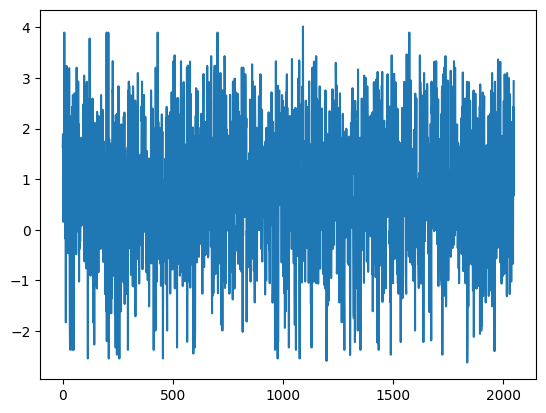

In [ ]:
plt.plot(env3.rewards)